# Miller age

In [1]:
ood_seed = 0

In [2]:
num_ood = 1  # not functioning

In [3]:
import cpa

[rank: 0] Global seed set to 0


In [6]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: True


In [7]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [18]:
adata_file_path = os.path.join("/home/icb/kemal.inecik/lustre_workspace/tardis_data/processed", "dataset_complete_Miller.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)
adata.obs["age"] = adata.obs["age"].astype("str").astype("category")

adata.obs["age"] = adata.obs["age"].astype("str").astype("category")
adata.obs["age_int"] = adata.obs["age"].astype(str).astype(float).astype(int).astype(str).astype("category")

adata.obs["age_continuous"] = adata.obs["age"].astype(float)
df = adata.obs.groupby(["cell_type", "age"]).size()
df2 = adata.obs.groupby(["cell_type"]).size()
availables = [(i, df[i]) for i in df.index if df[i] > 100 and df2[i[0]] > 350]

In [10]:
df

cell_type                            age 
Bud tip adjacent cells               11.5    169
                                     15.0    282
                                     18.0    777
                                     21.0      0
Bud tip progenitor                   11.5    273
                                     15.0    338
                                     18.0    683
                                     21.0      2
Deuterosomal cells                   11.5      2
                                     15.0    145
                                     18.0    111
                                     21.0     49
Hub cells                            11.5    218
                                     15.0    308
                                     18.0    620
                                     21.0      2
Intermediate trachea ciliated cells  11.5      0
                                     15.0     59
                                     18.0      0
                           

In [19]:
availables, len(availables)

([(('Bud tip adjacent cells', '11.5'), 169),
  (('Bud tip adjacent cells', '15.0'), 282),
  (('Bud tip adjacent cells', '18.0'), 777),
  (('Bud tip progenitor', '11.5'), 273),
  (('Bud tip progenitor', '15.0'), 338),
  (('Bud tip progenitor', '18.0'), 683),
  (('Hub cells', '11.5'), 218),
  (('Hub cells', '15.0'), 308),
  (('Hub cells', '18.0'), 620),
  (('Lung ciliated cells', '15.0'), 692),
  (('Lung ciliated cells', '18.0'), 494),
  (('Lung ciliated cells', '21.0'), 165),
  (('Lung secretory cells', '15.0'), 595),
  (('Lung secretory cells', '21.0'), 438),
  (('Submucosal gland cells', '15.0'), 380),
  (('Submucosal gland cells', '18.0'), 156)],
 16)

In [20]:
def create_random_mask(shape, ratio_true, seed=None):
    rng = np.random.default_rng(seed)
    random_floats = rng.random(shape)
    mask = random_floats < ratio_true
    return mask


def adata_ood_creator(adata, seed, size):
    rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["cell_type"] == choice[0][0]) & (adata.obs["age"] == choice[0][1]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

_, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)
train_split = create_random_mask(len(adata), ratio_true=0.8)
adata.obs["split"] = "validation"
adata.obs["split"][train_split] = "train"
adata.obs["split"][choices_bool] = "ood" 
adata.obs["split"].value_counts()

(('Bud tip adjacent cells', '11.5'), 169)

Removed datapoint: 169


train         5807
validation    1429
ood            169
Name: split, dtype: int64

In [21]:
dir_path = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/models",
    f"miller_cpa_ood-seed-{ood_seed}_size-{num_ood}"
)

In [24]:
cpa.CPA.setup_anndata(
    adata,
    # does not allow empty or all same placeholder column for below.
    perturbation_key="age_int",
    control_group="11",
    batch_key=None,
    is_count_data=True,
    categorical_covariate_keys=['integration_donor'],
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7405/7405 [00:00<00:00, 820663.24it/s]
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


In [25]:
model = cpa.CPA(
    adata=adata, 
    n_latent=24,
    split_key='split',
    train_split='train',
    valid_split='validation',
    test_split='ood'
)

[rank: 0] Global seed set to 0


In [26]:
model.train(max_epochs=400)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 201.95it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-PCIE-40GB MIG 3g.20gb') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-d7a14d27-a4ce-50f4-ac0d-9574c956ed5a]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 1/400:   0%|                                                                                                                                                              | 0/400 [00:00<?, ?it/s]

In [28]:
model.save(
    dir_path,
    overwrite=True,
)

In [29]:
latents = model.get_latent_representation()


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 232/232 [00:01<00:00, 174.47it/s]


In [30]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[model.validation_indices] = "validation"
adata.obs["validation"].iloc[model.test_indices] = "ood"

In [31]:
np.all(adata.obs["validation"] == adata.obs["split"])

True

In [32]:
latents.keys()

dict_keys(['latent_corrected', 'latent_basal', 'latent_after'])

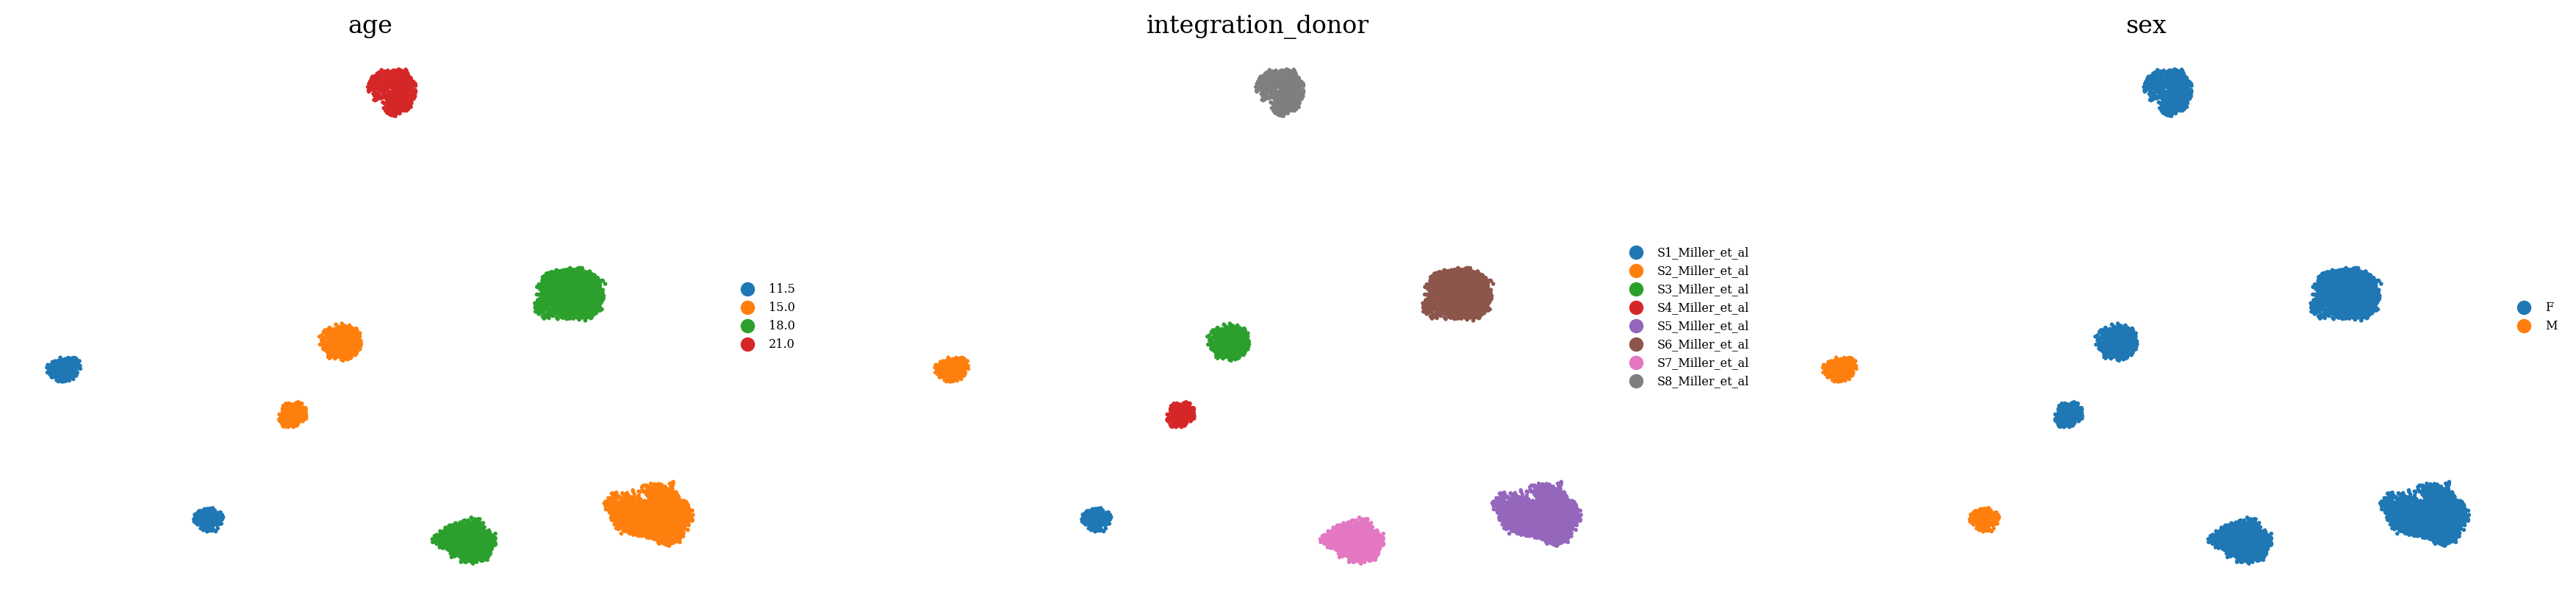

In [33]:
sc.pp.neighbors(latents["latent_after"])
sc.tl.umap(latents["latent_after"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_after"], 
        color=["age", "integration_donor", "sex"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

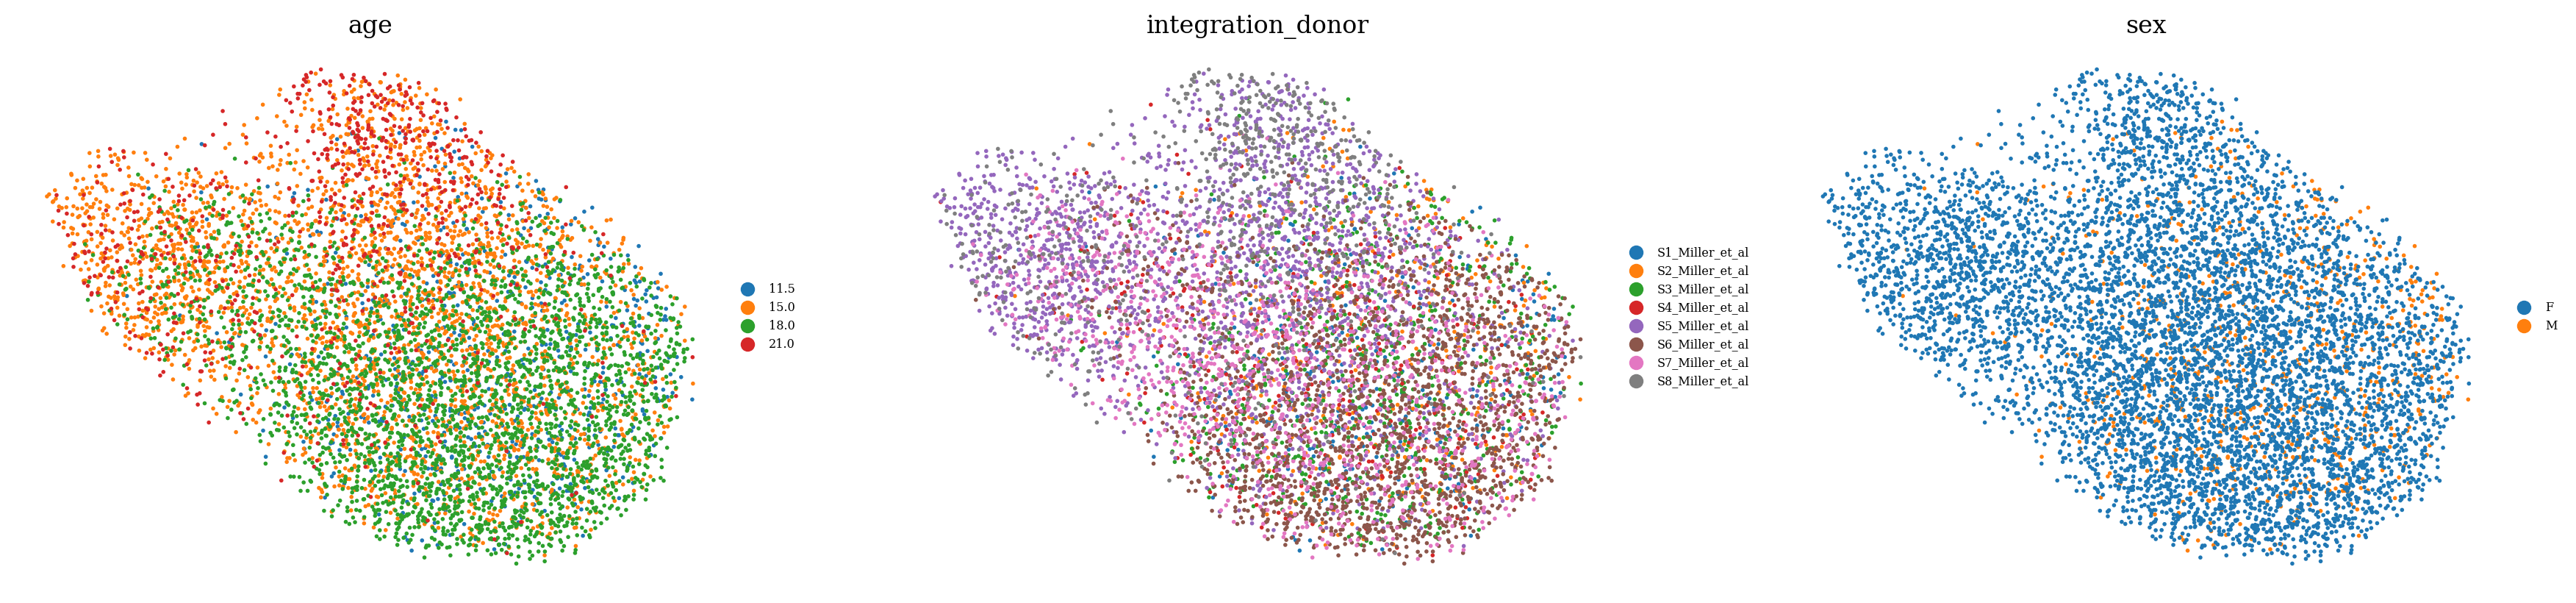

In [34]:
sc.pp.neighbors(latents["latent_basal"])
sc.tl.umap(latents["latent_basal"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_basal"], 
        color=["age", "integration_donor", "sex"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

In [35]:
model.predict()


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 232/232 [00:02<00:00, 98.24it/s]


Epoch 3/600:   0%|          | 3/600 [00:13<42:50,  4.31s/it, v_num=bl_1, total_loss_train=1.04e+3, kl_local_train=29.8, tardis_age_0_train=33.7, tardis_integration_donor_0_train=36.5]

Epoch 3/600:   0%|          | 3/600 [00:13<42:50,  4.31s/it, v_num=bl_1, total_loss_train=1e+3, kl_local_train=31, tardis_age_0_train=34.3, tardis_integration_donor_0_train=36.2]     

Epoch 4/600:   0%|          | 3/600 [00:13<42:50,  4.31s/it, v_num=bl_1, total_loss_train=1e+3, kl_local_train=31, tardis_age_0_train=34.3, tardis_integration_donor_0_train=36.2]

Epoch 4/600:   1%|          | 4/600 [00:17<42:47,  4.31s/it, v_num=bl_1, total_loss_train=1e+3, kl_local_train=31, tardis_age_0_train=34.3, tardis_integration_donor_0_train=36.2]

Epoch 4/600:   1%|          | 4/600 [00:17<42:47,  4.31s/it, v_num=bl_1, total_loss_train=978, kl_local_train=32.5, tardis_age_0_train=32.6, tardis_integration_donor_0_train=33.9]

Epoch 5/600:   1%|          | 4/600 [00:17<42:47,  4.31s/it, v_num=bl_1, total_loss_train=978, kl_local_train=32.5, tardis_age_0_train=32.6, tardis_integration_donor_0_train=33.9]

Epoch 5/600:   1%|          | 5/600 [00:21<42:36,  4.30s/it, v_num=bl_1, total_loss_train=978, kl_local_train=32.5, tardis_age_0_train=32.6, tardis_integration_donor_0_train=33.9]

Epoch 5/600:   1%|          | 5/600 [00:21<42:36,  4.30s/it, v_num=bl_1, total_loss_train=945, kl_local_train=39.8, tardis_age_0_train=32.3, tardis_integration_donor_0_train=33.7]

Epoch 6/600:   1%|          | 5/600 [00:21<42:36,  4.30s/it, v_num=bl_1, total_loss_train=945, kl_local_train=39.8, tardis_age_0_train=32.3, tardis_integration_donor_0_train=33.7]

Epoch 6/600:   1%|          | 6/600 [00:25<42:22,  4.28s/it, v_num=bl_1, total_loss_train=945, kl_local_train=39.8, tardis_age_0_train=32.3, tardis_integration_donor_0_train=33.7]

Epoch 6/600:   1%|          | 6/600 [00:25<42:22,  4.28s/it, v_num=bl_1, total_loss_train=920, kl_local_train=43, tardis_age_0_train=31.9, tardis_integration_donor_0_train=34.3]  

Epoch 7/600:   1%|          | 6/600 [00:25<42:22,  4.28s/it, v_num=bl_1, total_loss_train=920, kl_local_train=43, tardis_age_0_train=31.9, tardis_integration_donor_0_train=34.3]

Epoch 7/600:   1%|          | 7/600 [00:30<42:16,  4.28s/it, v_num=bl_1, total_loss_train=920, kl_local_train=43, tardis_age_0_train=31.9, tardis_integration_donor_0_train=34.3]

Epoch 7/600:   1%|          | 7/600 [00:30<42:16,  4.28s/it, v_num=bl_1, total_loss_train=903, kl_local_train=44.5, tardis_age_0_train=32.4, tardis_integration_donor_0_train=34.7]

Epoch 8/600:   1%|          | 7/600 [00:30<42:16,  4.28s/it, v_num=bl_1, total_loss_train=903, kl_local_train=44.5, tardis_age_0_train=32.4, tardis_integration_donor_0_train=34.7]

Epoch 8/600:   1%|▏         | 8/600 [00:34<42:08,  4.27s/it, v_num=bl_1, total_loss_train=903, kl_local_train=44.5, tardis_age_0_train=32.4, tardis_integration_donor_0_train=34.7]

Epoch 8/600:   1%|▏         | 8/600 [00:34<42:08,  4.27s/it, v_num=bl_1, total_loss_train=900, kl_local_train=42.2, tardis_age_0_train=34.5, tardis_integration_donor_0_train=35.2]

Epoch 9/600:   1%|▏         | 8/600 [00:34<42:08,  4.27s/it, v_num=bl_1, total_loss_train=900, kl_local_train=42.2, tardis_age_0_train=34.5, tardis_integration_donor_0_train=35.2]

Epoch 9/600:   2%|▏         | 9/600 [00:38<42:08,  4.28s/it, v_num=bl_1, total_loss_train=900, kl_local_train=42.2, tardis_age_0_train=34.5, tardis_integration_donor_0_train=35.2]

Epoch 9/600:   2%|▏         | 9/600 [00:38<42:08,  4.28s/it, v_num=bl_1, total_loss_train=899, kl_local_train=36.3, tardis_age_0_train=35.3, tardis_integration_donor_0_train=34.7]

Epoch 10/600:   2%|▏         | 9/600 [00:38<42:08,  4.28s/it, v_num=bl_1, total_loss_train=899, kl_local_train=36.3, tardis_age_0_train=35.3, tardis_integration_donor_0_train=34.7]

Epoch 10/600:   2%|▏         | 10/600 [00:42<41:58,  4.27s/it, v_num=bl_1, total_loss_train=899, kl_local_train=36.3, tardis_age_0_train=35.3, tardis_integration_donor_0_train=34.7]

Epoch 10/600:   2%|▏         | 10/600 [00:42<41:58,  4.27s/it, v_num=bl_1, total_loss_train=898, kl_local_train=34.2, tardis_age_0_train=34.4, tardis_integration_donor_0_train=32.8]

Epoch 11/600:   2%|▏         | 10/600 [00:42<41:58,  4.27s/it, v_num=bl_1, total_loss_train=898, kl_local_train=34.2, tardis_age_0_train=34.4, tardis_integration_donor_0_train=32.8]

Epoch 11/600:   2%|▏         | 11/600 [00:47<41:50,  4.26s/it, v_num=bl_1, total_loss_train=898, kl_local_train=34.2, tardis_age_0_train=34.4, tardis_integration_donor_0_train=32.8]

Epoch 11/600:   2%|▏         | 11/600 [00:47<41:50,  4.26s/it, v_num=bl_1, total_loss_train=897, kl_local_train=37.6, tardis_age_0_train=33.2, tardis_integration_donor_0_train=29.7]

Epoch 12/600:   2%|▏         | 11/600 [00:47<41:50,  4.26s/it, v_num=bl_1, total_loss_train=897, kl_local_train=37.6, tardis_age_0_train=33.2, tardis_integration_donor_0_train=29.7]

Epoch 12/600:   2%|▏         | 12/600 [00:51<41:47,  4.26s/it, v_num=bl_1, total_loss_train=897, kl_local_train=37.6, tardis_age_0_train=33.2, tardis_integration_donor_0_train=29.7]

Epoch 12/600:   2%|▏         | 12/600 [00:51<41:47,  4.26s/it, v_num=bl_1, total_loss_train=897, kl_local_train=42, tardis_age_0_train=32.5, tardis_integration_donor_0_train=28]    

Epoch 13/600:   2%|▏         | 12/600 [00:51<41:47,  4.26s/it, v_num=bl_1, total_loss_train=897, kl_local_train=42, tardis_age_0_train=32.5, tardis_integration_donor_0_train=28]

Epoch 13/600:   2%|▏         | 13/600 [00:55<41:40,  4.26s/it, v_num=bl_1, total_loss_train=897, kl_local_train=42, tardis_age_0_train=32.5, tardis_integration_donor_0_train=28]

Epoch 13/600:   2%|▏         | 13/600 [00:55<41:40,  4.26s/it, v_num=bl_1, total_loss_train=896, kl_local_train=46.4, tardis_age_0_train=32.4, tardis_integration_donor_0_train=27.2]

Epoch 14/600:   2%|▏         | 13/600 [00:55<41:40,  4.26s/it, v_num=bl_1, total_loss_train=896, kl_local_train=46.4, tardis_age_0_train=32.4, tardis_integration_donor_0_train=27.2]

Epoch 14/600:   2%|▏         | 14/600 [00:59<41:23,  4.24s/it, v_num=bl_1, total_loss_train=896, kl_local_train=46.4, tardis_age_0_train=32.4, tardis_integration_donor_0_train=27.2]

Epoch 14/600:   2%|▏         | 14/600 [00:59<41:23,  4.24s/it, v_num=bl_1, total_loss_train=896, kl_local_train=51.6, tardis_age_0_train=31.6, tardis_integration_donor_0_train=25.7]

Epoch 15/600:   2%|▏         | 14/600 [00:59<41:23,  4.24s/it, v_num=bl_1, total_loss_train=896, kl_local_train=51.6, tardis_age_0_train=31.6, tardis_integration_donor_0_train=25.7]

Epoch 15/600:   2%|▎         | 15/600 [01:04<41:23,  4.25s/it, v_num=bl_1, total_loss_train=896, kl_local_train=51.6, tardis_age_0_train=31.6, tardis_integration_donor_0_train=25.7]

Epoch 15/600:   2%|▎         | 15/600 [01:04<41:23,  4.25s/it, v_num=bl_1, total_loss_train=897, kl_local_train=57.3, tardis_age_0_train=31.5, tardis_integration_donor_0_train=24.9]

Epoch 16/600:   2%|▎         | 15/600 [01:04<41:23,  4.25s/it, v_num=bl_1, total_loss_train=897, kl_local_train=57.3, tardis_age_0_train=31.5, tardis_integration_donor_0_train=24.9]

Epoch 16/600:   3%|▎         | 16/600 [01:08<41:21,  4.25s/it, v_num=bl_1, total_loss_train=897, kl_local_train=57.3, tardis_age_0_train=31.5, tardis_integration_donor_0_train=24.9]

Epoch 16/600:   3%|▎         | 16/600 [01:08<41:21,  4.25s/it, v_num=bl_1, total_loss_train=897, kl_local_train=63.1, tardis_age_0_train=30.9, tardis_integration_donor_0_train=23.8]

Epoch 17/600:   3%|▎         | 16/600 [01:08<41:21,  4.25s/it, v_num=bl_1, total_loss_train=897, kl_local_train=63.1, tardis_age_0_train=30.9, tardis_integration_donor_0_train=23.8]

Epoch 17/600:   3%|▎         | 17/600 [01:12<41:17,  4.25s/it, v_num=bl_1, total_loss_train=897, kl_local_train=63.1, tardis_age_0_train=30.9, tardis_integration_donor_0_train=23.8]

Epoch 17/600:   3%|▎         | 17/600 [01:12<41:17,  4.25s/it, v_num=bl_1, total_loss_train=898, kl_local_train=66.2, tardis_age_0_train=29.6, tardis_integration_donor_0_train=23.2]

Epoch 18/600:   3%|▎         | 17/600 [01:12<41:17,  4.25s/it, v_num=bl_1, total_loss_train=898, kl_local_train=66.2, tardis_age_0_train=29.6, tardis_integration_donor_0_train=23.2]

Epoch 18/600:   3%|▎         | 18/600 [01:16<41:13,  4.25s/it, v_num=bl_1, total_loss_train=898, kl_local_train=66.2, tardis_age_0_train=29.6, tardis_integration_donor_0_train=23.2]

Epoch 18/600:   3%|▎         | 18/600 [01:16<41:13,  4.25s/it, v_num=bl_1, total_loss_train=900, kl_local_train=73.8, tardis_age_0_train=29.2, tardis_integration_donor_0_train=22.3]

Epoch 19/600:   3%|▎         | 18/600 [01:16<41:13,  4.25s/it, v_num=bl_1, total_loss_train=900, kl_local_train=73.8, tardis_age_0_train=29.2, tardis_integration_donor_0_train=22.3]

Epoch 19/600:   3%|▎         | 19/600 [01:21<41:01,  4.24s/it, v_num=bl_1, total_loss_train=900, kl_local_train=73.8, tardis_age_0_train=29.2, tardis_integration_donor_0_train=22.3]

Epoch 19/600:   3%|▎         | 19/600 [01:21<41:01,  4.24s/it, v_num=bl_1, total_loss_train=902, kl_local_train=85.9, tardis_age_0_train=28, tardis_integration_donor_0_train=21.8]  

Epoch 20/600:   3%|▎         | 19/600 [01:21<41:01,  4.24s/it, v_num=bl_1, total_loss_train=902, kl_local_train=85.9, tardis_age_0_train=28, tardis_integration_donor_0_train=21.8]

Epoch 20/600:   3%|▎         | 20/600 [01:25<41:04,  4.25s/it, v_num=bl_1, total_loss_train=902, kl_local_train=85.9, tardis_age_0_train=28, tardis_integration_donor_0_train=21.8]

Epoch 20/600:   3%|▎         | 20/600 [01:25<41:04,  4.25s/it, v_num=bl_1, total_loss_train=902, kl_local_train=96.9, tardis_age_0_train=25.7, tardis_integration_donor_0_train=20]

Epoch 21/600:   3%|▎         | 20/600 [01:25<41:04,  4.25s/it, v_num=bl_1, total_loss_train=902, kl_local_train=96.9, tardis_age_0_train=25.7, tardis_integration_donor_0_train=20]

Epoch 21/600:   4%|▎         | 21/600 [01:29<41:03,  4.26s/it, v_num=bl_1, total_loss_train=902, kl_local_train=96.9, tardis_age_0_train=25.7, tardis_integration_donor_0_train=20]

Epoch 21/600:   4%|▎         | 21/600 [01:29<41:03,  4.26s/it, v_num=bl_1, total_loss_train=903, kl_local_train=106, tardis_age_0_train=23.2, tardis_integration_donor_0_train=18.9]

Epoch 22/600:   4%|▎         | 21/600 [01:29<41:03,  4.26s/it, v_num=bl_1, total_loss_train=903, kl_local_train=106, tardis_age_0_train=23.2, tardis_integration_donor_0_train=18.9]

Epoch 22/600:   4%|▎         | 22/600 [01:33<41:01,  4.26s/it, v_num=bl_1, total_loss_train=903, kl_local_train=106, tardis_age_0_train=23.2, tardis_integration_donor_0_train=18.9]

Epoch 22/600:   4%|▎         | 22/600 [01:33<41:01,  4.26s/it, v_num=bl_1, total_loss_train=904, kl_local_train=117, tardis_age_0_train=20.8, tardis_integration_donor_0_train=17.6]

Epoch 23/600:   4%|▎         | 22/600 [01:33<41:01,  4.26s/it, v_num=bl_1, total_loss_train=904, kl_local_train=117, tardis_age_0_train=20.8, tardis_integration_donor_0_train=17.6]

Epoch 23/600:   4%|▍         | 23/600 [01:38<40:57,  4.26s/it, v_num=bl_1, total_loss_train=904, kl_local_train=117, tardis_age_0_train=20.8, tardis_integration_donor_0_train=17.6]

Epoch 23/600:   4%|▍         | 23/600 [01:38<40:57,  4.26s/it, v_num=bl_1, total_loss_train=904, kl_local_train=126, tardis_age_0_train=18.3, tardis_integration_donor_0_train=16.3]

Epoch 24/600:   4%|▍         | 23/600 [01:38<40:57,  4.26s/it, v_num=bl_1, total_loss_train=904, kl_local_train=126, tardis_age_0_train=18.3, tardis_integration_donor_0_train=16.3]

Epoch 24/600:   4%|▍         | 24/600 [01:42<40:50,  4.26s/it, v_num=bl_1, total_loss_train=904, kl_local_train=126, tardis_age_0_train=18.3, tardis_integration_donor_0_train=16.3]

Epoch 24/600:   4%|▍         | 24/600 [01:42<40:50,  4.26s/it, v_num=bl_1, total_loss_train=906, kl_local_train=142, tardis_age_0_train=16.9, tardis_integration_donor_0_train=15.9]

Epoch 25/600:   4%|▍         | 24/600 [01:42<40:50,  4.26s/it, v_num=bl_1, total_loss_train=906, kl_local_train=142, tardis_age_0_train=16.9, tardis_integration_donor_0_train=15.9]

Epoch 25/600:   4%|▍         | 25/600 [01:46<40:45,  4.25s/it, v_num=bl_1, total_loss_train=906, kl_local_train=142, tardis_age_0_train=16.9, tardis_integration_donor_0_train=15.9]

Epoch 25/600:   4%|▍         | 25/600 [01:46<40:45,  4.25s/it, v_num=bl_1, total_loss_train=906, kl_local_train=158, tardis_age_0_train=15.4, tardis_integration_donor_0_train=14.9]

Epoch 26/600:   4%|▍         | 25/600 [01:46<40:45,  4.25s/it, v_num=bl_1, total_loss_train=906, kl_local_train=158, tardis_age_0_train=15.4, tardis_integration_donor_0_train=14.9]

Epoch 26/600:   4%|▍         | 26/600 [01:51<40:48,  4.27s/it, v_num=bl_1, total_loss_train=906, kl_local_train=158, tardis_age_0_train=15.4, tardis_integration_donor_0_train=14.9]

Epoch 26/600:   4%|▍         | 26/600 [01:51<40:48,  4.27s/it, v_num=bl_1, total_loss_train=908, kl_local_train=168, tardis_age_0_train=14.3, tardis_integration_donor_0_train=14.5]

Epoch 27/600:   4%|▍         | 26/600 [01:51<40:48,  4.27s/it, v_num=bl_1, total_loss_train=908, kl_local_train=168, tardis_age_0_train=14.3, tardis_integration_donor_0_train=14.5]

Epoch 27/600:   4%|▍         | 27/600 [01:55<40:46,  4.27s/it, v_num=bl_1, total_loss_train=908, kl_local_train=168, tardis_age_0_train=14.3, tardis_integration_donor_0_train=14.5]

Epoch 27/600:   4%|▍         | 27/600 [01:55<40:46,  4.27s/it, v_num=bl_1, total_loss_train=910, kl_local_train=183, tardis_age_0_train=13.8, tardis_integration_donor_0_train=13.6]

Epoch 28/600:   4%|▍         | 27/600 [01:55<40:46,  4.27s/it, v_num=bl_1, total_loss_train=910, kl_local_train=183, tardis_age_0_train=13.8, tardis_integration_donor_0_train=13.6]

Epoch 28/600:   5%|▍         | 28/600 [01:59<40:44,  4.27s/it, v_num=bl_1, total_loss_train=910, kl_local_train=183, tardis_age_0_train=13.8, tardis_integration_donor_0_train=13.6]

Epoch 28/600:   5%|▍         | 28/600 [01:59<40:44,  4.27s/it, v_num=bl_1, total_loss_train=912, kl_local_train=192, tardis_age_0_train=13, tardis_integration_donor_0_train=13.6]  

Epoch 29/600:   5%|▍         | 28/600 [01:59<40:44,  4.27s/it, v_num=bl_1, total_loss_train=912, kl_local_train=192, tardis_age_0_train=13, tardis_integration_donor_0_train=13.6]

Epoch 29/600:   5%|▍         | 29/600 [02:03<40:36,  4.27s/it, v_num=bl_1, total_loss_train=912, kl_local_train=192, tardis_age_0_train=13, tardis_integration_donor_0_train=13.6]

Epoch 29/600:   5%|▍         | 29/600 [02:03<40:36,  4.27s/it, v_num=bl_1, total_loss_train=913, kl_local_train=199, tardis_age_0_train=12, tardis_integration_donor_0_train=12.8]

Epoch 30/600:   5%|▍         | 29/600 [02:03<40:36,  4.27s/it, v_num=bl_1, total_loss_train=913, kl_local_train=199, tardis_age_0_train=12, tardis_integration_donor_0_train=12.8]

Epoch 30/600:   5%|▌         | 30/600 [02:08<40:30,  4.26s/it, v_num=bl_1, total_loss_train=913, kl_local_train=199, tardis_age_0_train=12, tardis_integration_donor_0_train=12.8]

Epoch 30/600:   5%|▌         | 30/600 [02:08<40:30,  4.26s/it, v_num=bl_1, total_loss_train=915, kl_local_train=203, tardis_age_0_train=11.6, tardis_integration_donor_0_train=12.7]

Epoch 31/600:   5%|▌         | 30/600 [02:08<40:30,  4.26s/it, v_num=bl_1, total_loss_train=915, kl_local_train=203, tardis_age_0_train=11.6, tardis_integration_donor_0_train=12.7]

Epoch 31/600:   5%|▌         | 31/600 [02:12<40:20,  4.25s/it, v_num=bl_1, total_loss_train=915, kl_local_train=203, tardis_age_0_train=11.6, tardis_integration_donor_0_train=12.7]

Epoch 31/600:   5%|▌         | 31/600 [02:12<40:20,  4.25s/it, v_num=bl_1, total_loss_train=917, kl_local_train=204, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.4]

Epoch 32/600:   5%|▌         | 31/600 [02:12<40:20,  4.25s/it, v_num=bl_1, total_loss_train=917, kl_local_train=204, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.4]

Epoch 32/600:   5%|▌         | 32/600 [02:16<40:12,  4.25s/it, v_num=bl_1, total_loss_train=917, kl_local_train=204, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.4]

Epoch 32/600:   5%|▌         | 32/600 [02:16<40:12,  4.25s/it, v_num=bl_1, total_loss_train=919, kl_local_train=206, tardis_age_0_train=10, tardis_integration_donor_0_train=11.7]  

Epoch 33/600:   5%|▌         | 32/600 [02:16<40:12,  4.25s/it, v_num=bl_1, total_loss_train=919, kl_local_train=206, tardis_age_0_train=10, tardis_integration_donor_0_train=11.7]

Epoch 33/600:   6%|▌         | 33/600 [02:20<40:11,  4.25s/it, v_num=bl_1, total_loss_train=919, kl_local_train=206, tardis_age_0_train=10, tardis_integration_donor_0_train=11.7]

Epoch 33/600:   6%|▌         | 33/600 [02:20<40:11,  4.25s/it, v_num=bl_1, total_loss_train=920, kl_local_train=213, tardis_age_0_train=9.67, tardis_integration_donor_0_train=11.5]

Epoch 34/600:   6%|▌         | 33/600 [02:20<40:11,  4.25s/it, v_num=bl_1, total_loss_train=920, kl_local_train=213, tardis_age_0_train=9.67, tardis_integration_donor_0_train=11.5]

Epoch 34/600:   6%|▌         | 34/600 [02:25<40:10,  4.26s/it, v_num=bl_1, total_loss_train=920, kl_local_train=213, tardis_age_0_train=9.67, tardis_integration_donor_0_train=11.5]

Epoch 34/600:   6%|▌         | 34/600 [02:25<40:10,  4.26s/it, v_num=bl_1, total_loss_train=922, kl_local_train=221, tardis_age_0_train=9.19, tardis_integration_donor_0_train=11.1]

Epoch 35/600:   6%|▌         | 34/600 [02:25<40:10,  4.26s/it, v_num=bl_1, total_loss_train=922, kl_local_train=221, tardis_age_0_train=9.19, tardis_integration_donor_0_train=11.1]

Epoch 35/600:   6%|▌         | 35/600 [02:29<40:18,  4.28s/it, v_num=bl_1, total_loss_train=922, kl_local_train=221, tardis_age_0_train=9.19, tardis_integration_donor_0_train=11.1]

Epoch 35/600:   6%|▌         | 35/600 [02:29<40:18,  4.28s/it, v_num=bl_1, total_loss_train=924, kl_local_train=218, tardis_age_0_train=9.07, tardis_integration_donor_0_train=11.1]

Epoch 36/600:   6%|▌         | 35/600 [02:29<40:18,  4.28s/it, v_num=bl_1, total_loss_train=924, kl_local_train=218, tardis_age_0_train=9.07, tardis_integration_donor_0_train=11.1]

Epoch 36/600:   6%|▌         | 36/600 [02:33<40:14,  4.28s/it, v_num=bl_1, total_loss_train=924, kl_local_train=218, tardis_age_0_train=9.07, tardis_integration_donor_0_train=11.1]

Epoch 36/600:   6%|▌         | 36/600 [02:33<40:14,  4.28s/it, v_num=bl_1, total_loss_train=926, kl_local_train=221, tardis_age_0_train=8.59, tardis_integration_donor_0_train=10.3]

Epoch 37/600:   6%|▌         | 36/600 [02:33<40:14,  4.28s/it, v_num=bl_1, total_loss_train=926, kl_local_train=221, tardis_age_0_train=8.59, tardis_integration_donor_0_train=10.3]

Epoch 37/600:   6%|▌         | 37/600 [02:37<40:08,  4.28s/it, v_num=bl_1, total_loss_train=926, kl_local_train=221, tardis_age_0_train=8.59, tardis_integration_donor_0_train=10.3]

Epoch 37/600:   6%|▌         | 37/600 [02:37<40:08,  4.28s/it, v_num=bl_1, total_loss_train=928, kl_local_train=228, tardis_age_0_train=8.64, tardis_integration_donor_0_train=10.5]

Epoch 38/600:   6%|▌         | 37/600 [02:38<40:08,  4.28s/it, v_num=bl_1, total_loss_train=928, kl_local_train=228, tardis_age_0_train=8.64, tardis_integration_donor_0_train=10.5]

Epoch 38/600:   6%|▋         | 38/600 [02:42<39:59,  4.27s/it, v_num=bl_1, total_loss_train=928, kl_local_train=228, tardis_age_0_train=8.64, tardis_integration_donor_0_train=10.5]

Epoch 38/600:   6%|▋         | 38/600 [02:42<39:59,  4.27s/it, v_num=bl_1, total_loss_train=931, kl_local_train=242, tardis_age_0_train=7.96, tardis_integration_donor_0_train=9.69]

Epoch 39/600:   6%|▋         | 38/600 [02:42<39:59,  4.27s/it, v_num=bl_1, total_loss_train=931, kl_local_train=242, tardis_age_0_train=7.96, tardis_integration_donor_0_train=9.69]

Epoch 39/600:   6%|▋         | 39/600 [02:46<39:54,  4.27s/it, v_num=bl_1, total_loss_train=931, kl_local_train=242, tardis_age_0_train=7.96, tardis_integration_donor_0_train=9.69]

Epoch 39/600:   6%|▋         | 39/600 [02:46<39:54,  4.27s/it, v_num=bl_1, total_loss_train=932, kl_local_train=231, tardis_age_0_train=7.95, tardis_integration_donor_0_train=9.86]

Epoch 40/600:   6%|▋         | 39/600 [02:46<39:54,  4.27s/it, v_num=bl_1, total_loss_train=932, kl_local_train=231, tardis_age_0_train=7.95, tardis_integration_donor_0_train=9.86]

Epoch 40/600:   7%|▋         | 40/600 [02:50<39:59,  4.28s/it, v_num=bl_1, total_loss_train=932, kl_local_train=231, tardis_age_0_train=7.95, tardis_integration_donor_0_train=9.86]

Epoch 40/600:   7%|▋         | 40/600 [02:50<39:59,  4.28s/it, v_num=bl_1, total_loss_train=934, kl_local_train=236, tardis_age_0_train=7.78, tardis_integration_donor_0_train=9.17]

Epoch 41/600:   7%|▋         | 40/600 [02:50<39:59,  4.28s/it, v_num=bl_1, total_loss_train=934, kl_local_train=236, tardis_age_0_train=7.78, tardis_integration_donor_0_train=9.17]

Epoch 41/600:   7%|▋         | 41/600 [02:55<39:49,  4.27s/it, v_num=bl_1, total_loss_train=934, kl_local_train=236, tardis_age_0_train=7.78, tardis_integration_donor_0_train=9.17]

Epoch 41/600:   7%|▋         | 41/600 [02:55<39:49,  4.27s/it, v_num=bl_1, total_loss_train=936, kl_local_train=228, tardis_age_0_train=7.57, tardis_integration_donor_0_train=9.26]

Epoch 42/600:   7%|▋         | 41/600 [02:55<39:49,  4.27s/it, v_num=bl_1, total_loss_train=936, kl_local_train=228, tardis_age_0_train=7.57, tardis_integration_donor_0_train=9.26]

Epoch 42/600:   7%|▋         | 42/600 [02:59<39:45,  4.28s/it, v_num=bl_1, total_loss_train=936, kl_local_train=228, tardis_age_0_train=7.57, tardis_integration_donor_0_train=9.26]

Epoch 42/600:   7%|▋         | 42/600 [02:59<39:45,  4.28s/it, v_num=bl_1, total_loss_train=939, kl_local_train=224, tardis_age_0_train=7.64, tardis_integration_donor_0_train=9.04]

Epoch 43/600:   7%|▋         | 42/600 [02:59<39:45,  4.28s/it, v_num=bl_1, total_loss_train=939, kl_local_train=224, tardis_age_0_train=7.64, tardis_integration_donor_0_train=9.04]

Epoch 43/600:   7%|▋         | 43/600 [03:03<39:33,  4.26s/it, v_num=bl_1, total_loss_train=939, kl_local_train=224, tardis_age_0_train=7.64, tardis_integration_donor_0_train=9.04]

Epoch 43/600:   7%|▋         | 43/600 [03:03<39:33,  4.26s/it, v_num=bl_1, total_loss_train=941, kl_local_train=216, tardis_age_0_train=7.86, tardis_integration_donor_0_train=8.94]

Epoch 44/600:   7%|▋         | 43/600 [03:03<39:33,  4.26s/it, v_num=bl_1, total_loss_train=941, kl_local_train=216, tardis_age_0_train=7.86, tardis_integration_donor_0_train=8.94]

Epoch 44/600:   7%|▋         | 44/600 [03:07<39:32,  4.27s/it, v_num=bl_1, total_loss_train=941, kl_local_train=216, tardis_age_0_train=7.86, tardis_integration_donor_0_train=8.94]

Epoch 44/600:   7%|▋         | 44/600 [03:07<39:32,  4.27s/it, v_num=bl_1, total_loss_train=943, kl_local_train=220, tardis_age_0_train=7.66, tardis_integration_donor_0_train=8.56]

Epoch 45/600:   7%|▋         | 44/600 [03:07<39:32,  4.27s/it, v_num=bl_1, total_loss_train=943, kl_local_train=220, tardis_age_0_train=7.66, tardis_integration_donor_0_train=8.56]

Epoch 45/600:   8%|▊         | 45/600 [03:12<39:24,  4.26s/it, v_num=bl_1, total_loss_train=943, kl_local_train=220, tardis_age_0_train=7.66, tardis_integration_donor_0_train=8.56]

Epoch 45/600:   8%|▊         | 45/600 [03:12<39:24,  4.26s/it, v_num=bl_1, total_loss_train=945, kl_local_train=228, tardis_age_0_train=7.24, tardis_integration_donor_0_train=8.44]

Epoch 46/600:   8%|▊         | 45/600 [03:12<39:24,  4.26s/it, v_num=bl_1, total_loss_train=945, kl_local_train=228, tardis_age_0_train=7.24, tardis_integration_donor_0_train=8.44]

Epoch 46/600:   8%|▊         | 46/600 [03:16<39:18,  4.26s/it, v_num=bl_1, total_loss_train=945, kl_local_train=228, tardis_age_0_train=7.24, tardis_integration_donor_0_train=8.44]

Epoch 46/600:   8%|▊         | 46/600 [03:16<39:18,  4.26s/it, v_num=bl_1, total_loss_train=947, kl_local_train=220, tardis_age_0_train=6.93, tardis_integration_donor_0_train=8.34]

Epoch 47/600:   8%|▊         | 46/600 [03:16<39:18,  4.26s/it, v_num=bl_1, total_loss_train=947, kl_local_train=220, tardis_age_0_train=6.93, tardis_integration_donor_0_train=8.34]

Epoch 47/600:   8%|▊         | 47/600 [03:20<39:13,  4.26s/it, v_num=bl_1, total_loss_train=947, kl_local_train=220, tardis_age_0_train=6.93, tardis_integration_donor_0_train=8.34]

Epoch 47/600:   8%|▊         | 47/600 [03:20<39:13,  4.26s/it, v_num=bl_1, total_loss_train=950, kl_local_train=221, tardis_age_0_train=6.92, tardis_integration_donor_0_train=8.1] 

Epoch 48/600:   8%|▊         | 47/600 [03:20<39:13,  4.26s/it, v_num=bl_1, total_loss_train=950, kl_local_train=221, tardis_age_0_train=6.92, tardis_integration_donor_0_train=8.1]

Epoch 48/600:   8%|▊         | 48/600 [03:24<39:09,  4.26s/it, v_num=bl_1, total_loss_train=950, kl_local_train=221, tardis_age_0_train=6.92, tardis_integration_donor_0_train=8.1]

Epoch 48/600:   8%|▊         | 48/600 [03:24<39:09,  4.26s/it, v_num=bl_1, total_loss_train=952, kl_local_train=217, tardis_age_0_train=6.75, tardis_integration_donor_0_train=7.81]

Epoch 49/600:   8%|▊         | 48/600 [03:24<39:09,  4.26s/it, v_num=bl_1, total_loss_train=952, kl_local_train=217, tardis_age_0_train=6.75, tardis_integration_donor_0_train=7.81]

Epoch 49/600:   8%|▊         | 49/600 [03:29<39:09,  4.26s/it, v_num=bl_1, total_loss_train=952, kl_local_train=217, tardis_age_0_train=6.75, tardis_integration_donor_0_train=7.81]

Epoch 49/600:   8%|▊         | 49/600 [03:29<39:09,  4.26s/it, v_num=bl_1, total_loss_train=954, kl_local_train=204, tardis_age_0_train=6.6, tardis_integration_donor_0_train=7.62] 

Epoch 50/600:   8%|▊         | 49/600 [03:29<39:09,  4.26s/it, v_num=bl_1, total_loss_train=954, kl_local_train=204, tardis_age_0_train=6.6, tardis_integration_donor_0_train=7.62]

Epoch 50/600:   8%|▊         | 50/600 [03:33<39:07,  4.27s/it, v_num=bl_1, total_loss_train=954, kl_local_train=204, tardis_age_0_train=6.6, tardis_integration_donor_0_train=7.62]

Epoch 50/600:   8%|▊         | 50/600 [03:33<39:07,  4.27s/it, v_num=bl_1, total_loss_train=955, kl_local_train=193, tardis_age_0_train=6.83, tardis_integration_donor_0_train=7.56]

Epoch 51/600:   8%|▊         | 50/600 [03:33<39:07,  4.27s/it, v_num=bl_1, total_loss_train=955, kl_local_train=193, tardis_age_0_train=6.83, tardis_integration_donor_0_train=7.56]

Epoch 51/600:   8%|▊         | 51/600 [03:37<39:02,  4.27s/it, v_num=bl_1, total_loss_train=955, kl_local_train=193, tardis_age_0_train=6.83, tardis_integration_donor_0_train=7.56]

Epoch 51/600:   8%|▊         | 51/600 [03:37<39:02,  4.27s/it, v_num=bl_1, total_loss_train=955, kl_local_train=194, tardis_age_0_train=6.74, tardis_integration_donor_0_train=7.78]

Epoch 52/600:   8%|▊         | 51/600 [03:37<39:02,  4.27s/it, v_num=bl_1, total_loss_train=955, kl_local_train=194, tardis_age_0_train=6.74, tardis_integration_donor_0_train=7.78]

Epoch 52/600:   9%|▊         | 52/600 [03:42<39:05,  4.28s/it, v_num=bl_1, total_loss_train=955, kl_local_train=194, tardis_age_0_train=6.74, tardis_integration_donor_0_train=7.78]

Epoch 52/600:   9%|▊         | 52/600 [03:42<39:05,  4.28s/it, v_num=bl_1, total_loss_train=954, kl_local_train=193, tardis_age_0_train=6.57, tardis_integration_donor_0_train=7.55]

Epoch 53/600:   9%|▊         | 52/600 [03:42<39:05,  4.28s/it, v_num=bl_1, total_loss_train=954, kl_local_train=193, tardis_age_0_train=6.57, tardis_integration_donor_0_train=7.55]

Epoch 53/600:   9%|▉         | 53/600 [03:46<38:58,  4.27s/it, v_num=bl_1, total_loss_train=954, kl_local_train=193, tardis_age_0_train=6.57, tardis_integration_donor_0_train=7.55]

Epoch 53/600:   9%|▉         | 53/600 [03:46<38:58,  4.27s/it, v_num=bl_1, total_loss_train=953, kl_local_train=194, tardis_age_0_train=6.3, tardis_integration_donor_0_train=7.41] 

Epoch 54/600:   9%|▉         | 53/600 [03:46<38:58,  4.27s/it, v_num=bl_1, total_loss_train=953, kl_local_train=194, tardis_age_0_train=6.3, tardis_integration_donor_0_train=7.41]

Epoch 54/600:   9%|▉         | 54/600 [03:50<38:50,  4.27s/it, v_num=bl_1, total_loss_train=953, kl_local_train=194, tardis_age_0_train=6.3, tardis_integration_donor_0_train=7.41]

Epoch 54/600:   9%|▉         | 54/600 [03:50<38:50,  4.27s/it, v_num=bl_1, total_loss_train=953, kl_local_train=196, tardis_age_0_train=6.39, tardis_integration_donor_0_train=7.28]

Epoch 55/600:   9%|▉         | 54/600 [03:50<38:50,  4.27s/it, v_num=bl_1, total_loss_train=953, kl_local_train=196, tardis_age_0_train=6.39, tardis_integration_donor_0_train=7.28]

Epoch 55/600:   9%|▉         | 55/600 [03:54<38:49,  4.27s/it, v_num=bl_1, total_loss_train=953, kl_local_train=196, tardis_age_0_train=6.39, tardis_integration_donor_0_train=7.28]

Epoch 55/600:   9%|▉         | 55/600 [03:54<38:49,  4.27s/it, v_num=bl_1, total_loss_train=951, kl_local_train=192, tardis_age_0_train=6.54, tardis_integration_donor_0_train=7.18]

Epoch 56/600:   9%|▉         | 55/600 [03:54<38:49,  4.27s/it, v_num=bl_1, total_loss_train=951, kl_local_train=192, tardis_age_0_train=6.54, tardis_integration_donor_0_train=7.18]

Epoch 56/600:   9%|▉         | 56/600 [03:59<38:43,  4.27s/it, v_num=bl_1, total_loss_train=951, kl_local_train=192, tardis_age_0_train=6.54, tardis_integration_donor_0_train=7.18]

Epoch 56/600:   9%|▉         | 56/600 [03:59<38:43,  4.27s/it, v_num=bl_1, total_loss_train=950, kl_local_train=179, tardis_age_0_train=6.47, tardis_integration_donor_0_train=6.8] 

Epoch 57/600:   9%|▉         | 56/600 [03:59<38:43,  4.27s/it, v_num=bl_1, total_loss_train=950, kl_local_train=179, tardis_age_0_train=6.47, tardis_integration_donor_0_train=6.8]

Epoch 57/600:  10%|▉         | 57/600 [04:03<38:36,  4.27s/it, v_num=bl_1, total_loss_train=950, kl_local_train=179, tardis_age_0_train=6.47, tardis_integration_donor_0_train=6.8]

Epoch 57/600:  10%|▉         | 57/600 [04:03<38:36,  4.27s/it, v_num=bl_1, total_loss_train=949, kl_local_train=176, tardis_age_0_train=6.52, tardis_integration_donor_0_train=7.1]

Epoch 58/600:  10%|▉         | 57/600 [04:03<38:36,  4.27s/it, v_num=bl_1, total_loss_train=949, kl_local_train=176, tardis_age_0_train=6.52, tardis_integration_donor_0_train=7.1]

Epoch 58/600:  10%|▉         | 58/600 [04:07<38:17,  4.24s/it, v_num=bl_1, total_loss_train=949, kl_local_train=176, tardis_age_0_train=6.52, tardis_integration_donor_0_train=7.1]

Epoch 58/600:  10%|▉         | 58/600 [04:07<38:17,  4.24s/it, v_num=bl_1, total_loss_train=949, kl_local_train=171, tardis_age_0_train=6.38, tardis_integration_donor_0_train=7.11]

Epoch 59/600:  10%|▉         | 58/600 [04:07<38:17,  4.24s/it, v_num=bl_1, total_loss_train=949, kl_local_train=171, tardis_age_0_train=6.38, tardis_integration_donor_0_train=7.11]

Epoch 59/600:  10%|▉         | 59/600 [04:11<38:01,  4.22s/it, v_num=bl_1, total_loss_train=949, kl_local_train=171, tardis_age_0_train=6.38, tardis_integration_donor_0_train=7.11]

Epoch 59/600:  10%|▉         | 59/600 [04:11<38:01,  4.22s/it, v_num=bl_1, total_loss_train=949, kl_local_train=171, tardis_age_0_train=6.54, tardis_integration_donor_0_train=7.06]

Epoch 60/600:  10%|▉         | 59/600 [04:11<38:01,  4.22s/it, v_num=bl_1, total_loss_train=949, kl_local_train=171, tardis_age_0_train=6.54, tardis_integration_donor_0_train=7.06]

Epoch 60/600:  10%|█         | 60/600 [04:15<37:50,  4.21s/it, v_num=bl_1, total_loss_train=949, kl_local_train=171, tardis_age_0_train=6.54, tardis_integration_donor_0_train=7.06]

Epoch 60/600:  10%|█         | 60/600 [04:15<37:50,  4.21s/it, v_num=bl_1, total_loss_train=947, kl_local_train=171, tardis_age_0_train=6.29, tardis_integration_donor_0_train=6.81]

Epoch 61/600:  10%|█         | 60/600 [04:15<37:50,  4.21s/it, v_num=bl_1, total_loss_train=947, kl_local_train=171, tardis_age_0_train=6.29, tardis_integration_donor_0_train=6.81]

Epoch 61/600:  10%|█         | 61/600 [04:19<37:38,  4.19s/it, v_num=bl_1, total_loss_train=947, kl_local_train=171, tardis_age_0_train=6.29, tardis_integration_donor_0_train=6.81]

Epoch 61/600:  10%|█         | 61/600 [04:19<37:38,  4.19s/it, v_num=bl_1, total_loss_train=947, kl_local_train=168, tardis_age_0_train=6.35, tardis_integration_donor_0_train=7]   

Epoch 62/600:  10%|█         | 61/600 [04:20<37:38,  4.19s/it, v_num=bl_1, total_loss_train=947, kl_local_train=168, tardis_age_0_train=6.35, tardis_integration_donor_0_train=7]

Epoch 62/600:  10%|█         | 62/600 [04:24<37:27,  4.18s/it, v_num=bl_1, total_loss_train=947, kl_local_train=168, tardis_age_0_train=6.35, tardis_integration_donor_0_train=7]

Epoch 62/600:  10%|█         | 62/600 [04:24<37:27,  4.18s/it, v_num=bl_1, total_loss_train=946, kl_local_train=165, tardis_age_0_train=6.47, tardis_integration_donor_0_train=6.87]

Epoch 63/600:  10%|█         | 62/600 [04:24<37:27,  4.18s/it, v_num=bl_1, total_loss_train=946, kl_local_train=165, tardis_age_0_train=6.47, tardis_integration_donor_0_train=6.87]

Epoch 63/600:  10%|█         | 63/600 [04:28<37:31,  4.19s/it, v_num=bl_1, total_loss_train=946, kl_local_train=165, tardis_age_0_train=6.47, tardis_integration_donor_0_train=6.87]

Epoch 63/600:  10%|█         | 63/600 [04:28<37:31,  4.19s/it, v_num=bl_1, total_loss_train=945, kl_local_train=163, tardis_age_0_train=6.21, tardis_integration_donor_0_train=6.83]

Epoch 64/600:  10%|█         | 63/600 [04:28<37:31,  4.19s/it, v_num=bl_1, total_loss_train=945, kl_local_train=163, tardis_age_0_train=6.21, tardis_integration_donor_0_train=6.83]

Epoch 64/600:  11%|█         | 64/600 [04:32<37:23,  4.19s/it, v_num=bl_1, total_loss_train=945, kl_local_train=163, tardis_age_0_train=6.21, tardis_integration_donor_0_train=6.83]

Epoch 64/600:  11%|█         | 64/600 [04:32<37:23,  4.19s/it, v_num=bl_1, total_loss_train=944, kl_local_train=163, tardis_age_0_train=6.31, tardis_integration_donor_0_train=6.99]

Epoch 65/600:  11%|█         | 64/600 [04:32<37:23,  4.19s/it, v_num=bl_1, total_loss_train=944, kl_local_train=163, tardis_age_0_train=6.31, tardis_integration_donor_0_train=6.99]

Epoch 65/600:  11%|█         | 65/600 [04:36<37:19,  4.19s/it, v_num=bl_1, total_loss_train=944, kl_local_train=163, tardis_age_0_train=6.31, tardis_integration_donor_0_train=6.99]

Epoch 65/600:  11%|█         | 65/600 [04:36<37:19,  4.19s/it, v_num=bl_1, total_loss_train=944, kl_local_train=158, tardis_age_0_train=6.34, tardis_integration_donor_0_train=6.9] 

Epoch 66/600:  11%|█         | 65/600 [04:36<37:19,  4.19s/it, v_num=bl_1, total_loss_train=944, kl_local_train=158, tardis_age_0_train=6.34, tardis_integration_donor_0_train=6.9]

Epoch 66/600:  11%|█         | 66/600 [04:40<37:07,  4.17s/it, v_num=bl_1, total_loss_train=944, kl_local_train=158, tardis_age_0_train=6.34, tardis_integration_donor_0_train=6.9]

Epoch 66/600:  11%|█         | 66/600 [04:40<37:07,  4.17s/it, v_num=bl_1, total_loss_train=944, kl_local_train=153, tardis_age_0_train=6.46, tardis_integration_donor_0_train=6.69]

Epoch 67/600:  11%|█         | 66/600 [04:40<37:07,  4.17s/it, v_num=bl_1, total_loss_train=944, kl_local_train=153, tardis_age_0_train=6.46, tardis_integration_donor_0_train=6.69]

Epoch 67/600:  11%|█         | 67/600 [04:45<37:06,  4.18s/it, v_num=bl_1, total_loss_train=944, kl_local_train=153, tardis_age_0_train=6.46, tardis_integration_donor_0_train=6.69]

Epoch 67/600:  11%|█         | 67/600 [04:45<37:06,  4.18s/it, v_num=bl_1, total_loss_train=943, kl_local_train=155, tardis_age_0_train=6.26, tardis_integration_donor_0_train=6.68]

Epoch 68/600:  11%|█         | 67/600 [04:45<37:06,  4.18s/it, v_num=bl_1, total_loss_train=943, kl_local_train=155, tardis_age_0_train=6.26, tardis_integration_donor_0_train=6.68]

Epoch 68/600:  11%|█▏        | 68/600 [04:49<37:05,  4.18s/it, v_num=bl_1, total_loss_train=943, kl_local_train=155, tardis_age_0_train=6.26, tardis_integration_donor_0_train=6.68]

Epoch 68/600:  11%|█▏        | 68/600 [04:49<37:05,  4.18s/it, v_num=bl_1, total_loss_train=942, kl_local_train=153, tardis_age_0_train=6.21, tardis_integration_donor_0_train=6.57]

Epoch 69/600:  11%|█▏        | 68/600 [04:49<37:05,  4.18s/it, v_num=bl_1, total_loss_train=942, kl_local_train=153, tardis_age_0_train=6.21, tardis_integration_donor_0_train=6.57]

Epoch 69/600:  12%|█▏        | 69/600 [04:53<37:11,  4.20s/it, v_num=bl_1, total_loss_train=942, kl_local_train=153, tardis_age_0_train=6.21, tardis_integration_donor_0_train=6.57]

Epoch 69/600:  12%|█▏        | 69/600 [04:53<37:11,  4.20s/it, v_num=bl_1, total_loss_train=942, kl_local_train=149, tardis_age_0_train=6.47, tardis_integration_donor_0_train=6.79]

Epoch 70/600:  12%|█▏        | 69/600 [04:53<37:11,  4.20s/it, v_num=bl_1, total_loss_train=942, kl_local_train=149, tardis_age_0_train=6.47, tardis_integration_donor_0_train=6.79]

Epoch 70/600:  12%|█▏        | 70/600 [04:57<36:56,  4.18s/it, v_num=bl_1, total_loss_train=942, kl_local_train=149, tardis_age_0_train=6.47, tardis_integration_donor_0_train=6.79]

Epoch 70/600:  12%|█▏        | 70/600 [04:57<36:56,  4.18s/it, v_num=bl_1, total_loss_train=941, kl_local_train=145, tardis_age_0_train=6.52, tardis_integration_donor_0_train=7.01]

Epoch 71/600:  12%|█▏        | 70/600 [04:57<36:56,  4.18s/it, v_num=bl_1, total_loss_train=941, kl_local_train=145, tardis_age_0_train=6.52, tardis_integration_donor_0_train=7.01]

Epoch 71/600:  12%|█▏        | 71/600 [05:01<36:50,  4.18s/it, v_num=bl_1, total_loss_train=941, kl_local_train=145, tardis_age_0_train=6.52, tardis_integration_donor_0_train=7.01]

Epoch 71/600:  12%|█▏        | 71/600 [05:01<36:50,  4.18s/it, v_num=bl_1, total_loss_train=941, kl_local_train=146, tardis_age_0_train=6.33, tardis_integration_donor_0_train=6.95]

Epoch 72/600:  12%|█▏        | 71/600 [05:01<36:50,  4.18s/it, v_num=bl_1, total_loss_train=941, kl_local_train=146, tardis_age_0_train=6.33, tardis_integration_donor_0_train=6.95]

Epoch 72/600:  12%|█▏        | 72/600 [05:06<36:49,  4.18s/it, v_num=bl_1, total_loss_train=941, kl_local_train=146, tardis_age_0_train=6.33, tardis_integration_donor_0_train=6.95]

Epoch 72/600:  12%|█▏        | 72/600 [05:06<36:49,  4.18s/it, v_num=bl_1, total_loss_train=941, kl_local_train=147, tardis_age_0_train=6.29, tardis_integration_donor_0_train=6.7] 

Epoch 73/600:  12%|█▏        | 72/600 [05:06<36:49,  4.18s/it, v_num=bl_1, total_loss_train=941, kl_local_train=147, tardis_age_0_train=6.29, tardis_integration_donor_0_train=6.7]

Epoch 73/600:  12%|█▏        | 73/600 [05:10<36:37,  4.17s/it, v_num=bl_1, total_loss_train=941, kl_local_train=147, tardis_age_0_train=6.29, tardis_integration_donor_0_train=6.7]

Epoch 73/600:  12%|█▏        | 73/600 [05:10<36:37,  4.17s/it, v_num=bl_1, total_loss_train=940, kl_local_train=146, tardis_age_0_train=6.28, tardis_integration_donor_0_train=6.71]

Epoch 74/600:  12%|█▏        | 73/600 [05:10<36:37,  4.17s/it, v_num=bl_1, total_loss_train=940, kl_local_train=146, tardis_age_0_train=6.28, tardis_integration_donor_0_train=6.71]

Epoch 74/600:  12%|█▏        | 74/600 [05:14<36:23,  4.15s/it, v_num=bl_1, total_loss_train=940, kl_local_train=146, tardis_age_0_train=6.28, tardis_integration_donor_0_train=6.71]

Epoch 74/600:  12%|█▏        | 74/600 [05:14<36:23,  4.15s/it, v_num=bl_1, total_loss_train=940, kl_local_train=144, tardis_age_0_train=6.36, tardis_integration_donor_0_train=6.76]

Epoch 75/600:  12%|█▏        | 74/600 [05:14<36:23,  4.15s/it, v_num=bl_1, total_loss_train=940, kl_local_train=144, tardis_age_0_train=6.36, tardis_integration_donor_0_train=6.76]

Epoch 75/600:  12%|█▎        | 75/600 [05:18<36:21,  4.15s/it, v_num=bl_1, total_loss_train=940, kl_local_train=144, tardis_age_0_train=6.36, tardis_integration_donor_0_train=6.76]

Epoch 75/600:  12%|█▎        | 75/600 [05:18<36:21,  4.15s/it, v_num=bl_1, total_loss_train=939, kl_local_train=142, tardis_age_0_train=6.33, tardis_integration_donor_0_train=6.84]

Epoch 76/600:  12%|█▎        | 75/600 [05:18<36:21,  4.15s/it, v_num=bl_1, total_loss_train=939, kl_local_train=142, tardis_age_0_train=6.33, tardis_integration_donor_0_train=6.84]

Epoch 76/600:  13%|█▎        | 76/600 [05:22<36:18,  4.16s/it, v_num=bl_1, total_loss_train=939, kl_local_train=142, tardis_age_0_train=6.33, tardis_integration_donor_0_train=6.84]

Epoch 76/600:  13%|█▎        | 76/600 [05:22<36:18,  4.16s/it, v_num=bl_1, total_loss_train=939, kl_local_train=143, tardis_age_0_train=6.24, tardis_integration_donor_0_train=6.82]

Epoch 77/600:  13%|█▎        | 76/600 [05:22<36:18,  4.16s/it, v_num=bl_1, total_loss_train=939, kl_local_train=143, tardis_age_0_train=6.24, tardis_integration_donor_0_train=6.82]

Epoch 77/600:  13%|█▎        | 77/600 [05:26<36:17,  4.16s/it, v_num=bl_1, total_loss_train=939, kl_local_train=143, tardis_age_0_train=6.24, tardis_integration_donor_0_train=6.82]

Epoch 77/600:  13%|█▎        | 77/600 [05:26<36:17,  4.16s/it, v_num=bl_1, total_loss_train=939, kl_local_train=142, tardis_age_0_train=6.22, tardis_integration_donor_0_train=7.04]

Epoch 78/600:  13%|█▎        | 77/600 [05:26<36:17,  4.16s/it, v_num=bl_1, total_loss_train=939, kl_local_train=142, tardis_age_0_train=6.22, tardis_integration_donor_0_train=7.04]

Epoch 78/600:  13%|█▎        | 78/600 [05:30<36:13,  4.16s/it, v_num=bl_1, total_loss_train=939, kl_local_train=142, tardis_age_0_train=6.22, tardis_integration_donor_0_train=7.04]

Epoch 78/600:  13%|█▎        | 78/600 [05:30<36:13,  4.16s/it, v_num=bl_1, total_loss_train=938, kl_local_train=142, tardis_age_0_train=6.17, tardis_integration_donor_0_train=6.8] 

Epoch 79/600:  13%|█▎        | 78/600 [05:30<36:13,  4.16s/it, v_num=bl_1, total_loss_train=938, kl_local_train=142, tardis_age_0_train=6.17, tardis_integration_donor_0_train=6.8]

Epoch 79/600:  13%|█▎        | 79/600 [05:35<36:04,  4.16s/it, v_num=bl_1, total_loss_train=938, kl_local_train=142, tardis_age_0_train=6.17, tardis_integration_donor_0_train=6.8]

Epoch 79/600:  13%|█▎        | 79/600 [05:35<36:04,  4.16s/it, v_num=bl_1, total_loss_train=938, kl_local_train=141, tardis_age_0_train=6.22, tardis_integration_donor_0_train=6.85]

Epoch 80/600:  13%|█▎        | 79/600 [05:35<36:04,  4.16s/it, v_num=bl_1, total_loss_train=938, kl_local_train=141, tardis_age_0_train=6.22, tardis_integration_donor_0_train=6.85]

Epoch 80/600:  13%|█▎        | 80/600 [05:39<35:56,  4.15s/it, v_num=bl_1, total_loss_train=938, kl_local_train=141, tardis_age_0_train=6.22, tardis_integration_donor_0_train=6.85]

Epoch 80/600:  13%|█▎        | 80/600 [05:39<35:56,  4.15s/it, v_num=bl_1, total_loss_train=937, kl_local_train=140, tardis_age_0_train=6.23, tardis_integration_donor_0_train=6.83]

Epoch 81/600:  13%|█▎        | 80/600 [05:39<35:56,  4.15s/it, v_num=bl_1, total_loss_train=937, kl_local_train=140, tardis_age_0_train=6.23, tardis_integration_donor_0_train=6.83]

Epoch 81/600:  14%|█▎        | 81/600 [05:43<35:53,  4.15s/it, v_num=bl_1, total_loss_train=937, kl_local_train=140, tardis_age_0_train=6.23, tardis_integration_donor_0_train=6.83]

Epoch 81/600:  14%|█▎        | 81/600 [05:43<35:53,  4.15s/it, v_num=bl_1, total_loss_train=937, kl_local_train=138, tardis_age_0_train=6.28, tardis_integration_donor_0_train=6.84]

Epoch 82/600:  14%|█▎        | 81/600 [05:43<35:53,  4.15s/it, v_num=bl_1, total_loss_train=937, kl_local_train=138, tardis_age_0_train=6.28, tardis_integration_donor_0_train=6.84]

Epoch 82/600:  14%|█▎        | 82/600 [05:47<35:48,  4.15s/it, v_num=bl_1, total_loss_train=937, kl_local_train=138, tardis_age_0_train=6.28, tardis_integration_donor_0_train=6.84]

Epoch 82/600:  14%|█▎        | 82/600 [05:47<35:48,  4.15s/it, v_num=bl_1, total_loss_train=937, kl_local_train=138, tardis_age_0_train=6.12, tardis_integration_donor_0_train=7.14]

Epoch 83/600:  14%|█▎        | 82/600 [05:47<35:48,  4.15s/it, v_num=bl_1, total_loss_train=937, kl_local_train=138, tardis_age_0_train=6.12, tardis_integration_donor_0_train=7.14]

Epoch 83/600:  14%|█▍        | 83/600 [05:51<35:41,  4.14s/it, v_num=bl_1, total_loss_train=937, kl_local_train=138, tardis_age_0_train=6.12, tardis_integration_donor_0_train=7.14]

Epoch 83/600:  14%|█▍        | 83/600 [05:51<35:41,  4.14s/it, v_num=bl_1, total_loss_train=936, kl_local_train=136, tardis_age_0_train=6.15, tardis_integration_donor_0_train=7.13]

Epoch 84/600:  14%|█▍        | 83/600 [05:51<35:41,  4.14s/it, v_num=bl_1, total_loss_train=936, kl_local_train=136, tardis_age_0_train=6.15, tardis_integration_donor_0_train=7.13]

Epoch 84/600:  14%|█▍        | 84/600 [05:55<35:36,  4.14s/it, v_num=bl_1, total_loss_train=936, kl_local_train=136, tardis_age_0_train=6.15, tardis_integration_donor_0_train=7.13]

Epoch 84/600:  14%|█▍        | 84/600 [05:55<35:36,  4.14s/it, v_num=bl_1, total_loss_train=936, kl_local_train=137, tardis_age_0_train=6.19, tardis_integration_donor_0_train=7.05]

Epoch 85/600:  14%|█▍        | 84/600 [05:55<35:36,  4.14s/it, v_num=bl_1, total_loss_train=936, kl_local_train=137, tardis_age_0_train=6.19, tardis_integration_donor_0_train=7.05]

Epoch 85/600:  14%|█▍        | 85/600 [05:59<35:28,  4.13s/it, v_num=bl_1, total_loss_train=936, kl_local_train=137, tardis_age_0_train=6.19, tardis_integration_donor_0_train=7.05]

Epoch 85/600:  14%|█▍        | 85/600 [05:59<35:28,  4.13s/it, v_num=bl_1, total_loss_train=936, kl_local_train=136, tardis_age_0_train=5.98, tardis_integration_donor_0_train=6.98]

Epoch 86/600:  14%|█▍        | 85/600 [05:59<35:28,  4.13s/it, v_num=bl_1, total_loss_train=936, kl_local_train=136, tardis_age_0_train=5.98, tardis_integration_donor_0_train=6.98]

Epoch 86/600:  14%|█▍        | 86/600 [06:04<35:32,  4.15s/it, v_num=bl_1, total_loss_train=936, kl_local_train=136, tardis_age_0_train=5.98, tardis_integration_donor_0_train=6.98]

Epoch 86/600:  14%|█▍        | 86/600 [06:04<35:32,  4.15s/it, v_num=bl_1, total_loss_train=935, kl_local_train=134, tardis_age_0_train=6.07, tardis_integration_donor_0_train=7]   

Epoch 87/600:  14%|█▍        | 86/600 [06:04<35:32,  4.15s/it, v_num=bl_1, total_loss_train=935, kl_local_train=134, tardis_age_0_train=6.07, tardis_integration_donor_0_train=7]

Epoch 87/600:  14%|█▍        | 87/600 [06:08<35:25,  4.14s/it, v_num=bl_1, total_loss_train=935, kl_local_train=134, tardis_age_0_train=6.07, tardis_integration_donor_0_train=7]

Epoch 87/600:  14%|█▍        | 87/600 [06:08<35:25,  4.14s/it, v_num=bl_1, total_loss_train=935, kl_local_train=134, tardis_age_0_train=6.11, tardis_integration_donor_0_train=6.99]

Epoch 88/600:  14%|█▍        | 87/600 [06:08<35:25,  4.14s/it, v_num=bl_1, total_loss_train=935, kl_local_train=134, tardis_age_0_train=6.11, tardis_integration_donor_0_train=6.99]

Epoch 88/600:  15%|█▍        | 88/600 [06:12<35:17,  4.14s/it, v_num=bl_1, total_loss_train=935, kl_local_train=134, tardis_age_0_train=6.11, tardis_integration_donor_0_train=6.99]

Epoch 88/600:  15%|█▍        | 88/600 [06:12<35:17,  4.14s/it, v_num=bl_1, total_loss_train=935, kl_local_train=134, tardis_age_0_train=6.12, tardis_integration_donor_0_train=7.02]

Epoch 89/600:  15%|█▍        | 88/600 [06:12<35:17,  4.14s/it, v_num=bl_1, total_loss_train=935, kl_local_train=134, tardis_age_0_train=6.12, tardis_integration_donor_0_train=7.02]

Epoch 89/600:  15%|█▍        | 89/600 [06:16<35:13,  4.14s/it, v_num=bl_1, total_loss_train=935, kl_local_train=134, tardis_age_0_train=6.12, tardis_integration_donor_0_train=7.02]

Epoch 89/600:  15%|█▍        | 89/600 [06:16<35:13,  4.14s/it, v_num=bl_1, total_loss_train=934, kl_local_train=133, tardis_age_0_train=6.19, tardis_integration_donor_0_train=6.97]

Epoch 90/600:  15%|█▍        | 89/600 [06:16<35:13,  4.14s/it, v_num=bl_1, total_loss_train=934, kl_local_train=133, tardis_age_0_train=6.19, tardis_integration_donor_0_train=6.97]

Epoch 90/600:  15%|█▌        | 90/600 [06:20<35:16,  4.15s/it, v_num=bl_1, total_loss_train=934, kl_local_train=133, tardis_age_0_train=6.19, tardis_integration_donor_0_train=6.97]

Epoch 90/600:  15%|█▌        | 90/600 [06:20<35:16,  4.15s/it, v_num=bl_1, total_loss_train=934, kl_local_train=132, tardis_age_0_train=6.06, tardis_integration_donor_0_train=6.87]

Epoch 91/600:  15%|█▌        | 90/600 [06:20<35:16,  4.15s/it, v_num=bl_1, total_loss_train=934, kl_local_train=132, tardis_age_0_train=6.06, tardis_integration_donor_0_train=6.87]

Epoch 91/600:  15%|█▌        | 91/600 [06:24<35:22,  4.17s/it, v_num=bl_1, total_loss_train=934, kl_local_train=132, tardis_age_0_train=6.06, tardis_integration_donor_0_train=6.87]

Epoch 91/600:  15%|█▌        | 91/600 [06:24<35:22,  4.17s/it, v_num=bl_1, total_loss_train=934, kl_local_train=128, tardis_age_0_train=6.06, tardis_integration_donor_0_train=6.97]

Epoch 92/600:  15%|█▌        | 91/600 [06:24<35:22,  4.17s/it, v_num=bl_1, total_loss_train=934, kl_local_train=128, tardis_age_0_train=6.06, tardis_integration_donor_0_train=6.97]

Epoch 92/600:  15%|█▌        | 92/600 [06:29<35:25,  4.18s/it, v_num=bl_1, total_loss_train=934, kl_local_train=128, tardis_age_0_train=6.06, tardis_integration_donor_0_train=6.97]

Epoch 92/600:  15%|█▌        | 92/600 [06:29<35:25,  4.18s/it, v_num=bl_1, total_loss_train=933, kl_local_train=127, tardis_age_0_train=6.07, tardis_integration_donor_0_train=7.13]

Epoch 93/600:  15%|█▌        | 92/600 [06:29<35:25,  4.18s/it, v_num=bl_1, total_loss_train=933, kl_local_train=127, tardis_age_0_train=6.07, tardis_integration_donor_0_train=7.13]

Epoch 93/600:  16%|█▌        | 93/600 [06:33<35:08,  4.16s/it, v_num=bl_1, total_loss_train=933, kl_local_train=127, tardis_age_0_train=6.07, tardis_integration_donor_0_train=7.13]

Epoch 93/600:  16%|█▌        | 93/600 [06:33<35:08,  4.16s/it, v_num=bl_1, total_loss_train=933, kl_local_train=126, tardis_age_0_train=6.2, tardis_integration_donor_0_train=7.21] 

Epoch 94/600:  16%|█▌        | 93/600 [06:33<35:08,  4.16s/it, v_num=bl_1, total_loss_train=933, kl_local_train=126, tardis_age_0_train=6.2, tardis_integration_donor_0_train=7.21]

Epoch 94/600:  16%|█▌        | 94/600 [06:37<34:59,  4.15s/it, v_num=bl_1, total_loss_train=933, kl_local_train=126, tardis_age_0_train=6.2, tardis_integration_donor_0_train=7.21]

Epoch 94/600:  16%|█▌        | 94/600 [06:37<34:59,  4.15s/it, v_num=bl_1, total_loss_train=932, kl_local_train=128, tardis_age_0_train=6.11, tardis_integration_donor_0_train=7.09]

Epoch 95/600:  16%|█▌        | 94/600 [06:37<34:59,  4.15s/it, v_num=bl_1, total_loss_train=932, kl_local_train=128, tardis_age_0_train=6.11, tardis_integration_donor_0_train=7.09]

Epoch 95/600:  16%|█▌        | 95/600 [06:41<34:51,  4.14s/it, v_num=bl_1, total_loss_train=932, kl_local_train=128, tardis_age_0_train=6.11, tardis_integration_donor_0_train=7.09]

Epoch 95/600:  16%|█▌        | 95/600 [06:41<34:51,  4.14s/it, v_num=bl_1, total_loss_train=933, kl_local_train=130, tardis_age_0_train=6.19, tardis_integration_donor_0_train=7.18]

Epoch 96/600:  16%|█▌        | 95/600 [06:41<34:51,  4.14s/it, v_num=bl_1, total_loss_train=933, kl_local_train=130, tardis_age_0_train=6.19, tardis_integration_donor_0_train=7.18]

Epoch 96/600:  16%|█▌        | 96/600 [06:45<34:44,  4.14s/it, v_num=bl_1, total_loss_train=933, kl_local_train=130, tardis_age_0_train=6.19, tardis_integration_donor_0_train=7.18]

Epoch 96/600:  16%|█▌        | 96/600 [06:45<34:44,  4.14s/it, v_num=bl_1, total_loss_train=932, kl_local_train=129, tardis_age_0_train=6.04, tardis_integration_donor_0_train=7.14]

Epoch 97/600:  16%|█▌        | 96/600 [06:45<34:44,  4.14s/it, v_num=bl_1, total_loss_train=932, kl_local_train=129, tardis_age_0_train=6.04, tardis_integration_donor_0_train=7.14]

Epoch 97/600:  16%|█▌        | 97/600 [06:49<34:42,  4.14s/it, v_num=bl_1, total_loss_train=932, kl_local_train=129, tardis_age_0_train=6.04, tardis_integration_donor_0_train=7.14]

Epoch 97/600:  16%|█▌        | 97/600 [06:49<34:42,  4.14s/it, v_num=bl_1, total_loss_train=932, kl_local_train=127, tardis_age_0_train=6.22, tardis_integration_donor_0_train=7.07]

Epoch 98/600:  16%|█▌        | 97/600 [06:49<34:42,  4.14s/it, v_num=bl_1, total_loss_train=932, kl_local_train=127, tardis_age_0_train=6.22, tardis_integration_donor_0_train=7.07]

Epoch 98/600:  16%|█▋        | 98/600 [06:53<34:40,  4.14s/it, v_num=bl_1, total_loss_train=932, kl_local_train=127, tardis_age_0_train=6.22, tardis_integration_donor_0_train=7.07]

Epoch 98/600:  16%|█▋        | 98/600 [06:53<34:40,  4.14s/it, v_num=bl_1, total_loss_train=932, kl_local_train=129, tardis_age_0_train=6.14, tardis_integration_donor_0_train=7.25]

Epoch 99/600:  16%|█▋        | 98/600 [06:53<34:40,  4.14s/it, v_num=bl_1, total_loss_train=932, kl_local_train=129, tardis_age_0_train=6.14, tardis_integration_donor_0_train=7.25]

Epoch 99/600:  16%|█▋        | 99/600 [06:57<34:32,  4.14s/it, v_num=bl_1, total_loss_train=932, kl_local_train=129, tardis_age_0_train=6.14, tardis_integration_donor_0_train=7.25]

Epoch 99/600:  16%|█▋        | 99/600 [06:57<34:32,  4.14s/it, v_num=bl_1, total_loss_train=931, kl_local_train=127, tardis_age_0_train=5.99, tardis_integration_donor_0_train=7.25]

Epoch 100/600:  16%|█▋        | 99/600 [06:57<34:32,  4.14s/it, v_num=bl_1, total_loss_train=931, kl_local_train=127, tardis_age_0_train=5.99, tardis_integration_donor_0_train=7.25]

Epoch 100/600:  17%|█▋        | 100/600 [07:02<34:57,  4.20s/it, v_num=bl_1, total_loss_train=931, kl_local_train=127, tardis_age_0_train=5.99, tardis_integration_donor_0_train=7.25]

Epoch 100/600:  17%|█▋        | 100/600 [07:02<34:57,  4.20s/it, v_num=bl_1, total_loss_train=932, kl_local_train=126, tardis_age_0_train=6.14, tardis_integration_donor_0_train=7.24]

Epoch 101/600:  17%|█▋        | 100/600 [07:02<34:57,  4.20s/it, v_num=bl_1, total_loss_train=932, kl_local_train=126, tardis_age_0_train=6.14, tardis_integration_donor_0_train=7.24]

Epoch 101/600:  17%|█▋        | 101/600 [07:06<34:41,  4.17s/it, v_num=bl_1, total_loss_train=932, kl_local_train=126, tardis_age_0_train=6.14, tardis_integration_donor_0_train=7.24]

Epoch 101/600:  17%|█▋        | 101/600 [07:06<34:41,  4.17s/it, v_num=bl_1, total_loss_train=930, kl_local_train=122, tardis_age_0_train=6.16, tardis_integration_donor_0_train=7.29]

Epoch 102/600:  17%|█▋        | 101/600 [07:06<34:41,  4.17s/it, v_num=bl_1, total_loss_train=930, kl_local_train=122, tardis_age_0_train=6.16, tardis_integration_donor_0_train=7.29]

Epoch 102/600:  17%|█▋        | 102/600 [07:10<34:27,  4.15s/it, v_num=bl_1, total_loss_train=930, kl_local_train=122, tardis_age_0_train=6.16, tardis_integration_donor_0_train=7.29]

Epoch 102/600:  17%|█▋        | 102/600 [07:10<34:27,  4.15s/it, v_num=bl_1, total_loss_train=930, kl_local_train=122, tardis_age_0_train=6.24, tardis_integration_donor_0_train=7.31]

Epoch 103/600:  17%|█▋        | 102/600 [07:10<34:27,  4.15s/it, v_num=bl_1, total_loss_train=930, kl_local_train=122, tardis_age_0_train=6.24, tardis_integration_donor_0_train=7.31]

Epoch 103/600:  17%|█▋        | 103/600 [07:14<34:16,  4.14s/it, v_num=bl_1, total_loss_train=930, kl_local_train=122, tardis_age_0_train=6.24, tardis_integration_donor_0_train=7.31]

Epoch 103/600:  17%|█▋        | 103/600 [07:14<34:16,  4.14s/it, v_num=bl_1, total_loss_train=930, kl_local_train=121, tardis_age_0_train=6.24, tardis_integration_donor_0_train=7.22]

Epoch 104/600:  17%|█▋        | 103/600 [07:14<34:16,  4.14s/it, v_num=bl_1, total_loss_train=930, kl_local_train=121, tardis_age_0_train=6.24, tardis_integration_donor_0_train=7.22]

Epoch 104/600:  17%|█▋        | 104/600 [07:18<34:11,  4.14s/it, v_num=bl_1, total_loss_train=930, kl_local_train=121, tardis_age_0_train=6.24, tardis_integration_donor_0_train=7.22]

Epoch 104/600:  17%|█▋        | 104/600 [07:18<34:11,  4.14s/it, v_num=bl_1, total_loss_train=930, kl_local_train=120, tardis_age_0_train=6.14, tardis_integration_donor_0_train=7.37]

Epoch 105/600:  17%|█▋        | 104/600 [07:18<34:11,  4.14s/it, v_num=bl_1, total_loss_train=930, kl_local_train=120, tardis_age_0_train=6.14, tardis_integration_donor_0_train=7.37]

Epoch 105/600:  18%|█▊        | 105/600 [07:22<34:02,  4.13s/it, v_num=bl_1, total_loss_train=930, kl_local_train=120, tardis_age_0_train=6.14, tardis_integration_donor_0_train=7.37]

Epoch 105/600:  18%|█▊        | 105/600 [07:22<34:02,  4.13s/it, v_num=bl_1, total_loss_train=929, kl_local_train=122, tardis_age_0_train=6.19, tardis_integration_donor_0_train=7.18]

Epoch 106/600:  18%|█▊        | 105/600 [07:22<34:02,  4.13s/it, v_num=bl_1, total_loss_train=929, kl_local_train=122, tardis_age_0_train=6.19, tardis_integration_donor_0_train=7.18]

Epoch 106/600:  18%|█▊        | 106/600 [07:26<34:02,  4.13s/it, v_num=bl_1, total_loss_train=929, kl_local_train=122, tardis_age_0_train=6.19, tardis_integration_donor_0_train=7.18]

Epoch 106/600:  18%|█▊        | 106/600 [07:26<34:02,  4.13s/it, v_num=bl_1, total_loss_train=929, kl_local_train=121, tardis_age_0_train=6.36, tardis_integration_donor_0_train=7.4] 

Epoch 107/600:  18%|█▊        | 106/600 [07:27<34:02,  4.13s/it, v_num=bl_1, total_loss_train=929, kl_local_train=121, tardis_age_0_train=6.36, tardis_integration_donor_0_train=7.4]

Epoch 107/600:  18%|█▊        | 107/600 [07:31<33:56,  4.13s/it, v_num=bl_1, total_loss_train=929, kl_local_train=121, tardis_age_0_train=6.36, tardis_integration_donor_0_train=7.4]

Epoch 107/600:  18%|█▊        | 107/600 [07:31<33:56,  4.13s/it, v_num=bl_1, total_loss_train=929, kl_local_train=121, tardis_age_0_train=6.3, tardis_integration_donor_0_train=7.32]

Epoch 108/600:  18%|█▊        | 107/600 [07:31<33:56,  4.13s/it, v_num=bl_1, total_loss_train=929, kl_local_train=121, tardis_age_0_train=6.3, tardis_integration_donor_0_train=7.32]

Epoch 108/600:  18%|█▊        | 108/600 [07:35<33:48,  4.12s/it, v_num=bl_1, total_loss_train=929, kl_local_train=121, tardis_age_0_train=6.3, tardis_integration_donor_0_train=7.32]

Epoch 108/600:  18%|█▊        | 108/600 [07:35<33:48,  4.12s/it, v_num=bl_1, total_loss_train=929, kl_local_train=120, tardis_age_0_train=6.22, tardis_integration_donor_0_train=7.38]

Epoch 109/600:  18%|█▊        | 108/600 [07:35<33:48,  4.12s/it, v_num=bl_1, total_loss_train=929, kl_local_train=120, tardis_age_0_train=6.22, tardis_integration_donor_0_train=7.38]

Epoch 109/600:  18%|█▊        | 109/600 [07:39<33:43,  4.12s/it, v_num=bl_1, total_loss_train=929, kl_local_train=120, tardis_age_0_train=6.22, tardis_integration_donor_0_train=7.38]

Epoch 109/600:  18%|█▊        | 109/600 [07:39<33:43,  4.12s/it, v_num=bl_1, total_loss_train=928, kl_local_train=121, tardis_age_0_train=6.3, tardis_integration_donor_0_train=7.37] 

Epoch 110/600:  18%|█▊        | 109/600 [07:39<33:43,  4.12s/it, v_num=bl_1, total_loss_train=928, kl_local_train=121, tardis_age_0_train=6.3, tardis_integration_donor_0_train=7.37]

Epoch 110/600:  18%|█▊        | 110/600 [07:43<33:34,  4.11s/it, v_num=bl_1, total_loss_train=928, kl_local_train=121, tardis_age_0_train=6.3, tardis_integration_donor_0_train=7.37]

Epoch 110/600:  18%|█▊        | 110/600 [07:43<33:34,  4.11s/it, v_num=bl_1, total_loss_train=929, kl_local_train=120, tardis_age_0_train=6.21, tardis_integration_donor_0_train=7.39]

Epoch 111/600:  18%|█▊        | 110/600 [07:43<33:34,  4.11s/it, v_num=bl_1, total_loss_train=929, kl_local_train=120, tardis_age_0_train=6.21, tardis_integration_donor_0_train=7.39]

Epoch 111/600:  18%|█▊        | 111/600 [07:47<33:32,  4.12s/it, v_num=bl_1, total_loss_train=929, kl_local_train=120, tardis_age_0_train=6.21, tardis_integration_donor_0_train=7.39]

Epoch 111/600:  18%|█▊        | 111/600 [07:47<33:32,  4.12s/it, v_num=bl_1, total_loss_train=928, kl_local_train=120, tardis_age_0_train=6.41, tardis_integration_donor_0_train=7.38]

Epoch 112/600:  18%|█▊        | 111/600 [07:47<33:32,  4.12s/it, v_num=bl_1, total_loss_train=928, kl_local_train=120, tardis_age_0_train=6.41, tardis_integration_donor_0_train=7.38]

Epoch 112/600:  19%|█▊        | 112/600 [07:51<33:31,  4.12s/it, v_num=bl_1, total_loss_train=928, kl_local_train=120, tardis_age_0_train=6.41, tardis_integration_donor_0_train=7.38]

Epoch 112/600:  19%|█▊        | 112/600 [07:51<33:31,  4.12s/it, v_num=bl_1, total_loss_train=928, kl_local_train=119, tardis_age_0_train=6.26, tardis_integration_donor_0_train=7.3] 

Epoch 113/600:  19%|█▊        | 112/600 [07:51<33:31,  4.12s/it, v_num=bl_1, total_loss_train=928, kl_local_train=119, tardis_age_0_train=6.26, tardis_integration_donor_0_train=7.3]

Epoch 113/600:  19%|█▉        | 113/600 [07:55<33:25,  4.12s/it, v_num=bl_1, total_loss_train=928, kl_local_train=119, tardis_age_0_train=6.26, tardis_integration_donor_0_train=7.3]

Epoch 113/600:  19%|█▉        | 113/600 [07:55<33:25,  4.12s/it, v_num=bl_1, total_loss_train=928, kl_local_train=115, tardis_age_0_train=6.45, tardis_integration_donor_0_train=7.66]

Epoch 114/600:  19%|█▉        | 113/600 [07:55<33:25,  4.12s/it, v_num=bl_1, total_loss_train=928, kl_local_train=115, tardis_age_0_train=6.45, tardis_integration_donor_0_train=7.66]

Epoch 114/600:  19%|█▉        | 114/600 [07:59<33:26,  4.13s/it, v_num=bl_1, total_loss_train=928, kl_local_train=115, tardis_age_0_train=6.45, tardis_integration_donor_0_train=7.66]

Epoch 114/600:  19%|█▉        | 114/600 [07:59<33:26,  4.13s/it, v_num=bl_1, total_loss_train=928, kl_local_train=115, tardis_age_0_train=6.37, tardis_integration_donor_0_train=7.61]

Epoch 115/600:  19%|█▉        | 114/600 [07:59<33:26,  4.13s/it, v_num=bl_1, total_loss_train=928, kl_local_train=115, tardis_age_0_train=6.37, tardis_integration_donor_0_train=7.61]

Epoch 115/600:  19%|█▉        | 115/600 [08:04<33:19,  4.12s/it, v_num=bl_1, total_loss_train=928, kl_local_train=115, tardis_age_0_train=6.37, tardis_integration_donor_0_train=7.61]

Epoch 115/600:  19%|█▉        | 115/600 [08:04<33:19,  4.12s/it, v_num=bl_1, total_loss_train=928, kl_local_train=115, tardis_age_0_train=6.41, tardis_integration_donor_0_train=7.64]

Epoch 116/600:  19%|█▉        | 115/600 [08:04<33:19,  4.12s/it, v_num=bl_1, total_loss_train=928, kl_local_train=115, tardis_age_0_train=6.41, tardis_integration_donor_0_train=7.64]

Epoch 116/600:  19%|█▉        | 116/600 [08:08<33:20,  4.13s/it, v_num=bl_1, total_loss_train=928, kl_local_train=115, tardis_age_0_train=6.41, tardis_integration_donor_0_train=7.64]

Epoch 116/600:  19%|█▉        | 116/600 [08:08<33:20,  4.13s/it, v_num=bl_1, total_loss_train=927, kl_local_train=116, tardis_age_0_train=6.4, tardis_integration_donor_0_train=7.67] 

Epoch 117/600:  19%|█▉        | 116/600 [08:08<33:20,  4.13s/it, v_num=bl_1, total_loss_train=927, kl_local_train=116, tardis_age_0_train=6.4, tardis_integration_donor_0_train=7.67]

Epoch 117/600:  20%|█▉        | 117/600 [08:12<33:15,  4.13s/it, v_num=bl_1, total_loss_train=927, kl_local_train=116, tardis_age_0_train=6.4, tardis_integration_donor_0_train=7.67]

Epoch 117/600:  20%|█▉        | 117/600 [08:12<33:15,  4.13s/it, v_num=bl_1, total_loss_train=927, kl_local_train=116, tardis_age_0_train=6.36, tardis_integration_donor_0_train=7.47]

Epoch 118/600:  20%|█▉        | 117/600 [08:12<33:15,  4.13s/it, v_num=bl_1, total_loss_train=927, kl_local_train=116, tardis_age_0_train=6.36, tardis_integration_donor_0_train=7.47]

Epoch 118/600:  20%|█▉        | 118/600 [08:16<33:15,  4.14s/it, v_num=bl_1, total_loss_train=927, kl_local_train=116, tardis_age_0_train=6.36, tardis_integration_donor_0_train=7.47]

Epoch 118/600:  20%|█▉        | 118/600 [08:16<33:15,  4.14s/it, v_num=bl_1, total_loss_train=927, kl_local_train=115, tardis_age_0_train=6.58, tardis_integration_donor_0_train=7.55]

Epoch 119/600:  20%|█▉        | 118/600 [08:16<33:15,  4.14s/it, v_num=bl_1, total_loss_train=927, kl_local_train=115, tardis_age_0_train=6.58, tardis_integration_donor_0_train=7.55]

Epoch 119/600:  20%|█▉        | 119/600 [08:20<33:11,  4.14s/it, v_num=bl_1, total_loss_train=927, kl_local_train=115, tardis_age_0_train=6.58, tardis_integration_donor_0_train=7.55]

Epoch 119/600:  20%|█▉        | 119/600 [08:20<33:11,  4.14s/it, v_num=bl_1, total_loss_train=926, kl_local_train=114, tardis_age_0_train=6.47, tardis_integration_donor_0_train=7.48]

Epoch 120/600:  20%|█▉        | 119/600 [08:20<33:11,  4.14s/it, v_num=bl_1, total_loss_train=926, kl_local_train=114, tardis_age_0_train=6.47, tardis_integration_donor_0_train=7.48]

Epoch 120/600:  20%|██        | 120/600 [08:24<33:08,  4.14s/it, v_num=bl_1, total_loss_train=926, kl_local_train=114, tardis_age_0_train=6.47, tardis_integration_donor_0_train=7.48]

Epoch 120/600:  20%|██        | 120/600 [08:24<33:08,  4.14s/it, v_num=bl_1, total_loss_train=926, kl_local_train=115, tardis_age_0_train=6.36, tardis_integration_donor_0_train=7.59]

Epoch 121/600:  20%|██        | 120/600 [08:24<33:08,  4.14s/it, v_num=bl_1, total_loss_train=926, kl_local_train=115, tardis_age_0_train=6.36, tardis_integration_donor_0_train=7.59]

Epoch 121/600:  20%|██        | 121/600 [08:28<32:59,  4.13s/it, v_num=bl_1, total_loss_train=926, kl_local_train=115, tardis_age_0_train=6.36, tardis_integration_donor_0_train=7.59]

Epoch 121/600:  20%|██        | 121/600 [08:28<32:59,  4.13s/it, v_num=bl_1, total_loss_train=925, kl_local_train=114, tardis_age_0_train=6.5, tardis_integration_donor_0_train=7.53] 

Epoch 122/600:  20%|██        | 121/600 [08:28<32:59,  4.13s/it, v_num=bl_1, total_loss_train=925, kl_local_train=114, tardis_age_0_train=6.5, tardis_integration_donor_0_train=7.53]

Epoch 122/600:  20%|██        | 122/600 [08:33<32:56,  4.14s/it, v_num=bl_1, total_loss_train=925, kl_local_train=114, tardis_age_0_train=6.5, tardis_integration_donor_0_train=7.53]

Epoch 122/600:  20%|██        | 122/600 [08:33<32:56,  4.14s/it, v_num=bl_1, total_loss_train=925, kl_local_train=112, tardis_age_0_train=6.54, tardis_integration_donor_0_train=7.68]

Epoch 123/600:  20%|██        | 122/600 [08:33<32:56,  4.14s/it, v_num=bl_1, total_loss_train=925, kl_local_train=112, tardis_age_0_train=6.54, tardis_integration_donor_0_train=7.68]

Epoch 123/600:  20%|██        | 123/600 [08:37<32:50,  4.13s/it, v_num=bl_1, total_loss_train=925, kl_local_train=112, tardis_age_0_train=6.54, tardis_integration_donor_0_train=7.68]

Epoch 123/600:  20%|██        | 123/600 [08:37<32:50,  4.13s/it, v_num=bl_1, total_loss_train=925, kl_local_train=111, tardis_age_0_train=6.51, tardis_integration_donor_0_train=7.81]

Epoch 124/600:  20%|██        | 123/600 [08:37<32:50,  4.13s/it, v_num=bl_1, total_loss_train=925, kl_local_train=111, tardis_age_0_train=6.51, tardis_integration_donor_0_train=7.81]

Epoch 124/600:  21%|██        | 124/600 [08:41<32:46,  4.13s/it, v_num=bl_1, total_loss_train=925, kl_local_train=111, tardis_age_0_train=6.51, tardis_integration_donor_0_train=7.81]

Epoch 124/600:  21%|██        | 124/600 [08:41<32:46,  4.13s/it, v_num=bl_1, total_loss_train=925, kl_local_train=111, tardis_age_0_train=6.59, tardis_integration_donor_0_train=7.86]

Epoch 125/600:  21%|██        | 124/600 [08:41<32:46,  4.13s/it, v_num=bl_1, total_loss_train=925, kl_local_train=111, tardis_age_0_train=6.59, tardis_integration_donor_0_train=7.86]

Epoch 125/600:  21%|██        | 125/600 [08:45<32:39,  4.12s/it, v_num=bl_1, total_loss_train=925, kl_local_train=111, tardis_age_0_train=6.59, tardis_integration_donor_0_train=7.86]

Epoch 125/600:  21%|██        | 125/600 [08:45<32:39,  4.12s/it, v_num=bl_1, total_loss_train=925, kl_local_train=112, tardis_age_0_train=6.54, tardis_integration_donor_0_train=7.69]

Epoch 126/600:  21%|██        | 125/600 [08:45<32:39,  4.12s/it, v_num=bl_1, total_loss_train=925, kl_local_train=112, tardis_age_0_train=6.54, tardis_integration_donor_0_train=7.69]

Epoch 126/600:  21%|██        | 126/600 [08:49<32:36,  4.13s/it, v_num=bl_1, total_loss_train=925, kl_local_train=112, tardis_age_0_train=6.54, tardis_integration_donor_0_train=7.69]

Epoch 126/600:  21%|██        | 126/600 [08:49<32:36,  4.13s/it, v_num=bl_1, total_loss_train=924, kl_local_train=111, tardis_age_0_train=6.47, tardis_integration_donor_0_train=7.79]

Epoch 127/600:  21%|██        | 126/600 [08:49<32:36,  4.13s/it, v_num=bl_1, total_loss_train=924, kl_local_train=111, tardis_age_0_train=6.47, tardis_integration_donor_0_train=7.79]

Epoch 127/600:  21%|██        | 127/600 [08:53<32:35,  4.13s/it, v_num=bl_1, total_loss_train=924, kl_local_train=111, tardis_age_0_train=6.47, tardis_integration_donor_0_train=7.79]

Epoch 127/600:  21%|██        | 127/600 [08:53<32:35,  4.13s/it, v_num=bl_1, total_loss_train=924, kl_local_train=110, tardis_age_0_train=6.47, tardis_integration_donor_0_train=7.75]

Epoch 128/600:  21%|██        | 127/600 [08:53<32:35,  4.13s/it, v_num=bl_1, total_loss_train=924, kl_local_train=110, tardis_age_0_train=6.47, tardis_integration_donor_0_train=7.75]

Epoch 128/600:  21%|██▏       | 128/600 [08:57<32:30,  4.13s/it, v_num=bl_1, total_loss_train=924, kl_local_train=110, tardis_age_0_train=6.47, tardis_integration_donor_0_train=7.75]

Epoch 128/600:  21%|██▏       | 128/600 [08:57<32:30,  4.13s/it, v_num=bl_1, total_loss_train=924, kl_local_train=108, tardis_age_0_train=6.68, tardis_integration_donor_0_train=7.69]

Epoch 129/600:  21%|██▏       | 128/600 [08:57<32:30,  4.13s/it, v_num=bl_1, total_loss_train=924, kl_local_train=108, tardis_age_0_train=6.68, tardis_integration_donor_0_train=7.69]

Epoch 129/600:  22%|██▏       | 129/600 [09:01<32:29,  4.14s/it, v_num=bl_1, total_loss_train=924, kl_local_train=108, tardis_age_0_train=6.68, tardis_integration_donor_0_train=7.69]

Epoch 129/600:  22%|██▏       | 129/600 [09:01<32:29,  4.14s/it, v_num=bl_1, total_loss_train=924, kl_local_train=110, tardis_age_0_train=6.6, tardis_integration_donor_0_train=7.78] 

Epoch 130/600:  22%|██▏       | 129/600 [09:01<32:29,  4.14s/it, v_num=bl_1, total_loss_train=924, kl_local_train=110, tardis_age_0_train=6.6, tardis_integration_donor_0_train=7.78]

Epoch 130/600:  22%|██▏       | 130/600 [09:06<32:23,  4.13s/it, v_num=bl_1, total_loss_train=924, kl_local_train=110, tardis_age_0_train=6.6, tardis_integration_donor_0_train=7.78]

Epoch 130/600:  22%|██▏       | 130/600 [09:06<32:23,  4.13s/it, v_num=bl_1, total_loss_train=924, kl_local_train=110, tardis_age_0_train=6.43, tardis_integration_donor_0_train=7.63]

Epoch 131/600:  22%|██▏       | 130/600 [09:06<32:23,  4.13s/it, v_num=bl_1, total_loss_train=924, kl_local_train=110, tardis_age_0_train=6.43, tardis_integration_donor_0_train=7.63]

Epoch 131/600:  22%|██▏       | 131/600 [09:10<32:17,  4.13s/it, v_num=bl_1, total_loss_train=924, kl_local_train=110, tardis_age_0_train=6.43, tardis_integration_donor_0_train=7.63]

Epoch 131/600:  22%|██▏       | 131/600 [09:10<32:17,  4.13s/it, v_num=bl_1, total_loss_train=923, kl_local_train=109, tardis_age_0_train=6.62, tardis_integration_donor_0_train=7.85]

Epoch 132/600:  22%|██▏       | 131/600 [09:10<32:17,  4.13s/it, v_num=bl_1, total_loss_train=923, kl_local_train=109, tardis_age_0_train=6.62, tardis_integration_donor_0_train=7.85]

Epoch 132/600:  22%|██▏       | 132/600 [09:14<32:12,  4.13s/it, v_num=bl_1, total_loss_train=923, kl_local_train=109, tardis_age_0_train=6.62, tardis_integration_donor_0_train=7.85]

Epoch 132/600:  22%|██▏       | 132/600 [09:14<32:12,  4.13s/it, v_num=bl_1, total_loss_train=923, kl_local_train=109, tardis_age_0_train=6.53, tardis_integration_donor_0_train=7.86]

Epoch 133/600:  22%|██▏       | 132/600 [09:14<32:12,  4.13s/it, v_num=bl_1, total_loss_train=923, kl_local_train=109, tardis_age_0_train=6.53, tardis_integration_donor_0_train=7.86]

Epoch 133/600:  22%|██▏       | 133/600 [09:18<32:08,  4.13s/it, v_num=bl_1, total_loss_train=923, kl_local_train=109, tardis_age_0_train=6.53, tardis_integration_donor_0_train=7.86]

Epoch 133/600:  22%|██▏       | 133/600 [09:18<32:08,  4.13s/it, v_num=bl_1, total_loss_train=923, kl_local_train=109, tardis_age_0_train=6.64, tardis_integration_donor_0_train=7.71]

Epoch 134/600:  22%|██▏       | 133/600 [09:18<32:08,  4.13s/it, v_num=bl_1, total_loss_train=923, kl_local_train=109, tardis_age_0_train=6.64, tardis_integration_donor_0_train=7.71]

Epoch 134/600:  22%|██▏       | 134/600 [09:22<32:04,  4.13s/it, v_num=bl_1, total_loss_train=923, kl_local_train=109, tardis_age_0_train=6.64, tardis_integration_donor_0_train=7.71]

Epoch 134/600:  22%|██▏       | 134/600 [09:22<32:04,  4.13s/it, v_num=bl_1, total_loss_train=923, kl_local_train=108, tardis_age_0_train=6.63, tardis_integration_donor_0_train=8.05]

Epoch 135/600:  22%|██▏       | 134/600 [09:22<32:04,  4.13s/it, v_num=bl_1, total_loss_train=923, kl_local_train=108, tardis_age_0_train=6.63, tardis_integration_donor_0_train=8.05]

Epoch 135/600:  22%|██▎       | 135/600 [09:26<32:01,  4.13s/it, v_num=bl_1, total_loss_train=923, kl_local_train=108, tardis_age_0_train=6.63, tardis_integration_donor_0_train=8.05]

Epoch 135/600:  22%|██▎       | 135/600 [09:26<32:01,  4.13s/it, v_num=bl_1, total_loss_train=923, kl_local_train=108, tardis_age_0_train=6.71, tardis_integration_donor_0_train=7.98]

Epoch 136/600:  22%|██▎       | 135/600 [09:26<32:01,  4.13s/it, v_num=bl_1, total_loss_train=923, kl_local_train=108, tardis_age_0_train=6.71, tardis_integration_donor_0_train=7.98]

Epoch 136/600:  23%|██▎       | 136/600 [09:30<32:07,  4.15s/it, v_num=bl_1, total_loss_train=923, kl_local_train=108, tardis_age_0_train=6.71, tardis_integration_donor_0_train=7.98]

Epoch 136/600:  23%|██▎       | 136/600 [09:30<32:07,  4.15s/it, v_num=bl_1, total_loss_train=923, kl_local_train=109, tardis_age_0_train=6.73, tardis_integration_donor_0_train=7.8] 

Epoch 137/600:  23%|██▎       | 136/600 [09:30<32:07,  4.15s/it, v_num=bl_1, total_loss_train=923, kl_local_train=109, tardis_age_0_train=6.73, tardis_integration_donor_0_train=7.8]

Epoch 137/600:  23%|██▎       | 137/600 [09:35<32:00,  4.15s/it, v_num=bl_1, total_loss_train=923, kl_local_train=109, tardis_age_0_train=6.73, tardis_integration_donor_0_train=7.8]

Epoch 137/600:  23%|██▎       | 137/600 [09:35<32:00,  4.15s/it, v_num=bl_1, total_loss_train=922, kl_local_train=107, tardis_age_0_train=6.72, tardis_integration_donor_0_train=7.82]

Epoch 138/600:  23%|██▎       | 137/600 [09:35<32:00,  4.15s/it, v_num=bl_1, total_loss_train=922, kl_local_train=107, tardis_age_0_train=6.72, tardis_integration_donor_0_train=7.82]

Epoch 138/600:  23%|██▎       | 138/600 [09:39<32:19,  4.20s/it, v_num=bl_1, total_loss_train=922, kl_local_train=107, tardis_age_0_train=6.72, tardis_integration_donor_0_train=7.82]

Epoch 138/600:  23%|██▎       | 138/600 [09:39<32:19,  4.20s/it, v_num=bl_1, total_loss_train=922, kl_local_train=105, tardis_age_0_train=6.74, tardis_integration_donor_0_train=8.11]

Epoch 139/600:  23%|██▎       | 138/600 [09:39<32:19,  4.20s/it, v_num=bl_1, total_loss_train=922, kl_local_train=105, tardis_age_0_train=6.74, tardis_integration_donor_0_train=8.11]

Epoch 139/600:  23%|██▎       | 139/600 [09:43<32:09,  4.19s/it, v_num=bl_1, total_loss_train=922, kl_local_train=105, tardis_age_0_train=6.74, tardis_integration_donor_0_train=8.11]

Epoch 139/600:  23%|██▎       | 139/600 [09:43<32:09,  4.19s/it, v_num=bl_1, total_loss_train=922, kl_local_train=105, tardis_age_0_train=6.8, tardis_integration_donor_0_train=8.04] 

Epoch 140/600:  23%|██▎       | 139/600 [09:43<32:09,  4.19s/it, v_num=bl_1, total_loss_train=922, kl_local_train=105, tardis_age_0_train=6.8, tardis_integration_donor_0_train=8.04]

Epoch 140/600:  23%|██▎       | 140/600 [09:47<31:54,  4.16s/it, v_num=bl_1, total_loss_train=922, kl_local_train=105, tardis_age_0_train=6.8, tardis_integration_donor_0_train=8.04]

Epoch 140/600:  23%|██▎       | 140/600 [09:47<31:54,  4.16s/it, v_num=bl_1, total_loss_train=922, kl_local_train=106, tardis_age_0_train=6.65, tardis_integration_donor_0_train=8.06]

Epoch 141/600:  23%|██▎       | 140/600 [09:47<31:54,  4.16s/it, v_num=bl_1, total_loss_train=922, kl_local_train=106, tardis_age_0_train=6.65, tardis_integration_donor_0_train=8.06]

Epoch 141/600:  24%|██▎       | 141/600 [09:51<31:52,  4.17s/it, v_num=bl_1, total_loss_train=922, kl_local_train=106, tardis_age_0_train=6.65, tardis_integration_donor_0_train=8.06]

Epoch 141/600:  24%|██▎       | 141/600 [09:51<31:52,  4.17s/it, v_num=bl_1, total_loss_train=921, kl_local_train=105, tardis_age_0_train=6.76, tardis_integration_donor_0_train=8.07]

Epoch 142/600:  24%|██▎       | 141/600 [09:51<31:52,  4.17s/it, v_num=bl_1, total_loss_train=921, kl_local_train=105, tardis_age_0_train=6.76, tardis_integration_donor_0_train=8.07]

Epoch 142/600:  24%|██▎       | 142/600 [09:55<31:44,  4.16s/it, v_num=bl_1, total_loss_train=921, kl_local_train=105, tardis_age_0_train=6.76, tardis_integration_donor_0_train=8.07]

Epoch 142/600:  24%|██▎       | 142/600 [09:55<31:44,  4.16s/it, v_num=bl_1, total_loss_train=921, kl_local_train=103, tardis_age_0_train=6.89, tardis_integration_donor_0_train=8.24]

Epoch 143/600:  24%|██▎       | 142/600 [09:55<31:44,  4.16s/it, v_num=bl_1, total_loss_train=921, kl_local_train=103, tardis_age_0_train=6.89, tardis_integration_donor_0_train=8.24]

Epoch 143/600:  24%|██▍       | 143/600 [10:00<31:36,  4.15s/it, v_num=bl_1, total_loss_train=921, kl_local_train=103, tardis_age_0_train=6.89, tardis_integration_donor_0_train=8.24]

Epoch 143/600:  24%|██▍       | 143/600 [10:00<31:36,  4.15s/it, v_num=bl_1, total_loss_train=921, kl_local_train=105, tardis_age_0_train=6.76, tardis_integration_donor_0_train=8.07]

Epoch 144/600:  24%|██▍       | 143/600 [10:00<31:36,  4.15s/it, v_num=bl_1, total_loss_train=921, kl_local_train=105, tardis_age_0_train=6.76, tardis_integration_donor_0_train=8.07]

Epoch 144/600:  24%|██▍       | 144/600 [10:04<31:35,  4.16s/it, v_num=bl_1, total_loss_train=921, kl_local_train=105, tardis_age_0_train=6.76, tardis_integration_donor_0_train=8.07]

Epoch 144/600:  24%|██▍       | 144/600 [10:04<31:35,  4.16s/it, v_num=bl_1, total_loss_train=920, kl_local_train=105, tardis_age_0_train=6.81, tardis_integration_donor_0_train=7.95]

Epoch 145/600:  24%|██▍       | 144/600 [10:04<31:35,  4.16s/it, v_num=bl_1, total_loss_train=920, kl_local_train=105, tardis_age_0_train=6.81, tardis_integration_donor_0_train=7.95]

Epoch 145/600:  24%|██▍       | 145/600 [10:08<31:28,  4.15s/it, v_num=bl_1, total_loss_train=920, kl_local_train=105, tardis_age_0_train=6.81, tardis_integration_donor_0_train=7.95]

Epoch 145/600:  24%|██▍       | 145/600 [10:08<31:28,  4.15s/it, v_num=bl_1, total_loss_train=920, kl_local_train=104, tardis_age_0_train=6.75, tardis_integration_donor_0_train=8]   

Epoch 146/600:  24%|██▍       | 145/600 [10:08<31:28,  4.15s/it, v_num=bl_1, total_loss_train=920, kl_local_train=104, tardis_age_0_train=6.75, tardis_integration_donor_0_train=8]

Epoch 146/600:  24%|██▍       | 146/600 [10:12<31:21,  4.14s/it, v_num=bl_1, total_loss_train=920, kl_local_train=104, tardis_age_0_train=6.75, tardis_integration_donor_0_train=8]

Epoch 146/600:  24%|██▍       | 146/600 [10:12<31:21,  4.14s/it, v_num=bl_1, total_loss_train=920, kl_local_train=104, tardis_age_0_train=6.81, tardis_integration_donor_0_train=8.04]

Epoch 147/600:  24%|██▍       | 146/600 [10:12<31:21,  4.14s/it, v_num=bl_1, total_loss_train=920, kl_local_train=104, tardis_age_0_train=6.81, tardis_integration_donor_0_train=8.04]

Epoch 147/600:  24%|██▍       | 147/600 [10:16<31:18,  4.15s/it, v_num=bl_1, total_loss_train=920, kl_local_train=104, tardis_age_0_train=6.81, tardis_integration_donor_0_train=8.04]

Epoch 147/600:  24%|██▍       | 147/600 [10:16<31:18,  4.15s/it, v_num=bl_1, total_loss_train=920, kl_local_train=103, tardis_age_0_train=7.04, tardis_integration_donor_0_train=8.28]

Epoch 148/600:  24%|██▍       | 147/600 [10:16<31:18,  4.15s/it, v_num=bl_1, total_loss_train=920, kl_local_train=103, tardis_age_0_train=7.04, tardis_integration_donor_0_train=8.28]

Epoch 148/600:  25%|██▍       | 148/600 [10:20<31:09,  4.14s/it, v_num=bl_1, total_loss_train=920, kl_local_train=103, tardis_age_0_train=7.04, tardis_integration_donor_0_train=8.28]

Epoch 148/600:  25%|██▍       | 148/600 [10:20<31:09,  4.14s/it, v_num=bl_1, total_loss_train=920, kl_local_train=103, tardis_age_0_train=6.9, tardis_integration_donor_0_train=8.12] 

Epoch 149/600:  25%|██▍       | 148/600 [10:20<31:09,  4.14s/it, v_num=bl_1, total_loss_train=920, kl_local_train=103, tardis_age_0_train=6.9, tardis_integration_donor_0_train=8.12]

Epoch 149/600:  25%|██▍       | 149/600 [10:25<31:16,  4.16s/it, v_num=bl_1, total_loss_train=920, kl_local_train=103, tardis_age_0_train=6.9, tardis_integration_donor_0_train=8.12]

Epoch 149/600:  25%|██▍       | 149/600 [10:25<31:16,  4.16s/it, v_num=bl_1, total_loss_train=920, kl_local_train=104, tardis_age_0_train=6.9, tardis_integration_donor_0_train=8.23]

Epoch 150/600:  25%|██▍       | 149/600 [10:25<31:16,  4.16s/it, v_num=bl_1, total_loss_train=920, kl_local_train=104, tardis_age_0_train=6.9, tardis_integration_donor_0_train=8.23]

Epoch 150/600:  25%|██▌       | 150/600 [10:29<31:22,  4.18s/it, v_num=bl_1, total_loss_train=920, kl_local_train=104, tardis_age_0_train=6.9, tardis_integration_donor_0_train=8.23]

Epoch 150/600:  25%|██▌       | 150/600 [10:29<31:22,  4.18s/it, v_num=bl_1, total_loss_train=920, kl_local_train=103, tardis_age_0_train=6.94, tardis_integration_donor_0_train=8.19]

Epoch 151/600:  25%|██▌       | 150/600 [10:29<31:22,  4.18s/it, v_num=bl_1, total_loss_train=920, kl_local_train=103, tardis_age_0_train=6.94, tardis_integration_donor_0_train=8.19]

Epoch 151/600:  25%|██▌       | 151/600 [10:33<31:28,  4.21s/it, v_num=bl_1, total_loss_train=920, kl_local_train=103, tardis_age_0_train=6.94, tardis_integration_donor_0_train=8.19]

Epoch 151/600:  25%|██▌       | 151/600 [10:33<31:28,  4.21s/it, v_num=bl_1, total_loss_train=919, kl_local_train=103, tardis_age_0_train=6.94, tardis_integration_donor_0_train=8.29]

Epoch 152/600:  25%|██▌       | 151/600 [10:33<31:28,  4.21s/it, v_num=bl_1, total_loss_train=919, kl_local_train=103, tardis_age_0_train=6.94, tardis_integration_donor_0_train=8.29]

Epoch 152/600:  25%|██▌       | 152/600 [10:37<31:15,  4.19s/it, v_num=bl_1, total_loss_train=919, kl_local_train=103, tardis_age_0_train=6.94, tardis_integration_donor_0_train=8.29]

Epoch 152/600:  25%|██▌       | 152/600 [10:37<31:15,  4.19s/it, v_num=bl_1, total_loss_train=919, kl_local_train=101, tardis_age_0_train=7.1, tardis_integration_donor_0_train=8.24] 

Epoch 153/600:  25%|██▌       | 152/600 [10:37<31:15,  4.19s/it, v_num=bl_1, total_loss_train=919, kl_local_train=101, tardis_age_0_train=7.1, tardis_integration_donor_0_train=8.24]

Epoch 153/600:  26%|██▌       | 153/600 [10:41<31:01,  4.16s/it, v_num=bl_1, total_loss_train=919, kl_local_train=101, tardis_age_0_train=7.1, tardis_integration_donor_0_train=8.24]

Epoch 153/600:  26%|██▌       | 153/600 [10:41<31:01,  4.16s/it, v_num=bl_1, total_loss_train=919, kl_local_train=101, tardis_age_0_train=7, tardis_integration_donor_0_train=8.25]  

Epoch 154/600:  26%|██▌       | 153/600 [10:41<31:01,  4.16s/it, v_num=bl_1, total_loss_train=919, kl_local_train=101, tardis_age_0_train=7, tardis_integration_donor_0_train=8.25]

Epoch 154/600:  26%|██▌       | 154/600 [10:45<31:02,  4.18s/it, v_num=bl_1, total_loss_train=919, kl_local_train=101, tardis_age_0_train=7, tardis_integration_donor_0_train=8.25]

Epoch 154/600:  26%|██▌       | 154/600 [10:45<31:02,  4.18s/it, v_num=bl_1, total_loss_train=919, kl_local_train=101, tardis_age_0_train=7.06, tardis_integration_donor_0_train=8.32]

Epoch 155/600:  26%|██▌       | 154/600 [10:45<31:02,  4.18s/it, v_num=bl_1, total_loss_train=919, kl_local_train=101, tardis_age_0_train=7.06, tardis_integration_donor_0_train=8.32]

Epoch 155/600:  26%|██▌       | 155/600 [10:50<30:51,  4.16s/it, v_num=bl_1, total_loss_train=919, kl_local_train=101, tardis_age_0_train=7.06, tardis_integration_donor_0_train=8.32]

Epoch 155/600:  26%|██▌       | 155/600 [10:50<30:51,  4.16s/it, v_num=bl_1, total_loss_train=919, kl_local_train=102, tardis_age_0_train=7.06, tardis_integration_donor_0_train=8.23]

Epoch 156/600:  26%|██▌       | 155/600 [10:50<30:51,  4.16s/it, v_num=bl_1, total_loss_train=919, kl_local_train=102, tardis_age_0_train=7.06, tardis_integration_donor_0_train=8.23]

Epoch 156/600:  26%|██▌       | 156/600 [10:54<30:43,  4.15s/it, v_num=bl_1, total_loss_train=919, kl_local_train=102, tardis_age_0_train=7.06, tardis_integration_donor_0_train=8.23]

Epoch 156/600:  26%|██▌       | 156/600 [10:54<30:43,  4.15s/it, v_num=bl_1, total_loss_train=918, kl_local_train=101, tardis_age_0_train=7, tardis_integration_donor_0_train=8.28]   

Epoch 157/600:  26%|██▌       | 156/600 [10:54<30:43,  4.15s/it, v_num=bl_1, total_loss_train=918, kl_local_train=101, tardis_age_0_train=7, tardis_integration_donor_0_train=8.28]

Epoch 157/600:  26%|██▌       | 157/600 [10:58<30:38,  4.15s/it, v_num=bl_1, total_loss_train=918, kl_local_train=101, tardis_age_0_train=7, tardis_integration_donor_0_train=8.28]

Epoch 157/600:  26%|██▌       | 157/600 [10:58<30:38,  4.15s/it, v_num=bl_1, total_loss_train=918, kl_local_train=99.7, tardis_age_0_train=7.08, tardis_integration_donor_0_train=8.41]

Epoch 158/600:  26%|██▌       | 157/600 [10:58<30:38,  4.15s/it, v_num=bl_1, total_loss_train=918, kl_local_train=99.7, tardis_age_0_train=7.08, tardis_integration_donor_0_train=8.41]

Epoch 158/600:  26%|██▋       | 158/600 [11:02<30:30,  4.14s/it, v_num=bl_1, total_loss_train=918, kl_local_train=99.7, tardis_age_0_train=7.08, tardis_integration_donor_0_train=8.41]

Epoch 158/600:  26%|██▋       | 158/600 [11:02<30:30,  4.14s/it, v_num=bl_1, total_loss_train=917, kl_local_train=99, tardis_age_0_train=7.04, tardis_integration_donor_0_train=8.28]  

Epoch 159/600:  26%|██▋       | 158/600 [11:02<30:30,  4.14s/it, v_num=bl_1, total_loss_train=917, kl_local_train=99, tardis_age_0_train=7.04, tardis_integration_donor_0_train=8.28]

Epoch 159/600:  26%|██▋       | 159/600 [11:06<30:25,  4.14s/it, v_num=bl_1, total_loss_train=917, kl_local_train=99, tardis_age_0_train=7.04, tardis_integration_donor_0_train=8.28]

Epoch 159/600:  26%|██▋       | 159/600 [11:06<30:25,  4.14s/it, v_num=bl_1, total_loss_train=917, kl_local_train=97.8, tardis_age_0_train=7.12, tardis_integration_donor_0_train=8.28]

Epoch 160/600:  26%|██▋       | 159/600 [11:06<30:25,  4.14s/it, v_num=bl_1, total_loss_train=917, kl_local_train=97.8, tardis_age_0_train=7.12, tardis_integration_donor_0_train=8.28]

Epoch 160/600:  27%|██▋       | 160/600 [11:10<30:25,  4.15s/it, v_num=bl_1, total_loss_train=917, kl_local_train=97.8, tardis_age_0_train=7.12, tardis_integration_donor_0_train=8.28]

Epoch 160/600:  27%|██▋       | 160/600 [11:10<30:25,  4.15s/it, v_num=bl_1, total_loss_train=917, kl_local_train=98.4, tardis_age_0_train=7.09, tardis_integration_donor_0_train=8.42]

Epoch 161/600:  27%|██▋       | 160/600 [11:10<30:25,  4.15s/it, v_num=bl_1, total_loss_train=917, kl_local_train=98.4, tardis_age_0_train=7.09, tardis_integration_donor_0_train=8.42]

Epoch 161/600:  27%|██▋       | 161/600 [11:14<30:20,  4.15s/it, v_num=bl_1, total_loss_train=917, kl_local_train=98.4, tardis_age_0_train=7.09, tardis_integration_donor_0_train=8.42]

Epoch 161/600:  27%|██▋       | 161/600 [11:14<30:20,  4.15s/it, v_num=bl_1, total_loss_train=917, kl_local_train=98.5, tardis_age_0_train=7.25, tardis_integration_donor_0_train=8.48]

Epoch 162/600:  27%|██▋       | 161/600 [11:14<30:20,  4.15s/it, v_num=bl_1, total_loss_train=917, kl_local_train=98.5, tardis_age_0_train=7.25, tardis_integration_donor_0_train=8.48]

Epoch 162/600:  27%|██▋       | 162/600 [11:19<30:12,  4.14s/it, v_num=bl_1, total_loss_train=917, kl_local_train=98.5, tardis_age_0_train=7.25, tardis_integration_donor_0_train=8.48]

Epoch 162/600:  27%|██▋       | 162/600 [11:19<30:12,  4.14s/it, v_num=bl_1, total_loss_train=917, kl_local_train=97.3, tardis_age_0_train=7.22, tardis_integration_donor_0_train=8.6] 

Epoch 163/600:  27%|██▋       | 162/600 [11:19<30:12,  4.14s/it, v_num=bl_1, total_loss_train=917, kl_local_train=97.3, tardis_age_0_train=7.22, tardis_integration_donor_0_train=8.6]

Epoch 163/600:  27%|██▋       | 163/600 [11:23<30:04,  4.13s/it, v_num=bl_1, total_loss_train=917, kl_local_train=97.3, tardis_age_0_train=7.22, tardis_integration_donor_0_train=8.6]

Epoch 163/600:  27%|██▋       | 163/600 [11:23<30:04,  4.13s/it, v_num=bl_1, total_loss_train=917, kl_local_train=96.6, tardis_age_0_train=7.35, tardis_integration_donor_0_train=8.65]

Epoch 164/600:  27%|██▋       | 163/600 [11:23<30:04,  4.13s/it, v_num=bl_1, total_loss_train=917, kl_local_train=96.6, tardis_age_0_train=7.35, tardis_integration_donor_0_train=8.65]

Epoch 164/600:  27%|██▋       | 164/600 [11:27<29:58,  4.12s/it, v_num=bl_1, total_loss_train=917, kl_local_train=96.6, tardis_age_0_train=7.35, tardis_integration_donor_0_train=8.65]

Epoch 164/600:  27%|██▋       | 164/600 [11:27<29:58,  4.12s/it, v_num=bl_1, total_loss_train=917, kl_local_train=97.5, tardis_age_0_train=7.35, tardis_integration_donor_0_train=8.58]

Epoch 165/600:  27%|██▋       | 164/600 [11:27<29:58,  4.12s/it, v_num=bl_1, total_loss_train=917, kl_local_train=97.5, tardis_age_0_train=7.35, tardis_integration_donor_0_train=8.58]

Epoch 165/600:  28%|██▊       | 165/600 [11:31<30:05,  4.15s/it, v_num=bl_1, total_loss_train=917, kl_local_train=97.5, tardis_age_0_train=7.35, tardis_integration_donor_0_train=8.58]

Epoch 165/600:  28%|██▊       | 165/600 [11:31<30:05,  4.15s/it, v_num=bl_1, total_loss_train=916, kl_local_train=97.8, tardis_age_0_train=7.26, tardis_integration_donor_0_train=8.59]

Epoch 166/600:  28%|██▊       | 165/600 [11:31<30:05,  4.15s/it, v_num=bl_1, total_loss_train=916, kl_local_train=97.8, tardis_age_0_train=7.26, tardis_integration_donor_0_train=8.59]

Epoch 166/600:  28%|██▊       | 166/600 [11:35<30:16,  4.18s/it, v_num=bl_1, total_loss_train=916, kl_local_train=97.8, tardis_age_0_train=7.26, tardis_integration_donor_0_train=8.59]

Epoch 166/600:  28%|██▊       | 166/600 [11:35<30:16,  4.18s/it, v_num=bl_1, total_loss_train=916, kl_local_train=97.5, tardis_age_0_train=7.33, tardis_integration_donor_0_train=8.56]

Epoch 167/600:  28%|██▊       | 166/600 [11:35<30:16,  4.18s/it, v_num=bl_1, total_loss_train=916, kl_local_train=97.5, tardis_age_0_train=7.33, tardis_integration_donor_0_train=8.56]

Epoch 167/600:  28%|██▊       | 167/600 [11:40<30:19,  4.20s/it, v_num=bl_1, total_loss_train=916, kl_local_train=97.5, tardis_age_0_train=7.33, tardis_integration_donor_0_train=8.56]

Epoch 167/600:  28%|██▊       | 167/600 [11:40<30:19,  4.20s/it, v_num=bl_1, total_loss_train=916, kl_local_train=96.4, tardis_age_0_train=7.3, tardis_integration_donor_0_train=8.52] 

Epoch 168/600:  28%|██▊       | 167/600 [11:40<30:19,  4.20s/it, v_num=bl_1, total_loss_train=916, kl_local_train=96.4, tardis_age_0_train=7.3, tardis_integration_donor_0_train=8.52]

Epoch 168/600:  28%|██▊       | 168/600 [11:44<30:22,  4.22s/it, v_num=bl_1, total_loss_train=916, kl_local_train=96.4, tardis_age_0_train=7.3, tardis_integration_donor_0_train=8.52]

Epoch 168/600:  28%|██▊       | 168/600 [11:44<30:22,  4.22s/it, v_num=bl_1, total_loss_train=915, kl_local_train=96.1, tardis_age_0_train=7.26, tardis_integration_donor_0_train=8.55]

Epoch 169/600:  28%|██▊       | 168/600 [11:44<30:22,  4.22s/it, v_num=bl_1, total_loss_train=915, kl_local_train=96.1, tardis_age_0_train=7.26, tardis_integration_donor_0_train=8.55]

Epoch 169/600:  28%|██▊       | 169/600 [11:48<30:20,  4.22s/it, v_num=bl_1, total_loss_train=915, kl_local_train=96.1, tardis_age_0_train=7.26, tardis_integration_donor_0_train=8.55]

Epoch 169/600:  28%|██▊       | 169/600 [11:48<30:20,  4.22s/it, v_num=bl_1, total_loss_train=916, kl_local_train=95.3, tardis_age_0_train=7.5, tardis_integration_donor_0_train=8.65] 

Epoch 170/600:  28%|██▊       | 169/600 [11:48<30:20,  4.22s/it, v_num=bl_1, total_loss_train=916, kl_local_train=95.3, tardis_age_0_train=7.5, tardis_integration_donor_0_train=8.65]

Epoch 170/600:  28%|██▊       | 170/600 [11:52<30:16,  4.23s/it, v_num=bl_1, total_loss_train=916, kl_local_train=95.3, tardis_age_0_train=7.5, tardis_integration_donor_0_train=8.65]

Epoch 170/600:  28%|██▊       | 170/600 [11:52<30:16,  4.23s/it, v_num=bl_1, total_loss_train=916, kl_local_train=95.7, tardis_age_0_train=7.38, tardis_integration_donor_0_train=8.69]

Epoch 171/600:  28%|██▊       | 170/600 [11:52<30:16,  4.23s/it, v_num=bl_1, total_loss_train=916, kl_local_train=95.7, tardis_age_0_train=7.38, tardis_integration_donor_0_train=8.69]

Epoch 171/600:  28%|██▊       | 171/600 [11:56<30:14,  4.23s/it, v_num=bl_1, total_loss_train=916, kl_local_train=95.7, tardis_age_0_train=7.38, tardis_integration_donor_0_train=8.69]

Epoch 171/600:  28%|██▊       | 171/600 [11:56<30:14,  4.23s/it, v_num=bl_1, total_loss_train=915, kl_local_train=95.7, tardis_age_0_train=7.3, tardis_integration_donor_0_train=8.68] 

Epoch 172/600:  28%|██▊       | 171/600 [11:56<30:14,  4.23s/it, v_num=bl_1, total_loss_train=915, kl_local_train=95.7, tardis_age_0_train=7.3, tardis_integration_donor_0_train=8.68]

Epoch 172/600:  29%|██▊       | 172/600 [12:01<30:07,  4.22s/it, v_num=bl_1, total_loss_train=915, kl_local_train=95.7, tardis_age_0_train=7.3, tardis_integration_donor_0_train=8.68]

Epoch 172/600:  29%|██▊       | 172/600 [12:01<30:07,  4.22s/it, v_num=bl_1, total_loss_train=915, kl_local_train=94.5, tardis_age_0_train=7.35, tardis_integration_donor_0_train=8.66]

Epoch 173/600:  29%|██▊       | 172/600 [12:01<30:07,  4.22s/it, v_num=bl_1, total_loss_train=915, kl_local_train=94.5, tardis_age_0_train=7.35, tardis_integration_donor_0_train=8.66]

Epoch 173/600:  29%|██▉       | 173/600 [12:05<30:07,  4.23s/it, v_num=bl_1, total_loss_train=915, kl_local_train=94.5, tardis_age_0_train=7.35, tardis_integration_donor_0_train=8.66]

Epoch 173/600:  29%|██▉       | 173/600 [12:05<30:07,  4.23s/it, v_num=bl_1, total_loss_train=915, kl_local_train=93.6, tardis_age_0_train=7.41, tardis_integration_donor_0_train=8.68]

Epoch 174/600:  29%|██▉       | 173/600 [12:05<30:07,  4.23s/it, v_num=bl_1, total_loss_train=915, kl_local_train=93.6, tardis_age_0_train=7.41, tardis_integration_donor_0_train=8.68]

Epoch 174/600:  29%|██▉       | 174/600 [12:09<30:05,  4.24s/it, v_num=bl_1, total_loss_train=915, kl_local_train=93.6, tardis_age_0_train=7.41, tardis_integration_donor_0_train=8.68]

Epoch 174/600:  29%|██▉       | 174/600 [12:09<30:05,  4.24s/it, v_num=bl_1, total_loss_train=915, kl_local_train=93.8, tardis_age_0_train=7.45, tardis_integration_donor_0_train=8.82]

Epoch 175/600:  29%|██▉       | 174/600 [12:09<30:05,  4.24s/it, v_num=bl_1, total_loss_train=915, kl_local_train=93.8, tardis_age_0_train=7.45, tardis_integration_donor_0_train=8.82]

Epoch 175/600:  29%|██▉       | 175/600 [12:13<29:58,  4.23s/it, v_num=bl_1, total_loss_train=915, kl_local_train=93.8, tardis_age_0_train=7.45, tardis_integration_donor_0_train=8.82]

Epoch 175/600:  29%|██▉       | 175/600 [12:13<29:58,  4.23s/it, v_num=bl_1, total_loss_train=914, kl_local_train=94.8, tardis_age_0_train=7.25, tardis_integration_donor_0_train=8.57]

Epoch 176/600:  29%|██▉       | 175/600 [12:13<29:58,  4.23s/it, v_num=bl_1, total_loss_train=914, kl_local_train=94.8, tardis_age_0_train=7.25, tardis_integration_donor_0_train=8.57]

Epoch 176/600:  29%|██▉       | 176/600 [12:18<29:42,  4.20s/it, v_num=bl_1, total_loss_train=914, kl_local_train=94.8, tardis_age_0_train=7.25, tardis_integration_donor_0_train=8.57]

Epoch 176/600:  29%|██▉       | 176/600 [12:18<29:42,  4.20s/it, v_num=bl_1, total_loss_train=914, kl_local_train=93.7, tardis_age_0_train=7.46, tardis_integration_donor_0_train=8.74]

Epoch 177/600:  29%|██▉       | 176/600 [12:18<29:42,  4.20s/it, v_num=bl_1, total_loss_train=914, kl_local_train=93.7, tardis_age_0_train=7.46, tardis_integration_donor_0_train=8.74]

Epoch 177/600:  30%|██▉       | 177/600 [12:22<29:35,  4.20s/it, v_num=bl_1, total_loss_train=914, kl_local_train=93.7, tardis_age_0_train=7.46, tardis_integration_donor_0_train=8.74]

Epoch 177/600:  30%|██▉       | 177/600 [12:22<29:35,  4.20s/it, v_num=bl_1, total_loss_train=914, kl_local_train=93, tardis_age_0_train=7.42, tardis_integration_donor_0_train=8.81]  

Epoch 178/600:  30%|██▉       | 177/600 [12:22<29:35,  4.20s/it, v_num=bl_1, total_loss_train=914, kl_local_train=93, tardis_age_0_train=7.42, tardis_integration_donor_0_train=8.81]

Epoch 178/600:  30%|██▉       | 178/600 [12:26<29:21,  4.17s/it, v_num=bl_1, total_loss_train=914, kl_local_train=93, tardis_age_0_train=7.42, tardis_integration_donor_0_train=8.81]

Epoch 178/600:  30%|██▉       | 178/600 [12:26<29:21,  4.17s/it, v_num=bl_1, total_loss_train=914, kl_local_train=93.3, tardis_age_0_train=7.48, tardis_integration_donor_0_train=8.85]

Epoch 179/600:  30%|██▉       | 178/600 [12:26<29:21,  4.17s/it, v_num=bl_1, total_loss_train=914, kl_local_train=93.3, tardis_age_0_train=7.48, tardis_integration_donor_0_train=8.85]

Epoch 179/600:  30%|██▉       | 179/600 [12:30<29:16,  4.17s/it, v_num=bl_1, total_loss_train=914, kl_local_train=93.3, tardis_age_0_train=7.48, tardis_integration_donor_0_train=8.85]

Epoch 179/600:  30%|██▉       | 179/600 [12:30<29:16,  4.17s/it, v_num=bl_1, total_loss_train=914, kl_local_train=93.1, tardis_age_0_train=7.47, tardis_integration_donor_0_train=8.72]

Epoch 180/600:  30%|██▉       | 179/600 [12:30<29:16,  4.17s/it, v_num=bl_1, total_loss_train=914, kl_local_train=93.1, tardis_age_0_train=7.47, tardis_integration_donor_0_train=8.72]

Epoch 180/600:  30%|███       | 180/600 [12:34<29:06,  4.16s/it, v_num=bl_1, total_loss_train=914, kl_local_train=93.1, tardis_age_0_train=7.47, tardis_integration_donor_0_train=8.72]

Epoch 180/600:  30%|███       | 180/600 [12:34<29:06,  4.16s/it, v_num=bl_1, total_loss_train=914, kl_local_train=91.9, tardis_age_0_train=7.63, tardis_integration_donor_0_train=8.75]

Epoch 181/600:  30%|███       | 180/600 [12:34<29:06,  4.16s/it, v_num=bl_1, total_loss_train=914, kl_local_train=91.9, tardis_age_0_train=7.63, tardis_integration_donor_0_train=8.75]

Epoch 181/600:  30%|███       | 181/600 [12:38<28:56,  4.14s/it, v_num=bl_1, total_loss_train=914, kl_local_train=91.9, tardis_age_0_train=7.63, tardis_integration_donor_0_train=8.75]

Epoch 181/600:  30%|███       | 181/600 [12:38<28:56,  4.14s/it, v_num=bl_1, total_loss_train=914, kl_local_train=91.8, tardis_age_0_train=7.58, tardis_integration_donor_0_train=8.97]

Epoch 182/600:  30%|███       | 181/600 [12:38<28:56,  4.14s/it, v_num=bl_1, total_loss_train=914, kl_local_train=91.8, tardis_age_0_train=7.58, tardis_integration_donor_0_train=8.97]

Epoch 182/600:  30%|███       | 182/600 [12:42<28:54,  4.15s/it, v_num=bl_1, total_loss_train=914, kl_local_train=91.8, tardis_age_0_train=7.58, tardis_integration_donor_0_train=8.97]

Epoch 182/600:  30%|███       | 182/600 [12:42<28:54,  4.15s/it, v_num=bl_1, total_loss_train=913, kl_local_train=91, tardis_age_0_train=7.61, tardis_integration_donor_0_train=8.85]  

Epoch 183/600:  30%|███       | 182/600 [12:42<28:54,  4.15s/it, v_num=bl_1, total_loss_train=913, kl_local_train=91, tardis_age_0_train=7.61, tardis_integration_donor_0_train=8.85]

Epoch 183/600:  30%|███       | 183/600 [12:47<28:47,  4.14s/it, v_num=bl_1, total_loss_train=913, kl_local_train=91, tardis_age_0_train=7.61, tardis_integration_donor_0_train=8.85]

Epoch 183/600:  30%|███       | 183/600 [12:47<28:47,  4.14s/it, v_num=bl_1, total_loss_train=913, kl_local_train=90.2, tardis_age_0_train=7.7, tardis_integration_donor_0_train=9]  

Epoch 184/600:  30%|███       | 183/600 [12:47<28:47,  4.14s/it, v_num=bl_1, total_loss_train=913, kl_local_train=90.2, tardis_age_0_train=7.7, tardis_integration_donor_0_train=9]

Epoch 184/600:  31%|███       | 184/600 [12:51<28:46,  4.15s/it, v_num=bl_1, total_loss_train=913, kl_local_train=90.2, tardis_age_0_train=7.7, tardis_integration_donor_0_train=9]

Epoch 184/600:  31%|███       | 184/600 [12:51<28:46,  4.15s/it, v_num=bl_1, total_loss_train=913, kl_local_train=90.4, tardis_age_0_train=7.78, tardis_integration_donor_0_train=8.93]

Epoch 185/600:  31%|███       | 184/600 [12:51<28:46,  4.15s/it, v_num=bl_1, total_loss_train=913, kl_local_train=90.4, tardis_age_0_train=7.78, tardis_integration_donor_0_train=8.93]

Epoch 185/600:  31%|███       | 185/600 [12:55<28:36,  4.14s/it, v_num=bl_1, total_loss_train=913, kl_local_train=90.4, tardis_age_0_train=7.78, tardis_integration_donor_0_train=8.93]

Epoch 185/600:  31%|███       | 185/600 [12:55<28:36,  4.14s/it, v_num=bl_1, total_loss_train=912, kl_local_train=89.7, tardis_age_0_train=7.74, tardis_integration_donor_0_train=8.99]

Epoch 186/600:  31%|███       | 185/600 [12:55<28:36,  4.14s/it, v_num=bl_1, total_loss_train=912, kl_local_train=89.7, tardis_age_0_train=7.74, tardis_integration_donor_0_train=8.99]

Epoch 186/600:  31%|███       | 186/600 [12:59<28:58,  4.20s/it, v_num=bl_1, total_loss_train=912, kl_local_train=89.7, tardis_age_0_train=7.74, tardis_integration_donor_0_train=8.99]

Epoch 186/600:  31%|███       | 186/600 [12:59<28:58,  4.20s/it, v_num=bl_1, total_loss_train=912, kl_local_train=88.6, tardis_age_0_train=7.89, tardis_integration_donor_0_train=9.1] 

Epoch 187/600:  31%|███       | 186/600 [12:59<28:58,  4.20s/it, v_num=bl_1, total_loss_train=912, kl_local_train=88.6, tardis_age_0_train=7.89, tardis_integration_donor_0_train=9.1]

Epoch 187/600:  31%|███       | 187/600 [13:04<29:21,  4.26s/it, v_num=bl_1, total_loss_train=912, kl_local_train=88.6, tardis_age_0_train=7.89, tardis_integration_donor_0_train=9.1]

Epoch 187/600:  31%|███       | 187/600 [13:04<29:21,  4.26s/it, v_num=bl_1, total_loss_train=912, kl_local_train=88.7, tardis_age_0_train=7.71, tardis_integration_donor_0_train=9.03]

Epoch 188/600:  31%|███       | 187/600 [13:04<29:21,  4.26s/it, v_num=bl_1, total_loss_train=912, kl_local_train=88.7, tardis_age_0_train=7.71, tardis_integration_donor_0_train=9.03]

Epoch 188/600:  31%|███▏      | 188/600 [13:08<29:34,  4.31s/it, v_num=bl_1, total_loss_train=912, kl_local_train=88.7, tardis_age_0_train=7.71, tardis_integration_donor_0_train=9.03]

Epoch 188/600:  31%|███▏      | 188/600 [13:08<29:34,  4.31s/it, v_num=bl_1, total_loss_train=911, kl_local_train=89.2, tardis_age_0_train=7.68, tardis_integration_donor_0_train=9.06]

Epoch 189/600:  31%|███▏      | 188/600 [13:08<29:34,  4.31s/it, v_num=bl_1, total_loss_train=911, kl_local_train=89.2, tardis_age_0_train=7.68, tardis_integration_donor_0_train=9.06]

Epoch 189/600:  32%|███▏      | 189/600 [13:13<30:34,  4.46s/it, v_num=bl_1, total_loss_train=911, kl_local_train=89.2, tardis_age_0_train=7.68, tardis_integration_donor_0_train=9.06]

Epoch 189/600:  32%|███▏      | 189/600 [13:13<30:34,  4.46s/it, v_num=bl_1, total_loss_train=911, kl_local_train=88.3, tardis_age_0_train=7.81, tardis_integration_donor_0_train=9.16]

Epoch 190/600:  32%|███▏      | 189/600 [13:13<30:34,  4.46s/it, v_num=bl_1, total_loss_train=911, kl_local_train=88.3, tardis_age_0_train=7.81, tardis_integration_donor_0_train=9.16]

Epoch 190/600:  32%|███▏      | 190/600 [13:17<30:25,  4.45s/it, v_num=bl_1, total_loss_train=911, kl_local_train=88.3, tardis_age_0_train=7.81, tardis_integration_donor_0_train=9.16]

Epoch 190/600:  32%|███▏      | 190/600 [13:17<30:25,  4.45s/it, v_num=bl_1, total_loss_train=911, kl_local_train=88.3, tardis_age_0_train=7.68, tardis_integration_donor_0_train=8.96]

Epoch 191/600:  32%|███▏      | 190/600 [13:17<30:25,  4.45s/it, v_num=bl_1, total_loss_train=911, kl_local_train=88.3, tardis_age_0_train=7.68, tardis_integration_donor_0_train=8.96]

Epoch 191/600:  32%|███▏      | 191/600 [13:22<30:13,  4.43s/it, v_num=bl_1, total_loss_train=911, kl_local_train=88.3, tardis_age_0_train=7.68, tardis_integration_donor_0_train=8.96]

Epoch 191/600:  32%|███▏      | 191/600 [13:22<30:13,  4.43s/it, v_num=bl_1, total_loss_train=911, kl_local_train=88.6, tardis_age_0_train=7.75, tardis_integration_donor_0_train=9.05]

Epoch 192/600:  32%|███▏      | 191/600 [13:22<30:13,  4.43s/it, v_num=bl_1, total_loss_train=911, kl_local_train=88.6, tardis_age_0_train=7.75, tardis_integration_donor_0_train=9.05]

Epoch 192/600:  32%|███▏      | 192/600 [13:26<30:40,  4.51s/it, v_num=bl_1, total_loss_train=911, kl_local_train=88.6, tardis_age_0_train=7.75, tardis_integration_donor_0_train=9.05]

Epoch 192/600:  32%|███▏      | 192/600 [13:26<30:40,  4.51s/it, v_num=bl_1, total_loss_train=911, kl_local_train=87.6, tardis_age_0_train=7.79, tardis_integration_donor_0_train=9.04]

Epoch 193/600:  32%|███▏      | 192/600 [13:26<30:40,  4.51s/it, v_num=bl_1, total_loss_train=911, kl_local_train=87.6, tardis_age_0_train=7.79, tardis_integration_donor_0_train=9.04]

Epoch 193/600:  32%|███▏      | 193/600 [13:31<30:23,  4.48s/it, v_num=bl_1, total_loss_train=911, kl_local_train=87.6, tardis_age_0_train=7.79, tardis_integration_donor_0_train=9.04]

Epoch 193/600:  32%|███▏      | 193/600 [13:31<30:23,  4.48s/it, v_num=bl_1, total_loss_train=911, kl_local_train=86.8, tardis_age_0_train=7.99, tardis_integration_donor_0_train=9.14]

Epoch 194/600:  32%|███▏      | 193/600 [13:31<30:23,  4.48s/it, v_num=bl_1, total_loss_train=911, kl_local_train=86.8, tardis_age_0_train=7.99, tardis_integration_donor_0_train=9.14]

Epoch 194/600:  32%|███▏      | 194/600 [13:35<30:08,  4.46s/it, v_num=bl_1, total_loss_train=911, kl_local_train=86.8, tardis_age_0_train=7.99, tardis_integration_donor_0_train=9.14]

Epoch 194/600:  32%|███▏      | 194/600 [13:35<30:08,  4.46s/it, v_num=bl_1, total_loss_train=911, kl_local_train=87.2, tardis_age_0_train=7.85, tardis_integration_donor_0_train=9.22]

Epoch 195/600:  32%|███▏      | 194/600 [13:35<30:08,  4.46s/it, v_num=bl_1, total_loss_train=911, kl_local_train=87.2, tardis_age_0_train=7.85, tardis_integration_donor_0_train=9.22]

Epoch 195/600:  32%|███▎      | 195/600 [13:40<30:29,  4.52s/it, v_num=bl_1, total_loss_train=911, kl_local_train=87.2, tardis_age_0_train=7.85, tardis_integration_donor_0_train=9.22]

Epoch 195/600:  32%|███▎      | 195/600 [13:40<30:29,  4.52s/it, v_num=bl_1, total_loss_train=911, kl_local_train=87, tardis_age_0_train=7.99, tardis_integration_donor_0_train=9.14]  

Epoch 196/600:  32%|███▎      | 195/600 [13:40<30:29,  4.52s/it, v_num=bl_1, total_loss_train=911, kl_local_train=87, tardis_age_0_train=7.99, tardis_integration_donor_0_train=9.14]

Epoch 196/600:  33%|███▎      | 196/600 [13:44<30:12,  4.49s/it, v_num=bl_1, total_loss_train=911, kl_local_train=87, tardis_age_0_train=7.99, tardis_integration_donor_0_train=9.14]

Epoch 196/600:  33%|███▎      | 196/600 [13:44<30:12,  4.49s/it, v_num=bl_1, total_loss_train=910, kl_local_train=86.5, tardis_age_0_train=7.92, tardis_integration_donor_0_train=9.31]

Epoch 197/600:  33%|███▎      | 196/600 [13:44<30:12,  4.49s/it, v_num=bl_1, total_loss_train=910, kl_local_train=86.5, tardis_age_0_train=7.92, tardis_integration_donor_0_train=9.31]

Epoch 197/600:  33%|███▎      | 197/600 [13:49<29:59,  4.47s/it, v_num=bl_1, total_loss_train=910, kl_local_train=86.5, tardis_age_0_train=7.92, tardis_integration_donor_0_train=9.31]

Epoch 197/600:  33%|███▎      | 197/600 [13:49<29:59,  4.47s/it, v_num=bl_1, total_loss_train=910, kl_local_train=86.6, tardis_age_0_train=7.96, tardis_integration_donor_0_train=9.21]

Epoch 198/600:  33%|███▎      | 197/600 [13:49<29:59,  4.47s/it, v_num=bl_1, total_loss_train=910, kl_local_train=86.6, tardis_age_0_train=7.96, tardis_integration_donor_0_train=9.21]

Epoch 198/600:  33%|███▎      | 198/600 [13:53<30:20,  4.53s/it, v_num=bl_1, total_loss_train=910, kl_local_train=86.6, tardis_age_0_train=7.96, tardis_integration_donor_0_train=9.21]

Epoch 198/600:  33%|███▎      | 198/600 [13:53<30:20,  4.53s/it, v_num=bl_1, total_loss_train=910, kl_local_train=86, tardis_age_0_train=8.04, tardis_integration_donor_0_train=9.3]   

Epoch 199/600:  33%|███▎      | 198/600 [13:53<30:20,  4.53s/it, v_num=bl_1, total_loss_train=910, kl_local_train=86, tardis_age_0_train=8.04, tardis_integration_donor_0_train=9.3]

Epoch 199/600:  33%|███▎      | 199/600 [13:58<30:00,  4.49s/it, v_num=bl_1, total_loss_train=910, kl_local_train=86, tardis_age_0_train=8.04, tardis_integration_donor_0_train=9.3]

Epoch 199/600:  33%|███▎      | 199/600 [13:58<30:00,  4.49s/it, v_num=bl_1, total_loss_train=910, kl_local_train=86.5, tardis_age_0_train=8.17, tardis_integration_donor_0_train=9.2]

Epoch 200/600:  33%|███▎      | 199/600 [13:58<30:00,  4.49s/it, v_num=bl_1, total_loss_train=910, kl_local_train=86.5, tardis_age_0_train=8.17, tardis_integration_donor_0_train=9.2]

Epoch 200/600:  33%|███▎      | 200/600 [14:02<29:46,  4.47s/it, v_num=bl_1, total_loss_train=910, kl_local_train=86.5, tardis_age_0_train=8.17, tardis_integration_donor_0_train=9.2]

Epoch 200/600:  33%|███▎      | 200/600 [14:02<29:46,  4.47s/it, v_num=bl_1, total_loss_train=910, kl_local_train=86.5, tardis_age_0_train=7.98, tardis_integration_donor_0_train=9.3]

Epoch 201/600:  33%|███▎      | 200/600 [14:02<29:46,  4.47s/it, v_num=bl_1, total_loss_train=910, kl_local_train=86.5, tardis_age_0_train=7.98, tardis_integration_donor_0_train=9.3]

Epoch 201/600:  34%|███▎      | 201/600 [14:07<29:34,  4.45s/it, v_num=bl_1, total_loss_train=910, kl_local_train=86.5, tardis_age_0_train=7.98, tardis_integration_donor_0_train=9.3]

Epoch 201/600:  34%|███▎      | 201/600 [14:07<29:34,  4.45s/it, v_num=bl_1, total_loss_train=910, kl_local_train=85.8, tardis_age_0_train=8.03, tardis_integration_donor_0_train=9.19]

Epoch 202/600:  34%|███▎      | 201/600 [14:07<29:34,  4.45s/it, v_num=bl_1, total_loss_train=910, kl_local_train=85.8, tardis_age_0_train=8.03, tardis_integration_donor_0_train=9.19]

Epoch 202/600:  34%|███▎      | 202/600 [14:11<29:53,  4.51s/it, v_num=bl_1, total_loss_train=910, kl_local_train=85.8, tardis_age_0_train=8.03, tardis_integration_donor_0_train=9.19]

Epoch 202/600:  34%|███▎      | 202/600 [14:11<29:53,  4.51s/it, v_num=bl_1, total_loss_train=909, kl_local_train=84.8, tardis_age_0_train=8.12, tardis_integration_donor_0_train=9.31]

Epoch 203/600:  34%|███▎      | 202/600 [14:11<29:53,  4.51s/it, v_num=bl_1, total_loss_train=909, kl_local_train=84.8, tardis_age_0_train=8.12, tardis_integration_donor_0_train=9.31]

Epoch 203/600:  34%|███▍      | 203/600 [14:16<29:36,  4.47s/it, v_num=bl_1, total_loss_train=909, kl_local_train=84.8, tardis_age_0_train=8.12, tardis_integration_donor_0_train=9.31]

Epoch 203/600:  34%|███▍      | 203/600 [14:16<29:36,  4.47s/it, v_num=bl_1, total_loss_train=909, kl_local_train=85.3, tardis_age_0_train=8.12, tardis_integration_donor_0_train=9.31]

Epoch 204/600:  34%|███▍      | 203/600 [14:16<29:36,  4.47s/it, v_num=bl_1, total_loss_train=909, kl_local_train=85.3, tardis_age_0_train=8.12, tardis_integration_donor_0_train=9.31]

Epoch 204/600:  34%|███▍      | 204/600 [14:20<29:24,  4.46s/it, v_num=bl_1, total_loss_train=909, kl_local_train=85.3, tardis_age_0_train=8.12, tardis_integration_donor_0_train=9.31]

Epoch 204/600:  34%|███▍      | 204/600 [14:20<29:24,  4.46s/it, v_num=bl_1, total_loss_train=909, kl_local_train=86.3, tardis_age_0_train=7.99, tardis_integration_donor_0_train=9.39]

Epoch 205/600:  34%|███▍      | 204/600 [14:20<29:24,  4.46s/it, v_num=bl_1, total_loss_train=909, kl_local_train=86.3, tardis_age_0_train=7.99, tardis_integration_donor_0_train=9.39]

Epoch 205/600:  34%|███▍      | 205/600 [14:25<29:40,  4.51s/it, v_num=bl_1, total_loss_train=909, kl_local_train=86.3, tardis_age_0_train=7.99, tardis_integration_donor_0_train=9.39]

Epoch 205/600:  34%|███▍      | 205/600 [14:25<29:40,  4.51s/it, v_num=bl_1, total_loss_train=909, kl_local_train=84.6, tardis_age_0_train=8.02, tardis_integration_donor_0_train=9.5] 

Epoch 206/600:  34%|███▍      | 205/600 [14:25<29:40,  4.51s/it, v_num=bl_1, total_loss_train=909, kl_local_train=84.6, tardis_age_0_train=8.02, tardis_integration_donor_0_train=9.5]

Epoch 206/600:  34%|███▍      | 206/600 [14:29<29:27,  4.49s/it, v_num=bl_1, total_loss_train=909, kl_local_train=84.6, tardis_age_0_train=8.02, tardis_integration_donor_0_train=9.5]

Epoch 206/600:  34%|███▍      | 206/600 [14:29<29:27,  4.49s/it, v_num=bl_1, total_loss_train=908, kl_local_train=85.1, tardis_age_0_train=7.98, tardis_integration_donor_0_train=9.35]

Epoch 207/600:  34%|███▍      | 206/600 [14:29<29:27,  4.49s/it, v_num=bl_1, total_loss_train=908, kl_local_train=85.1, tardis_age_0_train=7.98, tardis_integration_donor_0_train=9.35]

Epoch 207/600:  34%|███▍      | 207/600 [14:33<29:10,  4.45s/it, v_num=bl_1, total_loss_train=908, kl_local_train=85.1, tardis_age_0_train=7.98, tardis_integration_donor_0_train=9.35]

Epoch 207/600:  34%|███▍      | 207/600 [14:33<29:10,  4.45s/it, v_num=bl_1, total_loss_train=908, kl_local_train=85.6, tardis_age_0_train=8.01, tardis_integration_donor_0_train=9.41]

Epoch 208/600:  34%|███▍      | 207/600 [14:33<29:10,  4.45s/it, v_num=bl_1, total_loss_train=908, kl_local_train=85.6, tardis_age_0_train=8.01, tardis_integration_donor_0_train=9.41]

Epoch 208/600:  35%|███▍      | 208/600 [14:38<29:55,  4.58s/it, v_num=bl_1, total_loss_train=908, kl_local_train=85.6, tardis_age_0_train=8.01, tardis_integration_donor_0_train=9.41]

Epoch 208/600:  35%|███▍      | 208/600 [14:38<29:55,  4.58s/it, v_num=bl_1, total_loss_train=908, kl_local_train=84.5, tardis_age_0_train=8.04, tardis_integration_donor_0_train=9.38]

Epoch 209/600:  35%|███▍      | 208/600 [14:38<29:55,  4.58s/it, v_num=bl_1, total_loss_train=908, kl_local_train=84.5, tardis_age_0_train=8.04, tardis_integration_donor_0_train=9.38]

Epoch 209/600:  35%|███▍      | 209/600 [14:43<29:37,  4.55s/it, v_num=bl_1, total_loss_train=908, kl_local_train=84.5, tardis_age_0_train=8.04, tardis_integration_donor_0_train=9.38]

Epoch 209/600:  35%|███▍      | 209/600 [14:43<29:37,  4.55s/it, v_num=bl_1, total_loss_train=908, kl_local_train=84.1, tardis_age_0_train=8.04, tardis_integration_donor_0_train=9.46]

Epoch 210/600:  35%|███▍      | 209/600 [14:43<29:37,  4.55s/it, v_num=bl_1, total_loss_train=908, kl_local_train=84.1, tardis_age_0_train=8.04, tardis_integration_donor_0_train=9.46]

Epoch 210/600:  35%|███▌      | 210/600 [14:47<29:15,  4.50s/it, v_num=bl_1, total_loss_train=908, kl_local_train=84.1, tardis_age_0_train=8.04, tardis_integration_donor_0_train=9.46]

Epoch 210/600:  35%|███▌      | 210/600 [14:47<29:15,  4.50s/it, v_num=bl_1, total_loss_train=908, kl_local_train=84.3, tardis_age_0_train=8.09, tardis_integration_donor_0_train=9.46]

Epoch 211/600:  35%|███▌      | 210/600 [14:47<29:15,  4.50s/it, v_num=bl_1, total_loss_train=908, kl_local_train=84.3, tardis_age_0_train=8.09, tardis_integration_donor_0_train=9.46]

Epoch 211/600:  35%|███▌      | 211/600 [14:52<29:25,  4.54s/it, v_num=bl_1, total_loss_train=908, kl_local_train=84.3, tardis_age_0_train=8.09, tardis_integration_donor_0_train=9.46]

Epoch 211/600:  35%|███▌      | 211/600 [14:52<29:25,  4.54s/it, v_num=bl_1, total_loss_train=908, kl_local_train=83.6, tardis_age_0_train=8.19, tardis_integration_donor_0_train=9.6] 

Epoch 212/600:  35%|███▌      | 211/600 [14:52<29:25,  4.54s/it, v_num=bl_1, total_loss_train=908, kl_local_train=83.6, tardis_age_0_train=8.19, tardis_integration_donor_0_train=9.6]

Epoch 212/600:  35%|███▌      | 212/600 [14:56<29:02,  4.49s/it, v_num=bl_1, total_loss_train=908, kl_local_train=83.6, tardis_age_0_train=8.19, tardis_integration_donor_0_train=9.6]

Epoch 212/600:  35%|███▌      | 212/600 [14:56<29:02,  4.49s/it, v_num=bl_1, total_loss_train=908, kl_local_train=82.8, tardis_age_0_train=8.24, tardis_integration_donor_0_train=9.6]

Epoch 213/600:  35%|███▌      | 212/600 [14:56<29:02,  4.49s/it, v_num=bl_1, total_loss_train=908, kl_local_train=82.8, tardis_age_0_train=8.24, tardis_integration_donor_0_train=9.6]

Epoch 213/600:  36%|███▌      | 213/600 [15:01<28:43,  4.45s/it, v_num=bl_1, total_loss_train=908, kl_local_train=82.8, tardis_age_0_train=8.24, tardis_integration_donor_0_train=9.6]

Epoch 213/600:  36%|███▌      | 213/600 [15:01<28:43,  4.45s/it, v_num=bl_1, total_loss_train=907, kl_local_train=83, tardis_age_0_train=8.11, tardis_integration_donor_0_train=9.56] 

Epoch 214/600:  36%|███▌      | 213/600 [15:01<28:43,  4.45s/it, v_num=bl_1, total_loss_train=907, kl_local_train=83, tardis_age_0_train=8.11, tardis_integration_donor_0_train=9.56]

Epoch 214/600:  36%|███▌      | 214/600 [15:05<28:26,  4.42s/it, v_num=bl_1, total_loss_train=907, kl_local_train=83, tardis_age_0_train=8.11, tardis_integration_donor_0_train=9.56]

Epoch 214/600:  36%|███▌      | 214/600 [15:05<28:26,  4.42s/it, v_num=bl_1, total_loss_train=907, kl_local_train=82, tardis_age_0_train=8.22, tardis_integration_donor_0_train=9.57]

Epoch 215/600:  36%|███▌      | 214/600 [15:05<28:26,  4.42s/it, v_num=bl_1, total_loss_train=907, kl_local_train=82, tardis_age_0_train=8.22, tardis_integration_donor_0_train=9.57]

Epoch 215/600:  36%|███▌      | 215/600 [15:10<28:49,  4.49s/it, v_num=bl_1, total_loss_train=907, kl_local_train=82, tardis_age_0_train=8.22, tardis_integration_donor_0_train=9.57]

Epoch 215/600:  36%|███▌      | 215/600 [15:10<28:49,  4.49s/it, v_num=bl_1, total_loss_train=907, kl_local_train=81.3, tardis_age_0_train=8.29, tardis_integration_donor_0_train=9.79]

Epoch 216/600:  36%|███▌      | 215/600 [15:10<28:49,  4.49s/it, v_num=bl_1, total_loss_train=907, kl_local_train=81.3, tardis_age_0_train=8.29, tardis_integration_donor_0_train=9.79]

Epoch 216/600:  36%|███▌      | 216/600 [15:14<28:27,  4.45s/it, v_num=bl_1, total_loss_train=907, kl_local_train=81.3, tardis_age_0_train=8.29, tardis_integration_donor_0_train=9.79]

Epoch 216/600:  36%|███▌      | 216/600 [15:14<28:27,  4.45s/it, v_num=bl_1, total_loss_train=907, kl_local_train=82, tardis_age_0_train=8.36, tardis_integration_donor_0_train=9.6]   

Epoch 217/600:  36%|███▌      | 216/600 [15:14<28:27,  4.45s/it, v_num=bl_1, total_loss_train=907, kl_local_train=82, tardis_age_0_train=8.36, tardis_integration_donor_0_train=9.6]

Epoch 217/600:  36%|███▌      | 217/600 [15:18<28:14,  4.42s/it, v_num=bl_1, total_loss_train=907, kl_local_train=82, tardis_age_0_train=8.36, tardis_integration_donor_0_train=9.6]

Epoch 217/600:  36%|███▌      | 217/600 [15:18<28:14,  4.42s/it, v_num=bl_1, total_loss_train=906, kl_local_train=81.1, tardis_age_0_train=8.21, tardis_integration_donor_0_train=9.62]

Epoch 218/600:  36%|███▌      | 217/600 [15:18<28:14,  4.42s/it, v_num=bl_1, total_loss_train=906, kl_local_train=81.1, tardis_age_0_train=8.21, tardis_integration_donor_0_train=9.62]

Epoch 218/600:  36%|███▋      | 218/600 [15:23<28:31,  4.48s/it, v_num=bl_1, total_loss_train=906, kl_local_train=81.1, tardis_age_0_train=8.21, tardis_integration_donor_0_train=9.62]

Epoch 218/600:  36%|███▋      | 218/600 [15:23<28:31,  4.48s/it, v_num=bl_1, total_loss_train=907, kl_local_train=80.4, tardis_age_0_train=8.39, tardis_integration_donor_0_train=9.82]

Epoch 219/600:  36%|███▋      | 218/600 [15:23<28:31,  4.48s/it, v_num=bl_1, total_loss_train=907, kl_local_train=80.4, tardis_age_0_train=8.39, tardis_integration_donor_0_train=9.82]

Epoch 219/600:  36%|███▋      | 219/600 [15:27<28:05,  4.42s/it, v_num=bl_1, total_loss_train=907, kl_local_train=80.4, tardis_age_0_train=8.39, tardis_integration_donor_0_train=9.82]

Epoch 219/600:  36%|███▋      | 219/600 [15:27<28:05,  4.42s/it, v_num=bl_1, total_loss_train=906, kl_local_train=81.3, tardis_age_0_train=8.24, tardis_integration_donor_0_train=9.66]

Epoch 220/600:  36%|███▋      | 219/600 [15:27<28:05,  4.42s/it, v_num=bl_1, total_loss_train=906, kl_local_train=81.3, tardis_age_0_train=8.24, tardis_integration_donor_0_train=9.66]

Epoch 220/600:  37%|███▋      | 220/600 [15:31<27:52,  4.40s/it, v_num=bl_1, total_loss_train=906, kl_local_train=81.3, tardis_age_0_train=8.24, tardis_integration_donor_0_train=9.66]

Epoch 220/600:  37%|███▋      | 220/600 [15:31<27:52,  4.40s/it, v_num=bl_1, total_loss_train=906, kl_local_train=81.1, tardis_age_0_train=8.36, tardis_integration_donor_0_train=9.64]

Epoch 221/600:  37%|███▋      | 220/600 [15:31<27:52,  4.40s/it, v_num=bl_1, total_loss_train=906, kl_local_train=81.1, tardis_age_0_train=8.36, tardis_integration_donor_0_train=9.64]

Epoch 221/600:  37%|███▋      | 221/600 [15:36<27:40,  4.38s/it, v_num=bl_1, total_loss_train=906, kl_local_train=81.1, tardis_age_0_train=8.36, tardis_integration_donor_0_train=9.64]

Epoch 221/600:  37%|███▋      | 221/600 [15:36<27:40,  4.38s/it, v_num=bl_1, total_loss_train=906, kl_local_train=80.5, tardis_age_0_train=8.41, tardis_integration_donor_0_train=9.74]

Epoch 222/600:  37%|███▋      | 221/600 [15:36<27:40,  4.38s/it, v_num=bl_1, total_loss_train=906, kl_local_train=80.5, tardis_age_0_train=8.41, tardis_integration_donor_0_train=9.74]

Epoch 222/600:  37%|███▋      | 222/600 [15:40<27:31,  4.37s/it, v_num=bl_1, total_loss_train=906, kl_local_train=80.5, tardis_age_0_train=8.41, tardis_integration_donor_0_train=9.74]

Epoch 222/600:  37%|███▋      | 222/600 [15:40<27:31,  4.37s/it, v_num=bl_1, total_loss_train=906, kl_local_train=80.2, tardis_age_0_train=8.44, tardis_integration_donor_0_train=9.78]

Epoch 223/600:  37%|███▋      | 222/600 [15:40<27:31,  4.37s/it, v_num=bl_1, total_loss_train=906, kl_local_train=80.2, tardis_age_0_train=8.44, tardis_integration_donor_0_train=9.78]

Epoch 223/600:  37%|███▋      | 223/600 [15:45<28:00,  4.46s/it, v_num=bl_1, total_loss_train=906, kl_local_train=80.2, tardis_age_0_train=8.44, tardis_integration_donor_0_train=9.78]

Epoch 223/600:  37%|███▋      | 223/600 [15:45<28:00,  4.46s/it, v_num=bl_1, total_loss_train=905, kl_local_train=80, tardis_age_0_train=8.48, tardis_integration_donor_0_train=9.77]  

Epoch 224/600:  37%|███▋      | 223/600 [15:45<28:00,  4.46s/it, v_num=bl_1, total_loss_train=905, kl_local_train=80, tardis_age_0_train=8.48, tardis_integration_donor_0_train=9.77]

Epoch 224/600:  37%|███▋      | 224/600 [15:49<27:45,  4.43s/it, v_num=bl_1, total_loss_train=905, kl_local_train=80, tardis_age_0_train=8.48, tardis_integration_donor_0_train=9.77]

Epoch 224/600:  37%|███▋      | 224/600 [15:49<27:45,  4.43s/it, v_num=bl_1, total_loss_train=905, kl_local_train=80.4, tardis_age_0_train=8.49, tardis_integration_donor_0_train=9.68]

Epoch 225/600:  37%|███▋      | 224/600 [15:49<27:45,  4.43s/it, v_num=bl_1, total_loss_train=905, kl_local_train=80.4, tardis_age_0_train=8.49, tardis_integration_donor_0_train=9.68]

Epoch 225/600:  38%|███▊      | 225/600 [15:54<27:40,  4.43s/it, v_num=bl_1, total_loss_train=905, kl_local_train=80.4, tardis_age_0_train=8.49, tardis_integration_donor_0_train=9.68]

Epoch 225/600:  38%|███▊      | 225/600 [15:54<27:40,  4.43s/it, v_num=bl_1, total_loss_train=905, kl_local_train=80.5, tardis_age_0_train=8.39, tardis_integration_donor_0_train=9.71]

Epoch 226/600:  38%|███▊      | 225/600 [15:54<27:40,  4.43s/it, v_num=bl_1, total_loss_train=905, kl_local_train=80.5, tardis_age_0_train=8.39, tardis_integration_donor_0_train=9.71]

Epoch 226/600:  38%|███▊      | 226/600 [15:58<27:57,  4.48s/it, v_num=bl_1, total_loss_train=905, kl_local_train=80.5, tardis_age_0_train=8.39, tardis_integration_donor_0_train=9.71]

Epoch 226/600:  38%|███▊      | 226/600 [15:58<27:57,  4.48s/it, v_num=bl_1, total_loss_train=905, kl_local_train=80.9, tardis_age_0_train=8.46, tardis_integration_donor_0_train=9.69]

Epoch 227/600:  38%|███▊      | 226/600 [15:58<27:57,  4.48s/it, v_num=bl_1, total_loss_train=905, kl_local_train=80.9, tardis_age_0_train=8.46, tardis_integration_donor_0_train=9.69]

Epoch 227/600:  38%|███▊      | 227/600 [16:03<27:40,  4.45s/it, v_num=bl_1, total_loss_train=905, kl_local_train=80.9, tardis_age_0_train=8.46, tardis_integration_donor_0_train=9.69]

Epoch 227/600:  38%|███▊      | 227/600 [16:03<27:40,  4.45s/it, v_num=bl_1, total_loss_train=905, kl_local_train=80.6, tardis_age_0_train=8.46, tardis_integration_donor_0_train=9.81]

Epoch 228/600:  38%|███▊      | 227/600 [16:03<27:40,  4.45s/it, v_num=bl_1, total_loss_train=905, kl_local_train=80.6, tardis_age_0_train=8.46, tardis_integration_donor_0_train=9.81]

Epoch 228/600:  38%|███▊      | 228/600 [16:07<27:30,  4.44s/it, v_num=bl_1, total_loss_train=905, kl_local_train=80.6, tardis_age_0_train=8.46, tardis_integration_donor_0_train=9.81]

Epoch 228/600:  38%|███▊      | 228/600 [16:07<27:30,  4.44s/it, v_num=bl_1, total_loss_train=904, kl_local_train=80.6, tardis_age_0_train=8.36, tardis_integration_donor_0_train=9.6] 

Epoch 229/600:  38%|███▊      | 228/600 [16:07<27:30,  4.44s/it, v_num=bl_1, total_loss_train=904, kl_local_train=80.6, tardis_age_0_train=8.36, tardis_integration_donor_0_train=9.6]

Epoch 229/600:  38%|███▊      | 229/600 [16:11<27:17,  4.41s/it, v_num=bl_1, total_loss_train=904, kl_local_train=80.6, tardis_age_0_train=8.36, tardis_integration_donor_0_train=9.6]

Epoch 229/600:  38%|███▊      | 229/600 [16:11<27:17,  4.41s/it, v_num=bl_1, total_loss_train=905, kl_local_train=79.7, tardis_age_0_train=8.67, tardis_integration_donor_0_train=9.84]

Epoch 230/600:  38%|███▊      | 229/600 [16:11<27:17,  4.41s/it, v_num=bl_1, total_loss_train=905, kl_local_train=79.7, tardis_age_0_train=8.67, tardis_integration_donor_0_train=9.84]

Epoch 230/600:  38%|███▊      | 230/600 [16:16<27:37,  4.48s/it, v_num=bl_1, total_loss_train=905, kl_local_train=79.7, tardis_age_0_train=8.67, tardis_integration_donor_0_train=9.84]

Epoch 230/600:  38%|███▊      | 230/600 [16:16<27:37,  4.48s/it, v_num=bl_1, total_loss_train=904, kl_local_train=79.5, tardis_age_0_train=8.56, tardis_integration_donor_0_train=9.89]

Epoch 231/600:  38%|███▊      | 230/600 [16:16<27:37,  4.48s/it, v_num=bl_1, total_loss_train=904, kl_local_train=79.5, tardis_age_0_train=8.56, tardis_integration_donor_0_train=9.89]

Epoch 231/600:  38%|███▊      | 231/600 [16:20<27:27,  4.46s/it, v_num=bl_1, total_loss_train=904, kl_local_train=79.5, tardis_age_0_train=8.56, tardis_integration_donor_0_train=9.89]

Epoch 231/600:  38%|███▊      | 231/600 [16:20<27:27,  4.46s/it, v_num=bl_1, total_loss_train=904, kl_local_train=79.4, tardis_age_0_train=8.47, tardis_integration_donor_0_train=9.93]

Epoch 232/600:  38%|███▊      | 231/600 [16:20<27:27,  4.46s/it, v_num=bl_1, total_loss_train=904, kl_local_train=79.4, tardis_age_0_train=8.47, tardis_integration_donor_0_train=9.93]

Epoch 232/600:  39%|███▊      | 232/600 [16:25<27:13,  4.44s/it, v_num=bl_1, total_loss_train=904, kl_local_train=79.4, tardis_age_0_train=8.47, tardis_integration_donor_0_train=9.93]

Epoch 232/600:  39%|███▊      | 232/600 [16:25<27:13,  4.44s/it, v_num=bl_1, total_loss_train=904, kl_local_train=78.7, tardis_age_0_train=8.67, tardis_integration_donor_0_train=9.91]

Epoch 233/600:  39%|███▊      | 232/600 [16:25<27:13,  4.44s/it, v_num=bl_1, total_loss_train=904, kl_local_train=78.7, tardis_age_0_train=8.67, tardis_integration_donor_0_train=9.91]

Epoch 233/600:  39%|███▉      | 233/600 [16:29<27:30,  4.50s/it, v_num=bl_1, total_loss_train=904, kl_local_train=78.7, tardis_age_0_train=8.67, tardis_integration_donor_0_train=9.91]

Epoch 233/600:  39%|███▉      | 233/600 [16:29<27:30,  4.50s/it, v_num=bl_1, total_loss_train=903, kl_local_train=77.9, tardis_age_0_train=8.65, tardis_integration_donor_0_train=9.94]

Epoch 234/600:  39%|███▉      | 233/600 [16:29<27:30,  4.50s/it, v_num=bl_1, total_loss_train=903, kl_local_train=77.9, tardis_age_0_train=8.65, tardis_integration_donor_0_train=9.94]

Epoch 234/600:  39%|███▉      | 234/600 [16:34<27:47,  4.56s/it, v_num=bl_1, total_loss_train=903, kl_local_train=77.9, tardis_age_0_train=8.65, tardis_integration_donor_0_train=9.94]

Epoch 234/600:  39%|███▉      | 234/600 [16:34<27:47,  4.56s/it, v_num=bl_1, total_loss_train=903, kl_local_train=78.1, tardis_age_0_train=8.54, tardis_integration_donor_0_train=9.92]

Epoch 235/600:  39%|███▉      | 234/600 [16:34<27:47,  4.56s/it, v_num=bl_1, total_loss_train=903, kl_local_train=78.1, tardis_age_0_train=8.54, tardis_integration_donor_0_train=9.92]

Epoch 235/600:  39%|███▉      | 235/600 [16:39<27:26,  4.51s/it, v_num=bl_1, total_loss_train=903, kl_local_train=78.1, tardis_age_0_train=8.54, tardis_integration_donor_0_train=9.92]

Epoch 235/600:  39%|███▉      | 235/600 [16:39<27:26,  4.51s/it, v_num=bl_1, total_loss_train=904, kl_local_train=78, tardis_age_0_train=8.73, tardis_integration_donor_0_train=9.89]  

Epoch 236/600:  39%|███▉      | 235/600 [16:39<27:26,  4.51s/it, v_num=bl_1, total_loss_train=904, kl_local_train=78, tardis_age_0_train=8.73, tardis_integration_donor_0_train=9.89]

Epoch 236/600:  39%|███▉      | 236/600 [16:43<27:13,  4.49s/it, v_num=bl_1, total_loss_train=904, kl_local_train=78, tardis_age_0_train=8.73, tardis_integration_donor_0_train=9.89]

Epoch 236/600:  39%|███▉      | 236/600 [16:43<27:13,  4.49s/it, v_num=bl_1, total_loss_train=903, kl_local_train=78.3, tardis_age_0_train=8.69, tardis_integration_donor_0_train=9.9]

Epoch 237/600:  39%|███▉      | 236/600 [16:43<27:13,  4.49s/it, v_num=bl_1, total_loss_train=903, kl_local_train=78.3, tardis_age_0_train=8.69, tardis_integration_donor_0_train=9.9]

Epoch 237/600:  40%|███▉      | 237/600 [16:48<27:28,  4.54s/it, v_num=bl_1, total_loss_train=903, kl_local_train=78.3, tardis_age_0_train=8.69, tardis_integration_donor_0_train=9.9]

Epoch 237/600:  40%|███▉      | 237/600 [16:48<27:28,  4.54s/it, v_num=bl_1, total_loss_train=903, kl_local_train=77.6, tardis_age_0_train=8.71, tardis_integration_donor_0_train=10.1]

Epoch 238/600:  40%|███▉      | 237/600 [16:48<27:28,  4.54s/it, v_num=bl_1, total_loss_train=903, kl_local_train=77.6, tardis_age_0_train=8.71, tardis_integration_donor_0_train=10.1]

Epoch 238/600:  40%|███▉      | 238/600 [16:52<27:10,  4.51s/it, v_num=bl_1, total_loss_train=903, kl_local_train=77.6, tardis_age_0_train=8.71, tardis_integration_donor_0_train=10.1]

Epoch 238/600:  40%|███▉      | 238/600 [16:52<27:10,  4.51s/it, v_num=bl_1, total_loss_train=903, kl_local_train=77.8, tardis_age_0_train=8.78, tardis_integration_donor_0_train=10]  

Epoch 239/600:  40%|███▉      | 238/600 [16:52<27:10,  4.51s/it, v_num=bl_1, total_loss_train=903, kl_local_train=77.8, tardis_age_0_train=8.78, tardis_integration_donor_0_train=10]

Epoch 239/600:  40%|███▉      | 239/600 [16:56<26:54,  4.47s/it, v_num=bl_1, total_loss_train=903, kl_local_train=77.8, tardis_age_0_train=8.78, tardis_integration_donor_0_train=10]

Epoch 239/600:  40%|███▉      | 239/600 [16:56<26:54,  4.47s/it, v_num=bl_1, total_loss_train=903, kl_local_train=78, tardis_age_0_train=8.6, tardis_integration_donor_0_train=10]   

Epoch 240/600:  40%|███▉      | 239/600 [16:56<26:54,  4.47s/it, v_num=bl_1, total_loss_train=903, kl_local_train=78, tardis_age_0_train=8.6, tardis_integration_donor_0_train=10]

Epoch 240/600:  40%|████      | 240/600 [17:01<27:09,  4.53s/it, v_num=bl_1, total_loss_train=903, kl_local_train=78, tardis_age_0_train=8.6, tardis_integration_donor_0_train=10]

Epoch 240/600:  40%|████      | 240/600 [17:01<27:09,  4.53s/it, v_num=bl_1, total_loss_train=902, kl_local_train=77.4, tardis_age_0_train=8.68, tardis_integration_donor_0_train=10.1]

Epoch 241/600:  40%|████      | 240/600 [17:01<27:09,  4.53s/it, v_num=bl_1, total_loss_train=902, kl_local_train=77.4, tardis_age_0_train=8.68, tardis_integration_donor_0_train=10.1]

Epoch 241/600:  40%|████      | 241/600 [17:05<26:49,  4.48s/it, v_num=bl_1, total_loss_train=902, kl_local_train=77.4, tardis_age_0_train=8.68, tardis_integration_donor_0_train=10.1]

Epoch 241/600:  40%|████      | 241/600 [17:05<26:49,  4.48s/it, v_num=bl_1, total_loss_train=902, kl_local_train=77.6, tardis_age_0_train=8.67, tardis_integration_donor_0_train=10]  

Epoch 242/600:  40%|████      | 241/600 [17:05<26:49,  4.48s/it, v_num=bl_1, total_loss_train=902, kl_local_train=77.6, tardis_age_0_train=8.67, tardis_integration_donor_0_train=10]

Epoch 242/600:  40%|████      | 242/600 [17:10<26:31,  4.45s/it, v_num=bl_1, total_loss_train=902, kl_local_train=77.6, tardis_age_0_train=8.67, tardis_integration_donor_0_train=10]

Epoch 242/600:  40%|████      | 242/600 [17:10<26:31,  4.45s/it, v_num=bl_1, total_loss_train=902, kl_local_train=76.2, tardis_age_0_train=8.76, tardis_integration_donor_0_train=10.2]

Epoch 243/600:  40%|████      | 242/600 [17:10<26:31,  4.45s/it, v_num=bl_1, total_loss_train=902, kl_local_train=76.2, tardis_age_0_train=8.76, tardis_integration_donor_0_train=10.2]

Epoch 243/600:  40%|████      | 243/600 [17:14<26:20,  4.43s/it, v_num=bl_1, total_loss_train=902, kl_local_train=76.2, tardis_age_0_train=8.76, tardis_integration_donor_0_train=10.2]

Epoch 243/600:  40%|████      | 243/600 [17:14<26:20,  4.43s/it, v_num=bl_1, total_loss_train=902, kl_local_train=76.9, tardis_age_0_train=8.68, tardis_integration_donor_0_train=10]  

Epoch 244/600:  40%|████      | 243/600 [17:14<26:20,  4.43s/it, v_num=bl_1, total_loss_train=902, kl_local_train=76.9, tardis_age_0_train=8.68, tardis_integration_donor_0_train=10]

Epoch 244/600:  41%|████      | 244/600 [17:19<26:43,  4.50s/it, v_num=bl_1, total_loss_train=902, kl_local_train=76.9, tardis_age_0_train=8.68, tardis_integration_donor_0_train=10]

Epoch 244/600:  41%|████      | 244/600 [17:19<26:43,  4.50s/it, v_num=bl_1, total_loss_train=902, kl_local_train=76.8, tardis_age_0_train=8.74, tardis_integration_donor_0_train=10.2]

Epoch 245/600:  41%|████      | 244/600 [17:19<26:43,  4.50s/it, v_num=bl_1, total_loss_train=902, kl_local_train=76.8, tardis_age_0_train=8.74, tardis_integration_donor_0_train=10.2]

Epoch 245/600:  41%|████      | 245/600 [17:23<26:27,  4.47s/it, v_num=bl_1, total_loss_train=902, kl_local_train=76.8, tardis_age_0_train=8.74, tardis_integration_donor_0_train=10.2]

Epoch 245/600:  41%|████      | 245/600 [17:23<26:27,  4.47s/it, v_num=bl_1, total_loss_train=901, kl_local_train=76.3, tardis_age_0_train=8.74, tardis_integration_donor_0_train=10]  

Epoch 246/600:  41%|████      | 245/600 [17:23<26:27,  4.47s/it, v_num=bl_1, total_loss_train=901, kl_local_train=76.3, tardis_age_0_train=8.74, tardis_integration_donor_0_train=10]

Epoch 246/600:  41%|████      | 246/600 [17:28<26:16,  4.45s/it, v_num=bl_1, total_loss_train=901, kl_local_train=76.3, tardis_age_0_train=8.74, tardis_integration_donor_0_train=10]

Epoch 246/600:  41%|████      | 246/600 [17:28<26:16,  4.45s/it, v_num=bl_1, total_loss_train=901, kl_local_train=76, tardis_age_0_train=8.91, tardis_integration_donor_0_train=10.2]

Epoch 247/600:  41%|████      | 246/600 [17:28<26:16,  4.45s/it, v_num=bl_1, total_loss_train=901, kl_local_train=76, tardis_age_0_train=8.91, tardis_integration_donor_0_train=10.2]

Epoch 247/600:  41%|████      | 247/600 [17:32<26:28,  4.50s/it, v_num=bl_1, total_loss_train=901, kl_local_train=76, tardis_age_0_train=8.91, tardis_integration_donor_0_train=10.2]

Epoch 247/600:  41%|████      | 247/600 [17:32<26:28,  4.50s/it, v_num=bl_1, total_loss_train=901, kl_local_train=76.6, tardis_age_0_train=8.74, tardis_integration_donor_0_train=10.2]

Epoch 248/600:  41%|████      | 247/600 [17:32<26:28,  4.50s/it, v_num=bl_1, total_loss_train=901, kl_local_train=76.6, tardis_age_0_train=8.74, tardis_integration_donor_0_train=10.2]

Epoch 248/600:  41%|████▏     | 248/600 [17:37<26:13,  4.47s/it, v_num=bl_1, total_loss_train=901, kl_local_train=76.6, tardis_age_0_train=8.74, tardis_integration_donor_0_train=10.2]

Epoch 248/600:  41%|████▏     | 248/600 [17:37<26:13,  4.47s/it, v_num=bl_1, total_loss_train=901, kl_local_train=76.3, tardis_age_0_train=8.7, tardis_integration_donor_0_train=10.2] 

Epoch 249/600:  41%|████▏     | 248/600 [17:37<26:13,  4.47s/it, v_num=bl_1, total_loss_train=901, kl_local_train=76.3, tardis_age_0_train=8.7, tardis_integration_donor_0_train=10.2]

Epoch 249/600:  42%|████▏     | 249/600 [17:41<26:03,  4.46s/it, v_num=bl_1, total_loss_train=901, kl_local_train=76.3, tardis_age_0_train=8.7, tardis_integration_donor_0_train=10.2]

Epoch 249/600:  42%|████▏     | 249/600 [17:41<26:03,  4.46s/it, v_num=bl_1, total_loss_train=901, kl_local_train=75.4, tardis_age_0_train=8.89, tardis_integration_donor_0_train=10.3]

Epoch 250/600:  42%|████▏     | 249/600 [17:41<26:03,  4.46s/it, v_num=bl_1, total_loss_train=901, kl_local_train=75.4, tardis_age_0_train=8.89, tardis_integration_donor_0_train=10.3]

Epoch 250/600:  42%|████▏     | 250/600 [17:46<26:13,  4.50s/it, v_num=bl_1, total_loss_train=901, kl_local_train=75.4, tardis_age_0_train=8.89, tardis_integration_donor_0_train=10.3]

Epoch 250/600:  42%|████▏     | 250/600 [17:46<26:13,  4.50s/it, v_num=bl_1, total_loss_train=901, kl_local_train=76.3, tardis_age_0_train=8.73, tardis_integration_donor_0_train=10.1]

Epoch 251/600:  42%|████▏     | 250/600 [17:46<26:13,  4.50s/it, v_num=bl_1, total_loss_train=901, kl_local_train=76.3, tardis_age_0_train=8.73, tardis_integration_donor_0_train=10.1]

Epoch 251/600:  42%|████▏     | 251/600 [17:50<25:57,  4.46s/it, v_num=bl_1, total_loss_train=901, kl_local_train=76.3, tardis_age_0_train=8.73, tardis_integration_donor_0_train=10.1]

Epoch 251/600:  42%|████▏     | 251/600 [17:50<25:57,  4.46s/it, v_num=bl_1, total_loss_train=900, kl_local_train=76.2, tardis_age_0_train=8.78, tardis_integration_donor_0_train=10.2]

Epoch 252/600:  42%|████▏     | 251/600 [17:50<25:57,  4.46s/it, v_num=bl_1, total_loss_train=900, kl_local_train=76.2, tardis_age_0_train=8.78, tardis_integration_donor_0_train=10.2]

Epoch 252/600:  42%|████▏     | 252/600 [17:54<25:40,  4.43s/it, v_num=bl_1, total_loss_train=900, kl_local_train=76.2, tardis_age_0_train=8.78, tardis_integration_donor_0_train=10.2]

Epoch 252/600:  42%|████▏     | 252/600 [17:54<25:40,  4.43s/it, v_num=bl_1, total_loss_train=900, kl_local_train=75.9, tardis_age_0_train=8.94, tardis_integration_donor_0_train=10.1]

Epoch 253/600:  42%|████▏     | 252/600 [17:54<25:40,  4.43s/it, v_num=bl_1, total_loss_train=900, kl_local_train=75.9, tardis_age_0_train=8.94, tardis_integration_donor_0_train=10.1]

Epoch 253/600:  42%|████▏     | 253/600 [17:59<25:36,  4.43s/it, v_num=bl_1, total_loss_train=900, kl_local_train=75.9, tardis_age_0_train=8.94, tardis_integration_donor_0_train=10.1]

Epoch 253/600:  42%|████▏     | 253/600 [17:59<25:36,  4.43s/it, v_num=bl_1, total_loss_train=900, kl_local_train=74.8, tardis_age_0_train=8.99, tardis_integration_donor_0_train=10.3]

Epoch 254/600:  42%|████▏     | 253/600 [17:59<25:36,  4.43s/it, v_num=bl_1, total_loss_train=900, kl_local_train=74.8, tardis_age_0_train=8.99, tardis_integration_donor_0_train=10.3]

Epoch 254/600:  42%|████▏     | 254/600 [18:03<25:45,  4.47s/it, v_num=bl_1, total_loss_train=900, kl_local_train=74.8, tardis_age_0_train=8.99, tardis_integration_donor_0_train=10.3]

Epoch 254/600:  42%|████▏     | 254/600 [18:03<25:45,  4.47s/it, v_num=bl_1, total_loss_train=900, kl_local_train=75.5, tardis_age_0_train=8.8, tardis_integration_donor_0_train=10.3] 

Epoch 255/600:  42%|████▏     | 254/600 [18:03<25:45,  4.47s/it, v_num=bl_1, total_loss_train=900, kl_local_train=75.5, tardis_age_0_train=8.8, tardis_integration_donor_0_train=10.3]

Epoch 255/600:  42%|████▎     | 255/600 [18:08<25:31,  4.44s/it, v_num=bl_1, total_loss_train=900, kl_local_train=75.5, tardis_age_0_train=8.8, tardis_integration_donor_0_train=10.3]

Epoch 255/600:  42%|████▎     | 255/600 [18:08<25:31,  4.44s/it, v_num=bl_1, total_loss_train=900, kl_local_train=75.1, tardis_age_0_train=9.04, tardis_integration_donor_0_train=10.5]

Epoch 256/600:  42%|████▎     | 255/600 [18:08<25:31,  4.44s/it, v_num=bl_1, total_loss_train=900, kl_local_train=75.1, tardis_age_0_train=9.04, tardis_integration_donor_0_train=10.5]

Epoch 256/600:  43%|████▎     | 256/600 [18:12<25:19,  4.42s/it, v_num=bl_1, total_loss_train=900, kl_local_train=75.1, tardis_age_0_train=9.04, tardis_integration_donor_0_train=10.5]

Epoch 256/600:  43%|████▎     | 256/600 [18:12<25:19,  4.42s/it, v_num=bl_1, total_loss_train=899, kl_local_train=75, tardis_age_0_train=8.93, tardis_integration_donor_0_train=10.3]  

Epoch 257/600:  43%|████▎     | 256/600 [18:12<25:19,  4.42s/it, v_num=bl_1, total_loss_train=899, kl_local_train=75, tardis_age_0_train=8.93, tardis_integration_donor_0_train=10.3]

Epoch 257/600:  43%|████▎     | 257/600 [18:17<25:15,  4.42s/it, v_num=bl_1, total_loss_train=899, kl_local_train=75, tardis_age_0_train=8.93, tardis_integration_donor_0_train=10.3]

Epoch 257/600:  43%|████▎     | 257/600 [18:17<25:15,  4.42s/it, v_num=bl_1, total_loss_train=899, kl_local_train=74.5, tardis_age_0_train=9, tardis_integration_donor_0_train=10.3] 

Epoch 258/600:  43%|████▎     | 257/600 [18:17<25:15,  4.42s/it, v_num=bl_1, total_loss_train=899, kl_local_train=74.5, tardis_age_0_train=9, tardis_integration_donor_0_train=10.3]

Epoch 258/600:  43%|████▎     | 258/600 [18:21<25:29,  4.47s/it, v_num=bl_1, total_loss_train=899, kl_local_train=74.5, tardis_age_0_train=9, tardis_integration_donor_0_train=10.3]

Epoch 258/600:  43%|████▎     | 258/600 [18:21<25:29,  4.47s/it, v_num=bl_1, total_loss_train=899, kl_local_train=74, tardis_age_0_train=9.03, tardis_integration_donor_0_train=10.5]

Epoch 259/600:  43%|████▎     | 258/600 [18:21<25:29,  4.47s/it, v_num=bl_1, total_loss_train=899, kl_local_train=74, tardis_age_0_train=9.03, tardis_integration_donor_0_train=10.5]

Epoch 259/600:  43%|████▎     | 259/600 [18:26<25:14,  4.44s/it, v_num=bl_1, total_loss_train=899, kl_local_train=74, tardis_age_0_train=9.03, tardis_integration_donor_0_train=10.5]

Epoch 259/600:  43%|████▎     | 259/600 [18:26<25:14,  4.44s/it, v_num=bl_1, total_loss_train=899, kl_local_train=74.6, tardis_age_0_train=9.11, tardis_integration_donor_0_train=10.4]

Epoch 260/600:  43%|████▎     | 259/600 [18:26<25:14,  4.44s/it, v_num=bl_1, total_loss_train=899, kl_local_train=74.6, tardis_age_0_train=9.11, tardis_integration_donor_0_train=10.4]

Epoch 260/600:  43%|████▎     | 260/600 [18:30<25:07,  4.43s/it, v_num=bl_1, total_loss_train=899, kl_local_train=74.6, tardis_age_0_train=9.11, tardis_integration_donor_0_train=10.4]

Epoch 260/600:  43%|████▎     | 260/600 [18:30<25:07,  4.43s/it, v_num=bl_1, total_loss_train=899, kl_local_train=74.4, tardis_age_0_train=8.96, tardis_integration_donor_0_train=10.5]

Epoch 261/600:  43%|████▎     | 260/600 [18:30<25:07,  4.43s/it, v_num=bl_1, total_loss_train=899, kl_local_train=74.4, tardis_age_0_train=8.96, tardis_integration_donor_0_train=10.5]

Epoch 261/600:  44%|████▎     | 261/600 [18:35<25:32,  4.52s/it, v_num=bl_1, total_loss_train=899, kl_local_train=74.4, tardis_age_0_train=8.96, tardis_integration_donor_0_train=10.5]

Epoch 261/600:  44%|████▎     | 261/600 [18:35<25:32,  4.52s/it, v_num=bl_1, total_loss_train=899, kl_local_train=74.4, tardis_age_0_train=9, tardis_integration_donor_0_train=10.4]   

Epoch 262/600:  44%|████▎     | 261/600 [18:35<25:32,  4.52s/it, v_num=bl_1, total_loss_train=899, kl_local_train=74.4, tardis_age_0_train=9, tardis_integration_donor_0_train=10.4]

Epoch 262/600:  44%|████▎     | 262/600 [18:39<25:10,  4.47s/it, v_num=bl_1, total_loss_train=899, kl_local_train=74.4, tardis_age_0_train=9, tardis_integration_donor_0_train=10.4]

Epoch 262/600:  44%|████▎     | 262/600 [18:39<25:10,  4.47s/it, v_num=bl_1, total_loss_train=898, kl_local_train=74.4, tardis_age_0_train=8.9, tardis_integration_donor_0_train=10.3]

Epoch 263/600:  44%|████▎     | 262/600 [18:39<25:10,  4.47s/it, v_num=bl_1, total_loss_train=898, kl_local_train=74.4, tardis_age_0_train=8.9, tardis_integration_donor_0_train=10.3]

Epoch 263/600:  44%|████▍     | 263/600 [18:43<24:55,  4.44s/it, v_num=bl_1, total_loss_train=898, kl_local_train=74.4, tardis_age_0_train=8.9, tardis_integration_donor_0_train=10.3]

Epoch 263/600:  44%|████▍     | 263/600 [18:43<24:55,  4.44s/it, v_num=bl_1, total_loss_train=898, kl_local_train=73.9, tardis_age_0_train=9.05, tardis_integration_donor_0_train=10.4]

Epoch 264/600:  44%|████▍     | 263/600 [18:43<24:55,  4.44s/it, v_num=bl_1, total_loss_train=898, kl_local_train=73.9, tardis_age_0_train=9.05, tardis_integration_donor_0_train=10.4]

Epoch 264/600:  44%|████▍     | 264/600 [18:48<24:42,  4.41s/it, v_num=bl_1, total_loss_train=898, kl_local_train=73.9, tardis_age_0_train=9.05, tardis_integration_donor_0_train=10.4]

Epoch 264/600:  44%|████▍     | 264/600 [18:48<24:42,  4.41s/it, v_num=bl_1, total_loss_train=898, kl_local_train=73.4, tardis_age_0_train=9.09, tardis_integration_donor_0_train=10.4]

Epoch 265/600:  44%|████▍     | 264/600 [18:48<24:42,  4.41s/it, v_num=bl_1, total_loss_train=898, kl_local_train=73.4, tardis_age_0_train=9.09, tardis_integration_donor_0_train=10.4]

Epoch 265/600:  44%|████▍     | 265/600 [18:52<25:04,  4.49s/it, v_num=bl_1, total_loss_train=898, kl_local_train=73.4, tardis_age_0_train=9.09, tardis_integration_donor_0_train=10.4]

Epoch 265/600:  44%|████▍     | 265/600 [18:52<25:04,  4.49s/it, v_num=bl_1, total_loss_train=898, kl_local_train=73.3, tardis_age_0_train=9.19, tardis_integration_donor_0_train=10.5]

Epoch 266/600:  44%|████▍     | 265/600 [18:52<25:04,  4.49s/it, v_num=bl_1, total_loss_train=898, kl_local_train=73.3, tardis_age_0_train=9.19, tardis_integration_donor_0_train=10.5]

Epoch 266/600:  44%|████▍     | 266/600 [18:57<24:47,  4.45s/it, v_num=bl_1, total_loss_train=898, kl_local_train=73.3, tardis_age_0_train=9.19, tardis_integration_donor_0_train=10.5]

Epoch 266/600:  44%|████▍     | 266/600 [18:57<24:47,  4.45s/it, v_num=bl_1, total_loss_train=898, kl_local_train=73.4, tardis_age_0_train=9.19, tardis_integration_donor_0_train=10.6]

Epoch 267/600:  44%|████▍     | 266/600 [18:57<24:47,  4.45s/it, v_num=bl_1, total_loss_train=898, kl_local_train=73.4, tardis_age_0_train=9.19, tardis_integration_donor_0_train=10.6]

Epoch 267/600:  44%|████▍     | 267/600 [19:01<24:36,  4.43s/it, v_num=bl_1, total_loss_train=898, kl_local_train=73.4, tardis_age_0_train=9.19, tardis_integration_donor_0_train=10.6]

Epoch 267/600:  44%|████▍     | 267/600 [19:01<24:36,  4.43s/it, v_num=bl_1, total_loss_train=898, kl_local_train=74, tardis_age_0_train=9.14, tardis_integration_donor_0_train=10.6]  

Epoch 268/600:  44%|████▍     | 267/600 [19:01<24:36,  4.43s/it, v_num=bl_1, total_loss_train=898, kl_local_train=74, tardis_age_0_train=9.14, tardis_integration_donor_0_train=10.6]

Epoch 268/600:  45%|████▍     | 268/600 [19:06<24:51,  4.49s/it, v_num=bl_1, total_loss_train=898, kl_local_train=74, tardis_age_0_train=9.14, tardis_integration_donor_0_train=10.6]

Epoch 268/600:  45%|████▍     | 268/600 [19:06<24:51,  4.49s/it, v_num=bl_1, total_loss_train=898, kl_local_train=74, tardis_age_0_train=9.04, tardis_integration_donor_0_train=10.5]

Epoch 269/600:  45%|████▍     | 268/600 [19:06<24:51,  4.49s/it, v_num=bl_1, total_loss_train=898, kl_local_train=74, tardis_age_0_train=9.04, tardis_integration_donor_0_train=10.5]

Epoch 269/600:  45%|████▍     | 269/600 [19:10<24:36,  4.46s/it, v_num=bl_1, total_loss_train=898, kl_local_train=74, tardis_age_0_train=9.04, tardis_integration_donor_0_train=10.5]

Epoch 269/600:  45%|████▍     | 269/600 [19:10<24:36,  4.46s/it, v_num=bl_1, total_loss_train=898, kl_local_train=74.2, tardis_age_0_train=9.06, tardis_integration_donor_0_train=10.5]

Epoch 270/600:  45%|████▍     | 269/600 [19:10<24:36,  4.46s/it, v_num=bl_1, total_loss_train=898, kl_local_train=74.2, tardis_age_0_train=9.06, tardis_integration_donor_0_train=10.5]

Epoch 270/600:  45%|████▌     | 270/600 [19:15<24:23,  4.44s/it, v_num=bl_1, total_loss_train=898, kl_local_train=74.2, tardis_age_0_train=9.06, tardis_integration_donor_0_train=10.5]

Epoch 270/600:  45%|████▌     | 270/600 [19:15<24:23,  4.44s/it, v_num=bl_1, total_loss_train=898, kl_local_train=73.7, tardis_age_0_train=9.14, tardis_integration_donor_0_train=10.5]

Epoch 271/600:  45%|████▌     | 270/600 [19:15<24:23,  4.44s/it, v_num=bl_1, total_loss_train=898, kl_local_train=73.7, tardis_age_0_train=9.14, tardis_integration_donor_0_train=10.5]

Epoch 271/600:  45%|████▌     | 271/600 [19:19<24:13,  4.42s/it, v_num=bl_1, total_loss_train=898, kl_local_train=73.7, tardis_age_0_train=9.14, tardis_integration_donor_0_train=10.5]

Epoch 271/600:  45%|████▌     | 271/600 [19:19<24:13,  4.42s/it, v_num=bl_1, total_loss_train=897, kl_local_train=73.8, tardis_age_0_train=9.21, tardis_integration_donor_0_train=10.6]

Epoch 272/600:  45%|████▌     | 271/600 [19:19<24:13,  4.42s/it, v_num=bl_1, total_loss_train=897, kl_local_train=73.8, tardis_age_0_train=9.21, tardis_integration_donor_0_train=10.6]

Epoch 272/600:  45%|████▌     | 272/600 [19:24<24:33,  4.49s/it, v_num=bl_1, total_loss_train=897, kl_local_train=73.8, tardis_age_0_train=9.21, tardis_integration_donor_0_train=10.6]

Epoch 272/600:  45%|████▌     | 272/600 [19:24<24:33,  4.49s/it, v_num=bl_1, total_loss_train=897, kl_local_train=73.3, tardis_age_0_train=9.17, tardis_integration_donor_0_train=10.6]

Epoch 273/600:  45%|████▌     | 272/600 [19:24<24:33,  4.49s/it, v_num=bl_1, total_loss_train=897, kl_local_train=73.3, tardis_age_0_train=9.17, tardis_integration_donor_0_train=10.6]

Epoch 273/600:  46%|████▌     | 273/600 [19:28<24:18,  4.46s/it, v_num=bl_1, total_loss_train=897, kl_local_train=73.3, tardis_age_0_train=9.17, tardis_integration_donor_0_train=10.6]

Epoch 273/600:  46%|████▌     | 273/600 [19:28<24:18,  4.46s/it, v_num=bl_1, total_loss_train=897, kl_local_train=73.1, tardis_age_0_train=9.18, tardis_integration_donor_0_train=10.6]

Epoch 274/600:  46%|████▌     | 273/600 [19:28<24:18,  4.46s/it, v_num=bl_1, total_loss_train=897, kl_local_train=73.1, tardis_age_0_train=9.18, tardis_integration_donor_0_train=10.6]

Epoch 274/600:  46%|████▌     | 274/600 [19:32<24:05,  4.43s/it, v_num=bl_1, total_loss_train=897, kl_local_train=73.1, tardis_age_0_train=9.18, tardis_integration_donor_0_train=10.6]

Epoch 274/600:  46%|████▌     | 274/600 [19:32<24:05,  4.43s/it, v_num=bl_1, total_loss_train=896, kl_local_train=73.3, tardis_age_0_train=9.15, tardis_integration_donor_0_train=10.6]

Epoch 275/600:  46%|████▌     | 274/600 [19:32<24:05,  4.43s/it, v_num=bl_1, total_loss_train=896, kl_local_train=73.3, tardis_age_0_train=9.15, tardis_integration_donor_0_train=10.6]

Epoch 275/600:  46%|████▌     | 275/600 [19:37<24:21,  4.50s/it, v_num=bl_1, total_loss_train=896, kl_local_train=73.3, tardis_age_0_train=9.15, tardis_integration_donor_0_train=10.6]

Epoch 275/600:  46%|████▌     | 275/600 [19:37<24:21,  4.50s/it, v_num=bl_1, total_loss_train=897, kl_local_train=72.7, tardis_age_0_train=9.29, tardis_integration_donor_0_train=10.8]

Epoch 276/600:  46%|████▌     | 275/600 [19:37<24:21,  4.50s/it, v_num=bl_1, total_loss_train=897, kl_local_train=72.7, tardis_age_0_train=9.29, tardis_integration_donor_0_train=10.8]

Epoch 276/600:  46%|████▌     | 276/600 [19:41<24:04,  4.46s/it, v_num=bl_1, total_loss_train=897, kl_local_train=72.7, tardis_age_0_train=9.29, tardis_integration_donor_0_train=10.8]

Epoch 276/600:  46%|████▌     | 276/600 [19:41<24:04,  4.46s/it, v_num=bl_1, total_loss_train=896, kl_local_train=72.9, tardis_age_0_train=9.29, tardis_integration_donor_0_train=10.8]

Epoch 277/600:  46%|████▌     | 276/600 [19:41<24:04,  4.46s/it, v_num=bl_1, total_loss_train=896, kl_local_train=72.9, tardis_age_0_train=9.29, tardis_integration_donor_0_train=10.8]

Epoch 277/600:  46%|████▌     | 277/600 [19:46<24:07,  4.48s/it, v_num=bl_1, total_loss_train=896, kl_local_train=72.9, tardis_age_0_train=9.29, tardis_integration_donor_0_train=10.8]

Epoch 277/600:  46%|████▌     | 277/600 [19:46<24:07,  4.48s/it, v_num=bl_1, total_loss_train=896, kl_local_train=72.4, tardis_age_0_train=9.28, tardis_integration_donor_0_train=10.7]

Epoch 278/600:  46%|████▌     | 277/600 [19:46<24:07,  4.48s/it, v_num=bl_1, total_loss_train=896, kl_local_train=72.4, tardis_age_0_train=9.28, tardis_integration_donor_0_train=10.7]

Epoch 278/600:  46%|████▋     | 278/600 [19:50<23:56,  4.46s/it, v_num=bl_1, total_loss_train=896, kl_local_train=72.4, tardis_age_0_train=9.28, tardis_integration_donor_0_train=10.7]

Epoch 278/600:  46%|████▋     | 278/600 [19:50<23:56,  4.46s/it, v_num=bl_1, total_loss_train=896, kl_local_train=72.3, tardis_age_0_train=9.24, tardis_integration_donor_0_train=10.7]

Epoch 279/600:  46%|████▋     | 278/600 [19:50<23:56,  4.46s/it, v_num=bl_1, total_loss_train=896, kl_local_train=72.3, tardis_age_0_train=9.24, tardis_integration_donor_0_train=10.7]

Epoch 279/600:  46%|████▋     | 279/600 [19:55<24:14,  4.53s/it, v_num=bl_1, total_loss_train=896, kl_local_train=72.3, tardis_age_0_train=9.24, tardis_integration_donor_0_train=10.7]

Epoch 279/600:  46%|████▋     | 279/600 [19:55<24:14,  4.53s/it, v_num=bl_1, total_loss_train=896, kl_local_train=72.7, tardis_age_0_train=9.11, tardis_integration_donor_0_train=10.8]

Epoch 280/600:  46%|████▋     | 279/600 [19:55<24:14,  4.53s/it, v_num=bl_1, total_loss_train=896, kl_local_train=72.7, tardis_age_0_train=9.11, tardis_integration_donor_0_train=10.8]

Epoch 280/600:  47%|████▋     | 280/600 [19:59<23:53,  4.48s/it, v_num=bl_1, total_loss_train=896, kl_local_train=72.7, tardis_age_0_train=9.11, tardis_integration_donor_0_train=10.8]

Epoch 280/600:  47%|████▋     | 280/600 [19:59<23:53,  4.48s/it, v_num=bl_1, total_loss_train=896, kl_local_train=72.1, tardis_age_0_train=9.28, tardis_integration_donor_0_train=10.7]

Epoch 281/600:  47%|████▋     | 280/600 [19:59<23:53,  4.48s/it, v_num=bl_1, total_loss_train=896, kl_local_train=72.1, tardis_age_0_train=9.28, tardis_integration_donor_0_train=10.7]

Epoch 281/600:  47%|████▋     | 281/600 [20:04<23:41,  4.46s/it, v_num=bl_1, total_loss_train=896, kl_local_train=72.1, tardis_age_0_train=9.28, tardis_integration_donor_0_train=10.7]

Epoch 281/600:  47%|████▋     | 281/600 [20:04<23:41,  4.46s/it, v_num=bl_1, total_loss_train=896, kl_local_train=72.1, tardis_age_0_train=9.4, tardis_integration_donor_0_train=10.8] 

Epoch 282/600:  47%|████▋     | 281/600 [20:04<23:41,  4.46s/it, v_num=bl_1, total_loss_train=896, kl_local_train=72.1, tardis_age_0_train=9.4, tardis_integration_donor_0_train=10.8]

Epoch 282/600:  47%|████▋     | 282/600 [20:08<23:48,  4.49s/it, v_num=bl_1, total_loss_train=896, kl_local_train=72.1, tardis_age_0_train=9.4, tardis_integration_donor_0_train=10.8]

Epoch 282/600:  47%|████▋     | 282/600 [20:08<23:48,  4.49s/it, v_num=bl_1, total_loss_train=895, kl_local_train=72.2, tardis_age_0_train=9.3, tardis_integration_donor_0_train=10.9]

Epoch 283/600:  47%|████▋     | 282/600 [20:08<23:48,  4.49s/it, v_num=bl_1, total_loss_train=895, kl_local_train=72.2, tardis_age_0_train=9.3, tardis_integration_donor_0_train=10.9]

Epoch 283/600:  47%|████▋     | 283/600 [20:13<23:34,  4.46s/it, v_num=bl_1, total_loss_train=895, kl_local_train=72.2, tardis_age_0_train=9.3, tardis_integration_donor_0_train=10.9]

Epoch 283/600:  47%|████▋     | 283/600 [20:13<23:34,  4.46s/it, v_num=bl_1, total_loss_train=896, kl_local_train=72.2, tardis_age_0_train=9.35, tardis_integration_donor_0_train=10.7]

Epoch 284/600:  47%|████▋     | 283/600 [20:13<23:34,  4.46s/it, v_num=bl_1, total_loss_train=896, kl_local_train=72.2, tardis_age_0_train=9.35, tardis_integration_donor_0_train=10.7]

Epoch 284/600:  47%|████▋     | 284/600 [20:17<23:25,  4.45s/it, v_num=bl_1, total_loss_train=896, kl_local_train=72.2, tardis_age_0_train=9.35, tardis_integration_donor_0_train=10.7]

Epoch 284/600:  47%|████▋     | 284/600 [20:17<23:25,  4.45s/it, v_num=bl_1, total_loss_train=895, kl_local_train=71.8, tardis_age_0_train=9.28, tardis_integration_donor_0_train=10.8]

Epoch 285/600:  47%|████▋     | 284/600 [20:17<23:25,  4.45s/it, v_num=bl_1, total_loss_train=895, kl_local_train=71.8, tardis_age_0_train=9.28, tardis_integration_donor_0_train=10.8]

Epoch 285/600:  48%|████▊     | 285/600 [20:22<23:21,  4.45s/it, v_num=bl_1, total_loss_train=895, kl_local_train=71.8, tardis_age_0_train=9.28, tardis_integration_donor_0_train=10.8]

Epoch 285/600:  48%|████▊     | 285/600 [20:22<23:21,  4.45s/it, v_num=bl_1, total_loss_train=894, kl_local_train=71.4, tardis_age_0_train=9.46, tardis_integration_donor_0_train=10.8]

Epoch 286/600:  48%|████▊     | 285/600 [20:22<23:21,  4.45s/it, v_num=bl_1, total_loss_train=894, kl_local_train=71.4, tardis_age_0_train=9.46, tardis_integration_donor_0_train=10.8]

Epoch 286/600:  48%|████▊     | 286/600 [20:26<23:27,  4.48s/it, v_num=bl_1, total_loss_train=894, kl_local_train=71.4, tardis_age_0_train=9.46, tardis_integration_donor_0_train=10.8]

Epoch 286/600:  48%|████▊     | 286/600 [20:26<23:27,  4.48s/it, v_num=bl_1, total_loss_train=895, kl_local_train=71.5, tardis_age_0_train=9.39, tardis_integration_donor_0_train=10.9]

Epoch 287/600:  48%|████▊     | 286/600 [20:26<23:27,  4.48s/it, v_num=bl_1, total_loss_train=895, kl_local_train=71.5, tardis_age_0_train=9.39, tardis_integration_donor_0_train=10.9]

Epoch 287/600:  48%|████▊     | 287/600 [20:31<23:13,  4.45s/it, v_num=bl_1, total_loss_train=895, kl_local_train=71.5, tardis_age_0_train=9.39, tardis_integration_donor_0_train=10.9]

Epoch 287/600:  48%|████▊     | 287/600 [20:31<23:13,  4.45s/it, v_num=bl_1, total_loss_train=894, kl_local_train=71.6, tardis_age_0_train=9.31, tardis_integration_donor_0_train=10.9]

Epoch 288/600:  48%|████▊     | 287/600 [20:31<23:13,  4.45s/it, v_num=bl_1, total_loss_train=894, kl_local_train=71.6, tardis_age_0_train=9.31, tardis_integration_donor_0_train=10.9]

Epoch 288/600:  48%|████▊     | 288/600 [20:35<23:31,  4.52s/it, v_num=bl_1, total_loss_train=894, kl_local_train=71.6, tardis_age_0_train=9.31, tardis_integration_donor_0_train=10.9]

Epoch 288/600:  48%|████▊     | 288/600 [20:35<23:31,  4.52s/it, v_num=bl_1, total_loss_train=894, kl_local_train=71.6, tardis_age_0_train=9.32, tardis_integration_donor_0_train=10.8]

Epoch 289/600:  48%|████▊     | 288/600 [20:35<23:31,  4.52s/it, v_num=bl_1, total_loss_train=894, kl_local_train=71.6, tardis_age_0_train=9.32, tardis_integration_donor_0_train=10.8]

Epoch 289/600:  48%|████▊     | 289/600 [20:40<23:11,  4.47s/it, v_num=bl_1, total_loss_train=894, kl_local_train=71.6, tardis_age_0_train=9.32, tardis_integration_donor_0_train=10.8]

Epoch 289/600:  48%|████▊     | 289/600 [20:40<23:11,  4.47s/it, v_num=bl_1, total_loss_train=894, kl_local_train=71.6, tardis_age_0_train=9.34, tardis_integration_donor_0_train=10.7]

Epoch 290/600:  48%|████▊     | 289/600 [20:40<23:11,  4.47s/it, v_num=bl_1, total_loss_train=894, kl_local_train=71.6, tardis_age_0_train=9.34, tardis_integration_donor_0_train=10.7]

Epoch 290/600:  48%|████▊     | 290/600 [20:44<22:58,  4.45s/it, v_num=bl_1, total_loss_train=894, kl_local_train=71.6, tardis_age_0_train=9.34, tardis_integration_donor_0_train=10.7]

Epoch 290/600:  48%|████▊     | 290/600 [20:44<22:58,  4.45s/it, v_num=bl_1, total_loss_train=894, kl_local_train=71.3, tardis_age_0_train=9.36, tardis_integration_donor_0_train=10.8]

Epoch 291/600:  48%|████▊     | 290/600 [20:44<22:58,  4.45s/it, v_num=bl_1, total_loss_train=894, kl_local_train=71.3, tardis_age_0_train=9.36, tardis_integration_donor_0_train=10.8]

Epoch 291/600:  48%|████▊     | 291/600 [20:48<22:46,  4.42s/it, v_num=bl_1, total_loss_train=894, kl_local_train=71.3, tardis_age_0_train=9.36, tardis_integration_donor_0_train=10.8]

Epoch 291/600:  48%|████▊     | 291/600 [20:48<22:46,  4.42s/it, v_num=bl_1, total_loss_train=894, kl_local_train=71.5, tardis_age_0_train=9.38, tardis_integration_donor_0_train=10.8]

Epoch 292/600:  48%|████▊     | 291/600 [20:48<22:46,  4.42s/it, v_num=bl_1, total_loss_train=894, kl_local_train=71.5, tardis_age_0_train=9.38, tardis_integration_donor_0_train=10.8]

Epoch 292/600:  49%|████▊     | 292/600 [20:53<22:40,  4.42s/it, v_num=bl_1, total_loss_train=894, kl_local_train=71.5, tardis_age_0_train=9.38, tardis_integration_donor_0_train=10.8]

Epoch 292/600:  49%|████▊     | 292/600 [20:53<22:40,  4.42s/it, v_num=bl_1, total_loss_train=894, kl_local_train=71.1, tardis_age_0_train=9.55, tardis_integration_donor_0_train=11]  

Epoch 293/600:  49%|████▊     | 292/600 [20:53<22:40,  4.42s/it, v_num=bl_1, total_loss_train=894, kl_local_train=71.1, tardis_age_0_train=9.55, tardis_integration_donor_0_train=11]

Epoch 293/600:  49%|████▉     | 293/600 [20:58<23:05,  4.51s/it, v_num=bl_1, total_loss_train=894, kl_local_train=71.1, tardis_age_0_train=9.55, tardis_integration_donor_0_train=11]

Epoch 293/600:  49%|████▉     | 293/600 [20:58<23:05,  4.51s/it, v_num=bl_1, total_loss_train=893, kl_local_train=70.8, tardis_age_0_train=9.5, tardis_integration_donor_0_train=10.9]

Epoch 294/600:  49%|████▉     | 293/600 [20:58<23:05,  4.51s/it, v_num=bl_1, total_loss_train=893, kl_local_train=70.8, tardis_age_0_train=9.5, tardis_integration_donor_0_train=10.9]

Epoch 294/600:  49%|████▉     | 294/600 [21:02<22:47,  4.47s/it, v_num=bl_1, total_loss_train=893, kl_local_train=70.8, tardis_age_0_train=9.5, tardis_integration_donor_0_train=10.9]

Epoch 294/600:  49%|████▉     | 294/600 [21:02<22:47,  4.47s/it, v_num=bl_1, total_loss_train=893, kl_local_train=71.5, tardis_age_0_train=9.32, tardis_integration_donor_0_train=10.9]

Epoch 295/600:  49%|████▉     | 294/600 [21:02<22:47,  4.47s/it, v_num=bl_1, total_loss_train=893, kl_local_train=71.5, tardis_age_0_train=9.32, tardis_integration_donor_0_train=10.9]

Epoch 295/600:  49%|████▉     | 295/600 [21:06<22:39,  4.46s/it, v_num=bl_1, total_loss_train=893, kl_local_train=71.5, tardis_age_0_train=9.32, tardis_integration_donor_0_train=10.9]

Epoch 295/600:  49%|████▉     | 295/600 [21:06<22:39,  4.46s/it, v_num=bl_1, total_loss_train=894, kl_local_train=71, tardis_age_0_train=9.59, tardis_integration_donor_0_train=11.1]  

Epoch 296/600:  49%|████▉     | 295/600 [21:06<22:39,  4.46s/it, v_num=bl_1, total_loss_train=894, kl_local_train=71, tardis_age_0_train=9.59, tardis_integration_donor_0_train=11.1]

Epoch 296/600:  49%|████▉     | 296/600 [21:11<22:45,  4.49s/it, v_num=bl_1, total_loss_train=894, kl_local_train=71, tardis_age_0_train=9.59, tardis_integration_donor_0_train=11.1]

Epoch 296/600:  49%|████▉     | 296/600 [21:11<22:45,  4.49s/it, v_num=bl_1, total_loss_train=893, kl_local_train=70.9, tardis_age_0_train=9.52, tardis_integration_donor_0_train=11.2]

Epoch 297/600:  49%|████▉     | 296/600 [21:11<22:45,  4.49s/it, v_num=bl_1, total_loss_train=893, kl_local_train=70.9, tardis_age_0_train=9.52, tardis_integration_donor_0_train=11.2]

Epoch 297/600:  50%|████▉     | 297/600 [21:15<22:24,  4.44s/it, v_num=bl_1, total_loss_train=893, kl_local_train=70.9, tardis_age_0_train=9.52, tardis_integration_donor_0_train=11.2]

Epoch 297/600:  50%|████▉     | 297/600 [21:15<22:24,  4.44s/it, v_num=bl_1, total_loss_train=893, kl_local_train=70.6, tardis_age_0_train=9.62, tardis_integration_donor_0_train=11]  

Epoch 298/600:  50%|████▉     | 297/600 [21:15<22:24,  4.44s/it, v_num=bl_1, total_loss_train=893, kl_local_train=70.6, tardis_age_0_train=9.62, tardis_integration_donor_0_train=11]

Epoch 298/600:  50%|████▉     | 298/600 [21:20<22:12,  4.41s/it, v_num=bl_1, total_loss_train=893, kl_local_train=70.6, tardis_age_0_train=9.62, tardis_integration_donor_0_train=11]

Epoch 298/600:  50%|████▉     | 298/600 [21:20<22:12,  4.41s/it, v_num=bl_1, total_loss_train=893, kl_local_train=70.5, tardis_age_0_train=9.67, tardis_integration_donor_0_train=10.9]

Epoch 299/600:  50%|████▉     | 298/600 [21:20<22:12,  4.41s/it, v_num=bl_1, total_loss_train=893, kl_local_train=70.5, tardis_age_0_train=9.67, tardis_integration_donor_0_train=10.9]

Epoch 299/600:  50%|████▉     | 299/600 [21:24<22:04,  4.40s/it, v_num=bl_1, total_loss_train=893, kl_local_train=70.5, tardis_age_0_train=9.67, tardis_integration_donor_0_train=10.9]

Epoch 299/600:  50%|████▉     | 299/600 [21:24<22:04,  4.40s/it, v_num=bl_1, total_loss_train=892, kl_local_train=70.6, tardis_age_0_train=9.61, tardis_integration_donor_0_train=11]  

Epoch 300/600:  50%|████▉     | 299/600 [21:24<22:04,  4.40s/it, v_num=bl_1, total_loss_train=892, kl_local_train=70.6, tardis_age_0_train=9.61, tardis_integration_donor_0_train=11]

Epoch 300/600:  50%|█████     | 300/600 [21:28<22:08,  4.43s/it, v_num=bl_1, total_loss_train=892, kl_local_train=70.6, tardis_age_0_train=9.61, tardis_integration_donor_0_train=11]

Epoch 300/600:  50%|█████     | 300/600 [21:28<22:08,  4.43s/it, v_num=bl_1, total_loss_train=893, kl_local_train=70.1, tardis_age_0_train=9.61, tardis_integration_donor_0_train=11.1]

Epoch 301/600:  50%|█████     | 300/600 [21:28<22:08,  4.43s/it, v_num=bl_1, total_loss_train=893, kl_local_train=70.1, tardis_age_0_train=9.61, tardis_integration_donor_0_train=11.1]

Epoch 301/600:  50%|█████     | 301/600 [21:33<22:17,  4.47s/it, v_num=bl_1, total_loss_train=893, kl_local_train=70.1, tardis_age_0_train=9.61, tardis_integration_donor_0_train=11.1]

Epoch 301/600:  50%|█████     | 301/600 [21:33<22:17,  4.47s/it, v_num=bl_1, total_loss_train=892, kl_local_train=70.2, tardis_age_0_train=9.56, tardis_integration_donor_0_train=11.1]

Epoch 302/600:  50%|█████     | 301/600 [21:33<22:17,  4.47s/it, v_num=bl_1, total_loss_train=892, kl_local_train=70.2, tardis_age_0_train=9.56, tardis_integration_donor_0_train=11.1]

Epoch 302/600:  50%|█████     | 302/600 [21:37<22:05,  4.45s/it, v_num=bl_1, total_loss_train=892, kl_local_train=70.2, tardis_age_0_train=9.56, tardis_integration_donor_0_train=11.1]

Epoch 302/600:  50%|█████     | 302/600 [21:37<22:05,  4.45s/it, v_num=bl_1, total_loss_train=892, kl_local_train=69.9, tardis_age_0_train=9.6, tardis_integration_donor_0_train=11]   

Epoch 303/600:  50%|█████     | 302/600 [21:37<22:05,  4.45s/it, v_num=bl_1, total_loss_train=892, kl_local_train=69.9, tardis_age_0_train=9.6, tardis_integration_donor_0_train=11]

Epoch 303/600:  50%|█████     | 303/600 [21:42<21:59,  4.44s/it, v_num=bl_1, total_loss_train=892, kl_local_train=69.9, tardis_age_0_train=9.6, tardis_integration_donor_0_train=11]

Epoch 303/600:  50%|█████     | 303/600 [21:42<21:59,  4.44s/it, v_num=bl_1, total_loss_train=892, kl_local_train=69.6, tardis_age_0_train=9.61, tardis_integration_donor_0_train=11]

Epoch 304/600:  50%|█████     | 303/600 [21:42<21:59,  4.44s/it, v_num=bl_1, total_loss_train=892, kl_local_train=69.6, tardis_age_0_train=9.61, tardis_integration_donor_0_train=11]

Epoch 304/600:  51%|█████     | 304/600 [21:46<22:12,  4.50s/it, v_num=bl_1, total_loss_train=892, kl_local_train=69.6, tardis_age_0_train=9.61, tardis_integration_donor_0_train=11]

Epoch 304/600:  51%|█████     | 304/600 [21:46<22:12,  4.50s/it, v_num=bl_1, total_loss_train=892, kl_local_train=69.1, tardis_age_0_train=9.75, tardis_integration_donor_0_train=11]

Epoch 305/600:  51%|█████     | 304/600 [21:46<22:12,  4.50s/it, v_num=bl_1, total_loss_train=892, kl_local_train=69.1, tardis_age_0_train=9.75, tardis_integration_donor_0_train=11]

Epoch 305/600:  51%|█████     | 305/600 [21:51<21:51,  4.44s/it, v_num=bl_1, total_loss_train=892, kl_local_train=69.1, tardis_age_0_train=9.75, tardis_integration_donor_0_train=11]

Epoch 305/600:  51%|█████     | 305/600 [21:51<21:51,  4.44s/it, v_num=bl_1, total_loss_train=892, kl_local_train=69.4, tardis_age_0_train=9.7, tardis_integration_donor_0_train=11] 

Epoch 306/600:  51%|█████     | 305/600 [21:51<21:51,  4.44s/it, v_num=bl_1, total_loss_train=892, kl_local_train=69.4, tardis_age_0_train=9.7, tardis_integration_donor_0_train=11]

Epoch 306/600:  51%|█████     | 306/600 [21:55<21:43,  4.43s/it, v_num=bl_1, total_loss_train=892, kl_local_train=69.4, tardis_age_0_train=9.7, tardis_integration_donor_0_train=11]

Epoch 306/600:  51%|█████     | 306/600 [21:55<21:43,  4.43s/it, v_num=bl_1, total_loss_train=892, kl_local_train=68.9, tardis_age_0_train=9.76, tardis_integration_donor_0_train=11.2]

Epoch 307/600:  51%|█████     | 306/600 [21:55<21:43,  4.43s/it, v_num=bl_1, total_loss_train=892, kl_local_train=68.9, tardis_age_0_train=9.76, tardis_integration_donor_0_train=11.2]

Epoch 307/600:  51%|█████     | 307/600 [22:00<21:36,  4.42s/it, v_num=bl_1, total_loss_train=892, kl_local_train=68.9, tardis_age_0_train=9.76, tardis_integration_donor_0_train=11.2]

Epoch 307/600:  51%|█████     | 307/600 [22:00<21:36,  4.42s/it, v_num=bl_1, total_loss_train=891, kl_local_train=69.6, tardis_age_0_train=9.78, tardis_integration_donor_0_train=11.2]

Epoch 308/600:  51%|█████     | 307/600 [22:00<21:36,  4.42s/it, v_num=bl_1, total_loss_train=891, kl_local_train=69.6, tardis_age_0_train=9.78, tardis_integration_donor_0_train=11.2]

Epoch 308/600:  51%|█████▏    | 308/600 [22:04<21:48,  4.48s/it, v_num=bl_1, total_loss_train=891, kl_local_train=69.6, tardis_age_0_train=9.78, tardis_integration_donor_0_train=11.2]

Epoch 308/600:  51%|█████▏    | 308/600 [22:04<21:48,  4.48s/it, v_num=bl_1, total_loss_train=892, kl_local_train=69.1, tardis_age_0_train=9.85, tardis_integration_donor_0_train=11.2]

Epoch 309/600:  51%|█████▏    | 308/600 [22:04<21:48,  4.48s/it, v_num=bl_1, total_loss_train=892, kl_local_train=69.1, tardis_age_0_train=9.85, tardis_integration_donor_0_train=11.2]

Epoch 309/600:  52%|█████▏    | 309/600 [22:09<21:36,  4.45s/it, v_num=bl_1, total_loss_train=892, kl_local_train=69.1, tardis_age_0_train=9.85, tardis_integration_donor_0_train=11.2]

Epoch 309/600:  52%|█████▏    | 309/600 [22:09<21:36,  4.45s/it, v_num=bl_1, total_loss_train=891, kl_local_train=69.7, tardis_age_0_train=9.69, tardis_integration_donor_0_train=11.1]

Epoch 310/600:  52%|█████▏    | 309/600 [22:09<21:36,  4.45s/it, v_num=bl_1, total_loss_train=891, kl_local_train=69.7, tardis_age_0_train=9.69, tardis_integration_donor_0_train=11.1]

Epoch 310/600:  52%|█████▏    | 310/600 [22:13<21:21,  4.42s/it, v_num=bl_1, total_loss_train=891, kl_local_train=69.7, tardis_age_0_train=9.69, tardis_integration_donor_0_train=11.1]

Epoch 310/600:  52%|█████▏    | 310/600 [22:13<21:21,  4.42s/it, v_num=bl_1, total_loss_train=891, kl_local_train=69.8, tardis_age_0_train=9.77, tardis_integration_donor_0_train=11.3]

Epoch 311/600:  52%|█████▏    | 310/600 [22:13<21:21,  4.42s/it, v_num=bl_1, total_loss_train=891, kl_local_train=69.8, tardis_age_0_train=9.77, tardis_integration_donor_0_train=11.3]

Epoch 311/600:  52%|█████▏    | 311/600 [22:17<21:14,  4.41s/it, v_num=bl_1, total_loss_train=891, kl_local_train=69.8, tardis_age_0_train=9.77, tardis_integration_donor_0_train=11.3]

Epoch 311/600:  52%|█████▏    | 311/600 [22:17<21:14,  4.41s/it, v_num=bl_1, total_loss_train=891, kl_local_train=69.3, tardis_age_0_train=9.78, tardis_integration_donor_0_train=11.2]

Epoch 312/600:  52%|█████▏    | 311/600 [22:17<21:14,  4.41s/it, v_num=bl_1, total_loss_train=891, kl_local_train=69.3, tardis_age_0_train=9.78, tardis_integration_donor_0_train=11.2]

Epoch 312/600:  52%|█████▏    | 312/600 [22:22<21:21,  4.45s/it, v_num=bl_1, total_loss_train=891, kl_local_train=69.3, tardis_age_0_train=9.78, tardis_integration_donor_0_train=11.2]

Epoch 312/600:  52%|█████▏    | 312/600 [22:22<21:21,  4.45s/it, v_num=bl_1, total_loss_train=891, kl_local_train=68.9, tardis_age_0_train=9.9, tardis_integration_donor_0_train=11.3] 

Epoch 313/600:  52%|█████▏    | 312/600 [22:22<21:21,  4.45s/it, v_num=bl_1, total_loss_train=891, kl_local_train=68.9, tardis_age_0_train=9.9, tardis_integration_donor_0_train=11.3]

Epoch 313/600:  52%|█████▏    | 313/600 [22:26<21:08,  4.42s/it, v_num=bl_1, total_loss_train=891, kl_local_train=68.9, tardis_age_0_train=9.9, tardis_integration_donor_0_train=11.3]

Epoch 313/600:  52%|█████▏    | 313/600 [22:26<21:08,  4.42s/it, v_num=bl_1, total_loss_train=890, kl_local_train=68.7, tardis_age_0_train=9.85, tardis_integration_donor_0_train=11.2]

Epoch 314/600:  52%|█████▏    | 313/600 [22:26<21:08,  4.42s/it, v_num=bl_1, total_loss_train=890, kl_local_train=68.7, tardis_age_0_train=9.85, tardis_integration_donor_0_train=11.2]

Epoch 314/600:  52%|█████▏    | 314/600 [22:31<21:00,  4.41s/it, v_num=bl_1, total_loss_train=890, kl_local_train=68.7, tardis_age_0_train=9.85, tardis_integration_donor_0_train=11.2]

Epoch 314/600:  52%|█████▏    | 314/600 [22:31<21:00,  4.41s/it, v_num=bl_1, total_loss_train=890, kl_local_train=68.6, tardis_age_0_train=9.77, tardis_integration_donor_0_train=11.3]

Epoch 315/600:  52%|█████▏    | 314/600 [22:31<21:00,  4.41s/it, v_num=bl_1, total_loss_train=890, kl_local_train=68.6, tardis_age_0_train=9.77, tardis_integration_donor_0_train=11.3]

Epoch 315/600:  52%|█████▎    | 315/600 [22:35<20:56,  4.41s/it, v_num=bl_1, total_loss_train=890, kl_local_train=68.6, tardis_age_0_train=9.77, tardis_integration_donor_0_train=11.3]

Epoch 315/600:  52%|█████▎    | 315/600 [22:35<20:56,  4.41s/it, v_num=bl_1, total_loss_train=890, kl_local_train=68.2, tardis_age_0_train=9.97, tardis_integration_donor_0_train=11.2]

Epoch 316/600:  52%|█████▎    | 315/600 [22:35<20:56,  4.41s/it, v_num=bl_1, total_loss_train=890, kl_local_train=68.2, tardis_age_0_train=9.97, tardis_integration_donor_0_train=11.2]

Epoch 316/600:  53%|█████▎    | 316/600 [22:40<21:16,  4.49s/it, v_num=bl_1, total_loss_train=890, kl_local_train=68.2, tardis_age_0_train=9.97, tardis_integration_donor_0_train=11.2]

Epoch 316/600:  53%|█████▎    | 316/600 [22:40<21:16,  4.49s/it, v_num=bl_1, total_loss_train=890, kl_local_train=68.8, tardis_age_0_train=9.81, tardis_integration_donor_0_train=11.2]

Epoch 317/600:  53%|█████▎    | 316/600 [22:40<21:16,  4.49s/it, v_num=bl_1, total_loss_train=890, kl_local_train=68.8, tardis_age_0_train=9.81, tardis_integration_donor_0_train=11.2]

Epoch 317/600:  53%|█████▎    | 317/600 [22:44<21:03,  4.47s/it, v_num=bl_1, total_loss_train=890, kl_local_train=68.8, tardis_age_0_train=9.81, tardis_integration_donor_0_train=11.2]

Epoch 317/600:  53%|█████▎    | 317/600 [22:44<21:03,  4.47s/it, v_num=bl_1, total_loss_train=890, kl_local_train=68.9, tardis_age_0_train=9.84, tardis_integration_donor_0_train=11.3]

Epoch 318/600:  53%|█████▎    | 317/600 [22:44<21:03,  4.47s/it, v_num=bl_1, total_loss_train=890, kl_local_train=68.9, tardis_age_0_train=9.84, tardis_integration_donor_0_train=11.3]

Epoch 318/600:  53%|█████▎    | 318/600 [22:48<20:51,  4.44s/it, v_num=bl_1, total_loss_train=890, kl_local_train=68.9, tardis_age_0_train=9.84, tardis_integration_donor_0_train=11.3]

Epoch 318/600:  53%|█████▎    | 318/600 [22:48<20:51,  4.44s/it, v_num=bl_1, total_loss_train=889, kl_local_train=68.5, tardis_age_0_train=9.82, tardis_integration_donor_0_train=11.4]

Epoch 319/600:  53%|█████▎    | 318/600 [22:48<20:51,  4.44s/it, v_num=bl_1, total_loss_train=889, kl_local_train=68.5, tardis_age_0_train=9.82, tardis_integration_donor_0_train=11.4]

Epoch 319/600:  53%|█████▎    | 319/600 [22:53<21:18,  4.55s/it, v_num=bl_1, total_loss_train=889, kl_local_train=68.5, tardis_age_0_train=9.82, tardis_integration_donor_0_train=11.4]

Epoch 319/600:  53%|█████▎    | 319/600 [22:53<21:18,  4.55s/it, v_num=bl_1, total_loss_train=889, kl_local_train=68.6, tardis_age_0_train=9.75, tardis_integration_donor_0_train=11.3]

Epoch 320/600:  53%|█████▎    | 319/600 [22:53<21:18,  4.55s/it, v_num=bl_1, total_loss_train=889, kl_local_train=68.6, tardis_age_0_train=9.75, tardis_integration_donor_0_train=11.3]

Epoch 320/600:  53%|█████▎    | 320/600 [22:58<21:08,  4.53s/it, v_num=bl_1, total_loss_train=889, kl_local_train=68.6, tardis_age_0_train=9.75, tardis_integration_donor_0_train=11.3]

Epoch 320/600:  53%|█████▎    | 320/600 [22:58<21:08,  4.53s/it, v_num=bl_1, total_loss_train=890, kl_local_train=68.7, tardis_age_0_train=9.8, tardis_integration_donor_0_train=11.3] 

Epoch 321/600:  53%|█████▎    | 320/600 [22:58<21:08,  4.53s/it, v_num=bl_1, total_loss_train=890, kl_local_train=68.7, tardis_age_0_train=9.8, tardis_integration_donor_0_train=11.3]

Epoch 321/600:  54%|█████▎    | 321/600 [23:02<20:50,  4.48s/it, v_num=bl_1, total_loss_train=890, kl_local_train=68.7, tardis_age_0_train=9.8, tardis_integration_donor_0_train=11.3]

Epoch 321/600:  54%|█████▎    | 321/600 [23:02<20:50,  4.48s/it, v_num=bl_1, total_loss_train=889, kl_local_train=68, tardis_age_0_train=9.91, tardis_integration_donor_0_train=11.4] 

Epoch 322/600:  54%|█████▎    | 321/600 [23:02<20:50,  4.48s/it, v_num=bl_1, total_loss_train=889, kl_local_train=68, tardis_age_0_train=9.91, tardis_integration_donor_0_train=11.4]

Epoch 322/600:  54%|█████▎    | 322/600 [23:07<20:43,  4.47s/it, v_num=bl_1, total_loss_train=889, kl_local_train=68, tardis_age_0_train=9.91, tardis_integration_donor_0_train=11.4]

Epoch 322/600:  54%|█████▎    | 322/600 [23:07<20:43,  4.47s/it, v_num=bl_1, total_loss_train=889, kl_local_train=68.1, tardis_age_0_train=9.91, tardis_integration_donor_0_train=11.3]

Epoch 323/600:  54%|█████▎    | 322/600 [23:07<20:43,  4.47s/it, v_num=bl_1, total_loss_train=889, kl_local_train=68.1, tardis_age_0_train=9.91, tardis_integration_donor_0_train=11.3]

Epoch 323/600:  54%|█████▍    | 323/600 [23:11<21:02,  4.56s/it, v_num=bl_1, total_loss_train=889, kl_local_train=68.1, tardis_age_0_train=9.91, tardis_integration_donor_0_train=11.3]

Epoch 323/600:  54%|█████▍    | 323/600 [23:11<21:02,  4.56s/it, v_num=bl_1, total_loss_train=890, kl_local_train=68.2, tardis_age_0_train=9.94, tardis_integration_donor_0_train=11.5]

Epoch 324/600:  54%|█████▍    | 323/600 [23:11<21:02,  4.56s/it, v_num=bl_1, total_loss_train=890, kl_local_train=68.2, tardis_age_0_train=9.94, tardis_integration_donor_0_train=11.5]

Epoch 324/600:  54%|█████▍    | 324/600 [23:16<20:45,  4.51s/it, v_num=bl_1, total_loss_train=890, kl_local_train=68.2, tardis_age_0_train=9.94, tardis_integration_donor_0_train=11.5]

Epoch 324/600:  54%|█████▍    | 324/600 [23:16<20:45,  4.51s/it, v_num=bl_1, total_loss_train=889, kl_local_train=68, tardis_age_0_train=10, tardis_integration_donor_0_train=11.5]    

Epoch 325/600:  54%|█████▍    | 324/600 [23:16<20:45,  4.51s/it, v_num=bl_1, total_loss_train=889, kl_local_train=68, tardis_age_0_train=10, tardis_integration_donor_0_train=11.5]

Epoch 325/600:  54%|█████▍    | 325/600 [23:20<20:29,  4.47s/it, v_num=bl_1, total_loss_train=889, kl_local_train=68, tardis_age_0_train=10, tardis_integration_donor_0_train=11.5]

Epoch 325/600:  54%|█████▍    | 325/600 [23:20<20:29,  4.47s/it, v_num=bl_1, total_loss_train=889, kl_local_train=68, tardis_age_0_train=10.1, tardis_integration_donor_0_train=11.7]

Epoch 326/600:  54%|█████▍    | 325/600 [23:20<20:29,  4.47s/it, v_num=bl_1, total_loss_train=889, kl_local_train=68, tardis_age_0_train=10.1, tardis_integration_donor_0_train=11.7]

Epoch 326/600:  54%|█████▍    | 326/600 [23:25<20:52,  4.57s/it, v_num=bl_1, total_loss_train=889, kl_local_train=68, tardis_age_0_train=10.1, tardis_integration_donor_0_train=11.7]

Epoch 326/600:  54%|█████▍    | 326/600 [23:25<20:52,  4.57s/it, v_num=bl_1, total_loss_train=889, kl_local_train=67.3, tardis_age_0_train=10.1, tardis_integration_donor_0_train=11.5]

Epoch 327/600:  54%|█████▍    | 326/600 [23:25<20:52,  4.57s/it, v_num=bl_1, total_loss_train=889, kl_local_train=67.3, tardis_age_0_train=10.1, tardis_integration_donor_0_train=11.5]

Epoch 327/600:  55%|█████▍    | 327/600 [23:29<20:36,  4.53s/it, v_num=bl_1, total_loss_train=889, kl_local_train=67.3, tardis_age_0_train=10.1, tardis_integration_donor_0_train=11.5]

Epoch 327/600:  55%|█████▍    | 327/600 [23:29<20:36,  4.53s/it, v_num=bl_1, total_loss_train=888, kl_local_train=67.3, tardis_age_0_train=10, tardis_integration_donor_0_train=11.6]  

Epoch 328/600:  55%|█████▍    | 327/600 [23:29<20:36,  4.53s/it, v_num=bl_1, total_loss_train=888, kl_local_train=67.3, tardis_age_0_train=10, tardis_integration_donor_0_train=11.6]

Epoch 328/600:  55%|█████▍    | 328/600 [23:34<20:23,  4.50s/it, v_num=bl_1, total_loss_train=888, kl_local_train=67.3, tardis_age_0_train=10, tardis_integration_donor_0_train=11.6]

Epoch 328/600:  55%|█████▍    | 328/600 [23:34<20:23,  4.50s/it, v_num=bl_1, total_loss_train=888, kl_local_train=67.3, tardis_age_0_train=9.93, tardis_integration_donor_0_train=11.5]

Epoch 329/600:  55%|█████▍    | 328/600 [23:34<20:23,  4.50s/it, v_num=bl_1, total_loss_train=888, kl_local_train=67.3, tardis_age_0_train=9.93, tardis_integration_donor_0_train=11.5]

Epoch 329/600:  55%|█████▍    | 329/600 [23:38<20:14,  4.48s/it, v_num=bl_1, total_loss_train=888, kl_local_train=67.3, tardis_age_0_train=9.93, tardis_integration_donor_0_train=11.5]

Epoch 329/600:  55%|█████▍    | 329/600 [23:38<20:14,  4.48s/it, v_num=bl_1, total_loss_train=888, kl_local_train=67.4, tardis_age_0_train=10.1, tardis_integration_donor_0_train=11.4]

Epoch 330/600:  55%|█████▍    | 329/600 [23:38<20:14,  4.48s/it, v_num=bl_1, total_loss_train=888, kl_local_train=67.4, tardis_age_0_train=10.1, tardis_integration_donor_0_train=11.4]

Epoch 330/600:  55%|█████▌    | 330/600 [23:43<20:46,  4.62s/it, v_num=bl_1, total_loss_train=888, kl_local_train=67.4, tardis_age_0_train=10.1, tardis_integration_donor_0_train=11.4]

Epoch 330/600:  55%|█████▌    | 330/600 [23:43<20:46,  4.62s/it, v_num=bl_1, total_loss_train=888, kl_local_train=67.1, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.7]

Epoch 331/600:  55%|█████▌    | 330/600 [23:43<20:46,  4.62s/it, v_num=bl_1, total_loss_train=888, kl_local_train=67.1, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.7]

Epoch 331/600:  55%|█████▌    | 331/600 [23:48<20:25,  4.56s/it, v_num=bl_1, total_loss_train=888, kl_local_train=67.1, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.7]

Epoch 331/600:  55%|█████▌    | 331/600 [23:48<20:25,  4.56s/it, v_num=bl_1, total_loss_train=888, kl_local_train=67.4, tardis_age_0_train=10, tardis_integration_donor_0_train=11.7]  

Epoch 332/600:  55%|█████▌    | 331/600 [23:48<20:25,  4.56s/it, v_num=bl_1, total_loss_train=888, kl_local_train=67.4, tardis_age_0_train=10, tardis_integration_donor_0_train=11.7]

Epoch 332/600:  55%|█████▌    | 332/600 [23:52<20:21,  4.56s/it, v_num=bl_1, total_loss_train=888, kl_local_train=67.4, tardis_age_0_train=10, tardis_integration_donor_0_train=11.7]

Epoch 332/600:  55%|█████▌    | 332/600 [23:52<20:21,  4.56s/it, v_num=bl_1, total_loss_train=888, kl_local_train=67.4, tardis_age_0_train=10.1, tardis_integration_donor_0_train=11.6]

Epoch 333/600:  55%|█████▌    | 332/600 [23:52<20:21,  4.56s/it, v_num=bl_1, total_loss_train=888, kl_local_train=67.4, tardis_age_0_train=10.1, tardis_integration_donor_0_train=11.6]

Epoch 333/600:  56%|█████▌    | 333/600 [23:57<20:19,  4.57s/it, v_num=bl_1, total_loss_train=888, kl_local_train=67.4, tardis_age_0_train=10.1, tardis_integration_donor_0_train=11.6]

Epoch 333/600:  56%|█████▌    | 333/600 [23:57<20:19,  4.57s/it, v_num=bl_1, total_loss_train=887, kl_local_train=67.5, tardis_age_0_train=10, tardis_integration_donor_0_train=11.5]  

Epoch 334/600:  56%|█████▌    | 333/600 [23:57<20:19,  4.57s/it, v_num=bl_1, total_loss_train=887, kl_local_train=67.5, tardis_age_0_train=10, tardis_integration_donor_0_train=11.5]

Epoch 334/600:  56%|█████▌    | 334/600 [24:01<20:00,  4.51s/it, v_num=bl_1, total_loss_train=887, kl_local_train=67.5, tardis_age_0_train=10, tardis_integration_donor_0_train=11.5]

Epoch 334/600:  56%|█████▌    | 334/600 [24:01<20:00,  4.51s/it, v_num=bl_1, total_loss_train=887, kl_local_train=67.5, tardis_age_0_train=10, tardis_integration_donor_0_train=11.7]

Epoch 335/600:  56%|█████▌    | 334/600 [24:01<20:00,  4.51s/it, v_num=bl_1, total_loss_train=887, kl_local_train=67.5, tardis_age_0_train=10, tardis_integration_donor_0_train=11.7]

Epoch 335/600:  56%|█████▌    | 335/600 [24:06<19:45,  4.47s/it, v_num=bl_1, total_loss_train=887, kl_local_train=67.5, tardis_age_0_train=10, tardis_integration_donor_0_train=11.7]

Epoch 335/600:  56%|█████▌    | 335/600 [24:06<19:45,  4.47s/it, v_num=bl_1, total_loss_train=887, kl_local_train=67.3, tardis_age_0_train=10.1, tardis_integration_donor_0_train=11.7]

Epoch 336/600:  56%|█████▌    | 335/600 [24:06<19:45,  4.47s/it, v_num=bl_1, total_loss_train=887, kl_local_train=67.3, tardis_age_0_train=10.1, tardis_integration_donor_0_train=11.7]

Epoch 336/600:  56%|█████▌    | 336/600 [24:10<20:01,  4.55s/it, v_num=bl_1, total_loss_train=887, kl_local_train=67.3, tardis_age_0_train=10.1, tardis_integration_donor_0_train=11.7]

Epoch 336/600:  56%|█████▌    | 336/600 [24:10<20:01,  4.55s/it, v_num=bl_1, total_loss_train=887, kl_local_train=66.9, tardis_age_0_train=10.1, tardis_integration_donor_0_train=11.7]

Epoch 337/600:  56%|█████▌    | 336/600 [24:10<20:01,  4.55s/it, v_num=bl_1, total_loss_train=887, kl_local_train=66.9, tardis_age_0_train=10.1, tardis_integration_donor_0_train=11.7]

Epoch 337/600:  56%|█████▌    | 337/600 [24:15<19:44,  4.50s/it, v_num=bl_1, total_loss_train=887, kl_local_train=66.9, tardis_age_0_train=10.1, tardis_integration_donor_0_train=11.7]

Epoch 337/600:  56%|█████▌    | 337/600 [24:15<19:44,  4.50s/it, v_num=bl_1, total_loss_train=887, kl_local_train=66.8, tardis_age_0_train=10.1, tardis_integration_donor_0_train=11.6]

Epoch 338/600:  56%|█████▌    | 337/600 [24:15<19:44,  4.50s/it, v_num=bl_1, total_loss_train=887, kl_local_train=66.8, tardis_age_0_train=10.1, tardis_integration_donor_0_train=11.6]

Epoch 338/600:  56%|█████▋    | 338/600 [24:19<19:31,  4.47s/it, v_num=bl_1, total_loss_train=887, kl_local_train=66.8, tardis_age_0_train=10.1, tardis_integration_donor_0_train=11.6]

Epoch 338/600:  56%|█████▋    | 338/600 [24:19<19:31,  4.47s/it, v_num=bl_1, total_loss_train=886, kl_local_train=66.4, tardis_age_0_train=10.1, tardis_integration_donor_0_train=11.5]

Epoch 339/600:  56%|█████▋    | 338/600 [24:19<19:31,  4.47s/it, v_num=bl_1, total_loss_train=886, kl_local_train=66.4, tardis_age_0_train=10.1, tardis_integration_donor_0_train=11.5]

Epoch 339/600:  56%|█████▋    | 339/600 [24:24<19:51,  4.56s/it, v_num=bl_1, total_loss_train=886, kl_local_train=66.4, tardis_age_0_train=10.1, tardis_integration_donor_0_train=11.5]

Epoch 339/600:  56%|█████▋    | 339/600 [24:24<19:51,  4.56s/it, v_num=bl_1, total_loss_train=887, kl_local_train=66.2, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.8]

Epoch 340/600:  56%|█████▋    | 339/600 [24:24<19:51,  4.56s/it, v_num=bl_1, total_loss_train=887, kl_local_train=66.2, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.8]

Epoch 340/600:  57%|█████▋    | 340/600 [24:28<19:32,  4.51s/it, v_num=bl_1, total_loss_train=887, kl_local_train=66.2, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.8]

Epoch 340/600:  57%|█████▋    | 340/600 [24:28<19:32,  4.51s/it, v_num=bl_1, total_loss_train=887, kl_local_train=67.1, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.6]

Epoch 341/600:  57%|█████▋    | 340/600 [24:28<19:32,  4.51s/it, v_num=bl_1, total_loss_train=887, kl_local_train=67.1, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.6]

Epoch 341/600:  57%|█████▋    | 341/600 [24:33<19:21,  4.48s/it, v_num=bl_1, total_loss_train=887, kl_local_train=67.1, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.6]

Epoch 341/600:  57%|█████▋    | 341/600 [24:33<19:21,  4.48s/it, v_num=bl_1, total_loss_train=886, kl_local_train=66.7, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.8]

Epoch 342/600:  57%|█████▋    | 341/600 [24:33<19:21,  4.48s/it, v_num=bl_1, total_loss_train=886, kl_local_train=66.7, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.8]

Epoch 342/600:  57%|█████▋    | 342/600 [24:37<19:39,  4.57s/it, v_num=bl_1, total_loss_train=886, kl_local_train=66.7, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.8]

Epoch 342/600:  57%|█████▋    | 342/600 [24:37<19:39,  4.57s/it, v_num=bl_1, total_loss_train=886, kl_local_train=66.7, tardis_age_0_train=10.3, tardis_integration_donor_0_train=11.9]

Epoch 343/600:  57%|█████▋    | 342/600 [24:37<19:39,  4.57s/it, v_num=bl_1, total_loss_train=886, kl_local_train=66.7, tardis_age_0_train=10.3, tardis_integration_donor_0_train=11.9]

Epoch 343/600:  57%|█████▋    | 343/600 [24:42<19:20,  4.52s/it, v_num=bl_1, total_loss_train=886, kl_local_train=66.7, tardis_age_0_train=10.3, tardis_integration_donor_0_train=11.9]

Epoch 343/600:  57%|█████▋    | 343/600 [24:42<19:20,  4.52s/it, v_num=bl_1, total_loss_train=886, kl_local_train=66.3, tardis_age_0_train=10.3, tardis_integration_donor_0_train=11.9]

Epoch 344/600:  57%|█████▋    | 343/600 [24:42<19:20,  4.52s/it, v_num=bl_1, total_loss_train=886, kl_local_train=66.3, tardis_age_0_train=10.3, tardis_integration_donor_0_train=11.9]

Epoch 344/600:  57%|█████▋    | 344/600 [24:46<19:23,  4.55s/it, v_num=bl_1, total_loss_train=886, kl_local_train=66.3, tardis_age_0_train=10.3, tardis_integration_donor_0_train=11.9]

Epoch 344/600:  57%|█████▋    | 344/600 [24:46<19:23,  4.55s/it, v_num=bl_1, total_loss_train=886, kl_local_train=66.7, tardis_age_0_train=10.1, tardis_integration_donor_0_train=11.8]

Epoch 345/600:  57%|█████▋    | 344/600 [24:46<19:23,  4.55s/it, v_num=bl_1, total_loss_train=886, kl_local_train=66.7, tardis_age_0_train=10.1, tardis_integration_donor_0_train=11.8]

Epoch 345/600:  57%|█████▊    | 345/600 [24:51<19:33,  4.60s/it, v_num=bl_1, total_loss_train=886, kl_local_train=66.7, tardis_age_0_train=10.1, tardis_integration_donor_0_train=11.8]

Epoch 345/600:  57%|█████▊    | 345/600 [24:51<19:33,  4.60s/it, v_num=bl_1, total_loss_train=886, kl_local_train=65.9, tardis_age_0_train=10.4, tardis_integration_donor_0_train=11.9]

Epoch 346/600:  57%|█████▊    | 345/600 [24:51<19:33,  4.60s/it, v_num=bl_1, total_loss_train=886, kl_local_train=65.9, tardis_age_0_train=10.4, tardis_integration_donor_0_train=11.9]

Epoch 346/600:  58%|█████▊    | 346/600 [24:56<19:18,  4.56s/it, v_num=bl_1, total_loss_train=886, kl_local_train=65.9, tardis_age_0_train=10.4, tardis_integration_donor_0_train=11.9]

Epoch 346/600:  58%|█████▊    | 346/600 [24:56<19:18,  4.56s/it, v_num=bl_1, total_loss_train=886, kl_local_train=66.1, tardis_age_0_train=10.3, tardis_integration_donor_0_train=11.8]

Epoch 347/600:  58%|█████▊    | 346/600 [24:56<19:18,  4.56s/it, v_num=bl_1, total_loss_train=886, kl_local_train=66.1, tardis_age_0_train=10.3, tardis_integration_donor_0_train=11.8]

Epoch 347/600:  58%|█████▊    | 347/600 [25:00<19:02,  4.52s/it, v_num=bl_1, total_loss_train=886, kl_local_train=66.1, tardis_age_0_train=10.3, tardis_integration_donor_0_train=11.8]

Epoch 347/600:  58%|█████▊    | 347/600 [25:00<19:02,  4.52s/it, v_num=bl_1, total_loss_train=885, kl_local_train=65.5, tardis_age_0_train=10.4, tardis_integration_donor_0_train=11.9]

Epoch 348/600:  58%|█████▊    | 347/600 [25:00<19:02,  4.52s/it, v_num=bl_1, total_loss_train=885, kl_local_train=65.5, tardis_age_0_train=10.4, tardis_integration_donor_0_train=11.9]

Epoch 348/600:  58%|█████▊    | 348/600 [25:05<19:21,  4.61s/it, v_num=bl_1, total_loss_train=885, kl_local_train=65.5, tardis_age_0_train=10.4, tardis_integration_donor_0_train=11.9]

Epoch 348/600:  58%|█████▊    | 348/600 [25:05<19:21,  4.61s/it, v_num=bl_1, total_loss_train=886, kl_local_train=65.3, tardis_age_0_train=10.5, tardis_integration_donor_0_train=11.9]

Epoch 349/600:  58%|█████▊    | 348/600 [25:05<19:21,  4.61s/it, v_num=bl_1, total_loss_train=886, kl_local_train=65.3, tardis_age_0_train=10.5, tardis_integration_donor_0_train=11.9]

Epoch 349/600:  58%|█████▊    | 349/600 [25:09<19:02,  4.55s/it, v_num=bl_1, total_loss_train=886, kl_local_train=65.3, tardis_age_0_train=10.5, tardis_integration_donor_0_train=11.9]

Epoch 349/600:  58%|█████▊    | 349/600 [25:09<19:02,  4.55s/it, v_num=bl_1, total_loss_train=885, kl_local_train=65.8, tardis_age_0_train=10.3, tardis_integration_donor_0_train=12]  

Epoch 350/600:  58%|█████▊    | 349/600 [25:09<19:02,  4.55s/it, v_num=bl_1, total_loss_train=885, kl_local_train=65.8, tardis_age_0_train=10.3, tardis_integration_donor_0_train=12]

Epoch 350/600:  58%|█████▊    | 350/600 [25:14<18:47,  4.51s/it, v_num=bl_1, total_loss_train=885, kl_local_train=65.8, tardis_age_0_train=10.3, tardis_integration_donor_0_train=12]

Epoch 350/600:  58%|█████▊    | 350/600 [25:14<18:47,  4.51s/it, v_num=bl_1, total_loss_train=885, kl_local_train=66, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.7]

Epoch 351/600:  58%|█████▊    | 350/600 [25:14<18:47,  4.51s/it, v_num=bl_1, total_loss_train=885, kl_local_train=66, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.7]

Epoch 351/600:  58%|█████▊    | 351/600 [25:18<19:00,  4.58s/it, v_num=bl_1, total_loss_train=885, kl_local_train=66, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.7]

Epoch 351/600:  58%|█████▊    | 351/600 [25:18<19:00,  4.58s/it, v_num=bl_1, total_loss_train=885, kl_local_train=65.3, tardis_age_0_train=10.4, tardis_integration_donor_0_train=12]

Epoch 352/600:  58%|█████▊    | 351/600 [25:18<19:00,  4.58s/it, v_num=bl_1, total_loss_train=885, kl_local_train=65.3, tardis_age_0_train=10.4, tardis_integration_donor_0_train=12]

Epoch 352/600:  59%|█████▊    | 352/600 [25:23<18:47,  4.55s/it, v_num=bl_1, total_loss_train=885, kl_local_train=65.3, tardis_age_0_train=10.4, tardis_integration_donor_0_train=12]

Epoch 352/600:  59%|█████▊    | 352/600 [25:23<18:47,  4.55s/it, v_num=bl_1, total_loss_train=885, kl_local_train=65.3, tardis_age_0_train=10.3, tardis_integration_donor_0_train=11.8]

Epoch 353/600:  59%|█████▊    | 352/600 [25:23<18:47,  4.55s/it, v_num=bl_1, total_loss_train=885, kl_local_train=65.3, tardis_age_0_train=10.3, tardis_integration_donor_0_train=11.8]

Epoch 353/600:  59%|█████▉    | 353/600 [25:27<18:33,  4.51s/it, v_num=bl_1, total_loss_train=885, kl_local_train=65.3, tardis_age_0_train=10.3, tardis_integration_donor_0_train=11.8]

Epoch 353/600:  59%|█████▉    | 353/600 [25:27<18:33,  4.51s/it, v_num=bl_1, total_loss_train=885, kl_local_train=65.2, tardis_age_0_train=10.3, tardis_integration_donor_0_train=11.9]

Epoch 354/600:  59%|█████▉    | 353/600 [25:27<18:33,  4.51s/it, v_num=bl_1, total_loss_train=885, kl_local_train=65.2, tardis_age_0_train=10.3, tardis_integration_donor_0_train=11.9]

Epoch 354/600:  59%|█████▉    | 354/600 [25:32<18:20,  4.47s/it, v_num=bl_1, total_loss_train=885, kl_local_train=65.2, tardis_age_0_train=10.3, tardis_integration_donor_0_train=11.9]

Epoch 354/600:  59%|█████▉    | 354/600 [25:32<18:20,  4.47s/it, v_num=bl_1, total_loss_train=884, kl_local_train=64.9, tardis_age_0_train=10.4, tardis_integration_donor_0_train=11.9]

Epoch 355/600:  59%|█████▉    | 354/600 [25:32<18:20,  4.47s/it, v_num=bl_1, total_loss_train=884, kl_local_train=64.9, tardis_age_0_train=10.4, tardis_integration_donor_0_train=11.9]

Epoch 355/600:  59%|█████▉    | 355/600 [25:37<18:47,  4.60s/it, v_num=bl_1, total_loss_train=884, kl_local_train=64.9, tardis_age_0_train=10.4, tardis_integration_donor_0_train=11.9]

Epoch 355/600:  59%|█████▉    | 355/600 [25:37<18:47,  4.60s/it, v_num=bl_1, total_loss_train=885, kl_local_train=65.4, tardis_age_0_train=10.5, tardis_integration_donor_0_train=12.1]

Epoch 356/600:  59%|█████▉    | 355/600 [25:37<18:47,  4.60s/it, v_num=bl_1, total_loss_train=885, kl_local_train=65.4, tardis_age_0_train=10.5, tardis_integration_donor_0_train=12.1]

Epoch 356/600:  59%|█████▉    | 356/600 [25:41<18:30,  4.55s/it, v_num=bl_1, total_loss_train=885, kl_local_train=65.4, tardis_age_0_train=10.5, tardis_integration_donor_0_train=12.1]

Epoch 356/600:  59%|█████▉    | 356/600 [25:41<18:30,  4.55s/it, v_num=bl_1, total_loss_train=884, kl_local_train=65.2, tardis_age_0_train=10.5, tardis_integration_donor_0_train=12]  

Epoch 357/600:  59%|█████▉    | 356/600 [25:41<18:30,  4.55s/it, v_num=bl_1, total_loss_train=884, kl_local_train=65.2, tardis_age_0_train=10.5, tardis_integration_donor_0_train=12]

Epoch 357/600:  60%|█████▉    | 357/600 [25:45<18:15,  4.51s/it, v_num=bl_1, total_loss_train=884, kl_local_train=65.2, tardis_age_0_train=10.5, tardis_integration_donor_0_train=12]

Epoch 357/600:  60%|█████▉    | 357/600 [25:45<18:15,  4.51s/it, v_num=bl_1, total_loss_train=884, kl_local_train=65.4, tardis_age_0_train=10.3, tardis_integration_donor_0_train=11.8]

Epoch 358/600:  60%|█████▉    | 357/600 [25:45<18:15,  4.51s/it, v_num=bl_1, total_loss_train=884, kl_local_train=65.4, tardis_age_0_train=10.3, tardis_integration_donor_0_train=11.8]

Epoch 358/600:  60%|█████▉    | 358/600 [25:50<18:29,  4.58s/it, v_num=bl_1, total_loss_train=884, kl_local_train=65.4, tardis_age_0_train=10.3, tardis_integration_donor_0_train=11.8]

Epoch 358/600:  60%|█████▉    | 358/600 [25:50<18:29,  4.58s/it, v_num=bl_1, total_loss_train=884, kl_local_train=64.7, tardis_age_0_train=10.4, tardis_integration_donor_0_train=11.9]

Epoch 359/600:  60%|█████▉    | 358/600 [25:50<18:29,  4.58s/it, v_num=bl_1, total_loss_train=884, kl_local_train=64.7, tardis_age_0_train=10.4, tardis_integration_donor_0_train=11.9]

Epoch 359/600:  60%|█████▉    | 359/600 [25:55<18:13,  4.54s/it, v_num=bl_1, total_loss_train=884, kl_local_train=64.7, tardis_age_0_train=10.4, tardis_integration_donor_0_train=11.9]

Epoch 359/600:  60%|█████▉    | 359/600 [25:55<18:13,  4.54s/it, v_num=bl_1, total_loss_train=884, kl_local_train=64.8, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12]  

Epoch 360/600:  60%|█████▉    | 359/600 [25:55<18:13,  4.54s/it, v_num=bl_1, total_loss_train=884, kl_local_train=64.8, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12]

Epoch 360/600:  60%|██████    | 360/600 [25:59<18:01,  4.50s/it, v_num=bl_1, total_loss_train=884, kl_local_train=64.8, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12]

Epoch 360/600:  60%|██████    | 360/600 [25:59<18:01,  4.50s/it, v_num=bl_1, total_loss_train=884, kl_local_train=64.7, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12.2]

Epoch 361/600:  60%|██████    | 360/600 [25:59<18:01,  4.50s/it, v_num=bl_1, total_loss_train=884, kl_local_train=64.7, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12.2]

Epoch 361/600:  60%|██████    | 361/600 [26:03<17:50,  4.48s/it, v_num=bl_1, total_loss_train=884, kl_local_train=64.7, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12.2]

Epoch 361/600:  60%|██████    | 361/600 [26:03<17:50,  4.48s/it, v_num=bl_1, total_loss_train=884, kl_local_train=65, tardis_age_0_train=10.5, tardis_integration_donor_0_train=12]    

Epoch 362/600:  60%|██████    | 361/600 [26:03<17:50,  4.48s/it, v_num=bl_1, total_loss_train=884, kl_local_train=65, tardis_age_0_train=10.5, tardis_integration_donor_0_train=12]

Epoch 362/600:  60%|██████    | 362/600 [26:08<18:15,  4.60s/it, v_num=bl_1, total_loss_train=884, kl_local_train=65, tardis_age_0_train=10.5, tardis_integration_donor_0_train=12]

Epoch 362/600:  60%|██████    | 362/600 [26:08<18:15,  4.60s/it, v_num=bl_1, total_loss_train=883, kl_local_train=65, tardis_age_0_train=10.4, tardis_integration_donor_0_train=11.9]

Epoch 363/600:  60%|██████    | 362/600 [26:08<18:15,  4.60s/it, v_num=bl_1, total_loss_train=883, kl_local_train=65, tardis_age_0_train=10.4, tardis_integration_donor_0_train=11.9]

Epoch 363/600:  60%|██████    | 363/600 [26:13<17:56,  4.54s/it, v_num=bl_1, total_loss_train=883, kl_local_train=65, tardis_age_0_train=10.4, tardis_integration_donor_0_train=11.9]

Epoch 363/600:  60%|██████    | 363/600 [26:13<17:56,  4.54s/it, v_num=bl_1, total_loss_train=883, kl_local_train=64.9, tardis_age_0_train=10.5, tardis_integration_donor_0_train=12]

Epoch 364/600:  60%|██████    | 363/600 [26:13<17:56,  4.54s/it, v_num=bl_1, total_loss_train=883, kl_local_train=64.9, tardis_age_0_train=10.5, tardis_integration_donor_0_train=12]

Epoch 364/600:  61%|██████    | 364/600 [26:17<17:41,  4.50s/it, v_num=bl_1, total_loss_train=883, kl_local_train=64.9, tardis_age_0_train=10.5, tardis_integration_donor_0_train=12]

Epoch 364/600:  61%|██████    | 364/600 [26:17<17:41,  4.50s/it, v_num=bl_1, total_loss_train=883, kl_local_train=65.2, tardis_age_0_train=10.4, tardis_integration_donor_0_train=12.1]

Epoch 365/600:  61%|██████    | 364/600 [26:17<17:41,  4.50s/it, v_num=bl_1, total_loss_train=883, kl_local_train=65.2, tardis_age_0_train=10.4, tardis_integration_donor_0_train=12.1]

Epoch 365/600:  61%|██████    | 365/600 [26:22<17:59,  4.59s/it, v_num=bl_1, total_loss_train=883, kl_local_train=65.2, tardis_age_0_train=10.4, tardis_integration_donor_0_train=12.1]

Epoch 365/600:  61%|██████    | 365/600 [26:22<17:59,  4.59s/it, v_num=bl_1, total_loss_train=883, kl_local_train=64.9, tardis_age_0_train=10.5, tardis_integration_donor_0_train=11.9]

Epoch 366/600:  61%|██████    | 365/600 [26:22<17:59,  4.59s/it, v_num=bl_1, total_loss_train=883, kl_local_train=64.9, tardis_age_0_train=10.5, tardis_integration_donor_0_train=11.9]

Epoch 366/600:  61%|██████    | 366/600 [26:26<17:41,  4.54s/it, v_num=bl_1, total_loss_train=883, kl_local_train=64.9, tardis_age_0_train=10.5, tardis_integration_donor_0_train=11.9]

Epoch 366/600:  61%|██████    | 366/600 [26:26<17:41,  4.54s/it, v_num=bl_1, total_loss_train=883, kl_local_train=64.7, tardis_age_0_train=10.5, tardis_integration_donor_0_train=12]  

Epoch 367/600:  61%|██████    | 366/600 [26:26<17:41,  4.54s/it, v_num=bl_1, total_loss_train=883, kl_local_train=64.7, tardis_age_0_train=10.5, tardis_integration_donor_0_train=12]

Epoch 367/600:  61%|██████    | 367/600 [26:31<17:26,  4.49s/it, v_num=bl_1, total_loss_train=883, kl_local_train=64.7, tardis_age_0_train=10.5, tardis_integration_donor_0_train=12]

Epoch 367/600:  61%|██████    | 367/600 [26:31<17:26,  4.49s/it, v_num=bl_1, total_loss_train=883, kl_local_train=64.5, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12.1]

Epoch 368/600:  61%|██████    | 367/600 [26:31<17:26,  4.49s/it, v_num=bl_1, total_loss_train=883, kl_local_train=64.5, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12.1]

Epoch 368/600:  61%|██████▏   | 368/600 [26:35<17:11,  4.45s/it, v_num=bl_1, total_loss_train=883, kl_local_train=64.5, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12.1]

Epoch 368/600:  61%|██████▏   | 368/600 [26:35<17:11,  4.45s/it, v_num=bl_1, total_loss_train=883, kl_local_train=64.1, tardis_age_0_train=10.5, tardis_integration_donor_0_train=12.2]

Epoch 369/600:  61%|██████▏   | 368/600 [26:35<17:11,  4.45s/it, v_num=bl_1, total_loss_train=883, kl_local_train=64.1, tardis_age_0_train=10.5, tardis_integration_donor_0_train=12.2]

Epoch 369/600:  62%|██████▏   | 369/600 [26:40<17:41,  4.59s/it, v_num=bl_1, total_loss_train=883, kl_local_train=64.1, tardis_age_0_train=10.5, tardis_integration_donor_0_train=12.2]

Epoch 369/600:  62%|██████▏   | 369/600 [26:40<17:41,  4.59s/it, v_num=bl_1, total_loss_train=883, kl_local_train=64.2, tardis_age_0_train=10.7, tardis_integration_donor_0_train=12.1]

Epoch 370/600:  62%|██████▏   | 369/600 [26:40<17:41,  4.59s/it, v_num=bl_1, total_loss_train=883, kl_local_train=64.2, tardis_age_0_train=10.7, tardis_integration_donor_0_train=12.1]

Epoch 370/600:  62%|██████▏   | 370/600 [26:44<17:20,  4.52s/it, v_num=bl_1, total_loss_train=883, kl_local_train=64.2, tardis_age_0_train=10.7, tardis_integration_donor_0_train=12.1]

Epoch 370/600:  62%|██████▏   | 370/600 [26:44<17:20,  4.52s/it, v_num=bl_1, total_loss_train=882, kl_local_train=64.4, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12.2]

Epoch 371/600:  62%|██████▏   | 370/600 [26:44<17:20,  4.52s/it, v_num=bl_1, total_loss_train=882, kl_local_train=64.4, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12.2]

Epoch 371/600:  62%|██████▏   | 371/600 [26:49<17:06,  4.48s/it, v_num=bl_1, total_loss_train=882, kl_local_train=64.4, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12.2]

Epoch 371/600:  62%|██████▏   | 371/600 [26:49<17:06,  4.48s/it, v_num=bl_1, total_loss_train=882, kl_local_train=63.9, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12.2]

Epoch 372/600:  62%|██████▏   | 371/600 [26:49<17:06,  4.48s/it, v_num=bl_1, total_loss_train=882, kl_local_train=63.9, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12.2]

Epoch 372/600:  62%|██████▏   | 372/600 [26:53<17:16,  4.55s/it, v_num=bl_1, total_loss_train=882, kl_local_train=63.9, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12.2]

Epoch 372/600:  62%|██████▏   | 372/600 [26:53<17:16,  4.55s/it, v_num=bl_1, total_loss_train=882, kl_local_train=63.7, tardis_age_0_train=10.5, tardis_integration_donor_0_train=12.2]

Epoch 373/600:  62%|██████▏   | 372/600 [26:53<17:16,  4.55s/it, v_num=bl_1, total_loss_train=882, kl_local_train=63.7, tardis_age_0_train=10.5, tardis_integration_donor_0_train=12.2]

Epoch 373/600:  62%|██████▏   | 373/600 [26:58<17:02,  4.51s/it, v_num=bl_1, total_loss_train=882, kl_local_train=63.7, tardis_age_0_train=10.5, tardis_integration_donor_0_train=12.2]

Epoch 373/600:  62%|██████▏   | 373/600 [26:58<17:02,  4.51s/it, v_num=bl_1, total_loss_train=882, kl_local_train=63.7, tardis_age_0_train=10.7, tardis_integration_donor_0_train=12.3]

Epoch 374/600:  62%|██████▏   | 373/600 [26:58<17:02,  4.51s/it, v_num=bl_1, total_loss_train=882, kl_local_train=63.7, tardis_age_0_train=10.7, tardis_integration_donor_0_train=12.3]

Epoch 374/600:  62%|██████▏   | 374/600 [27:02<16:54,  4.49s/it, v_num=bl_1, total_loss_train=882, kl_local_train=63.7, tardis_age_0_train=10.7, tardis_integration_donor_0_train=12.3]

Epoch 374/600:  62%|██████▏   | 374/600 [27:02<16:54,  4.49s/it, v_num=bl_1, total_loss_train=882, kl_local_train=63.5, tardis_age_0_train=10.7, tardis_integration_donor_0_train=12.3]

Epoch 375/600:  62%|██████▏   | 374/600 [27:02<16:54,  4.49s/it, v_num=bl_1, total_loss_train=882, kl_local_train=63.5, tardis_age_0_train=10.7, tardis_integration_donor_0_train=12.3]

Epoch 375/600:  62%|██████▎   | 375/600 [27:07<17:07,  4.57s/it, v_num=bl_1, total_loss_train=882, kl_local_train=63.5, tardis_age_0_train=10.7, tardis_integration_donor_0_train=12.3]

Epoch 375/600:  62%|██████▎   | 375/600 [27:07<17:07,  4.57s/it, v_num=bl_1, total_loss_train=882, kl_local_train=63.3, tardis_age_0_train=10.7, tardis_integration_donor_0_train=12.3]

Epoch 376/600:  62%|██████▎   | 375/600 [27:07<17:07,  4.57s/it, v_num=bl_1, total_loss_train=882, kl_local_train=63.3, tardis_age_0_train=10.7, tardis_integration_donor_0_train=12.3]

Epoch 376/600:  63%|██████▎   | 376/600 [27:11<16:50,  4.51s/it, v_num=bl_1, total_loss_train=882, kl_local_train=63.3, tardis_age_0_train=10.7, tardis_integration_donor_0_train=12.3]

Epoch 376/600:  63%|██████▎   | 376/600 [27:11<16:50,  4.51s/it, v_num=bl_1, total_loss_train=882, kl_local_train=63.7, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12.3]

Epoch 377/600:  63%|██████▎   | 376/600 [27:11<16:50,  4.51s/it, v_num=bl_1, total_loss_train=882, kl_local_train=63.7, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12.3]

Epoch 377/600:  63%|██████▎   | 377/600 [27:16<16:37,  4.47s/it, v_num=bl_1, total_loss_train=882, kl_local_train=63.7, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12.3]

Epoch 377/600:  63%|██████▎   | 377/600 [27:16<16:37,  4.47s/it, v_num=bl_1, total_loss_train=881, kl_local_train=63.4, tardis_age_0_train=10.7, tardis_integration_donor_0_train=12.3]

Epoch 378/600:  63%|██████▎   | 377/600 [27:16<16:37,  4.47s/it, v_num=bl_1, total_loss_train=881, kl_local_train=63.4, tardis_age_0_train=10.7, tardis_integration_donor_0_train=12.3]

Epoch 378/600:  63%|██████▎   | 378/600 [27:20<16:34,  4.48s/it, v_num=bl_1, total_loss_train=881, kl_local_train=63.4, tardis_age_0_train=10.7, tardis_integration_donor_0_train=12.3]

Epoch 378/600:  63%|██████▎   | 378/600 [27:20<16:34,  4.48s/it, v_num=bl_1, total_loss_train=882, kl_local_train=63, tardis_age_0_train=10.8, tardis_integration_donor_0_train=12.2]  

Epoch 379/600:  63%|██████▎   | 378/600 [27:20<16:34,  4.48s/it, v_num=bl_1, total_loss_train=882, kl_local_train=63, tardis_age_0_train=10.8, tardis_integration_donor_0_train=12.2]

Epoch 379/600:  63%|██████▎   | 379/600 [27:25<16:40,  4.53s/it, v_num=bl_1, total_loss_train=882, kl_local_train=63, tardis_age_0_train=10.8, tardis_integration_donor_0_train=12.2]

Epoch 379/600:  63%|██████▎   | 379/600 [27:25<16:40,  4.53s/it, v_num=bl_1, total_loss_train=882, kl_local_train=63.2, tardis_age_0_train=10.8, tardis_integration_donor_0_train=12.4]

Epoch 380/600:  63%|██████▎   | 379/600 [27:25<16:40,  4.53s/it, v_num=bl_1, total_loss_train=882, kl_local_train=63.2, tardis_age_0_train=10.8, tardis_integration_donor_0_train=12.4]

Epoch 380/600:  63%|██████▎   | 380/600 [27:29<16:28,  4.49s/it, v_num=bl_1, total_loss_train=882, kl_local_train=63.2, tardis_age_0_train=10.8, tardis_integration_donor_0_train=12.4]

Epoch 380/600:  63%|██████▎   | 380/600 [27:29<16:28,  4.49s/it, v_num=bl_1, total_loss_train=881, kl_local_train=63.2, tardis_age_0_train=10.8, tardis_integration_donor_0_train=12.4]

Epoch 381/600:  63%|██████▎   | 380/600 [27:29<16:28,  4.49s/it, v_num=bl_1, total_loss_train=881, kl_local_train=63.2, tardis_age_0_train=10.8, tardis_integration_donor_0_train=12.4]

Epoch 381/600:  64%|██████▎   | 381/600 [27:34<16:16,  4.46s/it, v_num=bl_1, total_loss_train=881, kl_local_train=63.2, tardis_age_0_train=10.8, tardis_integration_donor_0_train=12.4]

Epoch 381/600:  64%|██████▎   | 381/600 [27:34<16:16,  4.46s/it, v_num=bl_1, total_loss_train=881, kl_local_train=63, tardis_age_0_train=10.8, tardis_integration_donor_0_train=12.2]  

Epoch 382/600:  64%|██████▎   | 381/600 [27:34<16:16,  4.46s/it, v_num=bl_1, total_loss_train=881, kl_local_train=63, tardis_age_0_train=10.8, tardis_integration_donor_0_train=12.2]

Epoch 382/600:  64%|██████▎   | 382/600 [27:38<16:28,  4.54s/it, v_num=bl_1, total_loss_train=881, kl_local_train=63, tardis_age_0_train=10.8, tardis_integration_donor_0_train=12.2]

Epoch 382/600:  64%|██████▎   | 382/600 [27:38<16:28,  4.54s/it, v_num=bl_1, total_loss_train=881, kl_local_train=62.7, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.5]

Epoch 383/600:  64%|██████▎   | 382/600 [27:39<16:28,  4.54s/it, v_num=bl_1, total_loss_train=881, kl_local_train=62.7, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.5]

Epoch 383/600:  64%|██████▍   | 383/600 [27:43<16:12,  4.48s/it, v_num=bl_1, total_loss_train=881, kl_local_train=62.7, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.5]

Epoch 383/600:  64%|██████▍   | 383/600 [27:43<16:12,  4.48s/it, v_num=bl_1, total_loss_train=881, kl_local_train=63.2, tardis_age_0_train=10.8, tardis_integration_donor_0_train=12.3]

Epoch 384/600:  64%|██████▍   | 383/600 [27:43<16:12,  4.48s/it, v_num=bl_1, total_loss_train=881, kl_local_train=63.2, tardis_age_0_train=10.8, tardis_integration_donor_0_train=12.3]

Epoch 384/600:  64%|██████▍   | 384/600 [27:47<16:05,  4.47s/it, v_num=bl_1, total_loss_train=881, kl_local_train=63.2, tardis_age_0_train=10.8, tardis_integration_donor_0_train=12.3]

Epoch 384/600:  64%|██████▍   | 384/600 [27:47<16:05,  4.47s/it, v_num=bl_1, total_loss_train=880, kl_local_train=63.2, tardis_age_0_train=10.7, tardis_integration_donor_0_train=12.2]

Epoch 385/600:  64%|██████▍   | 384/600 [27:47<16:05,  4.47s/it, v_num=bl_1, total_loss_train=880, kl_local_train=63.2, tardis_age_0_train=10.7, tardis_integration_donor_0_train=12.2]

Epoch 385/600:  64%|██████▍   | 385/600 [27:52<15:57,  4.46s/it, v_num=bl_1, total_loss_train=880, kl_local_train=63.2, tardis_age_0_train=10.7, tardis_integration_donor_0_train=12.2]

Epoch 385/600:  64%|██████▍   | 385/600 [27:52<15:57,  4.46s/it, v_num=bl_1, total_loss_train=880, kl_local_train=63.1, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.2]

Epoch 386/600:  64%|██████▍   | 385/600 [27:52<15:57,  4.46s/it, v_num=bl_1, total_loss_train=880, kl_local_train=63.1, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.2]

Epoch 386/600:  64%|██████▍   | 386/600 [27:56<16:08,  4.52s/it, v_num=bl_1, total_loss_train=880, kl_local_train=63.1, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.2]

Epoch 386/600:  64%|██████▍   | 386/600 [27:56<16:08,  4.52s/it, v_num=bl_1, total_loss_train=880, kl_local_train=63.1, tardis_age_0_train=10.8, tardis_integration_donor_0_train=12.2]

Epoch 387/600:  64%|██████▍   | 386/600 [27:56<16:08,  4.52s/it, v_num=bl_1, total_loss_train=880, kl_local_train=63.1, tardis_age_0_train=10.8, tardis_integration_donor_0_train=12.2]

Epoch 387/600:  64%|██████▍   | 387/600 [28:01<15:55,  4.48s/it, v_num=bl_1, total_loss_train=880, kl_local_train=63.1, tardis_age_0_train=10.8, tardis_integration_donor_0_train=12.2]

Epoch 387/600:  64%|██████▍   | 387/600 [28:01<15:55,  4.48s/it, v_num=bl_1, total_loss_train=880, kl_local_train=63, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12.4]  

Epoch 388/600:  64%|██████▍   | 387/600 [28:01<15:55,  4.48s/it, v_num=bl_1, total_loss_train=880, kl_local_train=63, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12.4]

Epoch 388/600:  65%|██████▍   | 388/600 [28:05<15:44,  4.45s/it, v_num=bl_1, total_loss_train=880, kl_local_train=63, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12.4]

Epoch 388/600:  65%|██████▍   | 388/600 [28:05<15:44,  4.45s/it, v_num=bl_1, total_loss_train=879, kl_local_train=62.7, tardis_age_0_train=10.8, tardis_integration_donor_0_train=12.3]

Epoch 389/600:  65%|██████▍   | 388/600 [28:05<15:44,  4.45s/it, v_num=bl_1, total_loss_train=879, kl_local_train=62.7, tardis_age_0_train=10.8, tardis_integration_donor_0_train=12.3]

Epoch 389/600:  65%|██████▍   | 389/600 [28:10<15:37,  4.44s/it, v_num=bl_1, total_loss_train=879, kl_local_train=62.7, tardis_age_0_train=10.8, tardis_integration_donor_0_train=12.3]

Epoch 389/600:  65%|██████▍   | 389/600 [28:10<15:37,  4.44s/it, v_num=bl_1, total_loss_train=879, kl_local_train=62.8, tardis_age_0_train=10.8, tardis_integration_donor_0_train=12.3]

Epoch 390/600:  65%|██████▍   | 389/600 [28:10<15:37,  4.44s/it, v_num=bl_1, total_loss_train=879, kl_local_train=62.8, tardis_age_0_train=10.8, tardis_integration_donor_0_train=12.3]

Epoch 390/600:  65%|██████▌   | 390/600 [28:14<15:53,  4.54s/it, v_num=bl_1, total_loss_train=879, kl_local_train=62.8, tardis_age_0_train=10.8, tardis_integration_donor_0_train=12.3]

Epoch 390/600:  65%|██████▌   | 390/600 [28:14<15:53,  4.54s/it, v_num=bl_1, total_loss_train=880, kl_local_train=63, tardis_age_0_train=10.7, tardis_integration_donor_0_train=12.3]  

Epoch 391/600:  65%|██████▌   | 390/600 [28:14<15:53,  4.54s/it, v_num=bl_1, total_loss_train=880, kl_local_train=63, tardis_age_0_train=10.7, tardis_integration_donor_0_train=12.3]

Epoch 391/600:  65%|██████▌   | 391/600 [28:19<15:40,  4.50s/it, v_num=bl_1, total_loss_train=880, kl_local_train=63, tardis_age_0_train=10.7, tardis_integration_donor_0_train=12.3]

Epoch 391/600:  65%|██████▌   | 391/600 [28:19<15:40,  4.50s/it, v_num=bl_1, total_loss_train=880, kl_local_train=62.8, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.5]

Epoch 392/600:  65%|██████▌   | 391/600 [28:19<15:40,  4.50s/it, v_num=bl_1, total_loss_train=880, kl_local_train=62.8, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.5]

Epoch 392/600:  65%|██████▌   | 392/600 [28:23<15:32,  4.48s/it, v_num=bl_1, total_loss_train=880, kl_local_train=62.8, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.5]

Epoch 392/600:  65%|██████▌   | 392/600 [28:23<15:32,  4.48s/it, v_num=bl_1, total_loss_train=879, kl_local_train=62.6, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.4]

Epoch 393/600:  65%|██████▌   | 392/600 [28:23<15:32,  4.48s/it, v_num=bl_1, total_loss_train=879, kl_local_train=62.6, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.4]

Epoch 393/600:  66%|██████▌   | 393/600 [28:28<15:41,  4.55s/it, v_num=bl_1, total_loss_train=879, kl_local_train=62.6, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.4]

Epoch 393/600:  66%|██████▌   | 393/600 [28:28<15:41,  4.55s/it, v_num=bl_1, total_loss_train=880, kl_local_train=62.5, tardis_age_0_train=11, tardis_integration_donor_0_train=12.4]  

Epoch 394/600:  66%|██████▌   | 393/600 [28:28<15:41,  4.55s/it, v_num=bl_1, total_loss_train=880, kl_local_train=62.5, tardis_age_0_train=11, tardis_integration_donor_0_train=12.4]

Epoch 394/600:  66%|██████▌   | 394/600 [28:32<15:28,  4.51s/it, v_num=bl_1, total_loss_train=880, kl_local_train=62.5, tardis_age_0_train=11, tardis_integration_donor_0_train=12.4]

Epoch 394/600:  66%|██████▌   | 394/600 [28:32<15:28,  4.51s/it, v_num=bl_1, total_loss_train=879, kl_local_train=62.7, tardis_age_0_train=11, tardis_integration_donor_0_train=12.4]

Epoch 395/600:  66%|██████▌   | 394/600 [28:32<15:28,  4.51s/it, v_num=bl_1, total_loss_train=879, kl_local_train=62.7, tardis_age_0_train=11, tardis_integration_donor_0_train=12.4]

Epoch 395/600:  66%|██████▌   | 395/600 [28:37<15:18,  4.48s/it, v_num=bl_1, total_loss_train=879, kl_local_train=62.7, tardis_age_0_train=11, tardis_integration_donor_0_train=12.4]

Epoch 395/600:  66%|██████▌   | 395/600 [28:37<15:18,  4.48s/it, v_num=bl_1, total_loss_train=879, kl_local_train=62.1, tardis_age_0_train=11, tardis_integration_donor_0_train=12.5]

Epoch 396/600:  66%|██████▌   | 395/600 [28:37<15:18,  4.48s/it, v_num=bl_1, total_loss_train=879, kl_local_train=62.1, tardis_age_0_train=11, tardis_integration_donor_0_train=12.5]

Epoch 396/600:  66%|██████▌   | 396/600 [28:42<15:44,  4.63s/it, v_num=bl_1, total_loss_train=879, kl_local_train=62.1, tardis_age_0_train=11, tardis_integration_donor_0_train=12.5]

Epoch 396/600:  66%|██████▌   | 396/600 [28:42<15:44,  4.63s/it, v_num=bl_1, total_loss_train=879, kl_local_train=62.3, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.4]

Epoch 397/600:  66%|██████▌   | 396/600 [28:42<15:44,  4.63s/it, v_num=bl_1, total_loss_train=879, kl_local_train=62.3, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.4]

Epoch 397/600:  66%|██████▌   | 397/600 [28:46<15:27,  4.57s/it, v_num=bl_1, total_loss_train=879, kl_local_train=62.3, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.4]

Epoch 397/600:  66%|██████▌   | 397/600 [28:46<15:27,  4.57s/it, v_num=bl_1, total_loss_train=879, kl_local_train=62.3, tardis_age_0_train=11, tardis_integration_donor_0_train=12.6]  

Epoch 398/600:  66%|██████▌   | 397/600 [28:46<15:27,  4.57s/it, v_num=bl_1, total_loss_train=879, kl_local_train=62.3, tardis_age_0_train=11, tardis_integration_donor_0_train=12.6]

Epoch 398/600:  66%|██████▋   | 398/600 [28:51<15:11,  4.51s/it, v_num=bl_1, total_loss_train=879, kl_local_train=62.3, tardis_age_0_train=11, tardis_integration_donor_0_train=12.6]

Epoch 398/600:  66%|██████▋   | 398/600 [28:51<15:11,  4.51s/it, v_num=bl_1, total_loss_train=879, kl_local_train=62.2, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.5]

Epoch 399/600:  66%|██████▋   | 398/600 [28:51<15:11,  4.51s/it, v_num=bl_1, total_loss_train=879, kl_local_train=62.2, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.5]

Epoch 399/600:  66%|██████▋   | 399/600 [28:55<15:19,  4.57s/it, v_num=bl_1, total_loss_train=879, kl_local_train=62.2, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.5]

Epoch 399/600:  66%|██████▋   | 399/600 [28:55<15:19,  4.57s/it, v_num=bl_1, total_loss_train=879, kl_local_train=62.1, tardis_age_0_train=11, tardis_integration_donor_0_train=12.5]  

Epoch 400/600:  66%|██████▋   | 399/600 [28:55<15:19,  4.57s/it, v_num=bl_1, total_loss_train=879, kl_local_train=62.1, tardis_age_0_train=11, tardis_integration_donor_0_train=12.5]

Epoch 400/600:  67%|██████▋   | 400/600 [29:00<15:03,  4.52s/it, v_num=bl_1, total_loss_train=879, kl_local_train=62.1, tardis_age_0_train=11, tardis_integration_donor_0_train=12.5]

Epoch 400/600:  67%|██████▋   | 400/600 [29:00<15:03,  4.52s/it, v_num=bl_1, total_loss_train=878, kl_local_train=61.8, tardis_age_0_train=11, tardis_integration_donor_0_train=12.6]

Epoch 401/600:  67%|██████▋   | 400/600 [29:00<15:03,  4.52s/it, v_num=bl_1, total_loss_train=878, kl_local_train=61.8, tardis_age_0_train=11, tardis_integration_donor_0_train=12.6]

Epoch 401/600:  67%|██████▋   | 401/600 [29:04<14:53,  4.49s/it, v_num=bl_1, total_loss_train=878, kl_local_train=61.8, tardis_age_0_train=11, tardis_integration_donor_0_train=12.6]

Epoch 401/600:  67%|██████▋   | 401/600 [29:04<14:53,  4.49s/it, v_num=bl_1, total_loss_train=878, kl_local_train=62.2, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.4]

Epoch 402/600:  67%|██████▋   | 401/600 [29:04<14:53,  4.49s/it, v_num=bl_1, total_loss_train=878, kl_local_train=62.2, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.4]

Epoch 402/600:  67%|██████▋   | 402/600 [29:09<14:57,  4.53s/it, v_num=bl_1, total_loss_train=878, kl_local_train=62.2, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.4]

Epoch 402/600:  67%|██████▋   | 402/600 [29:09<14:57,  4.53s/it, v_num=bl_1, total_loss_train=878, kl_local_train=61.7, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.6]

Epoch 403/600:  67%|██████▋   | 402/600 [29:09<14:57,  4.53s/it, v_num=bl_1, total_loss_train=878, kl_local_train=61.7, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.6]

Epoch 403/600:  67%|██████▋   | 403/600 [29:13<14:49,  4.51s/it, v_num=bl_1, total_loss_train=878, kl_local_train=61.7, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.6]

Epoch 403/600:  67%|██████▋   | 403/600 [29:13<14:49,  4.51s/it, v_num=bl_1, total_loss_train=878, kl_local_train=61.8, tardis_age_0_train=11, tardis_integration_donor_0_train=12.6]  

Epoch 404/600:  67%|██████▋   | 403/600 [29:13<14:49,  4.51s/it, v_num=bl_1, total_loss_train=878, kl_local_train=61.8, tardis_age_0_train=11, tardis_integration_donor_0_train=12.6]

Epoch 404/600:  67%|██████▋   | 404/600 [29:18<14:40,  4.49s/it, v_num=bl_1, total_loss_train=878, kl_local_train=61.8, tardis_age_0_train=11, tardis_integration_donor_0_train=12.6]

Epoch 404/600:  67%|██████▋   | 404/600 [29:18<14:40,  4.49s/it, v_num=bl_1, total_loss_train=878, kl_local_train=61.9, tardis_age_0_train=11, tardis_integration_donor_0_train=12.6]

Epoch 405/600:  67%|██████▋   | 404/600 [29:18<14:40,  4.49s/it, v_num=bl_1, total_loss_train=878, kl_local_train=61.9, tardis_age_0_train=11, tardis_integration_donor_0_train=12.6]

Epoch 405/600:  68%|██████▊   | 405/600 [29:22<14:32,  4.47s/it, v_num=bl_1, total_loss_train=878, kl_local_train=61.9, tardis_age_0_train=11, tardis_integration_donor_0_train=12.6]

Epoch 405/600:  68%|██████▊   | 405/600 [29:22<14:32,  4.47s/it, v_num=bl_1, total_loss_train=878, kl_local_train=61.5, tardis_age_0_train=11.2, tardis_integration_donor_0_train=12.5]

Epoch 406/600:  68%|██████▊   | 405/600 [29:22<14:32,  4.47s/it, v_num=bl_1, total_loss_train=878, kl_local_train=61.5, tardis_age_0_train=11.2, tardis_integration_donor_0_train=12.5]

Epoch 406/600:  68%|██████▊   | 406/600 [29:27<14:51,  4.60s/it, v_num=bl_1, total_loss_train=878, kl_local_train=61.5, tardis_age_0_train=11.2, tardis_integration_donor_0_train=12.5]

Epoch 406/600:  68%|██████▊   | 406/600 [29:27<14:51,  4.60s/it, v_num=bl_1, total_loss_train=878, kl_local_train=61.8, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.7]

Epoch 407/600:  68%|██████▊   | 406/600 [29:27<14:51,  4.60s/it, v_num=bl_1, total_loss_train=878, kl_local_train=61.8, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.7]

Epoch 407/600:  68%|██████▊   | 407/600 [29:31<14:35,  4.54s/it, v_num=bl_1, total_loss_train=878, kl_local_train=61.8, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.7]

Epoch 407/600:  68%|██████▊   | 407/600 [29:31<14:35,  4.54s/it, v_num=bl_1, total_loss_train=878, kl_local_train=61.7, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.6]

Epoch 408/600:  68%|██████▊   | 407/600 [29:31<14:35,  4.54s/it, v_num=bl_1, total_loss_train=878, kl_local_train=61.7, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.6]

Epoch 408/600:  68%|██████▊   | 408/600 [29:36<14:22,  4.49s/it, v_num=bl_1, total_loss_train=878, kl_local_train=61.7, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.6]

Epoch 408/600:  68%|██████▊   | 408/600 [29:36<14:22,  4.49s/it, v_num=bl_1, total_loss_train=877, kl_local_train=61.1, tardis_age_0_train=11, tardis_integration_donor_0_train=12.6]  

Epoch 409/600:  68%|██████▊   | 408/600 [29:36<14:22,  4.49s/it, v_num=bl_1, total_loss_train=877, kl_local_train=61.1, tardis_age_0_train=11, tardis_integration_donor_0_train=12.6]

Epoch 409/600:  68%|██████▊   | 409/600 [29:40<14:12,  4.46s/it, v_num=bl_1, total_loss_train=877, kl_local_train=61.1, tardis_age_0_train=11, tardis_integration_donor_0_train=12.6]

Epoch 409/600:  68%|██████▊   | 409/600 [29:40<14:12,  4.46s/it, v_num=bl_1, total_loss_train=877, kl_local_train=61.3, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.6]

Epoch 410/600:  68%|██████▊   | 409/600 [29:40<14:12,  4.46s/it, v_num=bl_1, total_loss_train=877, kl_local_train=61.3, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.6]

Epoch 410/600:  68%|██████▊   | 410/600 [29:45<14:23,  4.55s/it, v_num=bl_1, total_loss_train=877, kl_local_train=61.3, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.6]

Epoch 410/600:  68%|██████▊   | 410/600 [29:45<14:23,  4.55s/it, v_num=bl_1, total_loss_train=877, kl_local_train=61.6, tardis_age_0_train=11, tardis_integration_donor_0_train=12.6]  

Epoch 411/600:  68%|██████▊   | 410/600 [29:45<14:23,  4.55s/it, v_num=bl_1, total_loss_train=877, kl_local_train=61.6, tardis_age_0_train=11, tardis_integration_donor_0_train=12.6]

Epoch 411/600:  68%|██████▊   | 411/600 [29:49<14:13,  4.51s/it, v_num=bl_1, total_loss_train=877, kl_local_train=61.6, tardis_age_0_train=11, tardis_integration_donor_0_train=12.6]

Epoch 411/600:  68%|██████▊   | 411/600 [29:49<14:13,  4.51s/it, v_num=bl_1, total_loss_train=877, kl_local_train=61.2, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.6]

Epoch 412/600:  68%|██████▊   | 411/600 [29:49<14:13,  4.51s/it, v_num=bl_1, total_loss_train=877, kl_local_train=61.2, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.6]

Epoch 412/600:  69%|██████▊   | 412/600 [29:54<14:02,  4.48s/it, v_num=bl_1, total_loss_train=877, kl_local_train=61.2, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.6]

Epoch 412/600:  69%|██████▊   | 412/600 [29:54<14:02,  4.48s/it, v_num=bl_1, total_loss_train=877, kl_local_train=61.1, tardis_age_0_train=11, tardis_integration_donor_0_train=12.8]  

Epoch 413/600:  69%|██████▊   | 412/600 [29:54<14:02,  4.48s/it, v_num=bl_1, total_loss_train=877, kl_local_train=61.1, tardis_age_0_train=11, tardis_integration_donor_0_train=12.8]

Epoch 413/600:  69%|██████▉   | 413/600 [29:58<14:13,  4.56s/it, v_num=bl_1, total_loss_train=877, kl_local_train=61.1, tardis_age_0_train=11, tardis_integration_donor_0_train=12.8]

Epoch 413/600:  69%|██████▉   | 413/600 [29:58<14:13,  4.56s/it, v_num=bl_1, total_loss_train=876, kl_local_train=60.9, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.6]

Epoch 414/600:  69%|██████▉   | 413/600 [29:58<14:13,  4.56s/it, v_num=bl_1, total_loss_train=876, kl_local_train=60.9, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.6]

Epoch 414/600:  69%|██████▉   | 414/600 [30:03<14:01,  4.53s/it, v_num=bl_1, total_loss_train=876, kl_local_train=60.9, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.6]

Epoch 414/600:  69%|██████▉   | 414/600 [30:03<14:01,  4.53s/it, v_num=bl_1, total_loss_train=876, kl_local_train=60.9, tardis_age_0_train=11.2, tardis_integration_donor_0_train=12.7]

Epoch 415/600:  69%|██████▉   | 414/600 [30:03<14:01,  4.53s/it, v_num=bl_1, total_loss_train=876, kl_local_train=60.9, tardis_age_0_train=11.2, tardis_integration_donor_0_train=12.7]

Epoch 415/600:  69%|██████▉   | 415/600 [30:07<13:49,  4.48s/it, v_num=bl_1, total_loss_train=876, kl_local_train=60.9, tardis_age_0_train=11.2, tardis_integration_donor_0_train=12.7]

Epoch 415/600:  69%|██████▉   | 415/600 [30:07<13:49,  4.48s/it, v_num=bl_1, total_loss_train=877, kl_local_train=61.3, tardis_age_0_train=11.2, tardis_integration_donor_0_train=12.7]

Epoch 416/600:  69%|██████▉   | 415/600 [30:07<13:49,  4.48s/it, v_num=bl_1, total_loss_train=877, kl_local_train=61.3, tardis_age_0_train=11.2, tardis_integration_donor_0_train=12.7]

Epoch 416/600:  69%|██████▉   | 416/600 [30:12<13:39,  4.45s/it, v_num=bl_1, total_loss_train=877, kl_local_train=61.3, tardis_age_0_train=11.2, tardis_integration_donor_0_train=12.7]

Epoch 416/600:  69%|██████▉   | 416/600 [30:12<13:39,  4.45s/it, v_num=bl_1, total_loss_train=876, kl_local_train=60.7, tardis_age_0_train=11.2, tardis_integration_donor_0_train=12.6]

Epoch 417/600:  69%|██████▉   | 416/600 [30:12<13:39,  4.45s/it, v_num=bl_1, total_loss_train=876, kl_local_train=60.7, tardis_age_0_train=11.2, tardis_integration_donor_0_train=12.6]

Epoch 417/600:  70%|██████▉   | 417/600 [30:16<13:43,  4.50s/it, v_num=bl_1, total_loss_train=876, kl_local_train=60.7, tardis_age_0_train=11.2, tardis_integration_donor_0_train=12.6]

Epoch 417/600:  70%|██████▉   | 417/600 [30:16<13:43,  4.50s/it, v_num=bl_1, total_loss_train=876, kl_local_train=60.6, tardis_age_0_train=11.2, tardis_integration_donor_0_train=12.6]

Epoch 418/600:  70%|██████▉   | 417/600 [30:16<13:43,  4.50s/it, v_num=bl_1, total_loss_train=876, kl_local_train=60.6, tardis_age_0_train=11.2, tardis_integration_donor_0_train=12.6]

Epoch 418/600:  70%|██████▉   | 418/600 [30:21<13:31,  4.46s/it, v_num=bl_1, total_loss_train=876, kl_local_train=60.6, tardis_age_0_train=11.2, tardis_integration_donor_0_train=12.6]

Epoch 418/600:  70%|██████▉   | 418/600 [30:21<13:31,  4.46s/it, v_num=bl_1, total_loss_train=876, kl_local_train=60.9, tardis_age_0_train=11.3, tardis_integration_donor_0_train=12.9]

Epoch 419/600:  70%|██████▉   | 418/600 [30:21<13:31,  4.46s/it, v_num=bl_1, total_loss_train=876, kl_local_train=60.9, tardis_age_0_train=11.3, tardis_integration_donor_0_train=12.9]

Epoch 419/600:  70%|██████▉   | 419/600 [30:25<13:22,  4.43s/it, v_num=bl_1, total_loss_train=876, kl_local_train=60.9, tardis_age_0_train=11.3, tardis_integration_donor_0_train=12.9]

Epoch 419/600:  70%|██████▉   | 419/600 [30:25<13:22,  4.43s/it, v_num=bl_1, total_loss_train=876, kl_local_train=60.6, tardis_age_0_train=11.3, tardis_integration_donor_0_train=12.8]

Epoch 420/600:  70%|██████▉   | 419/600 [30:25<13:22,  4.43s/it, v_num=bl_1, total_loss_train=876, kl_local_train=60.6, tardis_age_0_train=11.3, tardis_integration_donor_0_train=12.8]

Epoch 420/600:  70%|███████   | 420/600 [30:30<13:29,  4.50s/it, v_num=bl_1, total_loss_train=876, kl_local_train=60.6, tardis_age_0_train=11.3, tardis_integration_donor_0_train=12.8]

Epoch 420/600:  70%|███████   | 420/600 [30:30<13:29,  4.50s/it, v_num=bl_1, total_loss_train=876, kl_local_train=60.7, tardis_age_0_train=11.2, tardis_integration_donor_0_train=12.7]

Epoch 421/600:  70%|███████   | 420/600 [30:30<13:29,  4.50s/it, v_num=bl_1, total_loss_train=876, kl_local_train=60.7, tardis_age_0_train=11.2, tardis_integration_donor_0_train=12.7]

Epoch 421/600:  70%|███████   | 421/600 [30:34<13:18,  4.46s/it, v_num=bl_1, total_loss_train=876, kl_local_train=60.7, tardis_age_0_train=11.2, tardis_integration_donor_0_train=12.7]

Epoch 421/600:  70%|███████   | 421/600 [30:34<13:18,  4.46s/it, v_num=bl_1, total_loss_train=876, kl_local_train=60.8, tardis_age_0_train=11.3, tardis_integration_donor_0_train=12.8]

Epoch 422/600:  70%|███████   | 421/600 [30:34<13:18,  4.46s/it, v_num=bl_1, total_loss_train=876, kl_local_train=60.8, tardis_age_0_train=11.3, tardis_integration_donor_0_train=12.8]

Epoch 422/600:  70%|███████   | 422/600 [30:38<13:09,  4.44s/it, v_num=bl_1, total_loss_train=876, kl_local_train=60.8, tardis_age_0_train=11.3, tardis_integration_donor_0_train=12.8]

Epoch 422/600:  70%|███████   | 422/600 [30:38<13:09,  4.44s/it, v_num=bl_1, total_loss_train=876, kl_local_train=60.8, tardis_age_0_train=11.4, tardis_integration_donor_0_train=12.8]

Epoch 423/600:  70%|███████   | 422/600 [30:38<13:09,  4.44s/it, v_num=bl_1, total_loss_train=876, kl_local_train=60.8, tardis_age_0_train=11.4, tardis_integration_donor_0_train=12.8]

Epoch 423/600:  70%|███████   | 423/600 [30:43<13:04,  4.43s/it, v_num=bl_1, total_loss_train=876, kl_local_train=60.8, tardis_age_0_train=11.4, tardis_integration_donor_0_train=12.8]

Epoch 423/600:  70%|███████   | 423/600 [30:43<13:04,  4.43s/it, v_num=bl_1, total_loss_train=875, kl_local_train=60.4, tardis_age_0_train=11.4, tardis_integration_donor_0_train=12.8]

Epoch 424/600:  70%|███████   | 423/600 [30:43<13:04,  4.43s/it, v_num=bl_1, total_loss_train=875, kl_local_train=60.4, tardis_age_0_train=11.4, tardis_integration_donor_0_train=12.8]

Epoch 424/600:  71%|███████   | 424/600 [30:47<13:13,  4.51s/it, v_num=bl_1, total_loss_train=875, kl_local_train=60.4, tardis_age_0_train=11.4, tardis_integration_donor_0_train=12.8]

Epoch 424/600:  71%|███████   | 424/600 [30:47<13:13,  4.51s/it, v_num=bl_1, total_loss_train=875, kl_local_train=60.5, tardis_age_0_train=11.3, tardis_integration_donor_0_train=12.9]

Epoch 425/600:  71%|███████   | 424/600 [30:47<13:13,  4.51s/it, v_num=bl_1, total_loss_train=875, kl_local_train=60.5, tardis_age_0_train=11.3, tardis_integration_donor_0_train=12.9]

Epoch 425/600:  71%|███████   | 425/600 [30:52<13:03,  4.48s/it, v_num=bl_1, total_loss_train=875, kl_local_train=60.5, tardis_age_0_train=11.3, tardis_integration_donor_0_train=12.9]

Epoch 425/600:  71%|███████   | 425/600 [30:52<13:03,  4.48s/it, v_num=bl_1, total_loss_train=875, kl_local_train=60.5, tardis_age_0_train=11.2, tardis_integration_donor_0_train=12.8]

Epoch 426/600:  71%|███████   | 425/600 [30:52<13:03,  4.48s/it, v_num=bl_1, total_loss_train=875, kl_local_train=60.5, tardis_age_0_train=11.2, tardis_integration_donor_0_train=12.8]

Epoch 426/600:  71%|███████   | 426/600 [30:56<12:53,  4.45s/it, v_num=bl_1, total_loss_train=875, kl_local_train=60.5, tardis_age_0_train=11.2, tardis_integration_donor_0_train=12.8]

Epoch 426/600:  71%|███████   | 426/600 [30:56<12:53,  4.45s/it, v_num=bl_1, total_loss_train=875, kl_local_train=60.3, tardis_age_0_train=11.2, tardis_integration_donor_0_train=12.8]

Epoch 427/600:  71%|███████   | 426/600 [30:56<12:53,  4.45s/it, v_num=bl_1, total_loss_train=875, kl_local_train=60.3, tardis_age_0_train=11.2, tardis_integration_donor_0_train=12.8]

Epoch 427/600:  71%|███████   | 427/600 [31:01<13:03,  4.53s/it, v_num=bl_1, total_loss_train=875, kl_local_train=60.3, tardis_age_0_train=11.2, tardis_integration_donor_0_train=12.8]

Epoch 427/600:  71%|███████   | 427/600 [31:01<13:03,  4.53s/it, v_num=bl_1, total_loss_train=874, kl_local_train=59.8, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.9]

Epoch 428/600:  71%|███████   | 427/600 [31:01<13:03,  4.53s/it, v_num=bl_1, total_loss_train=874, kl_local_train=59.8, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.9]

Epoch 428/600:  71%|███████▏  | 428/600 [31:05<12:49,  4.47s/it, v_num=bl_1, total_loss_train=874, kl_local_train=59.8, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.9]

Epoch 428/600:  71%|███████▏  | 428/600 [31:05<12:49,  4.47s/it, v_num=bl_1, total_loss_train=874, kl_local_train=60, tardis_age_0_train=11.2, tardis_integration_donor_0_train=12.6]  

Epoch 429/600:  71%|███████▏  | 428/600 [31:05<12:49,  4.47s/it, v_num=bl_1, total_loss_train=874, kl_local_train=60, tardis_age_0_train=11.2, tardis_integration_donor_0_train=12.6]

Epoch 429/600:  72%|███████▏  | 429/600 [31:10<12:39,  4.44s/it, v_num=bl_1, total_loss_train=874, kl_local_train=60, tardis_age_0_train=11.2, tardis_integration_donor_0_train=12.6]

Epoch 429/600:  72%|███████▏  | 429/600 [31:10<12:39,  4.44s/it, v_num=bl_1, total_loss_train=875, kl_local_train=59.9, tardis_age_0_train=11.4, tardis_integration_donor_0_train=12.9]

Epoch 430/600:  72%|███████▏  | 429/600 [31:10<12:39,  4.44s/it, v_num=bl_1, total_loss_train=875, kl_local_train=59.9, tardis_age_0_train=11.4, tardis_integration_donor_0_train=12.9]

Epoch 430/600:  72%|███████▏  | 430/600 [31:14<12:33,  4.43s/it, v_num=bl_1, total_loss_train=875, kl_local_train=59.9, tardis_age_0_train=11.4, tardis_integration_donor_0_train=12.9]

Epoch 430/600:  72%|███████▏  | 430/600 [31:14<12:33,  4.43s/it, v_num=bl_1, total_loss_train=875, kl_local_train=60.2, tardis_age_0_train=11.4, tardis_integration_donor_0_train=13]  

Epoch 431/600:  72%|███████▏  | 430/600 [31:14<12:33,  4.43s/it, v_num=bl_1, total_loss_train=875, kl_local_train=60.2, tardis_age_0_train=11.4, tardis_integration_donor_0_train=13]

Epoch 431/600:  72%|███████▏  | 431/600 [31:19<12:46,  4.53s/it, v_num=bl_1, total_loss_train=875, kl_local_train=60.2, tardis_age_0_train=11.4, tardis_integration_donor_0_train=13]

Epoch 431/600:  72%|███████▏  | 431/600 [31:19<12:46,  4.53s/it, v_num=bl_1, total_loss_train=874, kl_local_train=59.8, tardis_age_0_train=11.4, tardis_integration_donor_0_train=13]

Epoch 432/600:  72%|███████▏  | 431/600 [31:19<12:46,  4.53s/it, v_num=bl_1, total_loss_train=874, kl_local_train=59.8, tardis_age_0_train=11.4, tardis_integration_donor_0_train=13]

Epoch 432/600:  72%|███████▏  | 432/600 [31:23<12:35,  4.50s/it, v_num=bl_1, total_loss_train=874, kl_local_train=59.8, tardis_age_0_train=11.4, tardis_integration_donor_0_train=13]

Epoch 432/600:  72%|███████▏  | 432/600 [31:23<12:35,  4.50s/it, v_num=bl_1, total_loss_train=874, kl_local_train=59.7, tardis_age_0_train=11.4, tardis_integration_donor_0_train=12.9]

Epoch 433/600:  72%|███████▏  | 432/600 [31:23<12:35,  4.50s/it, v_num=bl_1, total_loss_train=874, kl_local_train=59.7, tardis_age_0_train=11.4, tardis_integration_donor_0_train=12.9]

Epoch 433/600:  72%|███████▏  | 433/600 [31:28<12:25,  4.46s/it, v_num=bl_1, total_loss_train=874, kl_local_train=59.7, tardis_age_0_train=11.4, tardis_integration_donor_0_train=12.9]

Epoch 433/600:  72%|███████▏  | 433/600 [31:28<12:25,  4.46s/it, v_num=bl_1, total_loss_train=874, kl_local_train=59.6, tardis_age_0_train=11.3, tardis_integration_donor_0_train=12.9]

Epoch 434/600:  72%|███████▏  | 433/600 [31:28<12:25,  4.46s/it, v_num=bl_1, total_loss_train=874, kl_local_train=59.6, tardis_age_0_train=11.3, tardis_integration_donor_0_train=12.9]

Epoch 434/600:  72%|███████▏  | 434/600 [31:33<12:41,  4.59s/it, v_num=bl_1, total_loss_train=874, kl_local_train=59.6, tardis_age_0_train=11.3, tardis_integration_donor_0_train=12.9]

Epoch 434/600:  72%|███████▏  | 434/600 [31:33<12:41,  4.59s/it, v_num=bl_1, total_loss_train=874, kl_local_train=59.8, tardis_age_0_train=11.3, tardis_integration_donor_0_train=13]  

Epoch 435/600:  72%|███████▏  | 434/600 [31:33<12:41,  4.59s/it, v_num=bl_1, total_loss_train=874, kl_local_train=59.8, tardis_age_0_train=11.3, tardis_integration_donor_0_train=13]

Epoch 435/600:  72%|███████▎  | 435/600 [31:37<12:26,  4.53s/it, v_num=bl_1, total_loss_train=874, kl_local_train=59.8, tardis_age_0_train=11.3, tardis_integration_donor_0_train=13]

Epoch 435/600:  72%|███████▎  | 435/600 [31:37<12:26,  4.53s/it, v_num=bl_1, total_loss_train=874, kl_local_train=59.8, tardis_age_0_train=11.3, tardis_integration_donor_0_train=13]

Epoch 436/600:  72%|███████▎  | 435/600 [31:37<12:26,  4.53s/it, v_num=bl_1, total_loss_train=874, kl_local_train=59.8, tardis_age_0_train=11.3, tardis_integration_donor_0_train=13]

Epoch 436/600:  73%|███████▎  | 436/600 [31:41<12:14,  4.48s/it, v_num=bl_1, total_loss_train=874, kl_local_train=59.8, tardis_age_0_train=11.3, tardis_integration_donor_0_train=13]

Epoch 436/600:  73%|███████▎  | 436/600 [31:41<12:14,  4.48s/it, v_num=bl_1, total_loss_train=874, kl_local_train=59.5, tardis_age_0_train=11.4, tardis_integration_donor_0_train=13.1]

Epoch 437/600:  73%|███████▎  | 436/600 [31:41<12:14,  4.48s/it, v_num=bl_1, total_loss_train=874, kl_local_train=59.5, tardis_age_0_train=11.4, tardis_integration_donor_0_train=13.1]

Epoch 437/600:  73%|███████▎  | 437/600 [31:46<12:07,  4.46s/it, v_num=bl_1, total_loss_train=874, kl_local_train=59.5, tardis_age_0_train=11.4, tardis_integration_donor_0_train=13.1]

Epoch 437/600:  73%|███████▎  | 437/600 [31:46<12:07,  4.46s/it, v_num=bl_1, total_loss_train=874, kl_local_train=59.9, tardis_age_0_train=11.4, tardis_integration_donor_0_train=13.1]

Epoch 438/600:  73%|███████▎  | 437/600 [31:46<12:07,  4.46s/it, v_num=bl_1, total_loss_train=874, kl_local_train=59.9, tardis_age_0_train=11.4, tardis_integration_donor_0_train=13.1]

Epoch 438/600:  73%|███████▎  | 438/600 [31:50<12:12,  4.52s/it, v_num=bl_1, total_loss_train=874, kl_local_train=59.9, tardis_age_0_train=11.4, tardis_integration_donor_0_train=13.1]

Epoch 438/600:  73%|███████▎  | 438/600 [31:50<12:12,  4.52s/it, v_num=bl_1, total_loss_train=873, kl_local_train=59.5, tardis_age_0_train=11.4, tardis_integration_donor_0_train=12.9]

Epoch 439/600:  73%|███████▎  | 438/600 [31:50<12:12,  4.52s/it, v_num=bl_1, total_loss_train=873, kl_local_train=59.5, tardis_age_0_train=11.4, tardis_integration_donor_0_train=12.9]

Epoch 439/600:  73%|███████▎  | 439/600 [31:55<12:00,  4.48s/it, v_num=bl_1, total_loss_train=873, kl_local_train=59.5, tardis_age_0_train=11.4, tardis_integration_donor_0_train=12.9]

Epoch 439/600:  73%|███████▎  | 439/600 [31:55<12:00,  4.48s/it, v_num=bl_1, total_loss_train=873, kl_local_train=59.6, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13]  

Epoch 440/600:  73%|███████▎  | 439/600 [31:55<12:00,  4.48s/it, v_num=bl_1, total_loss_train=873, kl_local_train=59.6, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13]

Epoch 440/600:  73%|███████▎  | 440/600 [31:59<11:52,  4.45s/it, v_num=bl_1, total_loss_train=873, kl_local_train=59.6, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13]

Epoch 440/600:  73%|███████▎  | 440/600 [31:59<11:52,  4.45s/it, v_num=bl_1, total_loss_train=873, kl_local_train=59.4, tardis_age_0_train=11.4, tardis_integration_donor_0_train=13.1]

Epoch 441/600:  73%|███████▎  | 440/600 [31:59<11:52,  4.45s/it, v_num=bl_1, total_loss_train=873, kl_local_train=59.4, tardis_age_0_train=11.4, tardis_integration_donor_0_train=13.1]

Epoch 441/600:  74%|███████▎  | 441/600 [32:04<11:55,  4.50s/it, v_num=bl_1, total_loss_train=873, kl_local_train=59.4, tardis_age_0_train=11.4, tardis_integration_donor_0_train=13.1]

Epoch 441/600:  74%|███████▎  | 441/600 [32:04<11:55,  4.50s/it, v_num=bl_1, total_loss_train=873, kl_local_train=59.6, tardis_age_0_train=11.4, tardis_integration_donor_0_train=13.2]

Epoch 442/600:  74%|███████▎  | 441/600 [32:04<11:55,  4.50s/it, v_num=bl_1, total_loss_train=873, kl_local_train=59.6, tardis_age_0_train=11.4, tardis_integration_donor_0_train=13.2]

Epoch 442/600:  74%|███████▎  | 442/600 [32:08<11:45,  4.46s/it, v_num=bl_1, total_loss_train=873, kl_local_train=59.6, tardis_age_0_train=11.4, tardis_integration_donor_0_train=13.2]

Epoch 442/600:  74%|███████▎  | 442/600 [32:08<11:45,  4.46s/it, v_num=bl_1, total_loss_train=874, kl_local_train=59.1, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13.2]

Epoch 443/600:  74%|███████▎  | 442/600 [32:08<11:45,  4.46s/it, v_num=bl_1, total_loss_train=874, kl_local_train=59.1, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13.2]

Epoch 443/600:  74%|███████▍  | 443/600 [32:13<11:38,  4.45s/it, v_num=bl_1, total_loss_train=874, kl_local_train=59.1, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13.2]

Epoch 443/600:  74%|███████▍  | 443/600 [32:13<11:38,  4.45s/it, v_num=bl_1, total_loss_train=873, kl_local_train=59.4, tardis_age_0_train=11.4, tardis_integration_donor_0_train=13.2]

Epoch 444/600:  74%|███████▍  | 443/600 [32:13<11:38,  4.45s/it, v_num=bl_1, total_loss_train=873, kl_local_train=59.4, tardis_age_0_train=11.4, tardis_integration_donor_0_train=13.2]

Epoch 444/600:  74%|███████▍  | 444/600 [32:17<11:33,  4.45s/it, v_num=bl_1, total_loss_train=873, kl_local_train=59.4, tardis_age_0_train=11.4, tardis_integration_donor_0_train=13.2]

Epoch 444/600:  74%|███████▍  | 444/600 [32:17<11:33,  4.45s/it, v_num=bl_1, total_loss_train=873, kl_local_train=59.5, tardis_age_0_train=11.3, tardis_integration_donor_0_train=13.1]

Epoch 445/600:  74%|███████▍  | 444/600 [32:17<11:33,  4.45s/it, v_num=bl_1, total_loss_train=873, kl_local_train=59.5, tardis_age_0_train=11.3, tardis_integration_donor_0_train=13.1]

Epoch 445/600:  74%|███████▍  | 445/600 [32:22<11:43,  4.54s/it, v_num=bl_1, total_loss_train=873, kl_local_train=59.5, tardis_age_0_train=11.3, tardis_integration_donor_0_train=13.1]

Epoch 445/600:  74%|███████▍  | 445/600 [32:22<11:43,  4.54s/it, v_num=bl_1, total_loss_train=872, kl_local_train=58.9, tardis_age_0_train=11.4, tardis_integration_donor_0_train=13.1]

Epoch 446/600:  74%|███████▍  | 445/600 [32:22<11:43,  4.54s/it, v_num=bl_1, total_loss_train=872, kl_local_train=58.9, tardis_age_0_train=11.4, tardis_integration_donor_0_train=13.1]

Epoch 446/600:  74%|███████▍  | 446/600 [32:26<11:31,  4.49s/it, v_num=bl_1, total_loss_train=872, kl_local_train=58.9, tardis_age_0_train=11.4, tardis_integration_donor_0_train=13.1]

Epoch 446/600:  74%|███████▍  | 446/600 [32:26<11:31,  4.49s/it, v_num=bl_1, total_loss_train=872, kl_local_train=59, tardis_age_0_train=11.4, tardis_integration_donor_0_train=13.1]  

Epoch 447/600:  74%|███████▍  | 446/600 [32:26<11:31,  4.49s/it, v_num=bl_1, total_loss_train=872, kl_local_train=59, tardis_age_0_train=11.4, tardis_integration_donor_0_train=13.1]

Epoch 447/600:  74%|███████▍  | 447/600 [32:31<11:23,  4.47s/it, v_num=bl_1, total_loss_train=872, kl_local_train=59, tardis_age_0_train=11.4, tardis_integration_donor_0_train=13.1]

Epoch 447/600:  74%|███████▍  | 447/600 [32:31<11:23,  4.47s/it, v_num=bl_1, total_loss_train=872, kl_local_train=59.2, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13.1]

Epoch 448/600:  74%|███████▍  | 447/600 [32:31<11:23,  4.47s/it, v_num=bl_1, total_loss_train=872, kl_local_train=59.2, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13.1]

Epoch 448/600:  75%|███████▍  | 448/600 [32:35<11:17,  4.46s/it, v_num=bl_1, total_loss_train=872, kl_local_train=59.2, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13.1]

Epoch 448/600:  75%|███████▍  | 448/600 [32:35<11:17,  4.46s/it, v_num=bl_1, total_loss_train=872, kl_local_train=59.2, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13.1]

Epoch 449/600:  75%|███████▍  | 448/600 [32:35<11:17,  4.46s/it, v_num=bl_1, total_loss_train=872, kl_local_train=59.2, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13.1]

Epoch 449/600:  75%|███████▍  | 449/600 [32:40<11:30,  4.58s/it, v_num=bl_1, total_loss_train=872, kl_local_train=59.2, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13.1]

Epoch 449/600:  75%|███████▍  | 449/600 [32:40<11:30,  4.58s/it, v_num=bl_1, total_loss_train=872, kl_local_train=59, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13.1]  

Epoch 450/600:  75%|███████▍  | 449/600 [32:40<11:30,  4.58s/it, v_num=bl_1, total_loss_train=872, kl_local_train=59, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13.1]

Epoch 450/600:  75%|███████▌  | 450/600 [32:44<11:19,  4.53s/it, v_num=bl_1, total_loss_train=872, kl_local_train=59, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13.1]

Epoch 450/600:  75%|███████▌  | 450/600 [32:44<11:19,  4.53s/it, v_num=bl_1, total_loss_train=872, kl_local_train=58.7, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13.2]

Epoch 451/600:  75%|███████▌  | 450/600 [32:44<11:19,  4.53s/it, v_num=bl_1, total_loss_train=872, kl_local_train=58.7, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13.2]

Epoch 451/600:  75%|███████▌  | 451/600 [32:49<11:09,  4.50s/it, v_num=bl_1, total_loss_train=872, kl_local_train=58.7, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13.2]

Epoch 451/600:  75%|███████▌  | 451/600 [32:49<11:09,  4.50s/it, v_num=bl_1, total_loss_train=872, kl_local_train=58.9, tardis_age_0_train=11.4, tardis_integration_donor_0_train=13.3]

Epoch 452/600:  75%|███████▌  | 451/600 [32:49<11:09,  4.50s/it, v_num=bl_1, total_loss_train=872, kl_local_train=58.9, tardis_age_0_train=11.4, tardis_integration_donor_0_train=13.3]

Epoch 452/600:  75%|███████▌  | 452/600 [32:53<11:11,  4.54s/it, v_num=bl_1, total_loss_train=872, kl_local_train=58.9, tardis_age_0_train=11.4, tardis_integration_donor_0_train=13.3]

Epoch 452/600:  75%|███████▌  | 452/600 [32:53<11:11,  4.54s/it, v_num=bl_1, total_loss_train=872, kl_local_train=58.9, tardis_age_0_train=11.6, tardis_integration_donor_0_train=13.3]

Epoch 453/600:  75%|███████▌  | 452/600 [32:53<11:11,  4.54s/it, v_num=bl_1, total_loss_train=872, kl_local_train=58.9, tardis_age_0_train=11.6, tardis_integration_donor_0_train=13.3]

Epoch 453/600:  76%|███████▌  | 453/600 [32:58<11:00,  4.49s/it, v_num=bl_1, total_loss_train=872, kl_local_train=58.9, tardis_age_0_train=11.6, tardis_integration_donor_0_train=13.3]

Epoch 453/600:  76%|███████▌  | 453/600 [32:58<11:00,  4.49s/it, v_num=bl_1, total_loss_train=872, kl_local_train=58.6, tardis_age_0_train=11.6, tardis_integration_donor_0_train=13.3]

Epoch 454/600:  76%|███████▌  | 453/600 [32:58<11:00,  4.49s/it, v_num=bl_1, total_loss_train=872, kl_local_train=58.6, tardis_age_0_train=11.6, tardis_integration_donor_0_train=13.3]

Epoch 454/600:  76%|███████▌  | 454/600 [33:02<10:50,  4.46s/it, v_num=bl_1, total_loss_train=872, kl_local_train=58.6, tardis_age_0_train=11.6, tardis_integration_donor_0_train=13.3]

Epoch 454/600:  76%|███████▌  | 454/600 [33:02<10:50,  4.46s/it, v_num=bl_1, total_loss_train=872, kl_local_train=58.5, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.5]

Epoch 455/600:  76%|███████▌  | 454/600 [33:02<10:50,  4.46s/it, v_num=bl_1, total_loss_train=872, kl_local_train=58.5, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.5]

Epoch 455/600:  76%|███████▌  | 455/600 [33:06<10:45,  4.45s/it, v_num=bl_1, total_loss_train=872, kl_local_train=58.5, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.5]

Epoch 455/600:  76%|███████▌  | 455/600 [33:06<10:45,  4.45s/it, v_num=bl_1, total_loss_train=871, kl_local_train=58.8, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13.2]

Epoch 456/600:  76%|███████▌  | 455/600 [33:07<10:45,  4.45s/it, v_num=bl_1, total_loss_train=871, kl_local_train=58.8, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13.2]

Epoch 456/600:  76%|███████▌  | 456/600 [33:11<10:54,  4.55s/it, v_num=bl_1, total_loss_train=871, kl_local_train=58.8, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13.2]

Epoch 456/600:  76%|███████▌  | 456/600 [33:11<10:54,  4.55s/it, v_num=bl_1, total_loss_train=871, kl_local_train=58.5, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13.2]

Epoch 457/600:  76%|███████▌  | 456/600 [33:11<10:54,  4.55s/it, v_num=bl_1, total_loss_train=871, kl_local_train=58.5, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13.2]

Epoch 457/600:  76%|███████▌  | 457/600 [33:16<10:44,  4.51s/it, v_num=bl_1, total_loss_train=871, kl_local_train=58.5, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13.2]

Epoch 457/600:  76%|███████▌  | 457/600 [33:16<10:44,  4.51s/it, v_num=bl_1, total_loss_train=872, kl_local_train=58.3, tardis_age_0_train=11.6, tardis_integration_donor_0_train=13.4]

Epoch 458/600:  76%|███████▌  | 457/600 [33:16<10:44,  4.51s/it, v_num=bl_1, total_loss_train=872, kl_local_train=58.3, tardis_age_0_train=11.6, tardis_integration_donor_0_train=13.4]

Epoch 458/600:  76%|███████▋  | 458/600 [33:20<10:33,  4.46s/it, v_num=bl_1, total_loss_train=872, kl_local_train=58.3, tardis_age_0_train=11.6, tardis_integration_donor_0_train=13.4]

Epoch 458/600:  76%|███████▋  | 458/600 [33:20<10:33,  4.46s/it, v_num=bl_1, total_loss_train=871, kl_local_train=58.3, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.4]

Epoch 459/600:  76%|███████▋  | 458/600 [33:20<10:33,  4.46s/it, v_num=bl_1, total_loss_train=871, kl_local_train=58.3, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.4]

Epoch 459/600:  76%|███████▋  | 459/600 [33:24<10:26,  4.44s/it, v_num=bl_1, total_loss_train=871, kl_local_train=58.3, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.4]

Epoch 459/600:  76%|███████▋  | 459/600 [33:24<10:26,  4.44s/it, v_num=bl_1, total_loss_train=871, kl_local_train=58.1, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.2]

Epoch 460/600:  76%|███████▋  | 459/600 [33:24<10:26,  4.44s/it, v_num=bl_1, total_loss_train=871, kl_local_train=58.1, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.2]

Epoch 460/600:  77%|███████▋  | 460/600 [33:29<10:32,  4.52s/it, v_num=bl_1, total_loss_train=871, kl_local_train=58.1, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.2]

Epoch 460/600:  77%|███████▋  | 460/600 [33:29<10:32,  4.52s/it, v_num=bl_1, total_loss_train=871, kl_local_train=58, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.3]  

Epoch 461/600:  77%|███████▋  | 460/600 [33:29<10:32,  4.52s/it, v_num=bl_1, total_loss_train=871, kl_local_train=58, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.3]

Epoch 461/600:  77%|███████▋  | 461/600 [33:34<10:24,  4.49s/it, v_num=bl_1, total_loss_train=871, kl_local_train=58, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.3]

Epoch 461/600:  77%|███████▋  | 461/600 [33:34<10:24,  4.49s/it, v_num=bl_1, total_loss_train=871, kl_local_train=58.1, tardis_age_0_train=11.6, tardis_integration_donor_0_train=13.3]

Epoch 462/600:  77%|███████▋  | 461/600 [33:34<10:24,  4.49s/it, v_num=bl_1, total_loss_train=871, kl_local_train=58.1, tardis_age_0_train=11.6, tardis_integration_donor_0_train=13.3]

Epoch 462/600:  77%|███████▋  | 462/600 [33:38<10:15,  4.46s/it, v_num=bl_1, total_loss_train=871, kl_local_train=58.1, tardis_age_0_train=11.6, tardis_integration_donor_0_train=13.3]

Epoch 462/600:  77%|███████▋  | 462/600 [33:38<10:15,  4.46s/it, v_num=bl_1, total_loss_train=871, kl_local_train=57.9, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.3]

Epoch 463/600:  77%|███████▋  | 462/600 [33:38<10:15,  4.46s/it, v_num=bl_1, total_loss_train=871, kl_local_train=57.9, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.3]

Epoch 463/600:  77%|███████▋  | 463/600 [33:43<10:20,  4.53s/it, v_num=bl_1, total_loss_train=871, kl_local_train=57.9, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.3]

Epoch 463/600:  77%|███████▋  | 463/600 [33:43<10:20,  4.53s/it, v_num=bl_1, total_loss_train=871, kl_local_train=58.3, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.4]

Epoch 464/600:  77%|███████▋  | 463/600 [33:43<10:20,  4.53s/it, v_num=bl_1, total_loss_train=871, kl_local_train=58.3, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.4]

Epoch 464/600:  77%|███████▋  | 464/600 [33:47<10:10,  4.49s/it, v_num=bl_1, total_loss_train=871, kl_local_train=58.3, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.4]

Epoch 464/600:  77%|███████▋  | 464/600 [33:47<10:10,  4.49s/it, v_num=bl_1, total_loss_train=870, kl_local_train=58.1, tardis_age_0_train=11.6, tardis_integration_donor_0_train=13.6]

Epoch 465/600:  77%|███████▋  | 464/600 [33:47<10:10,  4.49s/it, v_num=bl_1, total_loss_train=870, kl_local_train=58.1, tardis_age_0_train=11.6, tardis_integration_donor_0_train=13.6]

Epoch 465/600:  78%|███████▊  | 465/600 [33:51<10:02,  4.46s/it, v_num=bl_1, total_loss_train=870, kl_local_train=58.1, tardis_age_0_train=11.6, tardis_integration_donor_0_train=13.6]

Epoch 465/600:  78%|███████▊  | 465/600 [33:51<10:02,  4.46s/it, v_num=bl_1, total_loss_train=870, kl_local_train=58.3, tardis_age_0_train=11.6, tardis_integration_donor_0_train=13.4]

Epoch 466/600:  78%|███████▊  | 465/600 [33:51<10:02,  4.46s/it, v_num=bl_1, total_loss_train=870, kl_local_train=58.3, tardis_age_0_train=11.6, tardis_integration_donor_0_train=13.4]

Epoch 466/600:  78%|███████▊  | 466/600 [33:56<09:54,  4.44s/it, v_num=bl_1, total_loss_train=870, kl_local_train=58.3, tardis_age_0_train=11.6, tardis_integration_donor_0_train=13.4]

Epoch 466/600:  78%|███████▊  | 466/600 [33:56<09:54,  4.44s/it, v_num=bl_1, total_loss_train=870, kl_local_train=58.3, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.3]

Epoch 467/600:  78%|███████▊  | 466/600 [33:56<09:54,  4.44s/it, v_num=bl_1, total_loss_train=870, kl_local_train=58.3, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.3]

Epoch 467/600:  78%|███████▊  | 467/600 [34:00<09:57,  4.50s/it, v_num=bl_1, total_loss_train=870, kl_local_train=58.3, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.3]

Epoch 467/600:  78%|███████▊  | 467/600 [34:00<09:57,  4.50s/it, v_num=bl_1, total_loss_train=870, kl_local_train=57.9, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.6]

Epoch 468/600:  78%|███████▊  | 467/600 [34:00<09:57,  4.50s/it, v_num=bl_1, total_loss_train=870, kl_local_train=57.9, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.6]

Epoch 468/600:  78%|███████▊  | 468/600 [34:05<09:47,  4.45s/it, v_num=bl_1, total_loss_train=870, kl_local_train=57.9, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.6]

Epoch 468/600:  78%|███████▊  | 468/600 [34:05<09:47,  4.45s/it, v_num=bl_1, total_loss_train=870, kl_local_train=58.1, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.2]

Epoch 469/600:  78%|███████▊  | 468/600 [34:05<09:47,  4.45s/it, v_num=bl_1, total_loss_train=870, kl_local_train=58.1, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.2]

Epoch 469/600:  78%|███████▊  | 469/600 [34:09<09:40,  4.43s/it, v_num=bl_1, total_loss_train=870, kl_local_train=58.1, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.2]

Epoch 469/600:  78%|███████▊  | 469/600 [34:09<09:40,  4.43s/it, v_num=bl_1, total_loss_train=870, kl_local_train=58.2, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.4]

Epoch 470/600:  78%|███████▊  | 469/600 [34:09<09:40,  4.43s/it, v_num=bl_1, total_loss_train=870, kl_local_train=58.2, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.4]

Epoch 470/600:  78%|███████▊  | 470/600 [34:14<09:43,  4.49s/it, v_num=bl_1, total_loss_train=870, kl_local_train=58.2, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.4]

Epoch 470/600:  78%|███████▊  | 470/600 [34:14<09:43,  4.49s/it, v_num=bl_1, total_loss_train=869, kl_local_train=57.8, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.5]

Epoch 471/600:  78%|███████▊  | 470/600 [34:14<09:43,  4.49s/it, v_num=bl_1, total_loss_train=869, kl_local_train=57.8, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.5]

Epoch 471/600:  78%|███████▊  | 471/600 [34:18<09:34,  4.45s/it, v_num=bl_1, total_loss_train=869, kl_local_train=57.8, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.5]

Epoch 471/600:  78%|███████▊  | 471/600 [34:18<09:34,  4.45s/it, v_num=bl_1, total_loss_train=870, kl_local_train=57.4, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.5]

Epoch 472/600:  78%|███████▊  | 471/600 [34:18<09:34,  4.45s/it, v_num=bl_1, total_loss_train=870, kl_local_train=57.4, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.5]

Epoch 472/600:  79%|███████▊  | 472/600 [34:23<09:27,  4.43s/it, v_num=bl_1, total_loss_train=870, kl_local_train=57.4, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.5]

Epoch 472/600:  79%|███████▊  | 472/600 [34:23<09:27,  4.43s/it, v_num=bl_1, total_loss_train=869, kl_local_train=57.6, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.4]

Epoch 473/600:  79%|███████▊  | 472/600 [34:23<09:27,  4.43s/it, v_num=bl_1, total_loss_train=869, kl_local_train=57.6, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.4]

Epoch 473/600:  79%|███████▉  | 473/600 [34:27<09:30,  4.49s/it, v_num=bl_1, total_loss_train=869, kl_local_train=57.6, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.4]

Epoch 473/600:  79%|███████▉  | 473/600 [34:27<09:30,  4.49s/it, v_num=bl_1, total_loss_train=869, kl_local_train=57.2, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.4]

Epoch 474/600:  79%|███████▉  | 473/600 [34:27<09:30,  4.49s/it, v_num=bl_1, total_loss_train=869, kl_local_train=57.2, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.4]

Epoch 474/600:  79%|███████▉  | 474/600 [34:32<09:21,  4.46s/it, v_num=bl_1, total_loss_train=869, kl_local_train=57.2, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.4]

Epoch 474/600:  79%|███████▉  | 474/600 [34:32<09:21,  4.46s/it, v_num=bl_1, total_loss_train=869, kl_local_train=57.4, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.5]

Epoch 475/600:  79%|███████▉  | 474/600 [34:32<09:21,  4.46s/it, v_num=bl_1, total_loss_train=869, kl_local_train=57.4, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.5]

Epoch 475/600:  79%|███████▉  | 475/600 [34:36<09:14,  4.43s/it, v_num=bl_1, total_loss_train=869, kl_local_train=57.4, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.5]

Epoch 475/600:  79%|███████▉  | 475/600 [34:36<09:14,  4.43s/it, v_num=bl_1, total_loss_train=869, kl_local_train=57.8, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.5]

Epoch 476/600:  79%|███████▉  | 475/600 [34:36<09:14,  4.43s/it, v_num=bl_1, total_loss_train=869, kl_local_train=57.8, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.5]

Epoch 476/600:  79%|███████▉  | 476/600 [34:41<09:18,  4.51s/it, v_num=bl_1, total_loss_train=869, kl_local_train=57.8, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.5]

Epoch 476/600:  79%|███████▉  | 476/600 [34:41<09:18,  4.51s/it, v_num=bl_1, total_loss_train=869, kl_local_train=57.5, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.6]

Epoch 477/600:  79%|███████▉  | 476/600 [34:41<09:18,  4.51s/it, v_num=bl_1, total_loss_train=869, kl_local_train=57.5, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.6]

Epoch 477/600:  80%|███████▉  | 477/600 [34:45<09:10,  4.48s/it, v_num=bl_1, total_loss_train=869, kl_local_train=57.5, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.6]

Epoch 477/600:  80%|███████▉  | 477/600 [34:45<09:10,  4.48s/it, v_num=bl_1, total_loss_train=869, kl_local_train=57.5, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.4]

Epoch 478/600:  80%|███████▉  | 477/600 [34:45<09:10,  4.48s/it, v_num=bl_1, total_loss_train=869, kl_local_train=57.5, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.4]

Epoch 478/600:  80%|███████▉  | 478/600 [34:49<09:02,  4.45s/it, v_num=bl_1, total_loss_train=869, kl_local_train=57.5, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.4]

Epoch 478/600:  80%|███████▉  | 478/600 [34:49<09:02,  4.45s/it, v_num=bl_1, total_loss_train=869, kl_local_train=57.4, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.5]

Epoch 479/600:  80%|███████▉  | 478/600 [34:49<09:02,  4.45s/it, v_num=bl_1, total_loss_train=869, kl_local_train=57.4, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.5]

Epoch 479/600:  80%|███████▉  | 479/600 [34:54<09:07,  4.52s/it, v_num=bl_1, total_loss_train=869, kl_local_train=57.4, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.5]

Epoch 479/600:  80%|███████▉  | 479/600 [34:54<09:07,  4.52s/it, v_num=bl_1, total_loss_train=869, kl_local_train=57.5, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.5]

Epoch 480/600:  80%|███████▉  | 479/600 [34:54<09:07,  4.52s/it, v_num=bl_1, total_loss_train=869, kl_local_train=57.5, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.5]

Epoch 480/600:  80%|████████  | 480/600 [34:58<08:57,  4.48s/it, v_num=bl_1, total_loss_train=869, kl_local_train=57.5, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.5]

Epoch 480/600:  80%|████████  | 480/600 [34:58<08:57,  4.48s/it, v_num=bl_1, total_loss_train=869, kl_local_train=57.4, tardis_age_0_train=12, tardis_integration_donor_0_train=13.7]  

Epoch 481/600:  80%|████████  | 480/600 [34:58<08:57,  4.48s/it, v_num=bl_1, total_loss_train=869, kl_local_train=57.4, tardis_age_0_train=12, tardis_integration_donor_0_train=13.7]

Epoch 481/600:  80%|████████  | 481/600 [35:03<08:52,  4.48s/it, v_num=bl_1, total_loss_train=869, kl_local_train=57.4, tardis_age_0_train=12, tardis_integration_donor_0_train=13.7]

Epoch 481/600:  80%|████████  | 481/600 [35:03<08:52,  4.48s/it, v_num=bl_1, total_loss_train=869, kl_local_train=57.5, tardis_age_0_train=12, tardis_integration_donor_0_train=13.7]

Epoch 482/600:  80%|████████  | 481/600 [35:03<08:52,  4.48s/it, v_num=bl_1, total_loss_train=869, kl_local_train=57.5, tardis_age_0_train=12, tardis_integration_donor_0_train=13.7]

Epoch 482/600:  80%|████████  | 482/600 [35:07<08:49,  4.48s/it, v_num=bl_1, total_loss_train=869, kl_local_train=57.5, tardis_age_0_train=12, tardis_integration_donor_0_train=13.7]

Epoch 482/600:  80%|████████  | 482/600 [35:07<08:49,  4.48s/it, v_num=bl_1, total_loss_train=868, kl_local_train=57.5, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.6]

Epoch 483/600:  80%|████████  | 482/600 [35:07<08:49,  4.48s/it, v_num=bl_1, total_loss_train=868, kl_local_train=57.5, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.6]

Epoch 483/600:  80%|████████  | 483/600 [35:12<08:40,  4.45s/it, v_num=bl_1, total_loss_train=868, kl_local_train=57.5, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.6]

Epoch 483/600:  80%|████████  | 483/600 [35:12<08:40,  4.45s/it, v_num=bl_1, total_loss_train=868, kl_local_train=57.1, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.6]

Epoch 484/600:  80%|████████  | 483/600 [35:12<08:40,  4.45s/it, v_num=bl_1, total_loss_train=868, kl_local_train=57.1, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.6]

Epoch 484/600:  81%|████████  | 484/600 [35:16<08:34,  4.43s/it, v_num=bl_1, total_loss_train=868, kl_local_train=57.1, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.6]

Epoch 484/600:  81%|████████  | 484/600 [35:16<08:34,  4.43s/it, v_num=bl_1, total_loss_train=868, kl_local_train=56.9, tardis_age_0_train=12, tardis_integration_donor_0_train=13.6]  

Epoch 485/600:  81%|████████  | 484/600 [35:16<08:34,  4.43s/it, v_num=bl_1, total_loss_train=868, kl_local_train=56.9, tardis_age_0_train=12, tardis_integration_donor_0_train=13.6]

Epoch 485/600:  81%|████████  | 485/600 [35:21<08:35,  4.49s/it, v_num=bl_1, total_loss_train=868, kl_local_train=56.9, tardis_age_0_train=12, tardis_integration_donor_0_train=13.6]

Epoch 485/600:  81%|████████  | 485/600 [35:21<08:35,  4.49s/it, v_num=bl_1, total_loss_train=868, kl_local_train=56.9, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.7]

Epoch 486/600:  81%|████████  | 485/600 [35:21<08:35,  4.49s/it, v_num=bl_1, total_loss_train=868, kl_local_train=56.9, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.7]

Epoch 486/600:  81%|████████  | 486/600 [35:25<08:26,  4.44s/it, v_num=bl_1, total_loss_train=868, kl_local_train=56.9, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.7]

Epoch 486/600:  81%|████████  | 486/600 [35:25<08:26,  4.44s/it, v_num=bl_1, total_loss_train=868, kl_local_train=57.3, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.6]

Epoch 487/600:  81%|████████  | 486/600 [35:25<08:26,  4.44s/it, v_num=bl_1, total_loss_train=868, kl_local_train=57.3, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.6]

Epoch 487/600:  81%|████████  | 487/600 [35:30<08:20,  4.43s/it, v_num=bl_1, total_loss_train=868, kl_local_train=57.3, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.6]

Epoch 487/600:  81%|████████  | 487/600 [35:30<08:20,  4.43s/it, v_num=bl_1, total_loss_train=868, kl_local_train=57, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.8]  

Epoch 488/600:  81%|████████  | 487/600 [35:30<08:20,  4.43s/it, v_num=bl_1, total_loss_train=868, kl_local_train=57, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.8]

Epoch 488/600:  81%|████████▏ | 488/600 [35:34<08:19,  4.46s/it, v_num=bl_1, total_loss_train=868, kl_local_train=57, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.8]

Epoch 488/600:  81%|████████▏ | 488/600 [35:34<08:19,  4.46s/it, v_num=bl_1, total_loss_train=867, kl_local_train=56.7, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.6]

Epoch 489/600:  81%|████████▏ | 488/600 [35:34<08:19,  4.46s/it, v_num=bl_1, total_loss_train=867, kl_local_train=56.7, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.6]

Epoch 489/600:  82%|████████▏ | 489/600 [35:38<08:12,  4.44s/it, v_num=bl_1, total_loss_train=867, kl_local_train=56.7, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.6]

Epoch 489/600:  82%|████████▏ | 489/600 [35:39<08:12,  4.44s/it, v_num=bl_1, total_loss_train=867, kl_local_train=56.7, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.8]

Epoch 490/600:  82%|████████▏ | 489/600 [35:39<08:12,  4.44s/it, v_num=bl_1, total_loss_train=867, kl_local_train=56.7, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.8]

Epoch 490/600:  82%|████████▏ | 490/600 [35:43<08:07,  4.43s/it, v_num=bl_1, total_loss_train=867, kl_local_train=56.7, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.8]

Epoch 490/600:  82%|████████▏ | 490/600 [35:43<08:07,  4.43s/it, v_num=bl_1, total_loss_train=867, kl_local_train=56.8, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.6]

Epoch 491/600:  82%|████████▏ | 490/600 [35:43<08:07,  4.43s/it, v_num=bl_1, total_loss_train=867, kl_local_train=56.8, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.6]

Epoch 491/600:  82%|████████▏ | 491/600 [35:48<08:08,  4.48s/it, v_num=bl_1, total_loss_train=867, kl_local_train=56.8, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.6]

Epoch 491/600:  82%|████████▏ | 491/600 [35:48<08:08,  4.48s/it, v_num=bl_1, total_loss_train=867, kl_local_train=56.7, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.7]

Epoch 492/600:  82%|████████▏ | 491/600 [35:48<08:08,  4.48s/it, v_num=bl_1, total_loss_train=867, kl_local_train=56.7, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.7]

Epoch 492/600:  82%|████████▏ | 492/600 [35:52<08:00,  4.45s/it, v_num=bl_1, total_loss_train=867, kl_local_train=56.7, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.7]

Epoch 492/600:  82%|████████▏ | 492/600 [35:52<08:00,  4.45s/it, v_num=bl_1, total_loss_train=867, kl_local_train=56.7, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.8]

Epoch 493/600:  82%|████████▏ | 492/600 [35:52<08:00,  4.45s/it, v_num=bl_1, total_loss_train=867, kl_local_train=56.7, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.8]

Epoch 493/600:  82%|████████▏ | 493/600 [35:56<07:53,  4.43s/it, v_num=bl_1, total_loss_train=867, kl_local_train=56.7, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.8]

Epoch 493/600:  82%|████████▏ | 493/600 [35:56<07:53,  4.43s/it, v_num=bl_1, total_loss_train=867, kl_local_train=56.9, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.7]

Epoch 494/600:  82%|████████▏ | 493/600 [35:56<07:53,  4.43s/it, v_num=bl_1, total_loss_train=867, kl_local_train=56.9, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.7]

Epoch 494/600:  82%|████████▏ | 494/600 [36:01<07:55,  4.49s/it, v_num=bl_1, total_loss_train=867, kl_local_train=56.9, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.7]

Epoch 494/600:  82%|████████▏ | 494/600 [36:01<07:55,  4.49s/it, v_num=bl_1, total_loss_train=866, kl_local_train=56.7, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.7]

Epoch 495/600:  82%|████████▏ | 494/600 [36:01<07:55,  4.49s/it, v_num=bl_1, total_loss_train=866, kl_local_train=56.7, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.7]

Epoch 495/600:  82%|████████▎ | 495/600 [36:05<07:48,  4.46s/it, v_num=bl_1, total_loss_train=866, kl_local_train=56.7, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.7]

Epoch 495/600:  82%|████████▎ | 495/600 [36:05<07:48,  4.46s/it, v_num=bl_1, total_loss_train=866, kl_local_train=56.5, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.7]

Epoch 496/600:  82%|████████▎ | 495/600 [36:05<07:48,  4.46s/it, v_num=bl_1, total_loss_train=866, kl_local_train=56.5, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.7]

Epoch 496/600:  83%|████████▎ | 496/600 [36:10<07:40,  4.43s/it, v_num=bl_1, total_loss_train=866, kl_local_train=56.5, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.7]

Epoch 496/600:  83%|████████▎ | 496/600 [36:10<07:40,  4.43s/it, v_num=bl_1, total_loss_train=867, kl_local_train=56.4, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.9]

Epoch 497/600:  83%|████████▎ | 496/600 [36:10<07:40,  4.43s/it, v_num=bl_1, total_loss_train=867, kl_local_train=56.4, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.9]

Epoch 497/600:  83%|████████▎ | 497/600 [36:14<07:35,  4.43s/it, v_num=bl_1, total_loss_train=867, kl_local_train=56.4, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.9]

Epoch 497/600:  83%|████████▎ | 497/600 [36:14<07:35,  4.43s/it, v_num=bl_1, total_loss_train=867, kl_local_train=56, tardis_age_0_train=12.1, tardis_integration_donor_0_train=14]    

Epoch 498/600:  83%|████████▎ | 497/600 [36:14<07:35,  4.43s/it, v_num=bl_1, total_loss_train=867, kl_local_train=56, tardis_age_0_train=12.1, tardis_integration_donor_0_train=14]

Epoch 498/600:  83%|████████▎ | 498/600 [36:19<07:33,  4.45s/it, v_num=bl_1, total_loss_train=867, kl_local_train=56, tardis_age_0_train=12.1, tardis_integration_donor_0_train=14]

Epoch 498/600:  83%|████████▎ | 498/600 [36:19<07:33,  4.45s/it, v_num=bl_1, total_loss_train=866, kl_local_train=56.5, tardis_age_0_train=12, tardis_integration_donor_0_train=13.9]

Epoch 499/600:  83%|████████▎ | 498/600 [36:19<07:33,  4.45s/it, v_num=bl_1, total_loss_train=866, kl_local_train=56.5, tardis_age_0_train=12, tardis_integration_donor_0_train=13.9]

Epoch 499/600:  83%|████████▎ | 499/600 [36:23<07:28,  4.44s/it, v_num=bl_1, total_loss_train=866, kl_local_train=56.5, tardis_age_0_train=12, tardis_integration_donor_0_train=13.9]

Epoch 499/600:  83%|████████▎ | 499/600 [36:23<07:28,  4.44s/it, v_num=bl_1, total_loss_train=866, kl_local_train=56.4, tardis_age_0_train=12.1, tardis_integration_donor_0_train=13.6]

Epoch 500/600:  83%|████████▎ | 499/600 [36:23<07:28,  4.44s/it, v_num=bl_1, total_loss_train=866, kl_local_train=56.4, tardis_age_0_train=12.1, tardis_integration_donor_0_train=13.6]

Epoch 500/600:  83%|████████▎ | 500/600 [36:28<07:27,  4.47s/it, v_num=bl_1, total_loss_train=866, kl_local_train=56.4, tardis_age_0_train=12.1, tardis_integration_donor_0_train=13.6]

Epoch 500/600:  83%|████████▎ | 500/600 [36:28<07:27,  4.47s/it, v_num=bl_1, total_loss_train=866, kl_local_train=56.6, tardis_age_0_train=12, tardis_integration_donor_0_train=13.6]  

Epoch 501/600:  83%|████████▎ | 500/600 [36:28<07:27,  4.47s/it, v_num=bl_1, total_loss_train=866, kl_local_train=56.6, tardis_age_0_train=12, tardis_integration_donor_0_train=13.6]

Epoch 501/600:  84%|████████▎ | 501/600 [36:32<07:19,  4.44s/it, v_num=bl_1, total_loss_train=866, kl_local_train=56.6, tardis_age_0_train=12, tardis_integration_donor_0_train=13.6]

Epoch 501/600:  84%|████████▎ | 501/600 [36:32<07:19,  4.44s/it, v_num=bl_1, total_loss_train=866, kl_local_train=56.4, tardis_age_0_train=12.1, tardis_integration_donor_0_train=13.8]

Epoch 502/600:  84%|████████▎ | 501/600 [36:32<07:19,  4.44s/it, v_num=bl_1, total_loss_train=866, kl_local_train=56.4, tardis_age_0_train=12.1, tardis_integration_donor_0_train=13.8]

Epoch 502/600:  84%|████████▎ | 502/600 [36:36<07:14,  4.43s/it, v_num=bl_1, total_loss_train=866, kl_local_train=56.4, tardis_age_0_train=12.1, tardis_integration_donor_0_train=13.8]

Epoch 502/600:  84%|████████▎ | 502/600 [36:36<07:14,  4.43s/it, v_num=bl_1, total_loss_train=866, kl_local_train=56.3, tardis_age_0_train=12, tardis_integration_donor_0_train=13.9]  

Epoch 503/600:  84%|████████▎ | 502/600 [36:36<07:14,  4.43s/it, v_num=bl_1, total_loss_train=866, kl_local_train=56.3, tardis_age_0_train=12, tardis_integration_donor_0_train=13.9]

Epoch 503/600:  84%|████████▍ | 503/600 [36:41<07:15,  4.49s/it, v_num=bl_1, total_loss_train=866, kl_local_train=56.3, tardis_age_0_train=12, tardis_integration_donor_0_train=13.9]

Epoch 503/600:  84%|████████▍ | 503/600 [36:41<07:15,  4.49s/it, v_num=bl_1, total_loss_train=866, kl_local_train=56.4, tardis_age_0_train=12, tardis_integration_donor_0_train=13.7]

Epoch 504/600:  84%|████████▍ | 503/600 [36:41<07:15,  4.49s/it, v_num=bl_1, total_loss_train=866, kl_local_train=56.4, tardis_age_0_train=12, tardis_integration_donor_0_train=13.7]

Epoch 504/600:  84%|████████▍ | 504/600 [36:45<07:06,  4.44s/it, v_num=bl_1, total_loss_train=866, kl_local_train=56.4, tardis_age_0_train=12, tardis_integration_donor_0_train=13.7]

Epoch 504/600:  84%|████████▍ | 504/600 [36:45<07:06,  4.44s/it, v_num=bl_1, total_loss_train=865, kl_local_train=56.4, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.8]

Epoch 505/600:  84%|████████▍ | 504/600 [36:45<07:06,  4.44s/it, v_num=bl_1, total_loss_train=865, kl_local_train=56.4, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.8]

Epoch 505/600:  84%|████████▍ | 505/600 [36:50<07:00,  4.43s/it, v_num=bl_1, total_loss_train=865, kl_local_train=56.4, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.8]

Epoch 505/600:  84%|████████▍ | 505/600 [36:50<07:00,  4.43s/it, v_num=bl_1, total_loss_train=866, kl_local_train=55.9, tardis_age_0_train=12.2, tardis_integration_donor_0_train=14]  

Epoch 506/600:  84%|████████▍ | 505/600 [36:50<07:00,  4.43s/it, v_num=bl_1, total_loss_train=866, kl_local_train=55.9, tardis_age_0_train=12.2, tardis_integration_donor_0_train=14]

Epoch 506/600:  84%|████████▍ | 506/600 [36:54<07:02,  4.49s/it, v_num=bl_1, total_loss_train=866, kl_local_train=55.9, tardis_age_0_train=12.2, tardis_integration_donor_0_train=14]

Epoch 506/600:  84%|████████▍ | 506/600 [36:54<07:02,  4.49s/it, v_num=bl_1, total_loss_train=866, kl_local_train=56.3, tardis_age_0_train=12.2, tardis_integration_donor_0_train=13.9]

Epoch 507/600:  84%|████████▍ | 506/600 [36:54<07:02,  4.49s/it, v_num=bl_1, total_loss_train=866, kl_local_train=56.3, tardis_age_0_train=12.2, tardis_integration_donor_0_train=13.9]

Epoch 507/600:  84%|████████▍ | 507/600 [36:59<06:54,  4.46s/it, v_num=bl_1, total_loss_train=866, kl_local_train=56.3, tardis_age_0_train=12.2, tardis_integration_donor_0_train=13.9]

Epoch 507/600:  84%|████████▍ | 507/600 [36:59<06:54,  4.46s/it, v_num=bl_1, total_loss_train=865, kl_local_train=56.5, tardis_age_0_train=12.2, tardis_integration_donor_0_train=13.8]

Epoch 508/600:  84%|████████▍ | 507/600 [36:59<06:54,  4.46s/it, v_num=bl_1, total_loss_train=865, kl_local_train=56.5, tardis_age_0_train=12.2, tardis_integration_donor_0_train=13.8]

Epoch 508/600:  85%|████████▍ | 508/600 [37:03<06:49,  4.45s/it, v_num=bl_1, total_loss_train=865, kl_local_train=56.5, tardis_age_0_train=12.2, tardis_integration_donor_0_train=13.8]

Epoch 508/600:  85%|████████▍ | 508/600 [37:03<06:49,  4.45s/it, v_num=bl_1, total_loss_train=866, kl_local_train=55.7, tardis_age_0_train=12.2, tardis_integration_donor_0_train=14]  

Epoch 509/600:  85%|████████▍ | 508/600 [37:03<06:49,  4.45s/it, v_num=bl_1, total_loss_train=866, kl_local_train=55.7, tardis_age_0_train=12.2, tardis_integration_donor_0_train=14]

Epoch 509/600:  85%|████████▍ | 509/600 [37:08<06:48,  4.49s/it, v_num=bl_1, total_loss_train=866, kl_local_train=55.7, tardis_age_0_train=12.2, tardis_integration_donor_0_train=14]

Epoch 509/600:  85%|████████▍ | 509/600 [37:08<06:48,  4.49s/it, v_num=bl_1, total_loss_train=866, kl_local_train=56, tardis_age_0_train=12.2, tardis_integration_donor_0_train=14]  

Epoch 510/600:  85%|████████▍ | 509/600 [37:08<06:48,  4.49s/it, v_num=bl_1, total_loss_train=866, kl_local_train=56, tardis_age_0_train=12.2, tardis_integration_donor_0_train=14]

Epoch 510/600:  85%|████████▌ | 510/600 [37:12<06:40,  4.45s/it, v_num=bl_1, total_loss_train=866, kl_local_train=56, tardis_age_0_train=12.2, tardis_integration_donor_0_train=14]

Epoch 510/600:  85%|████████▌ | 510/600 [37:12<06:40,  4.45s/it, v_num=bl_1, total_loss_train=865, kl_local_train=55.9, tardis_age_0_train=12.1, tardis_integration_donor_0_train=13.9]

Epoch 511/600:  85%|████████▌ | 510/600 [37:12<06:40,  4.45s/it, v_num=bl_1, total_loss_train=865, kl_local_train=55.9, tardis_age_0_train=12.1, tardis_integration_donor_0_train=13.9]

Epoch 511/600:  85%|████████▌ | 511/600 [37:17<06:38,  4.48s/it, v_num=bl_1, total_loss_train=865, kl_local_train=55.9, tardis_age_0_train=12.1, tardis_integration_donor_0_train=13.9]

Epoch 511/600:  85%|████████▌ | 511/600 [37:17<06:38,  4.48s/it, v_num=bl_1, total_loss_train=865, kl_local_train=55.9, tardis_age_0_train=12.3, tardis_integration_donor_0_train=14]  

Epoch 512/600:  85%|████████▌ | 511/600 [37:17<06:38,  4.48s/it, v_num=bl_1, total_loss_train=865, kl_local_train=55.9, tardis_age_0_train=12.3, tardis_integration_donor_0_train=14]

Epoch 512/600:  85%|████████▌ | 512/600 [37:21<06:30,  4.44s/it, v_num=bl_1, total_loss_train=865, kl_local_train=55.9, tardis_age_0_train=12.3, tardis_integration_donor_0_train=14]

Epoch 512/600:  85%|████████▌ | 512/600 [37:21<06:30,  4.44s/it, v_num=bl_1, total_loss_train=865, kl_local_train=56.3, tardis_age_0_train=12.2, tardis_integration_donor_0_train=14]

Epoch 513/600:  85%|████████▌ | 512/600 [37:21<06:30,  4.44s/it, v_num=bl_1, total_loss_train=865, kl_local_train=56.3, tardis_age_0_train=12.2, tardis_integration_donor_0_train=14]

Epoch 513/600:  86%|████████▌ | 513/600 [37:25<06:24,  4.42s/it, v_num=bl_1, total_loss_train=865, kl_local_train=56.3, tardis_age_0_train=12.2, tardis_integration_donor_0_train=14]

Epoch 513/600:  86%|████████▌ | 513/600 [37:25<06:24,  4.42s/it, v_num=bl_1, total_loss_train=865, kl_local_train=55.8, tardis_age_0_train=12.2, tardis_integration_donor_0_train=14.1]

Epoch 514/600:  86%|████████▌ | 513/600 [37:25<06:24,  4.42s/it, v_num=bl_1, total_loss_train=865, kl_local_train=55.8, tardis_age_0_train=12.2, tardis_integration_donor_0_train=14.1]

Epoch 514/600:  86%|████████▌ | 514/600 [37:30<06:21,  4.44s/it, v_num=bl_1, total_loss_train=865, kl_local_train=55.8, tardis_age_0_train=12.2, tardis_integration_donor_0_train=14.1]

Epoch 514/600:  86%|████████▌ | 514/600 [37:30<06:21,  4.44s/it, v_num=bl_1, total_loss_train=865, kl_local_train=55.5, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14]  

Epoch 515/600:  86%|████████▌ | 514/600 [37:30<06:21,  4.44s/it, v_num=bl_1, total_loss_train=865, kl_local_train=55.5, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14]

Epoch 515/600:  86%|████████▌ | 515/600 [37:34<06:18,  4.46s/it, v_num=bl_1, total_loss_train=865, kl_local_train=55.5, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14]

Epoch 515/600:  86%|████████▌ | 515/600 [37:34<06:18,  4.46s/it, v_num=bl_1, total_loss_train=865, kl_local_train=56.1, tardis_age_0_train=12.2, tardis_integration_donor_0_train=14.1]

Epoch 516/600:  86%|████████▌ | 515/600 [37:34<06:18,  4.46s/it, v_num=bl_1, total_loss_train=865, kl_local_train=56.1, tardis_age_0_train=12.2, tardis_integration_donor_0_train=14.1]

Epoch 516/600:  86%|████████▌ | 516/600 [37:39<06:12,  4.43s/it, v_num=bl_1, total_loss_train=865, kl_local_train=56.1, tardis_age_0_train=12.2, tardis_integration_donor_0_train=14.1]

Epoch 516/600:  86%|████████▌ | 516/600 [37:39<06:12,  4.43s/it, v_num=bl_1, total_loss_train=865, kl_local_train=55.7, tardis_age_0_train=12.3, tardis_integration_donor_0_train=14.1]

Epoch 517/600:  86%|████████▌ | 516/600 [37:39<06:12,  4.43s/it, v_num=bl_1, total_loss_train=865, kl_local_train=55.7, tardis_age_0_train=12.3, tardis_integration_donor_0_train=14.1]

Epoch 517/600:  86%|████████▌ | 517/600 [37:43<06:07,  4.42s/it, v_num=bl_1, total_loss_train=865, kl_local_train=55.7, tardis_age_0_train=12.3, tardis_integration_donor_0_train=14.1]

Epoch 517/600:  86%|████████▌ | 517/600 [37:43<06:07,  4.42s/it, v_num=bl_1, total_loss_train=865, kl_local_train=55.7, tardis_age_0_train=12.1, tardis_integration_donor_0_train=14.1]

Epoch 518/600:  86%|████████▌ | 517/600 [37:43<06:07,  4.42s/it, v_num=bl_1, total_loss_train=865, kl_local_train=55.7, tardis_age_0_train=12.1, tardis_integration_donor_0_train=14.1]

Epoch 518/600:  86%|████████▋ | 518/600 [37:48<06:06,  4.47s/it, v_num=bl_1, total_loss_train=865, kl_local_train=55.7, tardis_age_0_train=12.1, tardis_integration_donor_0_train=14.1]

Epoch 518/600:  86%|████████▋ | 518/600 [37:48<06:06,  4.47s/it, v_num=bl_1, total_loss_train=865, kl_local_train=55.6, tardis_age_0_train=12.1, tardis_integration_donor_0_train=14.1]

Epoch 519/600:  86%|████████▋ | 518/600 [37:48<06:06,  4.47s/it, v_num=bl_1, total_loss_train=865, kl_local_train=55.6, tardis_age_0_train=12.1, tardis_integration_donor_0_train=14.1]

Epoch 519/600:  86%|████████▋ | 519/600 [37:52<05:59,  4.44s/it, v_num=bl_1, total_loss_train=865, kl_local_train=55.6, tardis_age_0_train=12.1, tardis_integration_donor_0_train=14.1]

Epoch 519/600:  86%|████████▋ | 519/600 [37:52<05:59,  4.44s/it, v_num=bl_1, total_loss_train=864, kl_local_train=55.3, tardis_age_0_train=12.2, tardis_integration_donor_0_train=14.1]

Epoch 520/600:  86%|████████▋ | 519/600 [37:52<05:59,  4.44s/it, v_num=bl_1, total_loss_train=864, kl_local_train=55.3, tardis_age_0_train=12.2, tardis_integration_donor_0_train=14.1]

Epoch 520/600:  87%|████████▋ | 520/600 [37:56<05:53,  4.42s/it, v_num=bl_1, total_loss_train=864, kl_local_train=55.3, tardis_age_0_train=12.2, tardis_integration_donor_0_train=14.1]

Epoch 520/600:  87%|████████▋ | 520/600 [37:56<05:53,  4.42s/it, v_num=bl_1, total_loss_train=865, kl_local_train=55.3, tardis_age_0_train=12.3, tardis_integration_donor_0_train=14.4]

Epoch 521/600:  87%|████████▋ | 520/600 [37:56<05:53,  4.42s/it, v_num=bl_1, total_loss_train=865, kl_local_train=55.3, tardis_age_0_train=12.3, tardis_integration_donor_0_train=14.4]

Epoch 521/600:  87%|████████▋ | 521/600 [38:01<05:53,  4.48s/it, v_num=bl_1, total_loss_train=865, kl_local_train=55.3, tardis_age_0_train=12.3, tardis_integration_donor_0_train=14.4]

Epoch 521/600:  87%|████████▋ | 521/600 [38:01<05:53,  4.48s/it, v_num=bl_1, total_loss_train=864, kl_local_train=55.3, tardis_age_0_train=12.3, tardis_integration_donor_0_train=14.3]

Epoch 522/600:  87%|████████▋ | 521/600 [38:01<05:53,  4.48s/it, v_num=bl_1, total_loss_train=864, kl_local_train=55.3, tardis_age_0_train=12.3, tardis_integration_donor_0_train=14.3]

Epoch 522/600:  87%|████████▋ | 522/600 [38:05<05:45,  4.43s/it, v_num=bl_1, total_loss_train=864, kl_local_train=55.3, tardis_age_0_train=12.3, tardis_integration_donor_0_train=14.3]

Epoch 522/600:  87%|████████▋ | 522/600 [38:05<05:45,  4.43s/it, v_num=bl_1, total_loss_train=864, kl_local_train=55.6, tardis_age_0_train=12.1, tardis_integration_donor_0_train=14.1]

Epoch 523/600:  87%|████████▋ | 522/600 [38:05<05:45,  4.43s/it, v_num=bl_1, total_loss_train=864, kl_local_train=55.6, tardis_age_0_train=12.1, tardis_integration_donor_0_train=14.1]

Epoch 523/600:  87%|████████▋ | 523/600 [38:10<05:40,  4.42s/it, v_num=bl_1, total_loss_train=864, kl_local_train=55.6, tardis_age_0_train=12.1, tardis_integration_donor_0_train=14.1]

Epoch 523/600:  87%|████████▋ | 523/600 [38:10<05:40,  4.42s/it, v_num=bl_1, total_loss_train=864, kl_local_train=55.1, tardis_age_0_train=12.2, tardis_integration_donor_0_train=14.2]

Epoch 524/600:  87%|████████▋ | 523/600 [38:10<05:40,  4.42s/it, v_num=bl_1, total_loss_train=864, kl_local_train=55.1, tardis_age_0_train=12.2, tardis_integration_donor_0_train=14.2]

Epoch 524/600:  87%|████████▋ | 524/600 [38:14<05:40,  4.48s/it, v_num=bl_1, total_loss_train=864, kl_local_train=55.1, tardis_age_0_train=12.2, tardis_integration_donor_0_train=14.2]

Epoch 524/600:  87%|████████▋ | 524/600 [38:14<05:40,  4.48s/it, v_num=bl_1, total_loss_train=863, kl_local_train=54.9, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14.2]

Epoch 525/600:  87%|████████▋ | 524/600 [38:14<05:40,  4.48s/it, v_num=bl_1, total_loss_train=863, kl_local_train=54.9, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14.2]

Epoch 525/600:  88%|████████▊ | 525/600 [38:19<05:33,  4.45s/it, v_num=bl_1, total_loss_train=863, kl_local_train=54.9, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14.2]

Epoch 525/600:  88%|████████▊ | 525/600 [38:19<05:33,  4.45s/it, v_num=bl_1, total_loss_train=864, kl_local_train=55.3, tardis_age_0_train=12.3, tardis_integration_donor_0_train=14.1]

Epoch 526/600:  88%|████████▊ | 525/600 [38:19<05:33,  4.45s/it, v_num=bl_1, total_loss_train=864, kl_local_train=55.3, tardis_age_0_train=12.3, tardis_integration_donor_0_train=14.1]

Epoch 526/600:  88%|████████▊ | 526/600 [38:23<05:27,  4.43s/it, v_num=bl_1, total_loss_train=864, kl_local_train=55.3, tardis_age_0_train=12.3, tardis_integration_donor_0_train=14.1]

Epoch 526/600:  88%|████████▊ | 526/600 [38:23<05:27,  4.43s/it, v_num=bl_1, total_loss_train=864, kl_local_train=55.5, tardis_age_0_train=12.3, tardis_integration_donor_0_train=14.1]

Epoch 527/600:  88%|████████▊ | 526/600 [38:23<05:27,  4.43s/it, v_num=bl_1, total_loss_train=864, kl_local_train=55.5, tardis_age_0_train=12.3, tardis_integration_donor_0_train=14.1]

Epoch 527/600:  88%|████████▊ | 527/600 [38:28<05:28,  4.49s/it, v_num=bl_1, total_loss_train=864, kl_local_train=55.5, tardis_age_0_train=12.3, tardis_integration_donor_0_train=14.1]

Epoch 527/600:  88%|████████▊ | 527/600 [38:28<05:28,  4.49s/it, v_num=bl_1, total_loss_train=864, kl_local_train=55.1, tardis_age_0_train=12.3, tardis_integration_donor_0_train=14.4]

Epoch 528/600:  88%|████████▊ | 527/600 [38:28<05:28,  4.49s/it, v_num=bl_1, total_loss_train=864, kl_local_train=55.1, tardis_age_0_train=12.3, tardis_integration_donor_0_train=14.4]

Epoch 528/600:  88%|████████▊ | 528/600 [38:32<05:20,  4.45s/it, v_num=bl_1, total_loss_train=864, kl_local_train=55.1, tardis_age_0_train=12.3, tardis_integration_donor_0_train=14.4]

Epoch 528/600:  88%|████████▊ | 528/600 [38:32<05:20,  4.45s/it, v_num=bl_1, total_loss_train=863, kl_local_train=55.1, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.2]

Epoch 529/600:  88%|████████▊ | 528/600 [38:32<05:20,  4.45s/it, v_num=bl_1, total_loss_train=863, kl_local_train=55.1, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.2]

Epoch 529/600:  88%|████████▊ | 529/600 [38:37<05:18,  4.49s/it, v_num=bl_1, total_loss_train=863, kl_local_train=55.1, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.2]

Epoch 529/600:  88%|████████▊ | 529/600 [38:37<05:18,  4.49s/it, v_num=bl_1, total_loss_train=863, kl_local_train=55, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14.2]  

Epoch 530/600:  88%|████████▊ | 529/600 [38:37<05:18,  4.49s/it, v_num=bl_1, total_loss_train=863, kl_local_train=55, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14.2]

Epoch 530/600:  88%|████████▊ | 530/600 [38:41<05:11,  4.45s/it, v_num=bl_1, total_loss_train=863, kl_local_train=55, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14.2]

Epoch 530/600:  88%|████████▊ | 530/600 [38:41<05:11,  4.45s/it, v_num=bl_1, total_loss_train=862, kl_local_train=55.2, tardis_age_0_train=12.3, tardis_integration_donor_0_train=14.1]

Epoch 531/600:  88%|████████▊ | 530/600 [38:41<05:11,  4.45s/it, v_num=bl_1, total_loss_train=862, kl_local_train=55.2, tardis_age_0_train=12.3, tardis_integration_donor_0_train=14.1]

Epoch 531/600:  88%|████████▊ | 531/600 [38:45<05:04,  4.41s/it, v_num=bl_1, total_loss_train=862, kl_local_train=55.2, tardis_age_0_train=12.3, tardis_integration_donor_0_train=14.1]

Epoch 531/600:  88%|████████▊ | 531/600 [38:45<05:04,  4.41s/it, v_num=bl_1, total_loss_train=863, kl_local_train=54.9, tardis_age_0_train=12.3, tardis_integration_donor_0_train=14.2]

Epoch 532/600:  88%|████████▊ | 531/600 [38:45<05:04,  4.41s/it, v_num=bl_1, total_loss_train=863, kl_local_train=54.9, tardis_age_0_train=12.3, tardis_integration_donor_0_train=14.2]

Epoch 532/600:  89%|████████▊ | 532/600 [38:50<04:59,  4.41s/it, v_num=bl_1, total_loss_train=863, kl_local_train=54.9, tardis_age_0_train=12.3, tardis_integration_donor_0_train=14.2]

Epoch 532/600:  89%|████████▊ | 532/600 [38:50<04:59,  4.41s/it, v_num=bl_1, total_loss_train=863, kl_local_train=54.7, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14.3]

Epoch 533/600:  89%|████████▊ | 532/600 [38:50<04:59,  4.41s/it, v_num=bl_1, total_loss_train=863, kl_local_train=54.7, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14.3]

Epoch 533/600:  89%|████████▉ | 533/600 [38:54<04:59,  4.47s/it, v_num=bl_1, total_loss_train=863, kl_local_train=54.7, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14.3]

Epoch 533/600:  89%|████████▉ | 533/600 [38:54<04:59,  4.47s/it, v_num=bl_1, total_loss_train=862, kl_local_train=54.7, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14.1]

Epoch 534/600:  89%|████████▉ | 533/600 [38:54<04:59,  4.47s/it, v_num=bl_1, total_loss_train=862, kl_local_train=54.7, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14.1]

Epoch 534/600:  89%|████████▉ | 534/600 [38:59<04:53,  4.45s/it, v_num=bl_1, total_loss_train=862, kl_local_train=54.7, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14.1]

Epoch 534/600:  89%|████████▉ | 534/600 [38:59<04:53,  4.45s/it, v_num=bl_1, total_loss_train=862, kl_local_train=54.9, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14.3]

Epoch 535/600:  89%|████████▉ | 534/600 [38:59<04:53,  4.45s/it, v_num=bl_1, total_loss_train=862, kl_local_train=54.9, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14.3]

Epoch 535/600:  89%|████████▉ | 535/600 [39:03<04:47,  4.43s/it, v_num=bl_1, total_loss_train=862, kl_local_train=54.9, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14.3]

Epoch 535/600:  89%|████████▉ | 535/600 [39:03<04:47,  4.43s/it, v_num=bl_1, total_loss_train=862, kl_local_train=54.7, tardis_age_0_train=12.3, tardis_integration_donor_0_train=14.1]

Epoch 536/600:  89%|████████▉ | 535/600 [39:03<04:47,  4.43s/it, v_num=bl_1, total_loss_train=862, kl_local_train=54.7, tardis_age_0_train=12.3, tardis_integration_donor_0_train=14.1]

Epoch 536/600:  89%|████████▉ | 536/600 [39:08<04:49,  4.53s/it, v_num=bl_1, total_loss_train=862, kl_local_train=54.7, tardis_age_0_train=12.3, tardis_integration_donor_0_train=14.1]

Epoch 536/600:  89%|████████▉ | 536/600 [39:08<04:49,  4.53s/it, v_num=bl_1, total_loss_train=862, kl_local_train=54.5, tardis_age_0_train=12.2, tardis_integration_donor_0_train=14.3]

Epoch 537/600:  89%|████████▉ | 536/600 [39:08<04:49,  4.53s/it, v_num=bl_1, total_loss_train=862, kl_local_train=54.5, tardis_age_0_train=12.2, tardis_integration_donor_0_train=14.3]

Epoch 537/600:  90%|████████▉ | 537/600 [39:12<04:42,  4.49s/it, v_num=bl_1, total_loss_train=862, kl_local_train=54.5, tardis_age_0_train=12.2, tardis_integration_donor_0_train=14.3]

Epoch 537/600:  90%|████████▉ | 537/600 [39:12<04:42,  4.49s/it, v_num=bl_1, total_loss_train=862, kl_local_train=54.4, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.4]

Epoch 538/600:  90%|████████▉ | 537/600 [39:12<04:42,  4.49s/it, v_num=bl_1, total_loss_train=862, kl_local_train=54.4, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.4]

Epoch 538/600:  90%|████████▉ | 538/600 [39:17<04:36,  4.45s/it, v_num=bl_1, total_loss_train=862, kl_local_train=54.4, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.4]

Epoch 538/600:  90%|████████▉ | 538/600 [39:17<04:36,  4.45s/it, v_num=bl_1, total_loss_train=862, kl_local_train=54.2, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14.4]

Epoch 539/600:  90%|████████▉ | 538/600 [39:17<04:36,  4.45s/it, v_num=bl_1, total_loss_train=862, kl_local_train=54.2, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14.4]

Epoch 539/600:  90%|████████▉ | 539/600 [39:21<04:32,  4.46s/it, v_num=bl_1, total_loss_train=862, kl_local_train=54.2, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14.4]

Epoch 539/600:  90%|████████▉ | 539/600 [39:21<04:32,  4.46s/it, v_num=bl_1, total_loss_train=862, kl_local_train=54.4, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14.4]

Epoch 540/600:  90%|████████▉ | 539/600 [39:21<04:32,  4.46s/it, v_num=bl_1, total_loss_train=862, kl_local_train=54.4, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14.4]

Epoch 540/600:  90%|█████████ | 540/600 [39:26<04:27,  4.47s/it, v_num=bl_1, total_loss_train=862, kl_local_train=54.4, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14.4]

Epoch 540/600:  90%|█████████ | 540/600 [39:26<04:27,  4.47s/it, v_num=bl_1, total_loss_train=862, kl_local_train=54.8, tardis_age_0_train=12.3, tardis_integration_donor_0_train=14.3]

Epoch 541/600:  90%|█████████ | 540/600 [39:26<04:27,  4.47s/it, v_num=bl_1, total_loss_train=862, kl_local_train=54.8, tardis_age_0_train=12.3, tardis_integration_donor_0_train=14.3]

Epoch 541/600:  90%|█████████ | 541/600 [39:30<04:21,  4.44s/it, v_num=bl_1, total_loss_train=862, kl_local_train=54.8, tardis_age_0_train=12.3, tardis_integration_donor_0_train=14.3]

Epoch 541/600:  90%|█████████ | 541/600 [39:30<04:21,  4.44s/it, v_num=bl_1, total_loss_train=861, kl_local_train=54.8, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14.2]

Epoch 542/600:  90%|█████████ | 541/600 [39:30<04:21,  4.44s/it, v_num=bl_1, total_loss_train=861, kl_local_train=54.8, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14.2]

Epoch 542/600:  90%|█████████ | 542/600 [39:35<04:18,  4.45s/it, v_num=bl_1, total_loss_train=861, kl_local_train=54.8, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14.2]

Epoch 542/600:  90%|█████████ | 542/600 [39:35<04:18,  4.45s/it, v_num=bl_1, total_loss_train=862, kl_local_train=54.6, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.4]

Epoch 543/600:  90%|█████████ | 542/600 [39:35<04:18,  4.45s/it, v_num=bl_1, total_loss_train=862, kl_local_train=54.6, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.4]

Epoch 543/600:  90%|█████████ | 543/600 [39:39<04:14,  4.46s/it, v_num=bl_1, total_loss_train=862, kl_local_train=54.6, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.4]

Epoch 543/600:  90%|█████████ | 543/600 [39:39<04:14,  4.46s/it, v_num=bl_1, total_loss_train=861, kl_local_train=54.5, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14.3]

Epoch 544/600:  90%|█████████ | 543/600 [39:39<04:14,  4.46s/it, v_num=bl_1, total_loss_train=861, kl_local_train=54.5, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14.3]

Epoch 544/600:  91%|█████████ | 544/600 [39:43<04:08,  4.44s/it, v_num=bl_1, total_loss_train=861, kl_local_train=54.5, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14.3]

Epoch 544/600:  91%|█████████ | 544/600 [39:43<04:08,  4.44s/it, v_num=bl_1, total_loss_train=861, kl_local_train=54.6, tardis_age_0_train=12.3, tardis_integration_donor_0_train=14.2]

Epoch 545/600:  91%|█████████ | 544/600 [39:43<04:08,  4.44s/it, v_num=bl_1, total_loss_train=861, kl_local_train=54.6, tardis_age_0_train=12.3, tardis_integration_donor_0_train=14.2]

Epoch 545/600:  91%|█████████ | 545/600 [39:48<04:04,  4.44s/it, v_num=bl_1, total_loss_train=861, kl_local_train=54.6, tardis_age_0_train=12.3, tardis_integration_donor_0_train=14.2]

Epoch 545/600:  91%|█████████ | 545/600 [39:48<04:04,  4.44s/it, v_num=bl_1, total_loss_train=861, kl_local_train=54.6, tardis_age_0_train=12.2, tardis_integration_donor_0_train=14.3]

Epoch 546/600:  91%|█████████ | 545/600 [39:48<04:04,  4.44s/it, v_num=bl_1, total_loss_train=861, kl_local_train=54.6, tardis_age_0_train=12.2, tardis_integration_donor_0_train=14.3]

Epoch 546/600:  91%|█████████ | 546/600 [39:52<04:02,  4.49s/it, v_num=bl_1, total_loss_train=861, kl_local_train=54.6, tardis_age_0_train=12.2, tardis_integration_donor_0_train=14.3]

Epoch 546/600:  91%|█████████ | 546/600 [39:52<04:02,  4.49s/it, v_num=bl_1, total_loss_train=861, kl_local_train=54.1, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.4]

Epoch 547/600:  91%|█████████ | 546/600 [39:52<04:02,  4.49s/it, v_num=bl_1, total_loss_train=861, kl_local_train=54.1, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.4]

Epoch 547/600:  91%|█████████ | 547/600 [39:57<03:56,  4.45s/it, v_num=bl_1, total_loss_train=861, kl_local_train=54.1, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.4]

Epoch 547/600:  91%|█████████ | 547/600 [39:57<03:56,  4.45s/it, v_num=bl_1, total_loss_train=861, kl_local_train=54.4, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.4]

Epoch 548/600:  91%|█████████ | 547/600 [39:57<03:56,  4.45s/it, v_num=bl_1, total_loss_train=861, kl_local_train=54.4, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.4]

Epoch 548/600:  91%|█████████▏| 548/600 [40:01<03:51,  4.44s/it, v_num=bl_1, total_loss_train=861, kl_local_train=54.4, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.4]

Epoch 548/600:  91%|█████████▏| 548/600 [40:01<03:51,  4.44s/it, v_num=bl_1, total_loss_train=861, kl_local_train=53.9, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.4]

Epoch 549/600:  91%|█████████▏| 548/600 [40:01<03:51,  4.44s/it, v_num=bl_1, total_loss_train=861, kl_local_train=53.9, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.4]

Epoch 549/600:  92%|█████████▏| 549/600 [40:06<03:49,  4.51s/it, v_num=bl_1, total_loss_train=861, kl_local_train=53.9, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.4]

Epoch 549/600:  92%|█████████▏| 549/600 [40:06<03:49,  4.51s/it, v_num=bl_1, total_loss_train=861, kl_local_train=54, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.5]  

Epoch 550/600:  92%|█████████▏| 549/600 [40:06<03:49,  4.51s/it, v_num=bl_1, total_loss_train=861, kl_local_train=54, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.5]

Epoch 550/600:  92%|█████████▏| 550/600 [40:10<03:43,  4.47s/it, v_num=bl_1, total_loss_train=861, kl_local_train=54, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.5]

Epoch 550/600:  92%|█████████▏| 550/600 [40:10<03:43,  4.47s/it, v_num=bl_1, total_loss_train=861, kl_local_train=54.2, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14.5]

Epoch 551/600:  92%|█████████▏| 550/600 [40:10<03:43,  4.47s/it, v_num=bl_1, total_loss_train=861, kl_local_train=54.2, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14.5]

Epoch 551/600:  92%|█████████▏| 551/600 [40:15<03:38,  4.45s/it, v_num=bl_1, total_loss_train=861, kl_local_train=54.2, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14.5]

Epoch 551/600:  92%|█████████▏| 551/600 [40:15<03:38,  4.45s/it, v_num=bl_1, total_loss_train=861, kl_local_train=54.2, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.4]

Epoch 552/600:  92%|█████████▏| 551/600 [40:15<03:38,  4.45s/it, v_num=bl_1, total_loss_train=861, kl_local_train=54.2, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.4]

Epoch 552/600:  92%|█████████▏| 552/600 [40:19<03:35,  4.50s/it, v_num=bl_1, total_loss_train=861, kl_local_train=54.2, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.4]

Epoch 552/600:  92%|█████████▏| 552/600 [40:19<03:35,  4.50s/it, v_num=bl_1, total_loss_train=861, kl_local_train=54.4, tardis_age_0_train=12.6, tardis_integration_donor_0_train=14.5]

Epoch 553/600:  92%|█████████▏| 552/600 [40:19<03:35,  4.50s/it, v_num=bl_1, total_loss_train=861, kl_local_train=54.4, tardis_age_0_train=12.6, tardis_integration_donor_0_train=14.5]

Epoch 553/600:  92%|█████████▏| 553/600 [40:24<03:30,  4.47s/it, v_num=bl_1, total_loss_train=861, kl_local_train=54.4, tardis_age_0_train=12.6, tardis_integration_donor_0_train=14.5]

Epoch 553/600:  92%|█████████▏| 553/600 [40:24<03:30,  4.47s/it, v_num=bl_1, total_loss_train=861, kl_local_train=54, tardis_age_0_train=12.6, tardis_integration_donor_0_train=14.6]  

Epoch 554/600:  92%|█████████▏| 553/600 [40:24<03:30,  4.47s/it, v_num=bl_1, total_loss_train=861, kl_local_train=54, tardis_age_0_train=12.6, tardis_integration_donor_0_train=14.6]

Epoch 554/600:  92%|█████████▏| 554/600 [40:28<03:27,  4.52s/it, v_num=bl_1, total_loss_train=861, kl_local_train=54, tardis_age_0_train=12.6, tardis_integration_donor_0_train=14.6]

Epoch 554/600:  92%|█████████▏| 554/600 [40:28<03:27,  4.52s/it, v_num=bl_1, total_loss_train=861, kl_local_train=54.3, tardis_age_0_train=12.7, tardis_integration_donor_0_train=14.7]

Epoch 555/600:  92%|█████████▏| 554/600 [40:28<03:27,  4.52s/it, v_num=bl_1, total_loss_train=861, kl_local_train=54.3, tardis_age_0_train=12.7, tardis_integration_donor_0_train=14.7]

Epoch 555/600:  92%|█████████▎| 555/600 [40:33<03:21,  4.47s/it, v_num=bl_1, total_loss_train=861, kl_local_train=54.3, tardis_age_0_train=12.7, tardis_integration_donor_0_train=14.7]

Epoch 555/600:  92%|█████████▎| 555/600 [40:33<03:21,  4.47s/it, v_num=bl_1, total_loss_train=860, kl_local_train=54, tardis_age_0_train=12.7, tardis_integration_donor_0_train=14.5]  

Epoch 556/600:  92%|█████████▎| 555/600 [40:33<03:21,  4.47s/it, v_num=bl_1, total_loss_train=860, kl_local_train=54, tardis_age_0_train=12.7, tardis_integration_donor_0_train=14.5]

Epoch 556/600:  93%|█████████▎| 556/600 [40:37<03:15,  4.44s/it, v_num=bl_1, total_loss_train=860, kl_local_train=54, tardis_age_0_train=12.7, tardis_integration_donor_0_train=14.5]

Epoch 556/600:  93%|█████████▎| 556/600 [40:37<03:15,  4.44s/it, v_num=bl_1, total_loss_train=860, kl_local_train=53.6, tardis_age_0_train=12.7, tardis_integration_donor_0_train=14.6]

Epoch 557/600:  93%|█████████▎| 556/600 [40:37<03:15,  4.44s/it, v_num=bl_1, total_loss_train=860, kl_local_train=53.6, tardis_age_0_train=12.7, tardis_integration_donor_0_train=14.6]

Epoch 557/600:  93%|█████████▎| 557/600 [40:41<03:09,  4.41s/it, v_num=bl_1, total_loss_train=860, kl_local_train=53.6, tardis_age_0_train=12.7, tardis_integration_donor_0_train=14.6]

Epoch 557/600:  93%|█████████▎| 557/600 [40:41<03:09,  4.41s/it, v_num=bl_1, total_loss_train=861, kl_local_train=53.7, tardis_age_0_train=12.7, tardis_integration_donor_0_train=14.6]

Epoch 558/600:  93%|█████████▎| 557/600 [40:41<03:09,  4.41s/it, v_num=bl_1, total_loss_train=861, kl_local_train=53.7, tardis_age_0_train=12.7, tardis_integration_donor_0_train=14.6]

Epoch 558/600:  93%|█████████▎| 558/600 [40:46<03:07,  4.47s/it, v_num=bl_1, total_loss_train=861, kl_local_train=53.7, tardis_age_0_train=12.7, tardis_integration_donor_0_train=14.6]

Epoch 558/600:  93%|█████████▎| 558/600 [40:46<03:07,  4.47s/it, v_num=bl_1, total_loss_train=860, kl_local_train=53.6, tardis_age_0_train=12.7, tardis_integration_donor_0_train=14.6]

Epoch 559/600:  93%|█████████▎| 558/600 [40:46<03:07,  4.47s/it, v_num=bl_1, total_loss_train=860, kl_local_train=53.6, tardis_age_0_train=12.7, tardis_integration_donor_0_train=14.6]

Epoch 559/600:  93%|█████████▎| 559/600 [40:50<03:02,  4.44s/it, v_num=bl_1, total_loss_train=860, kl_local_train=53.6, tardis_age_0_train=12.7, tardis_integration_donor_0_train=14.6]

Epoch 559/600:  93%|█████████▎| 559/600 [40:50<03:02,  4.44s/it, v_num=bl_1, total_loss_train=860, kl_local_train=54, tardis_age_0_train=12.6, tardis_integration_donor_0_train=14.5]  

Epoch 560/600:  93%|█████████▎| 559/600 [40:50<03:02,  4.44s/it, v_num=bl_1, total_loss_train=860, kl_local_train=54, tardis_age_0_train=12.6, tardis_integration_donor_0_train=14.5]

Epoch 560/600:  93%|█████████▎| 560/600 [40:55<02:59,  4.49s/it, v_num=bl_1, total_loss_train=860, kl_local_train=54, tardis_age_0_train=12.6, tardis_integration_donor_0_train=14.5]

Epoch 560/600:  93%|█████████▎| 560/600 [40:55<02:59,  4.49s/it, v_num=bl_1, total_loss_train=860, kl_local_train=54, tardis_age_0_train=12.7, tardis_integration_donor_0_train=14.6]

Epoch 561/600:  93%|█████████▎| 560/600 [40:55<02:59,  4.49s/it, v_num=bl_1, total_loss_train=860, kl_local_train=54, tardis_age_0_train=12.7, tardis_integration_donor_0_train=14.6]

Epoch 561/600:  94%|█████████▎| 561/600 [40:59<02:53,  4.45s/it, v_num=bl_1, total_loss_train=860, kl_local_train=54, tardis_age_0_train=12.7, tardis_integration_donor_0_train=14.6]

Epoch 561/600:  94%|█████████▎| 561/600 [40:59<02:53,  4.45s/it, v_num=bl_1, total_loss_train=860, kl_local_train=53.7, tardis_age_0_train=12.7, tardis_integration_donor_0_train=14.7]

Epoch 562/600:  94%|█████████▎| 561/600 [40:59<02:53,  4.45s/it, v_num=bl_1, total_loss_train=860, kl_local_train=53.7, tardis_age_0_train=12.7, tardis_integration_donor_0_train=14.7]

Epoch 562/600:  94%|█████████▎| 562/600 [41:04<02:48,  4.44s/it, v_num=bl_1, total_loss_train=860, kl_local_train=53.7, tardis_age_0_train=12.7, tardis_integration_donor_0_train=14.7]

Epoch 562/600:  94%|█████████▎| 562/600 [41:04<02:48,  4.44s/it, v_num=bl_1, total_loss_train=860, kl_local_train=53.6, tardis_age_0_train=12.7, tardis_integration_donor_0_train=14.4]

Epoch 563/600:  94%|█████████▎| 562/600 [41:04<02:48,  4.44s/it, v_num=bl_1, total_loss_train=860, kl_local_train=53.6, tardis_age_0_train=12.7, tardis_integration_donor_0_train=14.4]

Epoch 563/600:  94%|█████████▍| 563/600 [41:08<02:43,  4.41s/it, v_num=bl_1, total_loss_train=860, kl_local_train=53.6, tardis_age_0_train=12.7, tardis_integration_donor_0_train=14.4]

Epoch 563/600:  94%|█████████▍| 563/600 [41:08<02:43,  4.41s/it, v_num=bl_1, total_loss_train=859, kl_local_train=53.2, tardis_age_0_train=12.7, tardis_integration_donor_0_train=14.6]

Epoch 564/600:  94%|█████████▍| 563/600 [41:08<02:43,  4.41s/it, v_num=bl_1, total_loss_train=859, kl_local_train=53.2, tardis_age_0_train=12.7, tardis_integration_donor_0_train=14.6]

Epoch 564/600:  94%|█████████▍| 564/600 [41:13<02:41,  4.47s/it, v_num=bl_1, total_loss_train=859, kl_local_train=53.2, tardis_age_0_train=12.7, tardis_integration_donor_0_train=14.6]

Epoch 564/600:  94%|█████████▍| 564/600 [41:13<02:41,  4.47s/it, v_num=bl_1, total_loss_train=860, kl_local_train=53.6, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.6]

Epoch 565/600:  94%|█████████▍| 564/600 [41:13<02:41,  4.47s/it, v_num=bl_1, total_loss_train=860, kl_local_train=53.6, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.6]

Epoch 565/600:  94%|█████████▍| 565/600 [41:17<02:35,  4.44s/it, v_num=bl_1, total_loss_train=860, kl_local_train=53.6, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.6]

Epoch 565/600:  94%|█████████▍| 565/600 [41:17<02:35,  4.44s/it, v_num=bl_1, total_loss_train=860, kl_local_train=53.4, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.6]

Epoch 566/600:  94%|█████████▍| 565/600 [41:17<02:35,  4.44s/it, v_num=bl_1, total_loss_train=860, kl_local_train=53.4, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.6]

Epoch 566/600:  94%|█████████▍| 566/600 [41:21<02:30,  4.42s/it, v_num=bl_1, total_loss_train=860, kl_local_train=53.4, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.6]

Epoch 566/600:  94%|█████████▍| 566/600 [41:21<02:30,  4.42s/it, v_num=bl_1, total_loss_train=860, kl_local_train=53.9, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.6]

Epoch 567/600:  94%|█████████▍| 566/600 [41:21<02:30,  4.42s/it, v_num=bl_1, total_loss_train=860, kl_local_train=53.9, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.6]

Epoch 567/600:  94%|█████████▍| 567/600 [41:26<02:27,  4.46s/it, v_num=bl_1, total_loss_train=860, kl_local_train=53.9, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.6]

Epoch 567/600:  94%|█████████▍| 567/600 [41:26<02:27,  4.46s/it, v_num=bl_1, total_loss_train=860, kl_local_train=53.7, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.9]

Epoch 568/600:  94%|█████████▍| 567/600 [41:26<02:27,  4.46s/it, v_num=bl_1, total_loss_train=860, kl_local_train=53.7, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.9]

Epoch 568/600:  95%|█████████▍| 568/600 [41:30<02:21,  4.43s/it, v_num=bl_1, total_loss_train=860, kl_local_train=53.7, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.9]

Epoch 568/600:  95%|█████████▍| 568/600 [41:30<02:21,  4.43s/it, v_num=bl_1, total_loss_train=860, kl_local_train=53.7, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.8]

Epoch 569/600:  95%|█████████▍| 568/600 [41:30<02:21,  4.43s/it, v_num=bl_1, total_loss_train=860, kl_local_train=53.7, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.8]

Epoch 569/600:  95%|█████████▍| 569/600 [41:35<02:16,  4.42s/it, v_num=bl_1, total_loss_train=860, kl_local_train=53.7, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.8]

Epoch 569/600:  95%|█████████▍| 569/600 [41:35<02:16,  4.42s/it, v_num=bl_1, total_loss_train=858, kl_local_train=53.1, tardis_age_0_train=12.7, tardis_integration_donor_0_train=14.5]

Epoch 570/600:  95%|█████████▍| 569/600 [41:35<02:16,  4.42s/it, v_num=bl_1, total_loss_train=858, kl_local_train=53.1, tardis_age_0_train=12.7, tardis_integration_donor_0_train=14.5]

Epoch 570/600:  95%|█████████▌| 570/600 [41:39<02:12,  4.43s/it, v_num=bl_1, total_loss_train=858, kl_local_train=53.1, tardis_age_0_train=12.7, tardis_integration_donor_0_train=14.5]

Epoch 570/600:  95%|█████████▌| 570/600 [41:39<02:12,  4.43s/it, v_num=bl_1, total_loss_train=859, kl_local_train=53.2, tardis_age_0_train=12.7, tardis_integration_donor_0_train=14.8]

Epoch 571/600:  95%|█████████▌| 570/600 [41:39<02:12,  4.43s/it, v_num=bl_1, total_loss_train=859, kl_local_train=53.2, tardis_age_0_train=12.7, tardis_integration_donor_0_train=14.8]

Epoch 571/600:  95%|█████████▌| 571/600 [41:44<02:09,  4.45s/it, v_num=bl_1, total_loss_train=859, kl_local_train=53.2, tardis_age_0_train=12.7, tardis_integration_donor_0_train=14.8]

Epoch 571/600:  95%|█████████▌| 571/600 [41:44<02:09,  4.45s/it, v_num=bl_1, total_loss_train=859, kl_local_train=53.3, tardis_age_0_train=12.7, tardis_integration_donor_0_train=14.9]

Epoch 572/600:  95%|█████████▌| 571/600 [41:44<02:09,  4.45s/it, v_num=bl_1, total_loss_train=859, kl_local_train=53.3, tardis_age_0_train=12.7, tardis_integration_donor_0_train=14.9]

Epoch 572/600:  95%|█████████▌| 572/600 [41:48<02:04,  4.44s/it, v_num=bl_1, total_loss_train=859, kl_local_train=53.3, tardis_age_0_train=12.7, tardis_integration_donor_0_train=14.9]

Epoch 572/600:  95%|█████████▌| 572/600 [41:48<02:04,  4.44s/it, v_num=bl_1, total_loss_train=859, kl_local_train=53.7, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.7]

Epoch 573/600:  95%|█████████▌| 572/600 [41:48<02:04,  4.44s/it, v_num=bl_1, total_loss_train=859, kl_local_train=53.7, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.7]

Epoch 573/600:  96%|█████████▌| 573/600 [41:52<01:59,  4.42s/it, v_num=bl_1, total_loss_train=859, kl_local_train=53.7, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.7]

Epoch 573/600:  96%|█████████▌| 573/600 [41:53<01:59,  4.42s/it, v_num=bl_1, total_loss_train=858, kl_local_train=53.3, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.8]

Epoch 574/600:  96%|█████████▌| 573/600 [41:53<01:59,  4.42s/it, v_num=bl_1, total_loss_train=858, kl_local_train=53.3, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.8]

Epoch 574/600:  96%|█████████▌| 574/600 [41:57<01:55,  4.45s/it, v_num=bl_1, total_loss_train=858, kl_local_train=53.3, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.8]

Epoch 574/600:  96%|█████████▌| 574/600 [41:57<01:55,  4.45s/it, v_num=bl_1, total_loss_train=859, kl_local_train=53.2, tardis_age_0_train=13.1, tardis_integration_donor_0_train=14.7]

Epoch 575/600:  96%|█████████▌| 574/600 [41:57<01:55,  4.45s/it, v_num=bl_1, total_loss_train=859, kl_local_train=53.2, tardis_age_0_train=13.1, tardis_integration_donor_0_train=14.7]

Epoch 575/600:  96%|█████████▌| 575/600 [42:01<01:50,  4.42s/it, v_num=bl_1, total_loss_train=859, kl_local_train=53.2, tardis_age_0_train=13.1, tardis_integration_donor_0_train=14.7]

Epoch 575/600:  96%|█████████▌| 575/600 [42:01<01:50,  4.42s/it, v_num=bl_1, total_loss_train=858, kl_local_train=53.3, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.7]

Epoch 576/600:  96%|█████████▌| 575/600 [42:01<01:50,  4.42s/it, v_num=bl_1, total_loss_train=858, kl_local_train=53.3, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.7]

Epoch 576/600:  96%|█████████▌| 576/600 [42:06<01:46,  4.42s/it, v_num=bl_1, total_loss_train=858, kl_local_train=53.3, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.7]

Epoch 576/600:  96%|█████████▌| 576/600 [42:06<01:46,  4.42s/it, v_num=bl_1, total_loss_train=858, kl_local_train=53.4, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.7]

Epoch 577/600:  96%|█████████▌| 576/600 [42:06<01:46,  4.42s/it, v_num=bl_1, total_loss_train=858, kl_local_train=53.4, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.7]

Epoch 577/600:  96%|█████████▌| 577/600 [42:10<01:42,  4.47s/it, v_num=bl_1, total_loss_train=858, kl_local_train=53.4, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.7]

Epoch 577/600:  96%|█████████▌| 577/600 [42:10<01:42,  4.47s/it, v_num=bl_1, total_loss_train=858, kl_local_train=53.3, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.6]

Epoch 578/600:  96%|█████████▌| 577/600 [42:10<01:42,  4.47s/it, v_num=bl_1, total_loss_train=858, kl_local_train=53.3, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.6]

Epoch 578/600:  96%|█████████▋| 578/600 [42:15<01:37,  4.44s/it, v_num=bl_1, total_loss_train=858, kl_local_train=53.3, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.6]

Epoch 578/600:  96%|█████████▋| 578/600 [42:15<01:37,  4.44s/it, v_num=bl_1, total_loss_train=858, kl_local_train=52.7, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.7]

Epoch 579/600:  96%|█████████▋| 578/600 [42:15<01:37,  4.44s/it, v_num=bl_1, total_loss_train=858, kl_local_train=52.7, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.7]

Epoch 579/600:  96%|█████████▋| 579/600 [42:19<01:33,  4.45s/it, v_num=bl_1, total_loss_train=858, kl_local_train=52.7, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.7]

Epoch 579/600:  96%|█████████▋| 579/600 [42:19<01:33,  4.45s/it, v_num=bl_1, total_loss_train=858, kl_local_train=52.6, tardis_age_0_train=13, tardis_integration_donor_0_train=14.9]  

Epoch 580/600:  96%|█████████▋| 579/600 [42:19<01:33,  4.45s/it, v_num=bl_1, total_loss_train=858, kl_local_train=52.6, tardis_age_0_train=13, tardis_integration_donor_0_train=14.9]

Epoch 580/600:  97%|█████████▋| 580/600 [42:24<01:29,  4.45s/it, v_num=bl_1, total_loss_train=858, kl_local_train=52.6, tardis_age_0_train=13, tardis_integration_donor_0_train=14.9]

Epoch 580/600:  97%|█████████▋| 580/600 [42:24<01:29,  4.45s/it, v_num=bl_1, total_loss_train=859, kl_local_train=53.1, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.9]

Epoch 581/600:  97%|█████████▋| 580/600 [42:24<01:29,  4.45s/it, v_num=bl_1, total_loss_train=859, kl_local_train=53.1, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.9]

Epoch 581/600:  97%|█████████▋| 581/600 [42:28<01:24,  4.43s/it, v_num=bl_1, total_loss_train=859, kl_local_train=53.1, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.9]

Epoch 581/600:  97%|█████████▋| 581/600 [42:28<01:24,  4.43s/it, v_num=bl_1, total_loss_train=858, kl_local_train=52.8, tardis_age_0_train=13, tardis_integration_donor_0_train=14.9]  

Epoch 582/600:  97%|█████████▋| 581/600 [42:28<01:24,  4.43s/it, v_num=bl_1, total_loss_train=858, kl_local_train=52.8, tardis_age_0_train=13, tardis_integration_donor_0_train=14.9]

Epoch 582/600:  97%|█████████▋| 582/600 [42:32<01:19,  4.42s/it, v_num=bl_1, total_loss_train=858, kl_local_train=52.8, tardis_age_0_train=13, tardis_integration_donor_0_train=14.9]

Epoch 582/600:  97%|█████████▋| 582/600 [42:32<01:19,  4.42s/it, v_num=bl_1, total_loss_train=858, kl_local_train=53, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.9]

Epoch 583/600:  97%|█████████▋| 582/600 [42:32<01:19,  4.42s/it, v_num=bl_1, total_loss_train=858, kl_local_train=53, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.9]

Epoch 583/600:  97%|█████████▋| 583/600 [42:37<01:15,  4.47s/it, v_num=bl_1, total_loss_train=858, kl_local_train=53, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.9]

Epoch 583/600:  97%|█████████▋| 583/600 [42:37<01:15,  4.47s/it, v_num=bl_1, total_loss_train=858, kl_local_train=52.9, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.8]

Epoch 584/600:  97%|█████████▋| 583/600 [42:37<01:15,  4.47s/it, v_num=bl_1, total_loss_train=858, kl_local_train=52.9, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.8]

Epoch 584/600:  97%|█████████▋| 584/600 [42:41<01:11,  4.44s/it, v_num=bl_1, total_loss_train=858, kl_local_train=52.9, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.8]

Epoch 584/600:  97%|█████████▋| 584/600 [42:41<01:11,  4.44s/it, v_num=bl_1, total_loss_train=857, kl_local_train=52.9, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.8]

Epoch 585/600:  97%|█████████▋| 584/600 [42:41<01:11,  4.44s/it, v_num=bl_1, total_loss_train=857, kl_local_train=52.9, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.8]

Epoch 585/600:  98%|█████████▊| 585/600 [42:46<01:06,  4.47s/it, v_num=bl_1, total_loss_train=857, kl_local_train=52.9, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.8]

Epoch 585/600:  98%|█████████▊| 585/600 [42:46<01:06,  4.47s/it, v_num=bl_1, total_loss_train=857, kl_local_train=52.8, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.9]

Epoch 586/600:  98%|█████████▊| 585/600 [42:46<01:06,  4.47s/it, v_num=bl_1, total_loss_train=857, kl_local_train=52.8, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.9]

Epoch 586/600:  98%|█████████▊| 586/600 [42:50<01:01,  4.40s/it, v_num=bl_1, total_loss_train=857, kl_local_train=52.8, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.9]

Epoch 586/600:  98%|█████████▊| 586/600 [42:50<01:01,  4.40s/it, v_num=bl_1, total_loss_train=858, kl_local_train=52.6, tardis_age_0_train=13.1, tardis_integration_donor_0_train=15.1]

Epoch 587/600:  98%|█████████▊| 586/600 [42:50<01:01,  4.40s/it, v_num=bl_1, total_loss_train=858, kl_local_train=52.6, tardis_age_0_train=13.1, tardis_integration_donor_0_train=15.1]

Epoch 587/600:  98%|█████████▊| 587/600 [42:54<00:55,  4.31s/it, v_num=bl_1, total_loss_train=858, kl_local_train=52.6, tardis_age_0_train=13.1, tardis_integration_donor_0_train=15.1]

Epoch 587/600:  98%|█████████▊| 587/600 [42:54<00:55,  4.31s/it, v_num=bl_1, total_loss_train=857, kl_local_train=52.6, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.9]

Epoch 588/600:  98%|█████████▊| 587/600 [42:54<00:55,  4.31s/it, v_num=bl_1, total_loss_train=857, kl_local_train=52.6, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.9]

Epoch 588/600:  98%|█████████▊| 588/600 [42:58<00:50,  4.24s/it, v_num=bl_1, total_loss_train=857, kl_local_train=52.6, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.9]

Epoch 588/600:  98%|█████████▊| 588/600 [42:58<00:50,  4.24s/it, v_num=bl_1, total_loss_train=857, kl_local_train=52.4, tardis_age_0_train=12.9, tardis_integration_donor_0_train=15]  

Epoch 589/600:  98%|█████████▊| 588/600 [42:58<00:50,  4.24s/it, v_num=bl_1, total_loss_train=857, kl_local_train=52.4, tardis_age_0_train=12.9, tardis_integration_donor_0_train=15]

Epoch 589/600:  98%|█████████▊| 589/600 [43:02<00:46,  4.18s/it, v_num=bl_1, total_loss_train=857, kl_local_train=52.4, tardis_age_0_train=12.9, tardis_integration_donor_0_train=15]

Epoch 589/600:  98%|█████████▊| 589/600 [43:02<00:46,  4.18s/it, v_num=bl_1, total_loss_train=857, kl_local_train=52.6, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.8]

Epoch 590/600:  98%|█████████▊| 589/600 [43:02<00:46,  4.18s/it, v_num=bl_1, total_loss_train=857, kl_local_train=52.6, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.8]

Epoch 590/600:  98%|█████████▊| 590/600 [43:06<00:41,  4.15s/it, v_num=bl_1, total_loss_train=857, kl_local_train=52.6, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.8]

Epoch 590/600:  98%|█████████▊| 590/600 [43:06<00:41,  4.15s/it, v_num=bl_1, total_loss_train=857, kl_local_train=52.3, tardis_age_0_train=13, tardis_integration_donor_0_train=15]    

Epoch 591/600:  98%|█████████▊| 590/600 [43:06<00:41,  4.15s/it, v_num=bl_1, total_loss_train=857, kl_local_train=52.3, tardis_age_0_train=13, tardis_integration_donor_0_train=15]

Epoch 591/600:  98%|█████████▊| 591/600 [43:11<00:37,  4.14s/it, v_num=bl_1, total_loss_train=857, kl_local_train=52.3, tardis_age_0_train=13, tardis_integration_donor_0_train=15]

Epoch 591/600:  98%|█████████▊| 591/600 [43:11<00:37,  4.14s/it, v_num=bl_1, total_loss_train=857, kl_local_train=52.8, tardis_age_0_train=13, tardis_integration_donor_0_train=15]

Epoch 592/600:  98%|█████████▊| 591/600 [43:11<00:37,  4.14s/it, v_num=bl_1, total_loss_train=857, kl_local_train=52.8, tardis_age_0_train=13, tardis_integration_donor_0_train=15]

Epoch 592/600:  99%|█████████▊| 592/600 [43:15<00:32,  4.12s/it, v_num=bl_1, total_loss_train=857, kl_local_train=52.8, tardis_age_0_train=13, tardis_integration_donor_0_train=15]

Epoch 592/600:  99%|█████████▊| 592/600 [43:15<00:32,  4.12s/it, v_num=bl_1, total_loss_train=857, kl_local_train=52.5, tardis_age_0_train=13, tardis_integration_donor_0_train=14.9]

Epoch 593/600:  99%|█████████▊| 592/600 [43:15<00:32,  4.12s/it, v_num=bl_1, total_loss_train=857, kl_local_train=52.5, tardis_age_0_train=13, tardis_integration_donor_0_train=14.9]

Epoch 593/600:  99%|█████████▉| 593/600 [43:19<00:28,  4.11s/it, v_num=bl_1, total_loss_train=857, kl_local_train=52.5, tardis_age_0_train=13, tardis_integration_donor_0_train=14.9]

Epoch 593/600:  99%|█████████▉| 593/600 [43:19<00:28,  4.11s/it, v_num=bl_1, total_loss_train=856, kl_local_train=52.3, tardis_age_0_train=13, tardis_integration_donor_0_train=15.1]

Epoch 594/600:  99%|█████████▉| 593/600 [43:19<00:28,  4.11s/it, v_num=bl_1, total_loss_train=856, kl_local_train=52.3, tardis_age_0_train=13, tardis_integration_donor_0_train=15.1]

Epoch 594/600:  99%|█████████▉| 594/600 [43:23<00:24,  4.10s/it, v_num=bl_1, total_loss_train=856, kl_local_train=52.3, tardis_age_0_train=13, tardis_integration_donor_0_train=15.1]

Epoch 594/600:  99%|█████████▉| 594/600 [43:23<00:24,  4.10s/it, v_num=bl_1, total_loss_train=857, kl_local_train=52.4, tardis_age_0_train=13, tardis_integration_donor_0_train=15.1]

Epoch 595/600:  99%|█████████▉| 594/600 [43:23<00:24,  4.10s/it, v_num=bl_1, total_loss_train=857, kl_local_train=52.4, tardis_age_0_train=13, tardis_integration_donor_0_train=15.1]

Epoch 595/600:  99%|█████████▉| 595/600 [43:27<00:20,  4.09s/it, v_num=bl_1, total_loss_train=857, kl_local_train=52.4, tardis_age_0_train=13, tardis_integration_donor_0_train=15.1]

Epoch 595/600:  99%|█████████▉| 595/600 [43:27<00:20,  4.09s/it, v_num=bl_1, total_loss_train=856, kl_local_train=52.2, tardis_age_0_train=13.2, tardis_integration_donor_0_train=15]

Epoch 596/600:  99%|█████████▉| 595/600 [43:27<00:20,  4.09s/it, v_num=bl_1, total_loss_train=856, kl_local_train=52.2, tardis_age_0_train=13.2, tardis_integration_donor_0_train=15]

Epoch 596/600:  99%|█████████▉| 596/600 [43:31<00:16,  4.10s/it, v_num=bl_1, total_loss_train=856, kl_local_train=52.2, tardis_age_0_train=13.2, tardis_integration_donor_0_train=15]

Epoch 596/600:  99%|█████████▉| 596/600 [43:31<00:16,  4.10s/it, v_num=bl_1, total_loss_train=857, kl_local_train=52.3, tardis_age_0_train=13.1, tardis_integration_donor_0_train=15.2]

Epoch 597/600:  99%|█████████▉| 596/600 [43:31<00:16,  4.10s/it, v_num=bl_1, total_loss_train=857, kl_local_train=52.3, tardis_age_0_train=13.1, tardis_integration_donor_0_train=15.2]

Epoch 597/600: 100%|█████████▉| 597/600 [43:35<00:12,  4.10s/it, v_num=bl_1, total_loss_train=857, kl_local_train=52.3, tardis_age_0_train=13.1, tardis_integration_donor_0_train=15.2]

Epoch 597/600: 100%|█████████▉| 597/600 [43:35<00:12,  4.10s/it, v_num=bl_1, total_loss_train=856, kl_local_train=52.2, tardis_age_0_train=13.1, tardis_integration_donor_0_train=15.1]

Epoch 598/600: 100%|█████████▉| 597/600 [43:35<00:12,  4.10s/it, v_num=bl_1, total_loss_train=856, kl_local_train=52.2, tardis_age_0_train=13.1, tardis_integration_donor_0_train=15.1]

Epoch 598/600: 100%|█████████▉| 598/600 [43:39<00:08,  4.08s/it, v_num=bl_1, total_loss_train=856, kl_local_train=52.2, tardis_age_0_train=13.1, tardis_integration_donor_0_train=15.1]

Epoch 598/600: 100%|█████████▉| 598/600 [43:39<00:08,  4.08s/it, v_num=bl_1, total_loss_train=856, kl_local_train=52.3, tardis_age_0_train=13, tardis_integration_donor_0_train=15.1]  

Epoch 599/600: 100%|█████████▉| 598/600 [43:39<00:08,  4.08s/it, v_num=bl_1, total_loss_train=856, kl_local_train=52.3, tardis_age_0_train=13, tardis_integration_donor_0_train=15.1]

Epoch 599/600: 100%|█████████▉| 599/600 [43:43<00:04,  4.09s/it, v_num=bl_1, total_loss_train=856, kl_local_train=52.3, tardis_age_0_train=13, tardis_integration_donor_0_train=15.1]

Epoch 599/600: 100%|█████████▉| 599/600 [43:43<00:04,  4.09s/it, v_num=bl_1, total_loss_train=856, kl_local_train=52.2, tardis_age_0_train=13.1, tardis_integration_donor_0_train=15.1]

Epoch 600/600: 100%|█████████▉| 599/600 [43:43<00:04,  4.09s/it, v_num=bl_1, total_loss_train=856, kl_local_train=52.2, tardis_age_0_train=13.1, tardis_integration_donor_0_train=15.1]

Epoch 600/600: 100%|██████████| 600/600 [43:47<00:00,  4.09s/it, v_num=bl_1, total_loss_train=856, kl_local_train=52.2, tardis_age_0_train=13.1, tardis_integration_donor_0_train=15.1]

Epoch 600/600: 100%|██████████| 600/600 [43:47<00:00,  4.09s/it, v_num=bl_1, total_loss_train=856, kl_local_train=52.3, tardis_age_0_train=13.1, tardis_integration_donor_0_train=15.1]

`Trainer.fit` stopped: `max_epochs=600` reached.


Epoch 600/600: 100%|██████████| 600/600 [43:47<00:00,  4.38s/it, v_num=bl_1, total_loss_train=856, kl_local_train=52.3, tardis_age_0_train=13.1, tardis_integration_donor_0_train=15.1]

W&B logger finalized successfully: 
Exit Code: 0



In [38]:
pred_adata = adata[model.test_indices]
true = pred_adata.X.A
pred = pred_adata.obsm["CPA_pred"]

In [40]:
batch_size = 32

r2s = []
start_ind = 0
for end_ind in range(batch_size, len(true), batch_size):
    t = true[start_ind:end_ind]
    p = pred[start_ind:end_ind]
    r2 = sklearn.metrics.r2_score(y_true=t.mean(axis=0), y_pred=p.mean(axis=0))
    r2s.append(r2)
    start_ind = end_ind
np.mean(r2s)

-0.00020622933628293704

In [41]:
dir_path_latent = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/_temporary/latent",
    f"miller_cpa_ood-seed-{ood_seed}_size-{num_ood}.h5ad"
)
adata.write_h5ad(dir_path_latent)